# Cylcoid Fitting

## Load Cyloid Data Points and Split into Arcs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import StressTools as tools
import utils
import fitting


interior = utils.import_interior('interior1')

TOLERANCE = 1

min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])
constraints = [
    dict(wrapValue=True, minValue=1e-8, maxValue=1),
    dict(minValue=1e-8, maxValue=1, unstick=True),
    dict(wrapValue=True, minValue=0, maxValue=1)
]
    

In [2]:
def createCycloidBezier(arcs, pointsPerCurve=100, maxError=0.05):
    all_curves = None

    for index, arc in enumerate(arcs):
        startingPoint = all_curves.shape[0] + 1 if all_curves is not None else 1
        curve = fitting.fit_arc(arc, 
                                startingPoint=startingPoint, 
                                output_points=pointsPerCurve, 
                                max_error=maxError)
        all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
        
    return all_curves


### Helper Functions

In [96]:
def translate_params(params, minVals, maxVals):
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    return variables

def setChartXLimit(points, plt):
    BUFFER_PERCENT = 0.025
    
    first = points['lon'].max()
    last = points['lon'].min()
    
    buffer = (first - last) * BUFFER_PERCENT
    
    plt.xlim(first + buffer, last - buffer)


def check_fit(params, minVals, maxVals, curve, interior, tolerance=0.25):
    
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    plt.figure()
    data = fitting.match_stresses(curve, variables, interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    if len(variables) >= 3:
        fit_points['lon'] = fit_points['lon'] - variables[2]
    
    plt.plot(curve['lon'], curve['lat'])
    setChartXLimit(curve, plt)
    
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    
    plt.figure()
    
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    print(np.array(variables))
    return data

def plot_time(data):
    timeData = data.copy()
    time = np.array(timeData['time'])
    time[time < 180] = time[time < 180] + 360
    timeData['time'] = time

    plt.figure()
    plt.scatter(timeData['pointNumber'], timeData['time'],s=1)
    plt.title("Time")

def analyze_fit(opt, curve, tolerance):
    plt.plot(opt[0])

    display(opt[1])
    display(opt[2])

    params = opt[1]['parameters']
    bestCase = check_fit(params, min_vals, max_vals, curve, interior, tolerance=tolerance)

    params = opt[2]['parameters']
    finalCase = check_fit(params, min_vals, max_vals, curve, interior, tolerance=tolerance)


    # Plot time progression
    plot_time(bestCase)
    
    return bestCase, finalCase

def direct_fit(curve, tolerance):
    data = fitting.match_stresses(curve, [0, 0, 0], interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    plt.figure()
    plt.plot(curve['lon'], curve['lat'])
    setChartXLimit(curve, plt)
    
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    plt.figure()
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    plot_time(data)
    
    return data

## Perform Fits

### Delphi

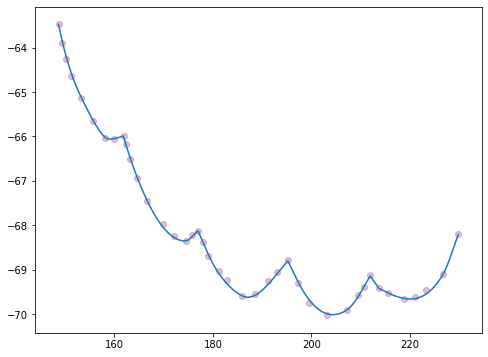

In [227]:
delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

delphi_arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]

delphiCurve = createCycloidBezier(delphi_arcs, maxError=0.008)

plt.figure(figsize=(8, 6))
plt.plot(delphiCurve['lon'], delphiCurve['lat'])
plt.scatter(delphi['lon'], delphi['lat'], color='purple', alpha=0.25)

In [238]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [0.03589231, 0.29910928]
# start_params = [0.98049468, 0.13124889]
start_params = [0.564134  , 0.48922702]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    delphiCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=1200,
    verbose=True,
    batch_size=16
)

Iteration 1/1200 -- Loss Output: 0.06133778740554888 -- Moving Avg Loss: 0.06133778740554888
	Parameters used: [0.564134, 0.48922702]
Iteration 2/1200 -- Loss Output: 0.06318347562801009 -- Moving Avg Loss: 0.062260631516779484
	Parameters used: [0.614134   0.53922702]
Iteration 3/1200 -- Loss Output: 0.056430498805342795 -- Moving Avg Loss: 0.06031725394630059
	Parameters used: [0.65476909 0.57903661]
Iteration 4/1200 -- Loss Output: 0.06727186941708062 -- Moving Avg Loss: 0.0620559078139956
	Parameters used: [0.68685674 0.61113898]
Iteration 5/1200 -- Loss Output: 0.06675392640871117 -- Moving Avg Loss: 0.06299551153293872
	Parameters used: [0.71382814 0.63810832]
Iteration 6/1200 -- Loss Output: 0.03892665192131776 -- Moving Avg Loss: 0.0589840349310019
	Parameters used: [0.74073793 0.66494119]
Iteration 7/1200 -- Loss Output: 0.05004522807247599 -- Moving Avg Loss: 0.05770706252264105
	Parameters used: [0.76595311 0.6900574 ]
Iteration 8/1200 -- Loss Output: 0.06963939948705984 -- 

Iteration 62/1200 -- Loss Output: 0.05713020949415855 -- Moving Avg Loss: 0.06798685344102365
	Parameters used: [0.67774136 0.3744349 ]
Iteration 63/1200 -- Loss Output: 0.052832401759459406 -- Moving Avg Loss: 0.06671281404473092
	Parameters used: [0.69034618 0.38694815]
Iteration 64/1200 -- Loss Output: 0.0660938357522937 -- Moving Avg Loss: 0.0660784406562826
	Parameters used: [0.70430916 0.40081939]
Iteration 65/1200 -- Loss Output: 0.05431643168954493 -- Moving Avg Loss: 0.0652725992769174
	Parameters used: [0.71708258 0.41350913]
Iteration 66/1200 -- Loss Output: 0.04846611145316977 -- Moving Avg Loss: 0.06350269027530876
	Parameters used: [0.73020155 0.42654579]
Iteration 67/1200 -- Loss Output: 0.04776354471296357 -- Moving Avg Loss: 0.06269819539602564
	Parameters used: [0.74225631 0.43852518]
Iteration 68/1200 -- Loss Output: 0.049870832643796215 -- Moving Avg Loss: 0.06228760782188242
	Parameters used: [0.7560458  0.45223372]
Iteration 69/1200 -- Loss Output: 0.0542555393732

Iteration 123/1200 -- Loss Output: 0.07018916259645157 -- Moving Avg Loss: 0.0610477883306422
	Parameters used: [0.75424438 0.66959035]
Iteration 124/1200 -- Loss Output: 0.052891279428409016 -- Moving Avg Loss: 0.06082193644609582
	Parameters used: [0.76761114 0.68291323]
Iteration 125/1200 -- Loss Output: 0.04107299353948411 -- Moving Avg Loss: 0.06010147441247178
	Parameters used: [0.78027175 0.69553275]
Iteration 126/1200 -- Loss Output: 0.06337976314660702 -- Moving Avg Loss: 0.05997936182386736
	Parameters used: [0.79243532 0.70765739]
Iteration 127/1200 -- Loss Output: 0.059891915651891794 -- Moving Avg Loss: 0.06015045810688698
	Parameters used: [0.80352711 0.71871375]
Iteration 128/1200 -- Loss Output: 0.06416315884216545 -- Moving Avg Loss: 0.05995935381405885
	Parameters used: [0.8210665  0.73620294]
Iteration 129/1200 -- Loss Output: 0.07327084659257181 -- Moving Avg Loss: 0.05982716055467639
	Parameters used: [0.83699285 0.7520837 ]
Iteration 130/1200 -- Loss Output: 0.064

Iteration 183/1200 -- Loss Output: 0.05805744761966365 -- Moving Avg Loss: 0.061138900902233034
	Parameters used: [0.02185623 0.94589533]
Iteration 184/1200 -- Loss Output: 0.06513218704727111 -- Moving Avg Loss: 0.06179246213655941
	Parameters used: [0.03269073 0.95888292]
Iteration 185/1200 -- Loss Output: 0.06923080324677083 -- Moving Avg Loss: 0.06289706146284596
	Parameters used: [0.04266725 0.97076977]
Iteration 186/1200 -- Loss Output: 0.07005383177332218 -- Moving Avg Loss: 0.06355908164493512
	Parameters used: [0.05525409 0.98449447]
Iteration 187/1200 -- Loss Output: 0.07300647395738656 -- Moving Avg Loss: 0.06345527403530922
	Parameters used: [0.06749751 0.99768894]
Iteration 188/1200 -- Loss Output: 0.07544599605629149 -- Moving Avg Loss: 0.0644984758490883
	Parameters used: [0.07906052 0.82565098]
Iteration 189/1200 -- Loss Output: 0.07890583944834081 -- Moving Avg Loss: 0.0648276807100034
	Parameters used: [0.09045723 0.83676386]
Iteration 190/1200 -- Loss Output: 0.09066

Iteration 243/1200 -- Loss Output: 0.07390658641446686 -- Moving Avg Loss: 0.06299204398689749
	Parameters used: [0.73283139 0.18265573]
Iteration 244/1200 -- Loss Output: 0.047916811126905934 -- Moving Avg Loss: 0.06205447909858448
	Parameters used: [0.73990949 0.1896703 ]
Iteration 245/1200 -- Loss Output: 0.06278924788486918 -- Moving Avg Loss: 0.06104011105779608
	Parameters used: [0.75441023 0.20406583]
Iteration 246/1200 -- Loss Output: 0.05823396935404693 -- Moving Avg Loss: 0.06136595617564805
	Parameters used: [0.76789244 0.21745004]
Iteration 247/1200 -- Loss Output: 0.062314929710129884 -- Moving Avg Loss: 0.06079975973421083
	Parameters used: [0.78074083 0.23020476]
Iteration 248/1200 -- Loss Output: 0.06255198003019932 -- Moving Avg Loss: 0.06045744762961549
	Parameters used: [0.79260826 0.24198558]
Iteration 249/1200 -- Loss Output: 0.0576096679362085 -- Moving Avg Loss: 0.0603781189155466
	Parameters used: [0.80555741 0.25483951]
Iteration 250/1200 -- Loss Output: 0.0614

Iteration 303/1200 -- Loss Output: 0.060832708413658454 -- Moving Avg Loss: 0.1195048968468909
	Parameters used: [0.48132059 0.91816741]
Iteration 304/1200 -- Loss Output: 0.07278811746160098 -- Moving Avg Loss: 0.06787589001526431
	Parameters used: [0.49426162 0.93096241]
Iteration 305/1200 -- Loss Output: 0.051312152149495714 -- Moving Avg Loss: 0.06742955286533346
	Parameters used: [0.50595977 0.942529  ]
Iteration 306/1200 -- Loss Output: 0.06813383476965323 -- Moving Avg Loss: 0.0669537286525969
	Parameters used: [0.51719972 0.95365272]
Iteration 307/1200 -- Loss Output: 0.06710410224041488 -- Moving Avg Loss: 0.06758895070912516
	Parameters used: [0.52745489 0.9638034 ]
Iteration 308/1200 -- Loss Output: 0.0371310268669159 -- Moving Avg Loss: 0.06599833498907393
	Parameters used: [0.53711518 0.97337046]
Iteration 309/1200 -- Loss Output: 0.07573634049429383 -- Moving Avg Loss: 0.06623073590568898
	Parameters used: [0.54607991 0.98225161]
Iteration 310/1200 -- Loss Output: 0.05271

Iteration 363/1200 -- Loss Output: 0.04839373084487204 -- Moving Avg Loss: 0.06725157073182758
	Parameters used: [0.15284025 0.3438288 ]
Iteration 364/1200 -- Loss Output: 0.06475516481449779 -- Moving Avg Loss: 0.06681449266568582
	Parameters used: [0.17033938 0.36126048]
Iteration 365/1200 -- Loss Output: 0.060973665539313056 -- Moving Avg Loss: 0.06694645404425469
	Parameters used: [0.1861934  0.37705337]
Iteration 366/1200 -- Loss Output: 0.08392377111360787 -- Moving Avg Loss: 0.06717469220946821
	Parameters used: [0.20097261 0.39177545]
Iteration 367/1200 -- Loss Output: 0.07995166843347452 -- Moving Avg Loss: 0.06745572392970496
	Parameters used: [0.21475583 0.40550526]
Iteration 368/1200 -- Loss Output: 0.08113179548225671 -- Moving Avg Loss: 0.06824307827084744
	Parameters used: [0.22760256 0.41830211]
Iteration 369/1200 -- Loss Output: 0.06452585193752867 -- Moving Avg Loss: 0.06832865460520385
	Parameters used: [0.23941853 0.43007214]
Iteration 370/1200 -- Loss Output: 0.062

Iteration 423/1200 -- Loss Output: 0.048235916792164546 -- Moving Avg Loss: 0.09395924515227991
	Parameters used: [0.83276253 0.17037051]
Iteration 424/1200 -- Loss Output: 0.04974412082086503 -- Moving Avg Loss: 0.09345685030425828
	Parameters used: [0.9114701  0.24858778]
Iteration 425/1200 -- Loss Output: 0.052428611466107104 -- Moving Avg Loss: 0.09351158834480895
	Parameters used: [0.98244854 0.31912437]
Iteration 426/1200 -- Loss Output: 0.07124578734521349 -- Moving Avg Loss: 0.09381626267475333
	Parameters used: [0.0464405  0.38271812]
Iteration 427/1200 -- Loss Output: 0.07232193974204651 -- Moving Avg Loss: 0.0945514441850056
	Parameters used: [0.10411565 0.44004651]
Iteration 428/1200 -- Loss Output: 0.0643608449151944 -- Moving Avg Loss: 0.09440027681208854
	Parameters used: [0.15621637 0.49183485]
Iteration 429/1200 -- Loss Output: 0.07531006208259494 -- Moving Avg Loss: 0.09448433625948564
	Parameters used: [0.20320858 0.53854556]
Iteration 430/1200 -- Loss Output: 0.0559

Iteration 483/1200 -- Loss Output: 0.0601983630900158 -- Moving Avg Loss: 0.20853235234634898
	Parameters used: [0.98424066 0.8915578 ]
Iteration 484/1200 -- Loss Output: 0.07172423512717618 -- Moving Avg Loss: 0.2078619406028964
	Parameters used: [0.9972328  0.90427509]
Iteration 485/1200 -- Loss Output: 0.06823614478342344 -- Moving Avg Loss: 0.20847613660529418
	Parameters used: [0.00918031 0.9159789 ]
Iteration 486/1200 -- Loss Output: 0.08478394957274903 -- Moving Avg Loss: 0.2087654996059484
	Parameters used: [0.0199458  0.92663284]
Iteration 487/1200 -- Loss Output: 0.0864400267764554 -- Moving Avg Loss: 0.21004014971695145
	Parameters used: [0.02979557 0.93638292]
Iteration 488/1200 -- Loss Output: 0.09632262518828123 -- Moving Avg Loss: 0.21111885159459373
	Parameters used: [0.0389113 0.9454101]
Iteration 489/1200 -- Loss Output: 0.04822727629876178 -- Moving Avg Loss: 0.21049120902860902
	Parameters used: [0.04729974 0.95371961]
Iteration 490/1200 -- Loss Output: 0.0979061976

Iteration 543/1200 -- Loss Output: 0.06926763167368276 -- Moving Avg Loss: 0.06821906746216708
	Parameters used: [0.51185872 0.69236122]
Iteration 544/1200 -- Loss Output: 0.06364586169240327 -- Moving Avg Loss: 0.06826058589273944
	Parameters used: [0.52107852 0.70155932]
Iteration 545/1200 -- Loss Output: 0.0722731177924782 -- Moving Avg Loss: 0.06796962193713109
	Parameters used: [0.52948471 0.70994571]
Iteration 546/1200 -- Loss Output: 0.04911647041108807 -- Moving Avg Loss: 0.06766076063846176
	Parameters used: [0.53715784 0.71760076]
Iteration 547/1200 -- Loss Output: 0.05547502867664963 -- Moving Avg Loss: 0.067561820393638
	Parameters used: [0.54450172 0.72492732]
Iteration 548/1200 -- Loss Output: 0.04795548878494761 -- Moving Avg Loss: 0.0674889040087887
	Parameters used: [0.55211081 0.73251841]
Iteration 549/1200 -- Loss Output: 0.06617839834642107 -- Moving Avg Loss: 0.06790310906549482
	Parameters used: [0.55955622 0.73994619]
Iteration 550/1200 -- Loss Output: 0.05524717

Iteration 603/1200 -- Loss Output: 0.06091693244856481 -- Moving Avg Loss: 0.07007425123738659
	Parameters used: [0.0845819  0.95283407]
Iteration 604/1200 -- Loss Output: 0.06095408467581901 -- Moving Avg Loss: 0.0701431877284364
	Parameters used: [0.09044802 0.95872327]
Iteration 605/1200 -- Loss Output: 0.06631902255986967 -- Moving Avg Loss: 0.07039093101527363
	Parameters used: [0.09589111 0.96418582]
Iteration 606/1200 -- Loss Output: 0.09955059249170191 -- Moving Avg Loss: 0.07222587301909447
	Parameters used: [0.10165121 0.9699564 ]
Iteration 607/1200 -- Loss Output: 0.054834275345204464 -- Moving Avg Loss: 0.07171308287618737
	Parameters used: [0.10695936 0.97527325]
Iteration 608/1200 -- Loss Output: 0.07605258314363877 -- Moving Avg Loss: 0.0719540620303948
	Parameters used: [0.11204852 0.9803683 ]
Iteration 609/1200 -- Loss Output: 0.06819361939092093 -- Moving Avg Loss: 0.07245989521951796
	Parameters used: [0.11728804 0.98560932]
Iteration 610/1200 -- Loss Output: 0.05350

Iteration 663/1200 -- Loss Output: 0.04768724600415862 -- Moving Avg Loss: 0.06608203731674916
	Parameters used: [0.66960366 0.90751321]
Iteration 664/1200 -- Loss Output: 0.09663017007842366 -- Moving Avg Loss: 0.06704262994293789
	Parameters used: [0.69290792 0.93076575]
Iteration 665/1200 -- Loss Output: 0.050639002803320704 -- Moving Avg Loss: 0.0663921744031826
	Parameters used: [0.71418842 0.95199899]
Iteration 666/1200 -- Loss Output: 0.7451499490302368 -- Moving Avg Loss: 0.09313283507422188
	Parameters used: [0.73349602 0.9712637 ]
Iteration 667/1200 -- Loss Output: 0.06894652267993023 -- Moving Avg Loss: 0.09322378984459113
	Parameters used: [0.75101365 0.98874241]
Iteration 668/1200 -- Loss Output: 0.052185810650395355 -- Moving Avg Loss: 0.0931392650012627
	Parameters used: [0.76715277 0.12440465]
Iteration 669/1200 -- Loss Output: 0.06456696044138203 -- Moving Avg Loss: 0.09332266081094226
	Parameters used: [0.7818565  0.13890941]
Iteration 670/1200 -- Loss Output: 0.08312

Iteration 723/1200 -- Loss Output: 0.06322949177555028 -- Moving Avg Loss: 0.06911802537502322
	Parameters used: [0.61993556 0.96999824]
Iteration 724/1200 -- Loss Output: 0.06717109488614184 -- Moving Avg Loss: 0.06921768656537182
	Parameters used: [0.62568314 0.97572515]
Iteration 725/1200 -- Loss Output: 0.06215617811841112 -- Moving Avg Loss: 0.06909024184249925
	Parameters used: [0.63166247 0.98168849]
Iteration 726/1200 -- Loss Output: 0.06067214170984514 -- Moving Avg Loss: 0.06853181361112841
	Parameters used: [0.63712506 0.98713687]
Iteration 727/1200 -- Loss Output: 0.06828960899244842 -- Moving Avg Loss: 0.06823727523208808
	Parameters used: [0.6430646  0.99306594]
Iteration 728/1200 -- Loss Output: 0.06248213218951625 -- Moving Avg Loss: 0.06796594163176942
	Parameters used: [0.64880869 0.99880117]
Iteration 729/1200 -- Loss Output: 0.07593778311890473 -- Moving Avg Loss: 0.06825037120785071
	Parameters used: [0.65447758 0.23185308]
Iteration 730/1200 -- Loss Output: 0.0673

Iteration 783/1200 -- Loss Output: 0.06186122114892676 -- Moving Avg Loss: 0.07039618006563478
	Parameters used: [0.21337456 0.79220157]
Iteration 784/1200 -- Loss Output: 0.0534301703671002 -- Moving Avg Loss: 0.06988707432387317
	Parameters used: [0.22191055 0.80073876]
Iteration 785/1200 -- Loss Output: 0.06348531106176983 -- Moving Avg Loss: 0.07014133551442028
	Parameters used: [0.22991949 0.80874863]
Iteration 786/1200 -- Loss Output: 0.0655107693428665 -- Moving Avg Loss: 0.07072094869302091
	Parameters used: [0.24122498 0.82005312]
Iteration 787/1200 -- Loss Output: 0.08882956253235263 -- Moving Avg Loss: 0.07086174054146573
	Parameters used: [0.25161063 0.83043783]
Iteration 788/1200 -- Loss Output: 0.09544299126242188 -- Moving Avg Loss: 0.0717789947846134
	Parameters used: [0.26155009 0.84037629]
Iteration 789/1200 -- Loss Output: 0.0626505101274057 -- Moving Avg Loss: 0.07062755219166326
	Parameters used: [0.27109603 0.8499212 ]
Iteration 790/1200 -- Loss Output: 0.09799476

Iteration 843/1200 -- Loss Output: 0.6570186906737753 -- Moving Avg Loss: 0.10897332403068835
	Parameters used: [0.7782115  0.97243837]
Iteration 844/1200 -- Loss Output: 0.06037726158789918 -- Moving Avg Loss: 0.10885486503585522
	Parameters used: [0.80162779 0.99585945]
Iteration 845/1200 -- Loss Output: 0.06971577527660702 -- Moving Avg Loss: 0.10864027901171307
	Parameters used: [0.82800286 0.24273199]
Iteration 846/1200 -- Loss Output: 0.07178242183178905 -- Moving Avg Loss: 0.1085390540525168
	Parameters used: [0.8522135  0.26647499]
Iteration 847/1200 -- Loss Output: 0.06388432929863976 -- Moving Avg Loss: 0.10883975148190396
	Parameters used: [0.87411495 0.28795696]
Iteration 848/1200 -- Loss Output: 0.0721757702547532 -- Moving Avg Loss: 0.10883172069842367
	Parameters used: [0.89440861 0.3078835 ]
Iteration 849/1200 -- Loss Output: 0.06264555084542804 -- Moving Avg Loss: 0.10929847302032306
	Parameters used: [0.91272495 0.3258698 ]
Iteration 850/1200 -- Loss Output: 0.0694585

Iteration 903/1200 -- Loss Output: 0.0876998919601507 -- Moving Avg Loss: 0.0701739128048988
	Parameters used: [0.33374332 0.76400542]
Iteration 904/1200 -- Loss Output: 0.058485127839445226 -- Moving Avg Loss: 0.07025199342413578
	Parameters used: [0.34000301 0.77026274]
Iteration 905/1200 -- Loss Output: 0.06388132318875259 -- Moving Avg Loss: 0.07015724876959868
	Parameters used: [0.34592599 0.77618349]
Iteration 906/1200 -- Loss Output: 0.06011631399298482 -- Moving Avg Loss: 0.07007684199402854
	Parameters used: [0.35181976 0.78207503]
Iteration 907/1200 -- Loss Output: 0.08465815742152409 -- Moving Avg Loss: 0.07090509843346808
	Parameters used: [0.35770367 0.7879567 ]
Iteration 908/1200 -- Loss Output: 0.07778262253482726 -- Moving Avg Loss: 0.07159344455500609
	Parameters used: [0.36326906 0.79351998]
Iteration 909/1200 -- Loss Output: 0.08246367914525347 -- Moving Avg Loss: 0.07264568032818193
	Parameters used: [0.3740522  0.80429898]
Iteration 910/1200 -- Loss Output: 0.05052

Iteration 963/1200 -- Loss Output: 0.08505550344425643 -- Moving Avg Loss: 0.06519869371161875
	Parameters used: [0.31903635 0.96565172]
Iteration 964/1200 -- Loss Output: 0.05009469412466316 -- Moving Avg Loss: 0.06514451787500937
	Parameters used: [0.33867559 0.98529556]
Iteration 965/1200 -- Loss Output: 0.07094000953576157 -- Moving Avg Loss: 0.0649141806824792
	Parameters used: [0.3564376  0.34243432]
Iteration 966/1200 -- Loss Output: 0.07329271939461698 -- Moving Avg Loss: 0.06533065029567083
	Parameters used: [0.3727561  0.35842789]
Iteration 967/1200 -- Loss Output: 0.06098325246172797 -- Moving Avg Loss: 0.06538174966348295
	Parameters used: [0.38788385 0.37327131]
Iteration 968/1200 -- Loss Output: 0.07530780885732914 -- Moving Avg Loss: 0.06585450412543825
	Parameters used: [0.40185874 0.3869965 ]
Iteration 969/1200 -- Loss Output: 0.0692735562744404 -- Moving Avg Loss: 0.06603719596728233
	Parameters used: [0.41468735 0.39960437]
Iteration 970/1200 -- Loss Output: 0.051084

Iteration 1023/1200 -- Loss Output: 0.05118169115132813 -- Moving Avg Loss: 0.06023197750530783
	Parameters used: [0.84396558 0.82770695]
Iteration 1024/1200 -- Loss Output: 0.0603516492095505 -- Moving Avg Loss: 0.06064662688381205
	Parameters used: [0.84916254 0.8329017 ]
Iteration 1025/1200 -- Loss Output: 0.06219216556825764 -- Moving Avg Loss: 0.06049769810210471
	Parameters used: [0.85389615 0.8376333 ]
Iteration 1026/1200 -- Loss Output: 0.06369865435762788 -- Moving Avg Loss: 0.06059104793355117
	Parameters used: [0.85923073 0.8429656 ]
Iteration 1027/1200 -- Loss Output: 0.062098929786014306 -- Moving Avg Loss: 0.06063014926254661
	Parameters used: [0.8641237  0.84785647]
Iteration 1028/1200 -- Loss Output: 0.07107310529227039 -- Moving Avg Loss: 0.060467486865803444
	Parameters used: [0.869924  0.8536543]
Iteration 1029/1200 -- Loss Output: 0.04934699473462441 -- Moving Avg Loss: 0.05975905619047442
	Parameters used: [0.87539553 0.85912349]
Iteration 1030/1200 -- Loss Output:

Iteration 1083/1200 -- Loss Output: 0.0742509563930325 -- Moving Avg Loss: 0.06889377301447304
	Parameters used: [0.18546043 0.67978211]
Iteration 1084/1200 -- Loss Output: 0.09693974824277797 -- Moving Avg Loss: 0.07003637258298176
	Parameters used: [0.19222697 0.68654438]
Iteration 1085/1200 -- Loss Output: 0.07810036657036606 -- Moving Avg Loss: 0.07024252246480028
	Parameters used: [0.19833982 0.69265338]
Iteration 1086/1200 -- Loss Output: 0.07564856349542073 -- Moving Avg Loss: 0.07093456036166017
	Parameters used: [0.20479219 0.69910205]
Iteration 1087/1200 -- Loss Output: 0.06411403381488925 -- Moving Avg Loss: 0.07128633017089415
	Parameters used: [0.21076626 0.70507274]
Iteration 1088/1200 -- Loss Output: 0.08044869570887286 -- Moving Avg Loss: 0.07143548884191148
	Parameters used: [0.21680289 0.71110612]
Iteration 1089/1200 -- Loss Output: 0.06060357096525235 -- Moving Avg Loss: 0.07168544514470732
	Parameters used: [0.22253997 0.71684018]
Iteration 1090/1200 -- Loss Output:

Iteration 1143/1200 -- Loss Output: 0.05370113865677211 -- Moving Avg Loss: 0.07662962768001433
	Parameters used: [0.32059418 0.81366957]
Iteration 1144/1200 -- Loss Output: 0.07423566402094321 -- Moving Avg Loss: 0.07718280506547605
	Parameters used: [0.32853354 0.82160634]
Iteration 1145/1200 -- Loss Output: 0.07306157234888357 -- Moving Avg Loss: 0.07656028776737857
	Parameters used: [0.33565078 0.82872125]
Iteration 1146/1200 -- Loss Output: 0.09898379974633179 -- Moving Avg Loss: 0.07650058698773876
	Parameters used: [0.34779144 0.84085779]
Iteration 1147/1200 -- Loss Output: 0.07944060766542776 -- Moving Avg Loss: 0.07705935084348654
	Parameters used: [0.35879618 0.85185879]
Iteration 1148/1200 -- Loss Output: 0.0562507477021499 -- Moving Avg Loss: 0.07717157519166834
	Parameters used: [0.36940147 0.86246047]
Iteration 1149/1200 -- Loss Output: 0.0835135532999689 -- Moving Avg Loss: 0.07737570767388738
	Parameters used: [0.37914467 0.87220035]
Iteration 1150/1200 -- Loss Output: 

{'loss': 0.030739589225580954, 'parameters': array([0.23124568, 0.47017256])}

{'loss': 0.06605965639708203, 'parameters': array([0.88829589, 0.5733125 ])}

[83.2484452  0.5231553]
[319.78651903   0.61598125]


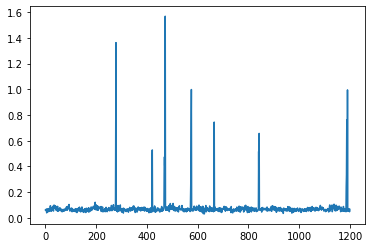

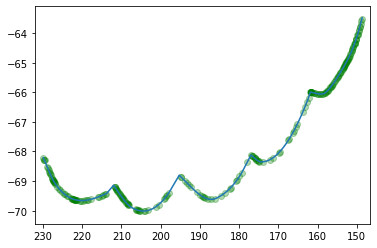

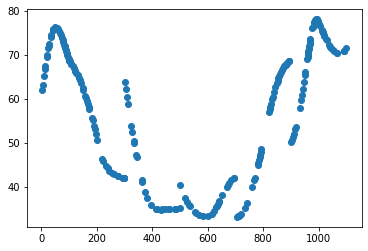

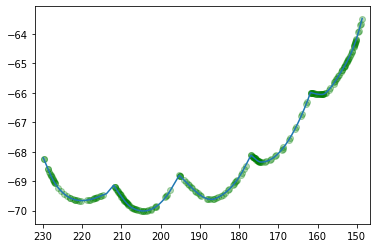

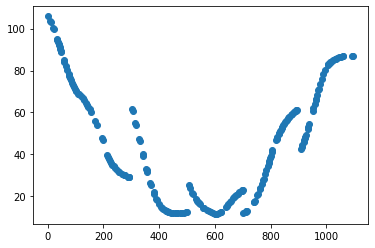

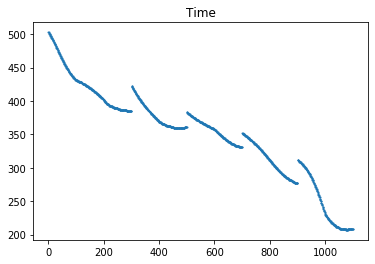

In [243]:
bestFit, finalFit = analyze_fit(opt, delphiCurve, 0.05)

In [241]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/delphiFits.gz', index=False, encoding='utf-8', compression='gzip')
bestFit.to_csv('./output/delphiBestFit.gz', index=False, encoding='utf-8', compression='gzip')

#### Test with no phase

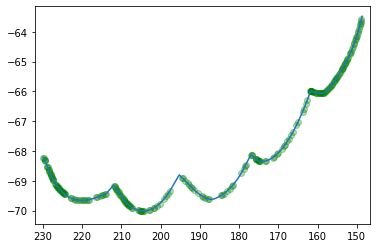

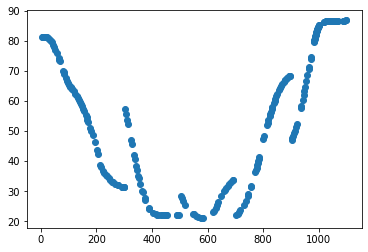

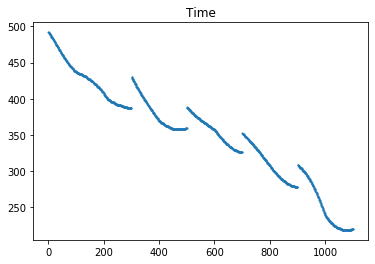

In [244]:
data = direct_fit(delphiCurve, 0.05)

### Tyrrel

In [7]:
tyrrel = pd.read_csv("./obsData/TyrrelLonLat2.txt", header=None, sep=' ', names=['lon', 'lat'])
tyrrel = tyrrel.sort_values(['lon', 'lat'])

tyrrel_arcs = [
    tyrrel[0:13],
    tyrrel[13:25],
    tyrrel[25:40],
    tyrrel[40:53],
    tyrrel[53:59],
    tyrrel[59:63],
    tyrrel[63:74],
    tyrrel[74:84],
    tyrrel[84:95],
    tyrrel[95:]
]

tyrrelCurve = createCycloidBezier(tyrrel_arcs, maxError=0.01135)

plt.plot(tyrrelCurve['lon'], tyrrelCurve['lat'])
plt.scatter(tyrrel['lon'], tyrrel['lat'], color='purple', alpha=0.25)

In [46]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [0.82787206, 0.35201265, 0.78423926]
# start_params = [0.221, 0.558]
# start_params = [0.12218236, 0.62424572]
start_params = [0.221, 0.65011694]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    tyrrelCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 0.038896147205498846 -- Moving Avg Loss: 0.038896147205498846
	Parameters used: [0.221, 0.65011694]
Iteration 2/3000 -- Loss Output: 1.2676608699485712 -- Moving Avg Loss: 0.6532785085770351
	Parameters used: [0.17100001 0.60011697]
Iteration 3/3000 -- Loss Output: 0.06605837499716084 -- Moving Avg Loss: 0.4575384640504103
	Parameters used: [0.13152477 0.56211652]
Iteration 4/3000 -- Loss Output: 0.06307551076283634 -- Moving Avg Loss: 0.3589227257285168
	Parameters used: [0.09853103 0.52920206]
Iteration 5/3000 -- Loss Output: 0.22093037032035412 -- Moving Avg Loss: 0.33132425464688425
	Parameters used: [0.06978274 0.50057694]
Iteration 6/3000 -- Loss Output: 2.031200405187459 -- Moving Avg Loss: 0.6146369464036466
	Parameters used: [0.04489209 0.47580973]
Iteration 7/3000 -- Loss Output: 2.4992591408901164 -- Moving Avg Loss: 0.8838686884731423
	Parameters used: [0.01843436 0.44934218]
Iteration 8/3000 -- Loss Output: 3.534480882848034 -- Moving Avg L

Iteration 63/3000 -- Loss Output: 3.5756818262030743 -- Moving Avg Loss: 2.2642828178184384
	Parameters used: [0.00523991 0.69329768]
Iteration 64/3000 -- Loss Output: 3.743738183697887 -- Moving Avg Loss: 2.3887965203537544
	Parameters used: [0.99951682 0.68779032]
Iteration 65/3000 -- Loss Output: 5.105642453795893 -- Moving Avg Loss: 2.5790409632128
	Parameters used: [0.99432728 0.68229901]
Iteration 66/3000 -- Loss Output: 5.756365431340101 -- Moving Avg Loss: 2.715107608246888
	Parameters used: [0.9891234  0.67681657]
Iteration 67/3000 -- Loss Output: 6.237111971732119 -- Moving Avg Loss: 2.8196876380178413
	Parameters used: [0.98397944 0.67141395]
Iteration 68/3000 -- Loss Output: 4.619868323044469 -- Moving Avg Loss: 2.9817428083368913
	Parameters used: [0.97845106 0.6656361 ]
Iteration 69/3000 -- Loss Output: 7.686347514930012 -- Moving Avg Loss: 3.2830340421612805
	Parameters used: [0.96674162 0.65356004]
Iteration 70/3000 -- Loss Output: 4.245998873273906 -- Moving Avg Loss: 

Iteration 125/3000 -- Loss Output: 11.53546196053237 -- Moving Avg Loss: 3.647119600186358
	Parameters used: [0.86668167 0.08907866]
Iteration 126/3000 -- Loss Output: 9.652477683279162 -- Moving Avg Loss: 3.9843712144468086
	Parameters used: [0.84020414 0.06198512]
Iteration 127/3000 -- Loss Output: 9.018947189843722 -- Moving Avg Loss: 4.342083431378546
	Parameters used: [0.80197158 0.02292567]
Iteration 128/3000 -- Loss Output: 10.510131912525955 -- Moving Avg Loss: 4.70926001227564
	Parameters used: [0.76660984 0.44883775]
Iteration 129/3000 -- Loss Output: 11.083506074858178 -- Moving Avg Loss: 5.05473036529663
	Parameters used: [0.71588426 0.41821091]
Iteration 130/3000 -- Loss Output: 11.777441697556606 -- Moving Avg Loss: 5.519072192625238
	Parameters used: [0.66881782 0.38823815]
Iteration 131/3000 -- Loss Output: 9.461701686985405 -- Moving Avg Loss: 5.798913169062444
	Parameters used: [0.61390998 0.34068483]
Iteration 132/3000 -- Loss Output: 13.439724498752428 -- Moving Avg

Iteration 187/3000 -- Loss Output: 12.472143595794416 -- Moving Avg Loss: 8.555653038238928
	Parameters used: [0.53477045 0.33436473]
Iteration 188/3000 -- Loss Output: 4.011006289250169 -- Moving Avg Loss: 8.462258297154845
	Parameters used: [0.49356632 0.29216194]
Iteration 189/3000 -- Loss Output: 4.629192862058644 -- Moving Avg Loss: 8.43949016184894
	Parameters used: [0.45627224 0.25396368]
Iteration 190/3000 -- Loss Output: 4.476228934962121 -- Moving Avg Loss: 8.330639927661254
	Parameters used: [0.42259021 0.21946498]
Iteration 191/3000 -- Loss Output: 2.807702767177835 -- Moving Avg Loss: 8.141502163549141
	Parameters used: [0.3920039  0.18813654]
Iteration 192/3000 -- Loss Output: 1.501794543476667 -- Moving Avg Loss: 7.8268410680020315
	Parameters used: [0.36394566 0.15939627]
Iteration 193/3000 -- Loss Output: 1.5974469133659992 -- Moving Avg Loss: 7.650768307967557
	Parameters used: [0.33859471 0.13342902]
Iteration 194/3000 -- Loss Output: 2.7670107466605898 -- Moving Avg

Iteration 248/3000 -- Loss Output: 3.3530949221635074 -- Moving Avg Loss: 1.7568519898644956
	Parameters used: [0.00896656 0.453052  ]
Iteration 249/3000 -- Loss Output: 4.555727810430579 -- Moving Avg Loss: 1.9172954234914044
	Parameters used: [0.00464425 0.44861887]
Iteration 250/3000 -- Loss Output: 3.9663065956866337 -- Moving Avg Loss: 2.0729840910560533
	Parameters used: [0.00053817 0.44440752]
Iteration 251/3000 -- Loss Output: 5.023584453905059 -- Moving Avg Loss: 2.2447427977250936
	Parameters used: [0.99620688 0.43996519]
Iteration 252/3000 -- Loss Output: 3.6878076058545552 -- Moving Avg Loss: 2.388576234666297
	Parameters used: [0.99230027 0.43587415]
Iteration 253/3000 -- Loss Output: 5.008408529559615 -- Moving Avg Loss: 2.5845389132300305
	Parameters used: [0.98646234 0.42985953]
Iteration 254/3000 -- Loss Output: 2.9118732589344045 -- Moving Avg Loss: 2.6970231083294505
	Parameters used: [0.98075021 0.42397865]
Iteration 255/3000 -- Loss Output: 3.0101910648293293 -- Mo

Iteration 310/3000 -- Loss Output: 14.468497348769764 -- Moving Avg Loss: 6.863199077230532
	Parameters used: [0.50848928 0.69784543]
Iteration 311/3000 -- Loss Output: 7.129313180363947 -- Moving Avg Loss: 7.030892568138091
	Parameters used: [0.48502418 0.67441577]
Iteration 312/3000 -- Loss Output: 8.600086984833998 -- Moving Avg Loss: 7.26532672155255
	Parameters used: [0.46374446 0.65316801]
Iteration 313/3000 -- Loss Output: 7.499085094038848 -- Moving Avg Loss: 7.403337218462813
	Parameters used: [0.44449112 0.6339435 ]
Iteration 314/3000 -- Loss Output: 4.543396571347154 -- Moving Avg Loss: 7.428697866029778
	Parameters used: [0.4270698  0.61654817]
Iteration 315/3000 -- Loss Output: 5.199317443134884 -- Moving Avg Loss: 7.472448686543731
	Parameters used: [0.41119241 0.60069424]
Iteration 316/3000 -- Loss Output: 5.78119765267845 -- Moving Avg Loss: 7.5302532568520375
	Parameters used: [0.39673216 0.58625515]
Iteration 317/3000 -- Loss Output: 5.473921114470519 -- Moving Avg Lo

Iteration 372/3000 -- Loss Output: 0.06512830004923466 -- Moving Avg Loss: 0.9394686779532008
	Parameters used: [0.18773744 0.37749485]
Iteration 373/3000 -- Loss Output: 3.0476178551303916 -- Moving Avg Loss: 1.0534968349408507
	Parameters used: [0.18665202 0.37641029]
Iteration 374/3000 -- Loss Output: 1.903775591574082 -- Moving Avg Loss: 1.0690946437285802
	Parameters used: [0.18564803 0.37540709]
Iteration 375/3000 -- Loss Output: 0.07344813381162192 -- Moving Avg Loss: 1.009508639391026
	Parameters used: [0.1840497  0.37381004]
Iteration 376/3000 -- Loss Output: 1.8171614636411868 -- Moving Avg Loss: 1.0560098696955427
	Parameters used: [0.18259825 0.37235973]
Iteration 377/3000 -- Loss Output: 0.18812514932870547 -- Moving Avg Loss: 0.970358719920032
	Parameters used: [0.181261   0.37102355]
Iteration 378/3000 -- Loss Output: 1.1896935025436506 -- Moving Avg Loss: 1.0112639473072507
	Parameters used: [0.17999401 0.36975756]
Iteration 379/3000 -- Loss Output: 0.9579401659504277 -

Iteration 433/3000 -- Loss Output: 1.5882050371069947 -- Moving Avg Loss: 1.7298931971892337
	Parameters used: [0.04898678 0.23885417]
Iteration 434/3000 -- Loss Output: 0.9338513125419717 -- Moving Avg Loss: 1.707900606844428
	Parameters used: [0.04594121 0.235811  ]
Iteration 435/3000 -- Loss Output: 0.18775772112299421 -- Moving Avg Loss: 1.6421424198794634
	Parameters used: [0.04315848 0.23303048]
Iteration 436/3000 -- Loss Output: 3.8623754094068525 -- Moving Avg Loss: 1.7728556419574897
	Parameters used: [0.04058428 0.23045832]
Iteration 437/3000 -- Loss Output: 1.4345181040654742 -- Moving Avg Loss: 1.7788200518770998
	Parameters used: [0.03824935 0.22812524]
Iteration 438/3000 -- Loss Output: 2.344057587026447 -- Moving Avg Loss: 1.8169894170270167
	Parameters used: [0.03565599 0.22553394]
Iteration 439/3000 -- Loss Output: 1.4637823965322796 -- Moving Avg Loss: 1.7744915441396134
	Parameters used: [0.03331851 0.2231983 ]
Iteration 440/3000 -- Loss Output: 3.0810406624537525 --

Iteration 495/3000 -- Loss Output: 1.8302046637543161 -- Moving Avg Loss: 7.84072525339373
	Parameters used: [0.33070573 0.00549197]
Iteration 496/3000 -- Loss Output: 3.2007101997679075 -- Moving Avg Loss: 7.521552134487274
	Parameters used: [0.31620037 0.10488442]
Iteration 497/3000 -- Loss Output: 2.0684647930108664 -- Moving Avg Loss: 7.1383519059540905
	Parameters used: [0.30281746 0.09196559]
Iteration 498/3000 -- Loss Output: 5.163354281813674 -- Moving Avg Loss: 6.879597879543991
	Parameters used: [0.29068521 0.08024911]
Iteration 499/3000 -- Loss Output: 4.0480175471964115 -- Moving Avg Loss: 6.636945400907179
	Parameters used: [0.27877887 0.0686848 ]
Iteration 500/3000 -- Loss Output: 5.676652013303767 -- Moving Avg Loss: 6.442573249187345
	Parameters used: [0.26725464 0.05744683]
Iteration 501/3000 -- Loss Output: 2.488703865452468 -- Moving Avg Loss: 6.210481467440132
	Parameters used: [0.25677678 0.04722476]
Iteration 502/3000 -- Loss Output: 3.9643998813706274 -- Moving A

Iteration 557/3000 -- Loss Output: 2.7020237206760007 -- Moving Avg Loss: 1.7850053317554406
	Parameters used: [0.01996208 0.25894541]
Iteration 558/3000 -- Loss Output: 2.0369066203634434 -- Moving Avg Loss: 1.7770888693251257
	Parameters used: [0.0137754  0.25276509]
Iteration 559/3000 -- Loss Output: 2.6217932366796 -- Moving Avg Loss: 1.8793515286960953
	Parameters used: [0.00764374 0.24663965]
Iteration 560/3000 -- Loss Output: 2.2033839385082294 -- Moving Avg Loss: 1.924124353614425
	Parameters used: [0.00029119 0.23929432]
Iteration 561/3000 -- Loss Output: 1.7896367839447842 -- Moving Avg Loss: 1.8867317743388095
	Parameters used: [0.99325289 0.23226293]
Iteration 562/3000 -- Loss Output: 1.9342892532762408 -- Moving Avg Loss: 1.9595459410058411
	Parameters used: [0.9869129  0.22566559]
Iteration 563/3000 -- Loss Output: 2.3052609095862207 -- Moving Avg Loss: 2.0179576196689215
	Parameters used: [0.98106371 0.21959009]
Iteration 564/3000 -- Loss Output: 2.8479232296942567 -- Mo

Iteration 619/3000 -- Loss Output: 1.018388255539685 -- Moving Avg Loss: 1.107297382408018
	Parameters used: [0.12359069 0.61580154]
Iteration 620/3000 -- Loss Output: 0.08075327980216222 -- Moving Avg Loss: 0.9972074625075511
	Parameters used: [0.12119799 0.6135513 ]
Iteration 621/3000 -- Loss Output: 0.7536950563974877 -- Moving Avg Loss: 0.8579160964689179
	Parameters used: [0.11903773 0.61151925]
Iteration 622/3000 -- Loss Output: 1.053149018790948 -- Moving Avg Loss: 0.744655163815881
	Parameters used: [0.11708761 0.60968453]
Iteration 623/3000 -- Loss Output: 0.09637975134634827 -- Moving Avg Loss: 0.7088883073305997
	Parameters used: [0.11528649 0.60798598]
Iteration 624/3000 -- Loss Output: 0.05262543636985706 -- Moving Avg Loss: 0.6860289994585834
	Parameters used: [0.11282124 0.60558854]
Iteration 625/3000 -- Loss Output: 0.21862847859487958 -- Moving Avg Loss: 0.5820843569611839
	Parameters used: [0.11059791 0.60342631]
Iteration 626/3000 -- Loss Output: 0.07145947011700894 

Iteration 680/3000 -- Loss Output: 4.0655246918079975 -- Moving Avg Loss: 3.652092611542394
	Parameters used: [0.93443757 0.42174108]
Iteration 681/3000 -- Loss Output: 9.594931248758167 -- Moving Avg Loss: 3.9897126712547766
	Parameters used: [0.92911613 0.41625225]
Iteration 682/3000 -- Loss Output: 5.420057066827193 -- Moving Avg Loss: 4.147400856834378
	Parameters used: [0.92331185 0.41035679]
Iteration 683/3000 -- Loss Output: 6.652501318408827 -- Moving Avg Loss: 4.362644847299102
	Parameters used: [0.91790081 0.40487168]
Iteration 684/3000 -- Loss Output: 8.861265274589956 -- Moving Avg Loss: 4.653676914955504
	Parameters used: [0.91177443 0.39873179]
Iteration 685/3000 -- Loss Output: 8.05450951890101 -- Moving Avg Loss: 4.956189426211587
	Parameters used: [0.89519457 0.38248471]
Iteration 686/3000 -- Loss Output: 10.636021176980313 -- Moving Avg Loss: 5.241878233732514
	Parameters used: [0.87495035 0.36258871]
Iteration 687/3000 -- Loss Output: 8.413732090072603 -- Moving Avg 

Iteration 742/3000 -- Loss Output: 1.7166876402221323 -- Moving Avg Loss: 8.050280242684032
	Parameters used: [0.20229998 0.2088572 ]
Iteration 743/3000 -- Loss Output: 0.48116880303812637 -- Moving Avg Loss: 7.720645259534275
	Parameters used: [0.15782531 0.16469402]
Iteration 744/3000 -- Loss Output: 3.607236991240742 -- Moving Avg Loss: 7.564029745818413
	Parameters used: [0.11775889 0.12490822]
Iteration 745/3000 -- Loss Output: 1.210150691790058 -- Moving Avg Loss: 7.258931162597874
	Parameters used: [0.08166248 0.08906463]
Iteration 746/3000 -- Loss Output: 0.9645037000717326 -- Moving Avg Loss: 6.882995096492965
	Parameters used: [0.04912964 0.0567597 ]
Iteration 747/3000 -- Loss Output: 1.1222990384451585 -- Moving Avg Loss: 6.388560663132327
	Parameters used: [0.01980625 0.02764178]
Iteration 748/3000 -- Loss Output: 0.8226187163416521 -- Moving Avg Loss: 6.060366278301626
	Parameters used: [0.99338977 0.0014104 ]
Iteration 749/3000 -- Loss Output: 8.313422708099399 -- Moving 

Iteration 804/3000 -- Loss Output: 3.562810783115211 -- Moving Avg Loss: 3.571832967053112
	Parameters used: [0.29459043 0.17147185]
Iteration 805/3000 -- Loss Output: 3.440825563920834 -- Moving Avg Loss: 3.333243924809196
	Parameters used: [0.29148194 0.16838935]
Iteration 806/3000 -- Loss Output: 1.6270916611251256 -- Moving Avg Loss: 3.26478651311548
	Parameters used: [0.28720015 0.1641434 ]
Iteration 807/3000 -- Loss Output: 0.981011321690588 -- Moving Avg Loss: 3.098534323095482
	Parameters used: [0.28321265 0.16018926]
Iteration 808/3000 -- Loss Output: 3.7834542557592448 -- Moving Avg Loss: 3.072805726298418
	Parameters used: [0.27958727 0.15659423]
Iteration 809/3000 -- Loss Output: 4.2676297433952755 -- Moving Avg Loss: 3.0853100825960404
	Parameters used: [0.2760608  0.15309726]
Iteration 810/3000 -- Loss Output: 2.8732059645934314 -- Moving Avg Loss: 2.9837341465907503
	Parameters used: [0.27175546 0.14882797]
Iteration 811/3000 -- Loss Output: 0.1991947684851619 -- Moving 

Iteration 865/3000 -- Loss Output: 0.3137443486643668 -- Moving Avg Loss: 0.9407213608751769
	Parameters used: [0.08649012 0.8776004 ]
Iteration 866/3000 -- Loss Output: 0.06852728979546477 -- Moving Avg Loss: 0.856549997122397
	Parameters used: [0.08566214 0.87677961]
Iteration 867/3000 -- Loss Output: 0.0776106805781141 -- Moving Avg Loss: 0.8043712851802708
	Parameters used: [0.08491403 0.87603797]
Iteration 868/3000 -- Loss Output: 0.10483184338813553 -- Moving Avg Loss: 0.7738142139714301
	Parameters used: [0.08423683 0.87536664]
Iteration 869/3000 -- Loss Output: 0.12655563016693125 -- Moving Avg Loss: 0.7119189114492471
	Parameters used: [0.08362474 0.87475985]
Iteration 870/3000 -- Loss Output: 0.500446478685552 -- Moving Avg Loss: 0.589862020145084
	Parameters used: [0.08306406 0.87420402]
Iteration 871/3000 -- Loss Output: 0.08186764787392935 -- Moving Avg Loss: 0.3876607905471331
	Parameters used: [0.08111801 0.87227397]
Iteration 872/3000 -- Loss Output: 1.925298279677988 -

Iteration 926/3000 -- Loss Output: 4.162691247989948 -- Moving Avg Loss: 2.59090408377219
	Parameters used: [0.97445063 0.49388537]
Iteration 927/3000 -- Loss Output: 8.459498601946608 -- Moving Avg Loss: 2.689895379991613
	Parameters used: [0.96983027 0.48926819]
Iteration 928/3000 -- Loss Output: 6.424732372352935 -- Moving Avg Loss: 2.803993669768243
	Parameters used: [0.96561251 0.48505381]
Iteration 929/3000 -- Loss Output: 8.243055568625664 -- Moving Avg Loss: 3.0578815651574787
	Parameters used: [0.96161771 0.48106385]
Iteration 930/3000 -- Loss Output: 7.361260591726347 -- Moving Avg Loss: 3.2529208944043724
	Parameters used: [0.95613714 0.47560415]
Iteration 931/3000 -- Loss Output: 3.486737170730754 -- Moving Avg Loss: 3.2969623296243094
	Parameters used: [0.95111248 0.47059883]
Iteration 932/3000 -- Loss Output: 9.684217654184001 -- Moving Avg Loss: 3.614685664622438
	Parameters used: [0.94629516 0.46580072]
Iteration 933/3000 -- Loss Output: 10.18019379061685 -- Moving Avg 

Iteration 988/3000 -- Loss Output: 1.7294816378157736 -- Moving Avg Loss: 4.547114038800439
	Parameters used: [0.33178117 0.72056823]
Iteration 989/3000 -- Loss Output: 1.423537886137012 -- Moving Avg Loss: 4.372530430157096
	Parameters used: [0.32846689 0.71727065]
Iteration 990/3000 -- Loss Output: 4.495717079709938 -- Moving Avg Loss: 4.420158299125477
	Parameters used: [0.32547175 0.71429061]
Iteration 991/3000 -- Loss Output: 1.7719741550314612 -- Moving Avg Loss: 4.327794735211759
	Parameters used: [0.32273669 0.7115693 ]
Iteration 992/3000 -- Loss Output: 4.084318379007063 -- Moving Avg Loss: 4.279653808529963
	Parameters used: [0.31997927 0.70882565]
Iteration 993/3000 -- Loss Output: 2.44987529554611 -- Moving Avg Loss: 4.188202438215112
	Parameters used: [0.31744282 0.70630184]
Iteration 994/3000 -- Loss Output: 4.483628027243662 -- Moving Avg Loss: 4.055423048963704
	Parameters used: [0.31459466 0.7034677 ]
Iteration 995/3000 -- Loss Output: 4.502344259684692 -- Moving Avg L

Iteration 1049/3000 -- Loss Output: 0.1330801700133697 -- Moving Avg Loss: 1.2179853179360152
	Parameters used: [0.10351804 0.49340133]
Iteration 1050/3000 -- Loss Output: 1.1418347910092503 -- Moving Avg Loss: 1.1977468693320943
	Parameters used: [0.10133059 0.4912243 ]
Iteration 1051/3000 -- Loss Output: 1.0311358697446296 -- Moving Avg Loss: 1.170530764371243
	Parameters used: [0.09935243 0.48925556]
Iteration 1052/3000 -- Loss Output: 2.455642166676823 -- Moving Avg Loss: 1.2069582762858304
	Parameters used: [0.09755055 0.48746226]
Iteration 1053/3000 -- Loss Output: 0.2738583081867045 -- Moving Avg Loss: 1.0725948868004427
	Parameters used: [0.09591458 0.48583409]
Iteration 1054/3000 -- Loss Output: 0.2289229337426596 -- Moving Avg Loss: 0.9819773766871398
	Parameters used: [0.09441611 0.48434276]
Iteration 1055/3000 -- Loss Output: 0.09857703798569731 -- Moving Avg Loss: 0.8543928388831854
	Parameters used: [0.0930361  0.48296933]
Iteration 1056/3000 -- Loss Output: 1.56206873411

Iteration 1110/3000 -- Loss Output: 1.5431397294344538 -- Moving Avg Loss: 2.539157387009219
	Parameters used: [0.02595183 0.41620664]
Iteration 1111/3000 -- Loss Output: 4.064488727736004 -- Moving Avg Loss: 2.637676631376841
	Parameters used: [0.02283361 0.41310338]
Iteration 1112/3000 -- Loss Output: 2.817411090179677 -- Moving Avg Loss: 2.728342611442476
	Parameters used: [0.02000683 0.41029016]
Iteration 1113/3000 -- Loss Output: 3.206085825602346 -- Moving Avg Loss: 2.72743951003288
	Parameters used: [0.01634295 0.40664385]
Iteration 1114/3000 -- Loss Output: 2.8215641449884568 -- Moving Avg Loss: 2.736521155248937
	Parameters used: [0.01302067 0.40333751]
Iteration 1115/3000 -- Loss Output: 3.7421936206945925 -- Moving Avg Loss: 2.863581409482663
	Parameters used: [0.00993328 0.40026493]
Iteration 1116/3000 -- Loss Output: 3.2967499027768397 -- Moving Avg Loss: 2.8163836326801954
	Parameters used: [0.00607792 0.39642806]
Iteration 1117/3000 -- Loss Output: 2.4758490467155214 -- 

Iteration 1171/3000 -- Loss Output: 13.004867825588095 -- Moving Avg Loss: 10.415184463150192
	Parameters used: [0.54692252 0.55312778]
Iteration 1172/3000 -- Loss Output: 12.954463271391667 -- Moving Avg Loss: 10.564198893795785
	Parameters used: [0.53479447 0.54164009]
Iteration 1173/3000 -- Loss Output: 12.394665221150902 -- Moving Avg Loss: 10.831235251417432
	Parameters used: [0.52365214 0.53106449]
Iteration 1174/3000 -- Loss Output: 11.117419403579733 -- Moving Avg Loss: 10.891461165405252
	Parameters used: [0.50685989 0.51448938]
Iteration 1175/3000 -- Loss Output: 6.3471796951975525 -- Moving Avg Loss: 10.882023113149222
	Parameters used: [0.49112814 0.49895121]
Iteration 1176/3000 -- Loss Output: 5.689252353632888 -- Moving Avg Loss: 10.700260938429063
	Parameters used: [0.4769476  0.48494499]
Iteration 1177/3000 -- Loss Output: 7.522931272112655 -- Moving Avg Loss: 10.526701351461657
	Parameters used: [0.46415602 0.47231035]
Iteration 1178/3000 -- Loss Output: 6.304024468890

Iteration 1232/3000 -- Loss Output: 1.9666246170493773 -- Moving Avg Loss: 2.0718911341509916
	Parameters used: [0.21692756 0.22694088]
Iteration 1233/3000 -- Loss Output: 1.712443581374105 -- Moving Avg Loss: 2.094736910001811
	Parameters used: [0.2147577  0.22478153]
Iteration 1234/3000 -- Loss Output: 1.7662125358681133 -- Moving Avg Loss: 2.138027505936077
	Parameters used: [0.21271356 0.22274731]
Iteration 1235/3000 -- Loss Output: 0.5909347205800246 -- Moving Avg Loss: 2.0676296499214852
	Parameters used: [0.21060152 0.2206455 ]
Iteration 1236/3000 -- Loss Output: 1.0067705340319844 -- Moving Avg Loss: 1.982206278659644
	Parameters used: [0.20868305 0.21873632]
Iteration 1237/3000 -- Loss Output: 0.49313972077391344 -- Moving Avg Loss: 1.915984428000811
	Parameters used: [0.20692626 0.21698805]
Iteration 1238/3000 -- Loss Output: 2.9857521361704435 -- Moving Avg Loss: 1.9917221193643844
	Parameters used: [0.20531217 0.21538179]
Iteration 1239/3000 -- Loss Output: 0.50847492555188

Iteration 1293/3000 -- Loss Output: 2.0002867568419442 -- Moving Avg Loss: 1.944770032888025
	Parameters used: [0.02887793 0.03980022]
Iteration 1294/3000 -- Loss Output: 2.603091722479887 -- Moving Avg Loss: 2.0456207450021378
	Parameters used: [0.02650381 0.03743759]
Iteration 1295/3000 -- Loss Output: 1.2522137691900301 -- Moving Avg Loss: 2.0862893791667023
	Parameters used: [0.02432449 0.03526881]
Iteration 1296/3000 -- Loss Output: 0.9478908625481912 -- Moving Avg Loss: 2.0721493118234027
	Parameters used: [0.022343  0.0332969]
Iteration 1297/3000 -- Loss Output: 4.492459683068055 -- Moving Avg Loss: 2.2032709102857946
	Parameters used: [0.01990387 0.03086957]
Iteration 1298/3000 -- Loss Output: 1.7789876527356492 -- Moving Avg Loss: 2.157136253110701
	Parameters used: [0.01767298 0.02864946]
Iteration 1299/3000 -- Loss Output: 2.444665779830302 -- Moving Avg Loss: 2.23422374871072
	Parameters used: [0.01559799 0.0265845 ]
Iteration 1300/3000 -- Loss Output: 1.5765722720883868 --

Iteration 1354/3000 -- Loss Output: 13.540050012339156 -- Moving Avg Loss: 10.674239536769914
	Parameters used: [0.61751046 0.16356637]
Iteration 1355/3000 -- Loss Output: 10.468407922306044 -- Moving Avg Loss: 10.757373394516762
	Parameters used: [0.59684496 0.14299767]
Iteration 1356/3000 -- Loss Output: 12.180553193809262 -- Moving Avg Loss: 10.820653931947732
	Parameters used: [0.57540958 0.1216627 ]
Iteration 1357/3000 -- Loss Output: 7.052523499548604 -- Moving Avg Loss: 10.736169486145066
	Parameters used: [0.55561594 0.10196178]
Iteration 1358/3000 -- Loss Output: 5.222334262446796 -- Moving Avg Loss: 10.453784483593584
	Parameters used: [0.53771189 0.0841416 ]
Iteration 1359/3000 -- Loss Output: 3.1845264198547194 -- Moving Avg Loss: 10.133478272253644
	Parameters used: [0.521456   0.06796187]
Iteration 1360/3000 -- Loss Output: 4.714087569838528 -- Moving Avg Loss: 9.980620267256429
	Parameters used: [0.506813   0.05338746]
Iteration 1361/3000 -- Loss Output: 3.94066593483977

Iteration 1415/3000 -- Loss Output: 0.1668004154105352 -- Moving Avg Loss: 2.1879265501768312
	Parameters used: [0.28405893 0.74879791]
Iteration 1416/3000 -- Loss Output: 1.644948895003179 -- Moving Avg Loss: 2.1488933326414896
	Parameters used: [0.282937   0.74768125]
Iteration 1417/3000 -- Loss Output: 1.5482548170929078 -- Moving Avg Loss: 2.0492682232152264
	Parameters used: [0.2818571  0.74660643]
Iteration 1418/3000 -- Loss Output: 2.368567758334351 -- Moving Avg Loss: 2.061370611556498
	Parameters used: [0.28048952 0.74524527]
Iteration 1419/3000 -- Loss Output: 3.1063998276060576 -- Moving Avg Loss: 2.0214567583838106
	Parameters used: [0.27918871 0.74395056]
Iteration 1420/3000 -- Loss Output: 3.163281705116493 -- Moving Avg Loss: 2.078109865901725
	Parameters used: [0.27784308 0.74261125]
Iteration 1421/3000 -- Loss Output: 3.4847928354384488 -- Moving Avg Loss: 1.9921266353105826
	Parameters used: [0.27636627 0.74114136]
Iteration 1422/3000 -- Loss Output: 0.063423156367706

Iteration 1476/3000 -- Loss Output: 0.2891480585002194 -- Moving Avg Loss: 0.572767375669882
	Parameters used: [0.23238937 0.69737073]
Iteration 1477/3000 -- Loss Output: 2.605082168504234 -- Moving Avg Loss: 0.6744389293975058
	Parameters used: [0.23192834 0.69691186]
Iteration 1478/3000 -- Loss Output: 0.879698720155714 -- Moving Avg Loss: 0.7058990677012639
	Parameters used: [0.23144932 0.69643509]
Iteration 1479/3000 -- Loss Output: 0.04803825926639315 -- Moving Avg Loss: 0.6980193070274657
	Parameters used: [0.23065561 0.6956451 ]
Iteration 1480/3000 -- Loss Output: 0.03501325538114508 -- Moving Avg Loss: 0.6970300141617581
	Parameters used: [0.22993775 0.69493061]
Iteration 1481/3000 -- Loss Output: 0.03764443005084832 -- Moving Avg Loss: 0.583369132815552
	Parameters used: [0.22929013 0.69428602]
Iteration 1482/3000 -- Loss Output: 1.393156338567605 -- Moving Avg Loss: 0.6374542986158761
	Parameters used: [0.22870663 0.69370526]
Iteration 1483/3000 -- Loss Output: 0.043205506462

Iteration 1537/3000 -- Loss Output: 0.5510604803079869 -- Moving Avg Loss: 0.41893975162904495
	Parameters used: [0.19695189 0.66209945]
Iteration 1538/3000 -- Loss Output: 0.0439177674836836 -- Moving Avg Loss: 0.419536087212048
	Parameters used: [0.1967226  0.66187123]
Iteration 1539/3000 -- Loss Output: 0.31183995939083936 -- Moving Avg Loss: 0.42967669802448955
	Parameters used: [0.19651331 0.66166293]
Iteration 1540/3000 -- Loss Output: 0.5797417342690728 -- Moving Avg Loss: 0.40185497780427354
	Parameters used: [0.19632235 0.66147286]
Iteration 1541/3000 -- Loss Output: 0.9198592936894601 -- Moving Avg Loss: 0.436377202753816
	Parameters used: [0.19610442 0.66125595]
Iteration 1542/3000 -- Loss Output: 0.8508840994616836 -- Moving Avg Loss: 0.40999000760255283
	Parameters used: [0.19574562 0.66089884]
Iteration 1543/3000 -- Loss Output: 0.05011508597769457 -- Moving Avg Loss: 0.40186172273393234
	Parameters used: [0.19537686 0.6605318 ]
Iteration 1544/3000 -- Loss Output: 2.61005

Iteration 1597/3000 -- Loss Output: 0.3359626552158036 -- Moving Avg Loss: 0.5097987361494918
	Parameters used: [0.1421264  0.60753105]
Iteration 1598/3000 -- Loss Output: 0.05119375175744403 -- Moving Avg Loss: 0.5099314472025304
	Parameters used: [0.14087973 0.60629022]
Iteration 1599/3000 -- Loss Output: 1.5175304937085106 -- Moving Avg Loss: 0.5589305452552505
	Parameters used: [0.13974999 0.60516578]
Iteration 1600/3000 -- Loss Output: 0.0391810488051773 -- Moving Avg Loss: 0.5576240780568478
	Parameters used: [0.13873592 0.60415646]
Iteration 1601/3000 -- Loss Output: 0.71594310126837 -- Moving Avg Loss: 0.564813165008475
	Parameters used: [0.13781217 0.60323704]
Iteration 1602/3000 -- Loss Output: 0.040638126494051414 -- Moving Avg Loss: 0.5638958523989595
	Parameters used: [0.13697778 0.60240657]
Iteration 1603/3000 -- Loss Output: 1.1758209649669908 -- Moving Avg Loss: 0.6090622068726893
	Parameters used: [0.13621745 0.60164981]
Iteration 1604/3000 -- Loss Output: 0.4119315637

Iteration 1658/3000 -- Loss Output: 9.410609906409096 -- Moving Avg Loss: 7.889855433265793
	Parameters used: [0.76622458 0.23322218]
Iteration 1659/3000 -- Loss Output: 11.57413544085315 -- Moving Avg Loss: 8.072876172523834
	Parameters used: [0.7534193  0.22047636]
Iteration 1660/3000 -- Loss Output: 10.968799478769347 -- Moving Avg Loss: 8.378641250276127
	Parameters used: [0.7386724  0.20579791]
Iteration 1661/3000 -- Loss Output: 11.282003997123569 -- Moving Avg Loss: 8.605796861724984
	Parameters used: [0.69999962 0.16729897]
Iteration 1662/3000 -- Loss Output: 11.87032797042492 -- Moving Avg Loss: 8.887694680641417
	Parameters used: [0.66417319 0.13163372]
Iteration 1663/3000 -- Loss Output: 10.079664572888358 -- Moving Avg Loss: 8.972682630878285
	Parameters used: [0.63162061 0.09922764]
Iteration 1664/3000 -- Loss Output: 7.690867952515975 -- Moving Avg Loss: 8.986481316725312
	Parameters used: [0.60214068 0.0698804 ]
Iteration 1665/3000 -- Loss Output: 5.857227944468016 -- Mo

Iteration 1719/3000 -- Loss Output: 0.5696760199338106 -- Moving Avg Loss: 1.4510027546662778
	Parameters used: [0.26275181 0.47617305]
Iteration 1720/3000 -- Loss Output: 0.4001410918298099 -- Moving Avg Loss: 1.3798189316710858
	Parameters used: [0.26155892 0.47498562]
Iteration 1721/3000 -- Loss Output: 0.5956636230795156 -- Moving Avg Loss: 1.383988258172745
	Parameters used: [0.26045814 0.47388986]
Iteration 1722/3000 -- Loss Output: 2.9037048155533753 -- Moving Avg Loss: 1.3960839388892667
	Parameters used: [0.25932476 0.47276166]
Iteration 1723/3000 -- Loss Output: 3.1110455628929916 -- Moving Avg Loss: 1.4641894572720051
	Parameters used: [0.25770643 0.47115073]
Iteration 1724/3000 -- Loss Output: 2.4242553107893614 -- Moving Avg Loss: 1.4693256336901819
	Parameters used: [0.24157384 0.45509107]
Iteration 1725/3000 -- Loss Output: 0.47856428148616886 -- Moving Avg Loss: 1.3922863179011948
	Parameters used: [0.2269932  0.44057635]
Iteration 1726/3000 -- Loss Output: 2.1068114112

Iteration 1780/3000 -- Loss Output: 1.9104244967003552 -- Moving Avg Loss: 2.0063879945418863
	Parameters used: [0.03091708 0.24538854]
Iteration 1781/3000 -- Loss Output: 2.2357652900653218 -- Moving Avg Loss: 2.016157515446595
	Parameters used: [0.02872825 0.24320965]
Iteration 1782/3000 -- Loss Output: 2.0706176508006124 -- Moving Avg Loss: 2.0744946741276737
	Parameters used: [0.02568689 0.24018211]
Iteration 1783/3000 -- Loss Output: 3.175979148791953 -- Moving Avg Loss: 2.14451128538157
	Parameters used: [0.02270792 0.23721668]
Iteration 1784/3000 -- Loss Output: 2.117435387499705 -- Moving Avg Loss: 2.209311643587138
	Parameters used: [0.01358438 0.22813452]
Iteration 1785/3000 -- Loss Output: 1.381435743180521 -- Moving Avg Loss: 2.2282056055234234
	Parameters used: [0.00535833 0.21994577]
Iteration 1786/3000 -- Loss Output: 3.475973700401873 -- Moving Avg Loss: 2.2954816050476805
	Parameters used: [0.99794363 0.21256471]
Iteration 1787/3000 -- Loss Output: 2.4368884453311392 -

Iteration 1841/3000 -- Loss Output: 1.6132425553586844 -- Moving Avg Loss: 4.690475581836597
	Parameters used: [0.29030535 0.05976755]
Iteration 1842/3000 -- Loss Output: 1.261087101192431 -- Moving Avg Loss: 4.231116015221942
	Parameters used: [0.28575712 0.05523852]
Iteration 1843/3000 -- Loss Output: 4.056099770378833 -- Moving Avg Loss: 3.828180642736925
	Parameters used: [0.28165966 0.05115836]
Iteration 1844/3000 -- Loss Output: 4.984934375296963 -- Moving Avg Loss: 3.487972487539029
	Parameters used: [0.27785677 0.04737159]
Iteration 1845/3000 -- Loss Output: 3.1012536704479685 -- Moving Avg Loss: 3.377515897879882
	Parameters used: [0.27436446 0.04389413]
Iteration 1846/3000 -- Loss Output: 3.394399257013772 -- Moving Avg Loss: 3.16860752627127
	Parameters used: [0.27108605 0.04062972]
Iteration 1847/3000 -- Loss Output: 0.9269663046344153 -- Moving Avg Loss: 3.0090865932547284
	Parameters used: [0.26796399 0.0375211 ]
Iteration 1848/3000 -- Loss Output: 2.4092963520347324 -- M

Iteration 1902/3000 -- Loss Output: 0.04913908748349431 -- Moving Avg Loss: 1.1459714282375721
	Parameters used: [0.09292861 0.93935829]
Iteration 1903/3000 -- Loss Output: 0.0784297735305189 -- Moving Avg Loss: 1.060653931049724
	Parameters used: [0.09199243 0.93842669]
Iteration 1904/3000 -- Loss Output: 0.06500206565066453 -- Moving Avg Loss: 0.9057734956552268
	Parameters used: [0.09114952 0.93758792]
Iteration 1905/3000 -- Loss Output: 0.09529242207696328 -- Moving Avg Loss: 0.7166643635116721
	Parameters used: [0.090379   0.93682116]
Iteration 1906/3000 -- Loss Output: 0.07215759096465116 -- Moving Avg Loss: 0.6615460711123446
	Parameters used: [0.08968432 0.93612987]
Iteration 1907/3000 -- Loss Output: 0.06544649587931824 -- Moving Avg Loss: 0.636978161590843
	Parameters used: [0.08905457 0.9355032 ]
Iteration 1908/3000 -- Loss Output: 0.07383139763967647 -- Moving Avg Loss: 0.5014458924221391
	Parameters used: [0.08848544 0.93493684]
Iteration 1909/3000 -- Loss Output: 0.132226

Iteration 1962/3000 -- Loss Output: 0.5120654971748975 -- Moving Avg Loss: 0.5166134181835548
	Parameters used: [0.06117276 0.90774894]
Iteration 1963/3000 -- Loss Output: 0.36998238251176835 -- Moving Avg Loss: 0.4788884008245837
	Parameters used: [0.0573779  0.90397125]
Iteration 1964/3000 -- Loss Output: 1.707193906962984 -- Moving Avg Loss: 0.5420712474891707
	Parameters used: [0.05395716 0.90056599]
Iteration 1965/3000 -- Loss Output: 3.0358107834475088 -- Moving Avg Loss: 0.5958436319574169
	Parameters used: [0.05082516 0.89744816]
Iteration 1966/3000 -- Loss Output: 0.2650943353296081 -- Moving Avg Loss: 0.6032248296347246
	Parameters used: [0.04792043 0.89455658]
Iteration 1967/3000 -- Loss Output: 3.5095248605868488 -- Moving Avg Loss: 0.7320981629904223
	Parameters used: [0.04528574 0.89193381]
Iteration 1968/3000 -- Loss Output: 4.601427737773943 -- Moving Avg Loss: 0.8485698827882314
	Parameters used: [0.04290303 0.88956188]
Iteration 1969/3000 -- Loss Output: 3.22417224317

Iteration 2023/3000 -- Loss Output: 11.862539095431213 -- Moving Avg Loss: 10.692693497964633
	Parameters used: [0.5331921  0.38211603]
Iteration 2024/3000 -- Loss Output: 7.623184670788431 -- Moving Avg Loss: 10.704319642987947
	Parameters used: [0.50787392 0.35690992]
Iteration 2025/3000 -- Loss Output: 3.9720475962093094 -- Moving Avg Loss: 10.528780826519972
	Parameters used: [0.48506895 0.3342059 ]
Iteration 2026/3000 -- Loss Output: 2.910960107613494 -- Moving Avg Loss: 10.364613221738328
	Parameters used: [0.46452435 0.31375223]
Iteration 2027/3000 -- Loss Output: 4.338564923834578 -- Moving Avg Loss: 10.16849093687637
	Parameters used: [0.44599617 0.29530607]
Iteration 2028/3000 -- Loss Output: 5.723552759200278 -- Moving Avg Loss: 9.99705050050201
	Parameters used: [0.42929027 0.27867412]
Iteration 2029/3000 -- Loss Output: 4.63198610258148 -- Moving Avg Loss: 9.818302605571384
	Parameters used: [0.41420472 0.26365536]
Iteration 2030/3000 -- Loss Output: 2.8410160314309993 -- 

Iteration 2084/3000 -- Loss Output: 2.028813004439674 -- Moving Avg Loss: 1.845402138772691
	Parameters used: [0.0816979  0.21968739]
Iteration 2085/3000 -- Loss Output: 2.972977263381194 -- Moving Avg Loss: 1.7824938222217133
	Parameters used: [0.06807972 0.2061274 ]
Iteration 2086/3000 -- Loss Output: 3.0738704842485487 -- Moving Avg Loss: 1.794763774413126
	Parameters used: [0.05576677 0.19386709]
Iteration 2087/3000 -- Loss Output: 4.059541058523041 -- Moving Avg Loss: 1.801282674438506
	Parameters used: [0.0446783  0.18282602]
Iteration 2088/3000 -- Loss Output: 1.7988347543042527 -- Moving Avg Loss: 1.755581175094547
	Parameters used: [0.03420984 0.17240244]
Iteration 2089/3000 -- Loss Output: 1.7130037546701555 -- Moving Avg Loss: 1.723540897027413
	Parameters used: [0.02473869 0.16297192]
Iteration 2090/3000 -- Loss Output: 0.7015827105802541 -- Moving Avg Loss: 1.7495813677365115
	Parameters used: [0.01616941 0.15443941]
Iteration 2091/3000 -- Loss Output: 2.1261520105729996 -

Iteration 2145/3000 -- Loss Output: 2.9564730524804106 -- Moving Avg Loss: 6.400780578020354
	Parameters used: [0.27323721 0.08513811]
Iteration 2146/3000 -- Loss Output: 2.4517145856815574 -- Moving Avg Loss: 6.146409654573819
	Parameters used: [0.26534561 0.07726917]
Iteration 2147/3000 -- Loss Output: 3.204630090246491 -- Moving Avg Loss: 5.980150742648538
	Parameters used: [0.25813196 0.07007659]
Iteration 2148/3000 -- Loss Output: 3.5638123934791857 -- Moving Avg Loss: 5.826661115086609
	Parameters used: [0.25162595 0.06358962]
Iteration 2149/3000 -- Loss Output: 2.976364086504606 -- Moving Avg Loss: 5.5130269999094015
	Parameters used: [0.24545622 0.0574389 ]
Iteration 2150/3000 -- Loss Output: 1.3924233865192683 -- Moving Avg Loss: 5.053383970822165
	Parameters used: [0.23988585 0.05188575]
Iteration 2151/3000 -- Loss Output: 0.278443744159153 -- Moving Avg Loss: 4.653811778826497
	Parameters used: [0.23479965 0.04681546]
Iteration 2152/3000 -- Loss Output: 2.35553456558149 -- M

Iteration 2206/3000 -- Loss Output: 0.6045811258139049 -- Moving Avg Loss: 1.8356810130047247
	Parameters used: [0.99093536 0.07063962]
Iteration 2207/3000 -- Loss Output: 1.6447495759467743 -- Moving Avg Loss: 1.8885698470179988
	Parameters used: [0.98704593 0.06675307]
Iteration 2208/3000 -- Loss Output: 0.9267741200392748 -- Moving Avg Loss: 1.8404463784088054
	Parameters used: [0.98352432 0.06323421]
Iteration 2209/3000 -- Loss Output: 2.3092574368864494 -- Moving Avg Loss: 1.923658553327422
	Parameters used: [0.98034043 0.0600529 ]
Iteration 2210/3000 -- Loss Output: 2.6730774285285426 -- Moving Avg Loss: 1.8481810350289254
	Parameters used: [0.97682282 0.05654291]
Iteration 2211/3000 -- Loss Output: 2.1770829097921616 -- Moving Avg Loss: 1.7923884201978666
	Parameters used: [0.97329908 0.05302845]
Iteration 2212/3000 -- Loss Output: 2.6688424214581916 -- Moving Avg Loss: 1.8637575085100218
	Parameters used: [0.97008349 0.04982147]
Iteration 2213/3000 -- Loss Output: 2.75968309659

Iteration 2267/3000 -- Loss Output: 3.128031076046988 -- Moving Avg Loss: 3.6536069378338003
	Parameters used: [0.32710547 0.55533909]
Iteration 2268/3000 -- Loss Output: 2.4513407761407686 -- Moving Avg Loss: 3.556499859069173
	Parameters used: [0.32406532 0.55232494]
Iteration 2269/3000 -- Loss Output: 2.5491127505389604 -- Moving Avg Loss: 3.2819554528059838
	Parameters used: [0.3212601  0.54954316]
Iteration 2270/3000 -- Loss Output: 1.5138575799592706 -- Moving Avg Loss: 3.2237893250972793
	Parameters used: [0.31766467 0.54596938]
Iteration 2271/3000 -- Loss Output: 1.7108833486736805 -- Moving Avg Loss: 3.1309381426702263
	Parameters used: [0.31436473 0.54268911]
Iteration 2272/3000 -- Loss Output: 2.127243869337871 -- Moving Avg Loss: 3.025075965716173
	Parameters used: [0.31136079 0.53970297]
Iteration 2273/3000 -- Loss Output: 3.9448423016131797 -- Moving Avg Loss: 3.0322448375405004
	Parameters used: [0.30859122 0.53694963]
Iteration 2274/3000 -- Loss Output: 2.36496822813238

Iteration 2328/3000 -- Loss Output: 1.5985128739946592 -- Moving Avg Loss: 1.136930669209221
	Parameters used: [0.19449111 0.42337273]
Iteration 2329/3000 -- Loss Output: 0.0700634946094003 -- Moving Avg Loss: 1.1376634199954707
	Parameters used: [0.19299789 0.42188614]
Iteration 2330/3000 -- Loss Output: 0.06260928720954646 -- Moving Avg Loss: 1.1109769868382289
	Parameters used: [0.19164293 0.42053719]
Iteration 2331/3000 -- Loss Output: 0.8254066435060523 -- Moving Avg Loss: 1.1278131345615008
	Parameters used: [0.19041998 0.41931967]
Iteration 2332/3000 -- Loss Output: 0.7335493839543361 -- Moving Avg Loss: 1.0856359358448604
	Parameters used: [0.18931795 0.41822252]
Iteration 2333/3000 -- Loss Output: 0.5848213473575709 -- Moving Avg Loss: 0.9588931932563034
	Parameters used: [0.18811739 0.41702729]
Iteration 2334/3000 -- Loss Output: 0.2755886789058993 -- Moving Avg Loss: 0.9231706136804034
	Parameters used: [0.18698334 0.41589828]
Iteration 2335/3000 -- Loss Output: 0.4836465105

Iteration 2389/3000 -- Loss Output: 0.06567213657016226 -- Moving Avg Loss: 1.1922618202492323
	Parameters used: [0.12378522 0.35298059]
Iteration 2390/3000 -- Loss Output: 0.4750633343701174 -- Moving Avg Loss: 1.1612542333123934
	Parameters used: [0.12176115 0.3509655 ]
Iteration 2391/3000 -- Loss Output: 0.10800622012707718 -- Moving Avg Loss: 1.1627607312727868
	Parameters used: [0.1199377  0.34915014]
Iteration 2392/3000 -- Loss Output: 0.09114658170695215 -- Moving Avg Loss: 1.115258389110377
	Parameters used: [0.11829301 0.34751275]
Iteration 2393/3000 -- Loss Output: 1.8049167552357968 -- Moving Avg Loss: 1.1584530361978358
	Parameters used: [0.11681013 0.34603645]
Iteration 2394/3000 -- Loss Output: 2.0272618118790002 -- Moving Avg Loss: 1.2235047981561218
	Parameters used: [0.115439  0.3446714]
Iteration 2395/3000 -- Loss Output: 0.8127595325838856 -- Moving Avg Loss: 1.1904096739741565
	Parameters used: [0.11414211 0.34338026]
Iteration 2396/3000 -- Loss Output: 0.1027970410

Iteration 2450/3000 -- Loss Output: 7.834407882438038 -- Moving Avg Loss: 4.789248003252804
	Parameters used: [0.87136566 0.09953293]
Iteration 2451/3000 -- Loss Output: 9.834804043332232 -- Moving Avg Loss: 5.078162984951789
	Parameters used: [0.85813885 0.08637712]
Iteration 2452/3000 -- Loss Output: 9.945125562068625 -- Moving Avg Loss: 5.4299110263041666
	Parameters used: [0.84561993 0.07392423]
Iteration 2453/3000 -- Loss Output: 10.876440906903849 -- Moving Avg Loss: 5.773996218920665
	Parameters used: [0.83118286 0.05955774]
Iteration 2454/3000 -- Loss Output: 8.937147095306438 -- Moving Avg Loss: 6.0712266039323355
	Parameters used: [0.81817463 0.0466131 ]
Iteration 2455/3000 -- Loss Output: 8.47169810931373 -- Moving Avg Loss: 6.325958354328248
	Parameters used: [0.80363681 0.03214357]
Iteration 2456/3000 -- Loss Output: 7.7117944386204735 -- Moving Avg Loss: 6.5075285970886965
	Parameters used: [0.79041441 0.01898318]
Iteration 2457/3000 -- Loss Output: 10.00120679703969 -- M

Iteration 2511/3000 -- Loss Output: 0.9283368651612416 -- Moving Avg Loss: 1.1074717589297427
	Parameters used: [0.12793102 0.4893287 ]
Iteration 2512/3000 -- Loss Output: 0.060326695453320575 -- Moving Avg Loss: 1.1076732632418047
	Parameters used: [0.12648979 0.48789469]
Iteration 2513/3000 -- Loss Output: 1.1983959164552198 -- Moving Avg Loss: 1.09246851989673
	Parameters used: [0.1251817  0.48659315]
Iteration 2514/3000 -- Loss Output: 0.30498840365100177 -- Moving Avg Loss: 1.1027910484936958
	Parameters used: [0.12397824 0.48539569]
Iteration 2515/3000 -- Loss Output: 1.9278348658003805 -- Moving Avg Loss: 1.1778443471496893
	Parameters used: [0.12273182 0.48415531]
Iteration 2516/3000 -- Loss Output: 0.8643500220821805 -- Moving Avg Loss: 1.1728729877188353
	Parameters used: [0.12159797 0.48302694]
Iteration 2517/3000 -- Loss Output: 0.3488965238610961 -- Moving Avg Loss: 1.1849259891303268
	Parameters used: [0.12045928 0.48189368]
Iteration 2518/3000 -- Loss Output: 0.078228104

Iteration 2572/3000 -- Loss Output: 0.7188447873856842 -- Moving Avg Loss: 0.9485937988693846
	Parameters used: [0.06822903 0.42989737]
Iteration 2573/3000 -- Loss Output: 1.1941830713546406 -- Moving Avg Loss: 0.9895172549274583
	Parameters used: [0.06718122 0.42885423]
Iteration 2574/3000 -- Loss Output: 2.4002767208966427 -- Moving Avg Loss: 0.981341910172149
	Parameters used: [0.06609788 0.42777573]
Iteration 2575/3000 -- Loss Output: 2.2805063397780034 -- Moving Avg Loss: 1.036797500090109
	Parameters used: [0.06497696 0.42665982]
Iteration 2576/3000 -- Loss Output: 0.9453552617895559 -- Moving Avg Loss: 1.0712683814629214
	Parameters used: [0.06387642 0.42556419]
Iteration 2577/3000 -- Loss Output: 1.6599177313739137 -- Moving Avg Loss: 1.1310986827274894
	Parameters used: [0.06282754 0.42451999]
Iteration 2578/3000 -- Loss Output: 2.77605358281368 -- Moving Avg Loss: 1.239223742003017
	Parameters used: [0.06124093 0.42294046]
Iteration 2579/3000 -- Loss Output: 1.906778146025333

Iteration 2633/3000 -- Loss Output: 9.253107361840422 -- Moving Avg Loss: 8.16755352573811
	Parameters used: [0.85102141 0.13099451]
Iteration 2634/3000 -- Loss Output: 10.384073976741844 -- Moving Avg Loss: 8.057809309394147
	Parameters used: [0.81245317 0.09264032]
Iteration 2635/3000 -- Loss Output: 9.690954223157961 -- Moving Avg Loss: 8.04361329237194
	Parameters used: [0.77748567 0.05786584]
Iteration 2636/3000 -- Loss Output: 5.90522714318137 -- Moving Avg Loss: 7.782198445188094
	Parameters used: [0.74585003 0.02640419]
Iteration 2637/3000 -- Loss Output: 9.529480577162738 -- Moving Avg Loss: 7.761499095325757
	Parameters used: [0.71614258 0.31582982]
Iteration 2638/3000 -- Loss Output: 11.077286318179011 -- Moving Avg Loss: 7.752769203363057
	Parameters used: [0.68922578 0.28923796]
Iteration 2639/3000 -- Loss Output: 10.785337950340768 -- Moving Avg Loss: 7.7285985638528025
	Parameters used: [0.66448304 0.26478508]
Iteration 2640/3000 -- Loss Output: 11.468919376926474 -- Mov

Iteration 2694/3000 -- Loss Output: 0.5185582152336728 -- Moving Avg Loss: 1.9595190917474858
	Parameters used: [0.2632411  0.37823295]
Iteration 2695/3000 -- Loss Output: 1.8426653859495579 -- Moving Avg Loss: 1.9839752849130234
	Parameters used: [0.26057822 0.37557902]
Iteration 2696/3000 -- Loss Output: 1.606705771620664 -- Moving Avg Loss: 1.9630621969933235
	Parameters used: [0.25817195 0.37318084]
Iteration 2697/3000 -- Loss Output: 2.2704219832428154 -- Moving Avg Loss: 1.991765488946492
	Parameters used: [0.25582244 0.37083921]
Iteration 2698/3000 -- Loss Output: 2.2939550408330756 -- Moving Avg Loss: 1.9590986940252457
	Parameters used: [0.25365488 0.36867893]
Iteration 2699/3000 -- Loss Output: 3.396469048843776 -- Moving Avg Loss: 2.0237844471955926
	Parameters used: [0.25119382 0.36622613]
Iteration 2700/3000 -- Loss Output: 0.3399193893194251 -- Moving Avg Loss: 1.980704774306557
	Parameters used: [0.24878027 0.36382069]
Iteration 2701/3000 -- Loss Output: 2.93186303601764

Iteration 2755/3000 -- Loss Output: 0.06484107577667057 -- Moving Avg Loss: 1.3349851584668797
	Parameters used: [0.13062123 0.24605806]
Iteration 2756/3000 -- Loss Output: 2.299270151669336 -- Moving Avg Loss: 1.3495988565271926
	Parameters used: [0.12501853 0.24047413]
Iteration 2757/3000 -- Loss Output: 3.41776683048875 -- Moving Avg Loss: 1.346746458728939
	Parameters used: [0.11996672 0.23543924]
Iteration 2758/3000 -- Loss Output: 0.8301135342269402 -- Moving Avg Loss: 1.3451423465461312
	Parameters used: [0.11527785 0.23076607]
Iteration 2759/3000 -- Loss Output: 0.07709712443088454 -- Moving Avg Loss: 1.3415265492737285
	Parameters used: [0.11102637 0.22652884]
Iteration 2760/3000 -- Loss Output: 0.10833648562986842 -- Moving Avg Loss: 1.3062880068200027
	Parameters used: [0.10719469 0.22270999]
Iteration 2761/3000 -- Loss Output: 1.7370381352485953 -- Moving Avg Loss: 1.2339603969044743
	Parameters used: [0.10374423 0.21927109]
Iteration 2762/3000 -- Loss Output: 0.14320165621

Iteration 2816/3000 -- Loss Output: 7.109609630475317 -- Moving Avg Loss: 3.4809572558363744
	Parameters used: [0.91492988 0.03101652]
Iteration 2817/3000 -- Loss Output: 6.112911363532999 -- Moving Avg Loss: 3.5728090806925326
	Parameters used: [0.90323173 0.01935743]
Iteration 2818/3000 -- Loss Output: 6.535981546558765 -- Moving Avg Loss: 3.709940748032659
	Parameters used: [0.89267139 0.00883235]
Iteration 2819/3000 -- Loss Output: 5.449859301925898 -- Moving Avg Loss: 3.8278869656709493
	Parameters used: [0.88281731 0.28074907]
Iteration 2820/3000 -- Loss Output: 10.65323906456195 -- Moving Avg Loss: 4.1942346758295574
	Parameters used: [0.87369658 0.27191422]
Iteration 2821/3000 -- Loss Output: 12.225042937158353 -- Moving Avg Loss: 4.616864987269716
	Parameters used: [0.86369558 0.26212512]
Iteration 2822/3000 -- Loss Output: 8.68740696768734 -- Moving Avg Loss: 4.877878465486515
	Parameters used: [0.85261256 0.25120214]
Iteration 2823/3000 -- Loss Output: 10.747217348913294 -- 

Iteration 2877/3000 -- Loss Output: 0.12746718960398407 -- Moving Avg Loss: 1.7439098340818882
	Parameters used: [0.15896792 0.17516174]
Iteration 2878/3000 -- Loss Output: 1.874235269354123 -- Moving Avg Loss: 1.8154033878901137
	Parameters used: [0.15592834 0.17213236]
Iteration 2879/3000 -- Loss Output: 0.7780246182911847 -- Moving Avg Loss: 1.7545735391822042
	Parameters used: [0.15317801 0.16939126]
Iteration 2880/3000 -- Loss Output: 1.8324350822750808 -- Moving Avg Loss: 1.6520390604798196
	Parameters used: [0.15060679 0.16682867]
Iteration 2881/3000 -- Loss Output: 2.7701380844274275 -- Moving Avg Loss: 1.7562301232155602
	Parameters used: [0.14787683 0.16410785]
Iteration 2882/3000 -- Loss Output: 1.9517018054330582 -- Moving Avg Loss: 1.7596690241872914
	Parameters used: [0.14539348 0.16163281]
Iteration 2883/3000 -- Loss Output: 0.2710823379138433 -- Moving Avg Loss: 1.7566034037453913
	Parameters used: [0.14267089 0.15891932]
Iteration 2884/3000 -- Loss Output: 0.5193324328

Iteration 2938/3000 -- Loss Output: 3.3059391211211833 -- Moving Avg Loss: 2.3966042995098933
	Parameters used: [0.02234725 0.03899664]
Iteration 2939/3000 -- Loss Output: 1.8158370244454345 -- Moving Avg Loss: 2.422165618661422
	Parameters used: [0.01844765 0.03511003]
Iteration 2940/3000 -- Loss Output: 1.4345664794828836 -- Moving Avg Loss: 2.4090492145114912
	Parameters used: [0.01465205 0.03132707]
Iteration 2941/3000 -- Loss Output: 1.2731135116393368 -- Moving Avg Loss: 2.3886385331394235
	Parameters used: [0.01117304 0.02785964]
Iteration 2942/3000 -- Loss Output: 2.6051457077022904 -- Moving Avg Loss: 2.4220443178670825
	Parameters used: [0.00795728 0.02465459]
Iteration 2943/3000 -- Loss Output: 2.561513201718204 -- Moving Avg Loss: 2.4637332857130985
	Parameters used: [0.00505924 0.0217662 ]
Iteration 2944/3000 -- Loss Output: 1.7914774821327093 -- Moving Avg Loss: 2.4943916466053837
	Parameters used: [0.99561271 0.01235109]
Iteration 2945/3000 -- Loss Output: 1.954845173618

Iteration 2999/3000 -- Loss Output: 2.4423168125969057 -- Moving Avg Loss: 3.217608033285017
	Parameters used: [0.1294487  0.20198648]
Iteration 3000/3000 -- Loss Output: 2.328266559354931 -- Moving Avg Loss: 2.7485296749471253
	Parameters used: [0.12436983 0.19692767]


{'loss': 0.027633020015865487, 'parameters': array([0.19879015, 0.66392909])}

{'loss': 2.328266559354931, 'parameters': array([0.11960908, 0.19218547])}

[71.56445343  0.69753618]
[43.05926891  0.27296692]


Text(0.5, 1.0, 'Time')

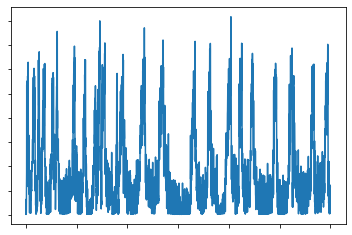

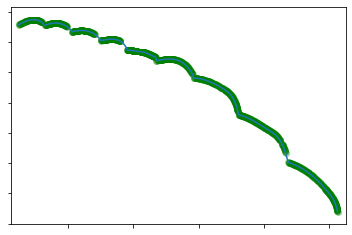

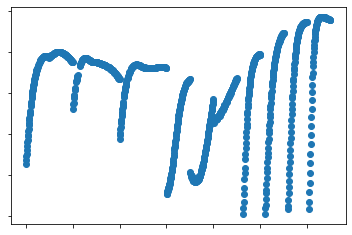

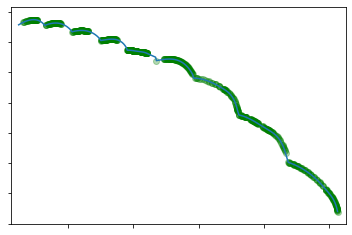

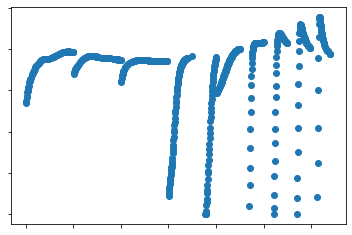

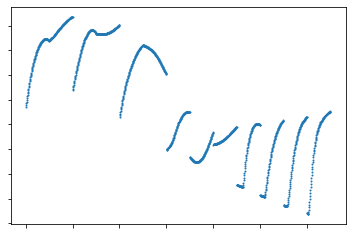

In [50]:
plt.plot(opt[0])

display(opt[1])
display(opt[2])

params = opt[1]['parameters']
bestCase = check_fit(params, min_vals, max_vals, tyrrelCurve, interior, tolerance=0.25)

params = opt[2]['parameters']
finalCase = check_fit(params, min_vals, max_vals, tyrrelCurve, interior, tolerance=0.25)


# Plot time progression
data = bestCase.copy()
time = np.array(data['time'])
time[time < 180] = time[time < 180] + 360
data['time'] = time

plt.figure()
plt.scatter(data['pointNumber'], data['time'],s=1)
plt.title("Time")

In [52]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/tyrrelFits.csv', index=False, encoding='utf-8')

In [92]:
opt

(array([0.05441459, 0.05916054, 0.07210173, ..., 0.06308174, 0.06465276,
        0.0756572 ]),
 {'loss': 0.032622635214811166, 'parameters': array([0.7995663 , 0.49080931])},
 {'loss': 0.07565719528529247, 'parameters': array([0.18595226, 0.07198766])},
 array([[0.05441459, 0.29055019, 0.18657021],
        [0.05916054, 0.24055019, 0.13657021],
        [0.07210173, 0.19612901, 0.09529881],
        ...,
        [0.06308174, 0.20995591, 0.09595542],
        [0.06465276, 0.20119125, 0.08720333],
        [0.0756572 , 0.19321854, 0.07924254]]))

#### Test with no phase

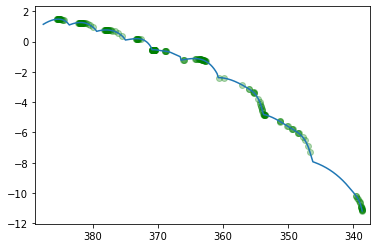

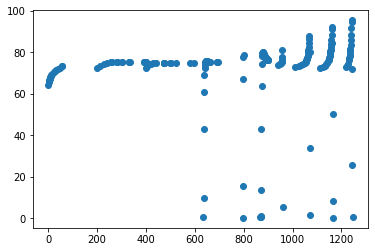

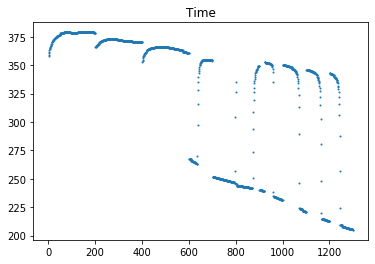

In [101]:
data = direct_fit(tyrrelCurve, 0.25)

### Alex

In [10]:
alex = pd.read_csv("./obsData/AlexLonLatCut.txt", header=None, sep=' ', names=['lon', 'lat'])
alex = alex.sort_values(['lon', 'lat'])

alex_arcs = [
    alex[0:26],
    alex[26:50],
    alex[50:]
]

alexCurve = createCycloidBezier(alex_arcs, maxError=0.01135)

plt.plot(alexCurve['lon'], alexCurve['lat'])
plt.scatter(alex['lon'], alex['lat'], color='purple', alpha=0.25)

In [19]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.76006373, 0.76072924]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    alexCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 0.0468736055460102 -- Moving Avg Loss: 0.0468736055460102
	Parameters used: [0.76006373, 0.76072924]
Iteration 2/3000 -- Loss Output: 0.0665538827157379 -- Moving Avg Loss: 0.056713744130874044
	Parameters used: [0.81006373 0.81072924]
Iteration 3/3000 -- Loss Output: 0.06896791545195334 -- Moving Avg Loss: 0.060798467904567145
	Parameters used: [0.8489545  0.84961858]
Iteration 4/3000 -- Loss Output: 0.1014677724503031 -- Moving Avg Loss: 0.07096579404100113
	Parameters used: [0.88378825 0.88445142]
Iteration 5/3000 -- Loss Output: 2.451946978773582 -- Moving Avg Loss: 0.5471620309875174
	Parameters used: [0.91839478 0.91905734]
Iteration 6/3000 -- Loss Output: 4.269384119471143 -- Moving Avg Loss: 1.1675323790681216
	Parameters used: [0.94720466 0.94786718]
Iteration 7/3000 -- Loss Output: 8.79833158761904 -- Moving Avg Loss: 2.257646551718253
	Parameters used: [0.97418548 0.97484801]
Iteration 8/3000 -- Loss Output: 6.798461573378 -- Moving Avg Loss:

Iteration 63/3000 -- Loss Output: 5.64602397623177 -- Moving Avg Loss: 4.396238006747868
	Parameters used: [0.17061034 0.69421276]
Iteration 64/3000 -- Loss Output: 7.521358561434617 -- Moving Avg Loss: 4.657346364117455
	Parameters used: [0.21286158 0.73219074]
Iteration 65/3000 -- Loss Output: 8.697540446432486 -- Moving Avg Loss: 4.949267792357052
	Parameters used: [0.25132825 0.76672687]
Iteration 66/3000 -- Loss Output: 7.474455055328836 -- Moving Avg Loss: 5.155279083539405
	Parameters used: [0.28636512 0.79814166]
Iteration 67/3000 -- Loss Output: 9.224312010879958 -- Moving Avg Loss: 5.463482088748583
	Parameters used: [0.31861056 0.82691783]
Iteration 68/3000 -- Loss Output: 5.607869643606865 -- Moving Avg Loss: 5.6343065967855
	Parameters used: [0.34830246 0.85328796]
Iteration 69/3000 -- Loss Output: 6.816676039872664 -- Moving Avg Loss: 5.863574278252449
	Parameters used: [0.37709711 0.87835006]
Iteration 70/3000 -- Loss Output: 9.676111160617163 -- Moving Avg Loss: 6.18305

Iteration 125/3000 -- Loss Output: 6.564389718896798 -- Moving Avg Loss: 3.3275189567820393
	Parameters used: [0.98779076 0.35951761]
Iteration 126/3000 -- Loss Output: 5.301337377085189 -- Moving Avg Loss: 3.466290684673971
	Parameters used: [0.00275399 0.37063769]
Iteration 127/3000 -- Loss Output: 9.712918228109638 -- Moving Avg Loss: 3.777887802484741
	Parameters used: [0.0162746  0.38085849]
Iteration 128/3000 -- Loss Output: 5.929372479200702 -- Moving Avg Loss: 3.899201762136536
	Parameters used: [0.0286843  0.39023434]
Iteration 129/3000 -- Loss Output: 6.9810807584743415 -- Moving Avg Loss: 4.110857445632107
	Parameters used: [0.04822436 0.40485549]
Iteration 130/3000 -- Loss Output: 9.324147798574932 -- Moving Avg Loss: 4.4150366596109905
	Parameters used: [0.06709009 0.41896396]
Iteration 131/3000 -- Loss Output: 8.842046786153304 -- Moving Avg Loss: 4.685536533510267
	Parameters used: [0.08654676 0.43350365]
Iteration 132/3000 -- Loss Output: 9.5907866916328 -- Moving Avg L

Iteration 186/3000 -- Loss Output: 0.07597512339498078 -- Moving Avg Loss: 0.05631736053369701
	Parameters used: [0.83303389 0.99601586]
Iteration 187/3000 -- Loss Output: 0.05236532362862164 -- Moving Avg Loss: 0.05701405109074402
	Parameters used: [0.83485683 0.99739045]
Iteration 188/3000 -- Loss Output: 0.051063355251880445 -- Moving Avg Loss: 0.05739762614465103
	Parameters used: [0.83650523 0.99863342]
Iteration 189/3000 -- Loss Output: 0.06736092145590805 -- Moving Avg Loss: 0.05790366005445576
	Parameters used: [0.8379937 0.9997558]
Iteration 190/3000 -- Loss Output: 0.0609402226011442 -- Moving Avg Loss: 0.058397847652753035
	Parameters used: [0.83933755 0.63448967]
Iteration 191/3000 -- Loss Output: 0.053607796864428535 -- Moving Avg Loss: 0.058437627830418115
	Parameters used: [0.8405527  0.63540431]
Iteration 192/3000 -- Loss Output: 0.07861709028202209 -- Moving Avg Loss: 0.05974464562086562
	Parameters used: [0.841651   0.63623099]
Iteration 193/3000 -- Loss Output: 0.055

Iteration 246/3000 -- Loss Output: 0.060760720480879084 -- Moving Avg Loss: 0.11339368358769077
	Parameters used: [0.86563348 0.65429947]
Iteration 247/3000 -- Loss Output: 0.2466886989166762 -- Moving Avg Loss: 0.12030478972051631
	Parameters used: [0.86596367 0.65454835]
Iteration 248/3000 -- Loss Output: 0.07209973517374625 -- Moving Avg Loss: 0.12052172279897605
	Parameters used: [0.86628317 0.65478918]
Iteration 249/3000 -- Loss Output: 0.07918698253864044 -- Moving Avg Loss: 0.1206276371845887
	Parameters used: [0.86673659 0.65513094]
Iteration 250/3000 -- Loss Output: 0.09557502334402015 -- Moving Avg Loss: 0.12195391942981594
	Parameters used: [0.86721627 0.65549249]
Iteration 251/3000 -- Loss Output: 0.24504140525060872 -- Moving Avg Loss: 0.12963815809029383
	Parameters used: [0.86772464 0.65587567]
Iteration 252/3000 -- Loss Output: 0.2650635986068493 -- Moving Avg Loss: 0.13779107933296292
	Parameters used: [0.86821547 0.65624562]
Iteration 253/3000 -- Loss Output: 0.179582

Iteration 307/3000 -- Loss Output: 3.4287961733388173 -- Moving Avg Loss: 6.271378991141396
	Parameters used: [0.53856175 0.25931133]
Iteration 308/3000 -- Loss Output: 1.470538784386471 -- Moving Avg Loss: 6.270331903385064
	Parameters used: [0.56748217 0.28088291]
Iteration 309/3000 -- Loss Output: 0.741571767950773 -- Moving Avg Loss: 6.187347987434757
	Parameters used: [0.59512929 0.30157626]
Iteration 310/3000 -- Loss Output: 0.6049496949176566 -- Moving Avg Loss: 6.152367482520929
	Parameters used: [0.62012455 0.32028734]
Iteration 311/3000 -- Loss Output: 1.5095156155334835 -- Moving Avg Loss: 6.065202255577853
	Parameters used: [0.64267696 0.3371703 ]
Iteration 312/3000 -- Loss Output: 0.0420997339515556 -- Moving Avg Loss: 5.915972917204208
	Parameters used: [0.66306875 0.352438  ]
Iteration 313/3000 -- Loss Output: 0.14247232789294698 -- Moving Avg Loss: 5.82184458385417
	Parameters used: [0.68145816 0.36620659]
Iteration 314/3000 -- Loss Output: 0.2730346690333939 -- Moving 

Iteration 368/3000 -- Loss Output: 0.5800466396316405 -- Moving Avg Loss: 0.7689825523954846
	Parameters used: [0.88689499 0.52089729]
Iteration 369/3000 -- Loss Output: 1.977246588435062 -- Moving Avg Loss: 0.8256916298715841
	Parameters used: [0.88931898 0.52275866]
Iteration 370/3000 -- Loss Output: 2.234426141284838 -- Moving Avg Loss: 0.9018892923031286
	Parameters used: [0.89155506 0.52447573]
Iteration 371/3000 -- Loss Output: 2.494301427696423 -- Moving Avg Loss: 0.9918593405958055
	Parameters used: [0.89552901 0.52752759]
Iteration 372/3000 -- Loss Output: 3.0074787041577125 -- Moving Avg Loss: 1.0911283071355344
	Parameters used: [0.89944876 0.5305378 ]
Iteration 373/3000 -- Loss Output: 2.3262709443931637 -- Moving Avg Loss: 1.149323762765993
	Parameters used: [0.90938318 0.53817489]
Iteration 374/3000 -- Loss Output: 2.953957053848674 -- Moving Avg Loss: 1.256377955435888
	Parameters used: [0.92017768 0.54647242]
Iteration 375/3000 -- Loss Output: 4.889561102809295 -- Movin

Iteration 430/3000 -- Loss Output: 8.109743612532656 -- Moving Avg Loss: 5.703755484348855
	Parameters used: [0.96059503 0.88176926]
Iteration 431/3000 -- Loss Output: 9.416527772767168 -- Moving Avg Loss: 5.926117392266108
	Parameters used: [0.99697372 0.91666758]
Iteration 432/3000 -- Loss Output: 9.432062321611435 -- Moving Avg Loss: 6.126323835774091
	Parameters used: [0.03317328 0.95104179]
Iteration 433/3000 -- Loss Output: 11.360158562638 -- Moving Avg Loss: 6.267629333606148
	Parameters used: [0.06578364 0.98238489]
Iteration 434/3000 -- Loss Output: 12.85558884859221 -- Moving Avg Loss: 6.391241759212545
	Parameters used: [0.09548859 0.85918169]
Iteration 435/3000 -- Loss Output: 4.2367547616239545 -- Moving Avg Loss: 6.152770178048238
	Parameters used: [0.1222601  0.88488354]
Iteration 436/3000 -- Loss Output: 7.299687824944115 -- Moving Avg Loss: 6.244002576652868
	Parameters used: [0.14702836 0.90859469]
Iteration 437/3000 -- Loss Output: 4.366259047408535 -- Moving Avg Los

Iteration 492/3000 -- Loss Output: 0.9452660526617753 -- Moving Avg Loss: 1.7682648135918881
	Parameters used: [0.60071877 0.41254983]
Iteration 493/3000 -- Loss Output: 0.06791989714966594 -- Moving Avg Loss: 1.6091564262954545
	Parameters used: [0.60219811 0.41389082]
Iteration 494/3000 -- Loss Output: 1.0557159219751564 -- Moving Avg Loss: 1.4662816803785614
	Parameters used: [0.6035476 0.4151141]
Iteration 495/3000 -- Loss Output: 0.12039754872590103 -- Moving Avg Loss: 1.327166469021293
	Parameters used: [0.60476912 0.41622136]
Iteration 496/3000 -- Loss Output: 2.039875005850046 -- Moving Avg Loss: 1.2668301100017856
	Parameters used: [0.6058803 0.4172286]
Iteration 497/3000 -- Loss Output: 1.369900575003838 -- Moving Avg Loss: 1.1775910692847924
	Parameters used: [0.6069514  0.41819945]
Iteration 498/3000 -- Loss Output: 0.7382932954157483 -- Moving Avg Loss: 1.1245787030825505
	Parameters used: [0.64726565 0.45524513]
Iteration 499/3000 -- Loss Output: 0.05168192521984885 -- Mo

Iteration 554/3000 -- Loss Output: 3.6166371468015552 -- Moving Avg Loss: 6.612526456509975
	Parameters used: [0.49963871 0.44130173]
Iteration 555/3000 -- Loss Output: 2.7038779372958133 -- Moving Avg Loss: 6.468476947993278
	Parameters used: [0.51143164 0.45208688]
Iteration 556/3000 -- Loss Output: 3.428328733916456 -- Moving Avg Loss: 6.49585342661449
	Parameters used: [0.5222652  0.46199453]
Iteration 557/3000 -- Loss Output: 3.268624672678934 -- Moving Avg Loss: 6.495152308856095
	Parameters used: [0.53203821 0.47093225]
Iteration 558/3000 -- Loss Output: 3.2040892380974064 -- Moving Avg Loss: 6.313920361965447
	Parameters used: [0.54103791 0.47916264]
Iteration 559/3000 -- Loss Output: 0.6011538480706641 -- Moving Avg Loss: 6.118929947105158
	Parameters used: [0.54920761 0.48663394]
Iteration 560/3000 -- Loss Output: 2.1353689568701824 -- Moving Avg Loss: 5.894269237653598
	Parameters used: [0.55659374 0.49338864]
Iteration 561/3000 -- Loss Output: 2.0008108834997516 -- Moving A

Iteration 615/3000 -- Loss Output: 0.14246526489589792 -- Moving Avg Loss: 0.32646375091451824
	Parameters used: [0.64520131 0.57441182]
Iteration 616/3000 -- Loss Output: 0.0771777923755214 -- Moving Avg Loss: 0.3203882925979691
	Parameters used: [0.64558736 0.57476475]
Iteration 617/3000 -- Loss Output: 0.05156602029672469 -- Moving Avg Loss: 0.30957601655563616
	Parameters used: [0.64593845 0.57508572]
Iteration 618/3000 -- Loss Output: 0.6183923256275831 -- Moving Avg Loss: 0.3208823528579688
	Parameters used: [0.64627367 0.57539219]
Iteration 619/3000 -- Loss Output: 0.0490046143573722 -- Moving Avg Loss: 0.3104188604498923
	Parameters used: [0.64669168 0.57577434]
Iteration 620/3000 -- Loss Output: 0.4668487004253255 -- Moving Avg Loss: 0.3211203110289052
	Parameters used: [0.64709501 0.57614307]
Iteration 621/3000 -- Loss Output: 0.057352834400394334 -- Moving Avg Loss: 0.3200745331181043
	Parameters used: [0.64751482 0.57652687]
Iteration 622/3000 -- Loss Output: 0.334385645304

Iteration 675/3000 -- Loss Output: 0.04658647652728911 -- Moving Avg Loss: 0.048582366877625446
	Parameters used: [0.74023136 0.6613282 ]
Iteration 676/3000 -- Loss Output: 0.05366991695940589 -- Moving Avg Loss: 0.04831578533799093
	Parameters used: [0.7405867  0.66165313]
Iteration 677/3000 -- Loss Output: 0.04444312032386032 -- Moving Avg Loss: 0.04793643115285322
	Parameters used: [0.74090845 0.66194734]
Iteration 678/3000 -- Loss Output: 0.040650144139731455 -- Moving Avg Loss: 0.04739573762937015
	Parameters used: [0.74120407 0.66221766]
Iteration 679/3000 -- Loss Output: 0.043085083617008836 -- Moving Avg Loss: 0.047421253973603646
	Parameters used: [0.74148623 0.66247567]
Iteration 680/3000 -- Loss Output: 0.059529377044996314 -- Moving Avg Loss: 0.047517997201517684
	Parameters used: [0.74174268 0.66271018]
Iteration 681/3000 -- Loss Output: 0.058342170270208174 -- Moving Avg Loss: 0.04796047578061183
	Parameters used: [0.74197648 0.66292397]
Iteration 682/3000 -- Loss Output:

Iteration 735/3000 -- Loss Output: 0.0551881402330201 -- Moving Avg Loss: 0.047359835483971546
	Parameters used: [0.74936814 0.66968313]
Iteration 736/3000 -- Loss Output: 0.0456559672967844 -- Moving Avg Loss: 0.04678344151773109
	Parameters used: [0.7495221  0.66982392]
Iteration 737/3000 -- Loss Output: 0.04384472480943142 -- Moving Avg Loss: 0.04646741483150549
	Parameters used: [0.74968152 0.66996969]
Iteration 738/3000 -- Loss Output: 0.059369953085457144 -- Moving Avg Loss: 0.04760520954135524
	Parameters used: [0.74982785 0.67010351]
Iteration 739/3000 -- Loss Output: 0.05677390668242474 -- Moving Avg Loss: 0.04788093228910923
	Parameters used: [0.74996031 0.67022464]
Iteration 740/3000 -- Loss Output: 0.04509792669485033 -- Moving Avg Loss: 0.04786880198685463
	Parameters used: [0.75011982 0.67037049]
Iteration 741/3000 -- Loss Output: 0.0463277260379263 -- Moving Avg Loss: 0.04805086177796504
	Parameters used: [0.75027353 0.67051105]
Iteration 742/3000 -- Loss Output: 0.03782

Iteration 795/3000 -- Loss Output: 0.051237358738798 -- Moving Avg Loss: 0.04993397332888059
	Parameters used: [0.77264937 0.69097283]
Iteration 796/3000 -- Loss Output: 0.055785474654963293 -- Moving Avg Loss: 0.05027785605613265
	Parameters used: [0.77384099 0.69206253]
Iteration 797/3000 -- Loss Output: 0.05170900804953624 -- Moving Avg Loss: 0.05068505258962944
	Parameters used: [0.7749159 0.6930455]
Iteration 798/3000 -- Loss Output: 0.03709293569104439 -- Moving Avg Loss: 0.050187133126818495
	Parameters used: [0.77588452 0.69393127]
Iteration 799/3000 -- Loss Output: 0.04865926469378866 -- Moving Avg Loss: 0.05010416611971366
	Parameters used: [0.776758   0.69473004]
Iteration 800/3000 -- Loss Output: 0.044883499889562556 -- Moving Avg Loss: 0.04961493438674291
	Parameters used: [0.77754831 0.69545275]
Iteration 801/3000 -- Loss Output: 0.04401265988266316 -- Moving Avg Loss: 0.04931935721614672
	Parameters used: [0.77826087 0.69610437]
Iteration 802/3000 -- Loss Output: 0.05341

Iteration 855/3000 -- Loss Output: 0.04642903592336754 -- Moving Avg Loss: 0.05074690223126981
	Parameters used: [0.78960259 0.70647592]
Iteration 856/3000 -- Loss Output: 0.048825494677761073 -- Moving Avg Loss: 0.050815117359555545
	Parameters used: [0.78975946 0.70661937]
Iteration 857/3000 -- Loss Output: 0.039667210617893404 -- Moving Avg Loss: 0.050085254655836166
	Parameters used: [0.78991111 0.70675804]
Iteration 858/3000 -- Loss Output: 0.05256844898565989 -- Moving Avg Loss: 0.04976345244008203
	Parameters used: [0.79011062 0.70694048]
Iteration 859/3000 -- Loss Output: 0.06217087950519441 -- Moving Avg Loss: 0.05006440389319169
	Parameters used: [0.79029006 0.70710457]
Iteration 860/3000 -- Loss Output: 0.04871030387215223 -- Moving Avg Loss: 0.04971753191672665
	Parameters used: [0.79045053 0.70725132]
Iteration 861/3000 -- Loss Output: 0.05445475377641749 -- Moving Avg Loss: 0.05004958457936535
	Parameters used: [0.79060501 0.70739258]
Iteration 862/3000 -- Loss Output: 0.

Iteration 915/3000 -- Loss Output: 0.05220776655057075 -- Moving Avg Loss: 0.05166987822118228
	Parameters used: [0.79872935 0.71482189]
Iteration 916/3000 -- Loss Output: 0.04658010029784104 -- Moving Avg Loss: 0.05150184823814491
	Parameters used: [0.79890033 0.71497825]
Iteration 917/3000 -- Loss Output: 0.04254692405726283 -- Moving Avg Loss: 0.050957622417197965
	Parameters used: [0.79905666 0.71512121]
Iteration 918/3000 -- Loss Output: 0.06064183849827001 -- Moving Avg Loss: 0.05157519000057827
	Parameters used: [0.79920714 0.71525881]
Iteration 919/3000 -- Loss Output: 0.046704222200427296 -- Moving Avg Loss: 0.05170110439516886
	Parameters used: [0.79934082 0.71538106]
Iteration 920/3000 -- Loss Output: 0.05947631161047635 -- Moving Avg Loss: 0.05201223298623642
	Parameters used: [0.79951601 0.71554126]
Iteration 921/3000 -- Loss Output: 0.04038153589895692 -- Moving Avg Loss: 0.05160205305952434
	Parameters used: [0.79967343 0.71568521]
Iteration 922/3000 -- Loss Output: 0.05

Iteration 975/3000 -- Loss Output: 0.06607042078280286 -- Moving Avg Loss: 0.05395553639295678
	Parameters used: [0.8127438  0.72763744]
Iteration 976/3000 -- Loss Output: 0.041525189553662925 -- Moving Avg Loss: 0.05341101961604895
	Parameters used: [0.8129726  0.72784666]
Iteration 977/3000 -- Loss Output: 0.050858086146474815 -- Moving Avg Loss: 0.052779602693810476
	Parameters used: [0.81340008 0.72823758]
Iteration 978/3000 -- Loss Output: 0.05778244964458491 -- Moving Avg Loss: 0.05289454304303777
	Parameters used: [0.81380745 0.7286101 ]
Iteration 979/3000 -- Loss Output: 0.069448428934124 -- Moving Avg Loss: 0.05330655336256058
	Parameters used: [0.81417708 0.7289481 ]
Iteration 980/3000 -- Loss Output: 0.061770045134044535 -- Moving Avg Loss: 0.05323912864427715
	Parameters used: [0.8145114  0.72925383]
Iteration 981/3000 -- Loss Output: 0.05464995242367605 -- Moving Avg Loss: 0.05346285788247766
	Parameters used: [0.814815   0.72953146]
Iteration 982/3000 -- Loss Output: 0.06

Iteration 1035/3000 -- Loss Output: 0.06353924178672372 -- Moving Avg Loss: 0.05641771050524043
	Parameters used: [0.82481853 0.7386792 ]
Iteration 1036/3000 -- Loss Output: 0.0649416562884734 -- Moving Avg Loss: 0.057447945152633795
	Parameters used: [0.82498168 0.7388284 ]
Iteration 1037/3000 -- Loss Output: 0.07370191795025943 -- Moving Avg Loss: 0.05794927965860995
	Parameters used: [0.82513456 0.7389682 ]
Iteration 1038/3000 -- Loss Output: 0.05628936661665014 -- Moving Avg Loss: 0.05830790104044804
	Parameters used: [0.8252815  0.73910257]
Iteration 1039/3000 -- Loss Output: 0.06837889581907855 -- Moving Avg Loss: 0.05885708318564415
	Parameters used: [0.8254222  0.73923123]
Iteration 1040/3000 -- Loss Output: 0.056583644807927894 -- Moving Avg Loss: 0.05856917000868335
	Parameters used: [0.82556678 0.73936344]
Iteration 1041/3000 -- Loss Output: 0.04704275985395753 -- Moving Avg Loss: 0.05868483323281819
	Parameters used: [0.82573786 0.73951989]
Iteration 1042/3000 -- Loss Outpu

Iteration 1095/3000 -- Loss Output: 0.07197132947654523 -- Moving Avg Loss: 0.06120184907251693
	Parameters used: [0.83843108 0.75112724]
Iteration 1096/3000 -- Loss Output: 0.07599504227122761 -- Moving Avg Loss: 0.06165689795155385
	Parameters used: [0.83871548 0.75138731]
Iteration 1097/3000 -- Loss Output: 0.051831241055498925 -- Moving Avg Loss: 0.06151177582500293
	Parameters used: [0.83899185 0.75164004]
Iteration 1098/3000 -- Loss Output: 0.08069203666879139 -- Moving Avg Loss: 0.0622080511524632
	Parameters used: [0.83924528 0.75187178]
Iteration 1099/3000 -- Loss Output: 0.05244371798000571 -- Moving Avg Loss: 0.06134168413845194
	Parameters used: [0.83948497 0.75209097]
Iteration 1100/3000 -- Loss Output: 0.05264495907376594 -- Moving Avg Loss: 0.06067609247631282
	Parameters used: [0.83970731 0.75229429]
Iteration 1101/3000 -- Loss Output: 0.07346247757659642 -- Moving Avg Loss: 0.06108142673500451
	Parameters used: [0.83990968 0.75247935]
Iteration 1102/3000 -- Loss Output

Iteration 1155/3000 -- Loss Output: 0.05828457736743074 -- Moving Avg Loss: 0.06170379684890295
	Parameters used: [0.84932484 0.76108907]
Iteration 1156/3000 -- Loss Output: 0.06633859754915526 -- Moving Avg Loss: 0.06118448079019067
	Parameters used: [0.84952497 0.76127208]
Iteration 1157/3000 -- Loss Output: 0.06514734477227119 -- Moving Avg Loss: 0.06156564954246972
	Parameters used: [0.84971867 0.76144921]
Iteration 1158/3000 -- Loss Output: 0.06362200780617527 -- Moving Avg Loss: 0.061756841386592674
	Parameters used: [0.84995264 0.76166317]
Iteration 1159/3000 -- Loss Output: 0.05650383741184219 -- Moving Avg Loss: 0.06102133019249079
	Parameters used: [0.85016508 0.76185743]
Iteration 1160/3000 -- Loss Output: 0.07251091483670655 -- Moving Avg Loss: 0.06203426432666499
	Parameters used: [0.8503807  0.76205461]
Iteration 1161/3000 -- Loss Output: 0.06708119582697449 -- Moving Avg Loss: 0.062051692619726116
	Parameters used: [0.85058712 0.76224337]
Iteration 1162/3000 -- Loss Outp

Iteration 1215/3000 -- Loss Output: 0.0675813853575471 -- Moving Avg Loss: 0.07034254505718962
	Parameters used: [0.86393123 0.77444593]
Iteration 1216/3000 -- Loss Output: 0.06977257097002076 -- Moving Avg Loss: 0.06998823673426276
	Parameters used: [0.86414304 0.77463962]
Iteration 1217/3000 -- Loss Output: 0.06490373884405831 -- Moving Avg Loss: 0.0701295446276271
	Parameters used: [0.86435449 0.77483298]
Iteration 1218/3000 -- Loss Output: 0.07528355948355826 -- Moving Avg Loss: 0.07026894927931142
	Parameters used: [0.86455282 0.77501434]
Iteration 1219/3000 -- Loss Output: 0.08238801923867171 -- Moving Avg Loss: 0.07045136429453919
	Parameters used: [0.86473793 0.77518362]
Iteration 1220/3000 -- Loss Output: 0.06114166098842759 -- Moving Avg Loss: 0.06977092371364133
	Parameters used: [0.8649283  0.77535771]
Iteration 1221/3000 -- Loss Output: 0.08644260532313822 -- Moving Avg Loss: 0.06990596997563772
	Parameters used: [0.8651316  0.77554361]
Iteration 1222/3000 -- Loss Output: 

Iteration 1275/3000 -- Loss Output: 0.10668345893318043 -- Moving Avg Loss: 0.0741313704716956
	Parameters used: [0.88181709 0.79080173]
Iteration 1276/3000 -- Loss Output: 0.09933278976834144 -- Moving Avg Loss: 0.07521092473059494
	Parameters used: [0.88232512 0.79126629]
Iteration 1277/3000 -- Loss Output: 0.07856381023277603 -- Moving Avg Loss: 0.07576238020163957
	Parameters used: [0.882796   0.79169689]
Iteration 1278/3000 -- Loss Output: 0.14264378376815323 -- Moving Avg Loss: 0.07881762361494238
	Parameters used: [0.88325276 0.79211458]
Iteration 1279/3000 -- Loss Output: 0.06272304177026787 -- Moving Avg Loss: 0.07830543646232395
	Parameters used: [0.88370938 0.79253214]
Iteration 1280/3000 -- Loss Output: 0.054430634789225635 -- Moving Avg Loss: 0.07671773570784732
	Parameters used: [0.88414867 0.79293385]
Iteration 1281/3000 -- Loss Output: 0.1134602250152426 -- Moving Avg Loss: 0.07871378112106178
	Parameters used: [0.88455408 0.79330458]
Iteration 1282/3000 -- Loss Output:

Iteration 1336/3000 -- Loss Output: 1.3990602637610328 -- Moving Avg Loss: 6.5704012481054495
	Parameters used: [0.50692137 0.84245494]
Iteration 1337/3000 -- Loss Output: 0.12420209672466702 -- Moving Avg Loss: 6.503539255991281
	Parameters used: [0.60650442 0.94184664]
Iteration 1338/3000 -- Loss Output: 0.048647198408225366 -- Moving Avg Loss: 6.449518008517093
	Parameters used: [0.69619008 0.52111556]
Iteration 1339/3000 -- Loss Output: 0.047568376854214195 -- Moving Avg Loss: 6.380752990958079
	Parameters used: [0.77696193 0.60173219]
Iteration 1340/3000 -- Loss Output: 0.07396283182805784 -- Moving Avg Loss: 6.366556290893934
	Parameters used: [0.84970589 0.67433636]
Iteration 1341/3000 -- Loss Output: 1.41124982530515 -- Moving Avg Loss: 6.339370506272264
	Parameters used: [0.91521984 0.73972441]
Iteration 1342/3000 -- Loss Output: 7.455712491932137 -- Moving Avg Loss: 6.497635361115291
	Parameters used: [0.97422286 0.79861403]
Iteration 1343/3000 -- Loss Output: 11.653668880316

Iteration 1397/3000 -- Loss Output: 0.07474205363506047 -- Moving Avg Loss: 0.6311986276527751
	Parameters used: [0.60410432 0.74749135]
Iteration 1398/3000 -- Loss Output: 0.07470098413475362 -- Moving Avg Loss: 0.5676172554167916
	Parameters used: [0.60528682 0.74864955]
Iteration 1399/3000 -- Loss Output: 0.2892399537059263 -- Moving Avg Loss: 0.574843646038007
	Parameters used: [0.60636165 0.74970229]
Iteration 1400/3000 -- Loss Output: 0.06969606651676835 -- Moving Avg Loss: 0.5359251904518265
	Parameters used: [0.60733134 0.75065206]
Iteration 1401/3000 -- Loss Output: 0.6184310593536921 -- Moving Avg Loss: 0.5228062382580455
	Parameters used: [0.60820998 0.75151264]
Iteration 1402/3000 -- Loss Output: 0.5339371740507791 -- Moving Avg Loss: 0.517064932360099
	Parameters used: [0.60900447 0.7522908 ]
Iteration 1403/3000 -- Loss Output: 0.05885544137210856 -- Moving Avg Loss: 0.5090508975898586
	Parameters used: [0.60972859 0.75300005]
Iteration 1404/3000 -- Loss Output: 0.78684509

Iteration 1457/3000 -- Loss Output: 0.06094135473562934 -- Moving Avg Loss: 0.13330587926705023
	Parameters used: [0.6571529  0.79945216]
Iteration 1458/3000 -- Loss Output: 0.04379249433074585 -- Moving Avg Loss: 0.13229093441969914
	Parameters used: [0.6573472  0.79964248]
Iteration 1459/3000 -- Loss Output: 0.057764400395572 -- Moving Avg Loss: 0.13199292533112822
	Parameters used: [0.65752353 0.79981519]
Iteration 1460/3000 -- Loss Output: 0.06229121624924495 -- Moving Avg Loss: 0.1316001675196079
	Parameters used: [0.6577705 0.8000571]
Iteration 1461/3000 -- Loss Output: 0.046123626407735534 -- Moving Avg Loss: 0.131827312990207
	Parameters used: [0.657994   0.80027601]
Iteration 1462/3000 -- Loss Output: 0.041183821269453094 -- Moving Avg Loss: 0.09495876258355397
	Parameters used: [0.65820413 0.80048183]
Iteration 1463/3000 -- Loss Output: 0.04523274856663303 -- Moving Avg Loss: 0.0583864912919041
	Parameters used: [0.65839402 0.80066783]
Iteration 1464/3000 -- Loss Output: 0.05

Iteration 1517/3000 -- Loss Output: 0.05796495196586255 -- Moving Avg Loss: 0.0873226170763915
	Parameters used: [0.66729601 0.80938727]
Iteration 1518/3000 -- Loss Output: 0.05719379730501009 -- Moving Avg Loss: 0.08808909924110925
	Parameters used: [0.66739605 0.80948526]
Iteration 1519/3000 -- Loss Output: 0.9898215194158682 -- Moving Avg Loss: 0.12559277289554766
	Parameters used: [0.66749408 0.80958129]
Iteration 1520/3000 -- Loss Output: 0.8239725983551597 -- Moving Avg Loss: 0.1564229118000924
	Parameters used: [0.66773318 0.80981548]
Iteration 1521/3000 -- Loss Output: 0.049042386366379795 -- Moving Avg Loss: 0.15621866759441366
	Parameters used: [0.66799805 0.81007492]
Iteration 1522/3000 -- Loss Output: 0.07769089867515391 -- Moving Avg Loss: 0.15696306865248333
	Parameters used: [0.66823912 0.81031105]
Iteration 1523/3000 -- Loss Output: 0.05858760680882748 -- Moving Avg Loss: 0.15636383000866627
	Parameters used: [0.66845615 0.81052363]
Iteration 1524/3000 -- Loss Output: 0

Iteration 1577/3000 -- Loss Output: 0.05543957583814244 -- Moving Avg Loss: 0.057094955172207786
	Parameters used: [0.67354772 0.81551078]
Iteration 1578/3000 -- Loss Output: 0.05812291700618905 -- Moving Avg Loss: 0.05767357249858276
	Parameters used: [0.67362423 0.81558573]
Iteration 1579/3000 -- Loss Output: 0.05326646998995433 -- Moving Avg Loss: 0.057476701693437306
	Parameters used: [0.67369738 0.81565738]
Iteration 1580/3000 -- Loss Output: 0.06167520790095991 -- Moving Avg Loss: 0.05743641992850244
	Parameters used: [0.67376741 0.81572597]
Iteration 1581/3000 -- Loss Output: 0.050813887058717346 -- Moving Avg Loss: 0.056899549605001855
	Parameters used: [0.67383441 0.8157916 ]
Iteration 1582/3000 -- Loss Output: 0.04323966007554511 -- Moving Avg Loss: 0.05617995607997454
	Parameters used: [0.6738965  0.81585242]
Iteration 1583/3000 -- Loss Output: 0.03671150717101916 -- Moving Avg Loss: 0.055072443601580895
	Parameters used: [0.67400161 0.81595537]
Iteration 1584/3000 -- Loss O

Iteration 1637/3000 -- Loss Output: 0.06211950843601514 -- Moving Avg Loss: 0.08478083147133214
	Parameters used: [0.68485689 0.82658805]
Iteration 1638/3000 -- Loss Output: 0.04913612681215255 -- Moving Avg Loss: 0.0714606555538386
	Parameters used: [0.68502904 0.82675667]
Iteration 1639/3000 -- Loss Output: 0.04451881968654111 -- Moving Avg Loss: 0.07091199847396544
	Parameters used: [0.68527123 0.8269939 ]
Iteration 1640/3000 -- Loss Output: 0.05484062879269946 -- Moving Avg Loss: 0.0711052597881829
	Parameters used: [0.6855047  0.82722258]
Iteration 1641/3000 -- Loss Output: 0.054901241517192244 -- Moving Avg Loss: 0.07082850112406719
	Parameters used: [0.68571676 0.8274303 ]
Iteration 1642/3000 -- Loss Output: 0.054751232842758395 -- Moving Avg Loss: 0.07081317001584335
	Parameters used: [0.68591236 0.82762188]
Iteration 1643/3000 -- Loss Output: 0.06823579132716938 -- Moving Avg Loss: 0.07132088874552417
	Parameters used: [0.68608922 0.82779511]
Iteration 1644/3000 -- Loss Output

Iteration 1697/3000 -- Loss Output: 0.05374472179308322 -- Moving Avg Loss: 0.09300977380061477
	Parameters used: [0.69827044 0.83972656]
Iteration 1698/3000 -- Loss Output: 0.05712756870704367 -- Moving Avg Loss: 0.06886184002603785
	Parameters used: [0.69840453 0.83985789]
Iteration 1699/3000 -- Loss Output: 0.06525195966265833 -- Moving Avg Loss: 0.0697526829728581
	Parameters used: [0.69852884 0.83997966]
Iteration 1700/3000 -- Loss Output: 0.056399349743024935 -- Moving Avg Loss: 0.05222313877503768
	Parameters used: [0.69864063 0.84008915]
Iteration 1701/3000 -- Loss Output: 0.039240540995299514 -- Moving Avg Loss: 0.052340291040761856
	Parameters used: [0.69874331 0.84018972]
Iteration 1702/3000 -- Loss Output: 0.06473736327529572 -- Moving Avg Loss: 0.052946371477606675
	Parameters used: [0.69886878 0.84031262]
Iteration 1703/3000 -- Loss Output: 0.052841419831850533 -- Moving Avg Loss: 0.052913581068080404
	Parameters used: [0.69898175 0.84042328]
Iteration 1704/3000 -- Loss O

Iteration 1757/3000 -- Loss Output: 0.05785385491315308 -- Moving Avg Loss: 0.07069800407813195
	Parameters used: [0.70465396 0.84597917]
Iteration 1758/3000 -- Loss Output: 0.04489225528833737 -- Moving Avg Loss: 0.06986056843235994
	Parameters used: [0.70476548 0.84608841]
Iteration 1759/3000 -- Loss Output: 0.04722150636944187 -- Moving Avg Loss: 0.06983136078148396
	Parameters used: [0.70486825 0.84618906]
Iteration 1760/3000 -- Loss Output: 0.05655166752192024 -- Moving Avg Loss: 0.06981008407250257
	Parameters used: [0.70496177 0.84628067]
Iteration 1761/3000 -- Loss Output: 0.04270615048639964 -- Moving Avg Loss: 0.0698817440351935
	Parameters used: [0.70504847 0.84636559]
Iteration 1762/3000 -- Loss Output: 0.05361878935496746 -- Moving Avg Loss: 0.06352889771600713
	Parameters used: [0.70512907 0.84644454]
Iteration 1763/3000 -- Loss Output: 0.05201198576933966 -- Moving Avg Loss: 0.0639866006286563
	Parameters used: [0.70520324 0.84651719]
Iteration 1764/3000 -- Loss Output: 

Iteration 1817/3000 -- Loss Output: 0.038080362731030944 -- Moving Avg Loss: 0.05436327503422932
	Parameters used: [0.71176    0.85293949]
Iteration 1818/3000 -- Loss Output: 0.050491166658257314 -- Moving Avg Loss: 0.054048076171963694
	Parameters used: [0.71184649 0.85302421]
Iteration 1819/3000 -- Loss Output: 0.05985112303625843 -- Moving Avg Loss: 0.054610957742228926
	Parameters used: [0.71192801 0.85310407]
Iteration 1820/3000 -- Loss Output: 0.05050334765738406 -- Moving Avg Loss: 0.05485648021900648
	Parameters used: [0.7120021  0.85317663]
Iteration 1821/3000 -- Loss Output: 0.05057656013620988 -- Moving Avg Loss: 0.0549014885993614
	Parameters used: [0.71207717 0.85325017]
Iteration 1822/3000 -- Loss Output: 0.05914554613198831 -- Moving Avg Loss: 0.05488380253216075
	Parameters used: [0.71214725 0.85331881]
Iteration 1823/3000 -- Loss Output: 0.036615269473969404 -- Moving Avg Loss: 0.05531547704057244
	Parameters used: [0.7122336  0.85340339]
Iteration 1824/3000 -- Loss Ou

Iteration 1877/3000 -- Loss Output: 0.04188242699917535 -- Moving Avg Loss: 0.048027918566033154
	Parameters used: [0.7188078  0.85984278]
Iteration 1878/3000 -- Loss Output: 0.03943051225381518 -- Moving Avg Loss: 0.048089838208618986
	Parameters used: [0.71889118 0.85992445]
Iteration 1879/3000 -- Loss Output: 0.04718016660226263 -- Moving Avg Loss: 0.0481412609056709
	Parameters used: [0.71898577 0.8600171 ]
Iteration 1880/3000 -- Loss Output: 0.032125488828786145 -- Moving Avg Loss: 0.04790832708061936
	Parameters used: [0.71907207 0.86010163]
Iteration 1881/3000 -- Loss Output: 0.04991871102897927 -- Moving Avg Loss: 0.04781307556880785
	Parameters used: [0.71915518 0.86018304]
Iteration 1882/3000 -- Loss Output: 0.046303607191496905 -- Moving Avg Loss: 0.04760021558880464
	Parameters used: [0.71923103 0.86025733]
Iteration 1883/3000 -- Loss Output: 0.04429558246664976 -- Moving Avg Loss: 0.047102707939965044
	Parameters used: [0.71930208 0.86032692]
Iteration 1884/3000 -- Loss Ou

Iteration 1937/3000 -- Loss Output: 0.0484795175159894 -- Moving Avg Loss: 0.046855835696805535
	Parameters used: [0.72472293 0.86563661]
Iteration 1938/3000 -- Loss Output: 0.048448861085527366 -- Moving Avg Loss: 0.046996956252752506
	Parameters used: [0.72479423 0.86570645]
Iteration 1939/3000 -- Loss Output: 0.038251601937217446 -- Moving Avg Loss: 0.04651943646331472
	Parameters used: [0.72501436 0.86592208]
Iteration 1940/3000 -- Loss Output: 0.052622674335765396 -- Moving Avg Loss: 0.04666758780295179
	Parameters used: [0.72521486 0.86611846]
Iteration 1941/3000 -- Loss Output: 0.059778202759663224 -- Moving Avg Loss: 0.0472798132327178
	Parameters used: [0.72539596 0.86629585]
Iteration 1942/3000 -- Loss Output: 0.04260849523336831 -- Moving Avg Loss: 0.04691683726452849
	Parameters used: [0.72555946 0.866456  ]
Iteration 1943/3000 -- Loss Output: 0.03619863788264128 -- Moving Avg Loss: 0.04660218633830225
	Parameters used: [0.72571016 0.86660361]
Iteration 1944/3000 -- Loss Ou

Iteration 1997/3000 -- Loss Output: 0.05340992899622242 -- Moving Avg Loss: 0.04660014920474415
	Parameters used: [0.73035411 0.87115233]
Iteration 1998/3000 -- Loss Output: 0.044336675494095285 -- Moving Avg Loss: 0.04643354748394289
	Parameters used: [0.73044491 0.87124126]
Iteration 1999/3000 -- Loss Output: 0.045616671664405764 -- Moving Avg Loss: 0.0462730379730681
	Parameters used: [0.73054061 0.871335  ]
Iteration 2000/3000 -- Loss Output: 0.05185934772978184 -- Moving Avg Loss: 0.046157699563950966
	Parameters used: [0.73062867 0.87142126]
Iteration 2001/3000 -- Loss Output: 0.051815066814366095 -- Moving Avg Loss: 0.04629392623880293
	Parameters used: [0.73071584 0.87150664]
Iteration 2002/3000 -- Loss Output: 0.03807246511729833 -- Moving Avg Loss: 0.04584070237828444
	Parameters used: [0.73080669 0.87159563]
Iteration 2003/3000 -- Loss Output: 0.04973760349149067 -- Moving Avg Loss: 0.046182127740557896
	Parameters used: [0.73090419 0.87169112]
Iteration 2004/3000 -- Loss Ou

Iteration 2057/3000 -- Loss Output: 0.042801495178543494 -- Moving Avg Loss: 0.04614502806431615
	Parameters used: [0.73716692 0.87782543]
Iteration 2058/3000 -- Loss Output: 0.04820339985187679 -- Moving Avg Loss: 0.04610296671203799
	Parameters used: [0.73724319 0.87790014]
Iteration 2059/3000 -- Loss Output: 0.05159056159324909 -- Moving Avg Loss: 0.046617347688280804
	Parameters used: [0.73731344 0.87796895]
Iteration 2060/3000 -- Loss Output: 0.031842527537517915 -- Moving Avg Loss: 0.04621068079960814
	Parameters used: [0.73737648 0.8780307 ]
Iteration 2061/3000 -- Loss Output: 0.041776282606797326 -- Moving Avg Loss: 0.04581046338823728
	Parameters used: [0.73744069 0.87809359]
Iteration 2062/3000 -- Loss Output: 0.04531316055969961 -- Moving Avg Loss: 0.04585807154910754
	Parameters used: [0.73749796 0.87814969]
Iteration 2063/3000 -- Loss Output: 0.039052591467261415 -- Moving Avg Loss: 0.04549208553471872
	Parameters used: [0.73756334 0.87821373]
Iteration 2064/3000 -- Loss O

Iteration 2117/3000 -- Loss Output: 0.04396354209183297 -- Moving Avg Loss: 0.04618891716163393
	Parameters used: [0.7441487  0.88466405]
Iteration 2118/3000 -- Loss Output: 0.05030548640395168 -- Moving Avg Loss: 0.04622077493879814
	Parameters used: [0.74423913 0.88475262]
Iteration 2119/3000 -- Loss Output: 0.049901468329103534 -- Moving Avg Loss: 0.04641467092056323
	Parameters used: [0.74432692 0.88483862]
Iteration 2120/3000 -- Loss Output: 0.04366529489140529 -- Moving Avg Loss: 0.046259144484190134
	Parameters used: [0.74440681 0.88491687]
Iteration 2121/3000 -- Loss Output: 0.052225258022303676 -- Moving Avg Loss: 0.04645575942811231
	Parameters used: [0.74503139 0.88552865]
Iteration 2122/3000 -- Loss Output: 0.0407423988943427 -- Moving Avg Loss: 0.04626249251179479
	Parameters used: [0.74559442 0.88608013]
Iteration 2123/3000 -- Loss Output: 0.03779905077197847 -- Moving Avg Loss: 0.04619822191030436
	Parameters used: [0.74610182 0.88657712]
Iteration 2124/3000 -- Loss Outp

Iteration 2177/3000 -- Loss Output: 0.048647383370272926 -- Moving Avg Loss: 0.04467724222475316
	Parameters used: [0.75344789 0.89377256]
Iteration 2178/3000 -- Loss Output: 0.04056088027754378 -- Moving Avg Loss: 0.044148385892804294
	Parameters used: [0.75351526 0.89383855]
Iteration 2179/3000 -- Loss Output: 0.04272110482730908 -- Moving Avg Loss: 0.04401220215449535
	Parameters used: [0.75361539 0.89393663]
Iteration 2180/3000 -- Loss Output: 0.04635007899081316 -- Moving Avg Loss: 0.043928677951864836
	Parameters used: [0.75370729 0.89402664]
Iteration 2181/3000 -- Loss Output: 0.04378452094485434 -- Moving Avg Loss: 0.04404411024388057
	Parameters used: [0.75379105 0.89410868]
Iteration 2182/3000 -- Loss Output: 0.04545027970754396 -- Moving Avg Loss: 0.043991092011109297
	Parameters used: [0.75387648 0.89419236]
Iteration 2183/3000 -- Loss Output: 0.04455322391683735 -- Moving Avg Loss: 0.04446926907420626
	Parameters used: [0.753955   0.89426927]
Iteration 2184/3000 -- Loss Ou

Iteration 2237/3000 -- Loss Output: 0.05441462582221813 -- Moving Avg Loss: 0.04826855499728465
	Parameters used: [0.76380925 0.90392146]
Iteration 2238/3000 -- Loss Output: 0.04498523529891857 -- Moving Avg Loss: 0.047781617833842244
	Parameters used: [0.76388951 0.90400007]
Iteration 2239/3000 -- Loss Output: 0.05149730359429481 -- Moving Avg Loss: 0.04807226363404959
	Parameters used: [0.76396601 0.90407501]
Iteration 2240/3000 -- Loss Output: 0.04213132705197114 -- Moving Avg Loss: 0.047754279936794715
	Parameters used: [0.76403591 0.90414347]
Iteration 2241/3000 -- Loss Output: 0.05406793532212694 -- Moving Avg Loss: 0.04788179651638466
	Parameters used: [0.76410479 0.90421094]
Iteration 2242/3000 -- Loss Output: 0.05333781597820035 -- Moving Avg Loss: 0.047926371382923355
	Parameters used: [0.76416918 0.90427401]
Iteration 2243/3000 -- Loss Output: 0.051371806790517754 -- Moving Avg Loss: 0.048342126973459736
	Parameters used: [0.76424459 0.90434787]
Iteration 2244/3000 -- Loss O

Iteration 2297/3000 -- Loss Output: 0.052314574432683836 -- Moving Avg Loss: 0.045491795042666455
	Parameters used: [0.77234287 0.91228009]
Iteration 2298/3000 -- Loss Output: 0.05061687589562458 -- Moving Avg Loss: 0.045446485956967174
	Parameters used: [0.77246875 0.9124034 ]
Iteration 2299/3000 -- Loss Output: 0.04621038803292172 -- Moving Avg Loss: 0.045589345229745996
	Parameters used: [0.772583  0.9125153]
Iteration 2300/3000 -- Loss Output: 0.046173470364386855 -- Moving Avg Loss: 0.04555827594137117
	Parameters used: [0.77268873 0.91261886]
Iteration 2301/3000 -- Loss Output: 0.04853288972927434 -- Moving Avg Loss: 0.04599268070658273
	Parameters used: [0.77278574 0.91271388]
Iteration 2302/3000 -- Loss Output: 0.05733350516614818 -- Moving Avg Loss: 0.04675358220058928
	Parameters used: [0.77289324 0.91281918]
Iteration 2303/3000 -- Loss Output: 0.05140473001034722 -- Moving Avg Loss: 0.04706962696344617
	Parameters used: [0.77298979 0.91291375]
Iteration 2304/3000 -- Loss Out

Iteration 2357/3000 -- Loss Output: 0.044607409844676496 -- Moving Avg Loss: 0.04734432659875734
	Parameters used: [0.77888101 0.91868417]
Iteration 2358/3000 -- Loss Output: 0.040612170593787925 -- Moving Avg Loss: 0.04726592552888871
	Parameters used: [0.77898479 0.91878583]
Iteration 2359/3000 -- Loss Output: 0.05497311993734816 -- Moving Avg Loss: 0.04741849793560697
	Parameters used: [0.77908115 0.9188802 ]
Iteration 2360/3000 -- Loss Output: 0.05189420121245607 -- Moving Avg Loss: 0.047592656626272094
	Parameters used: [0.77916923 0.91896648]
Iteration 2361/3000 -- Loss Output: 0.05998497746537825 -- Moving Avg Loss: 0.047826449772393885
	Parameters used: [0.77929979 0.91909437]
Iteration 2362/3000 -- Loss Output: 0.05156519877536544 -- Moving Avg Loss: 0.0481664218002238
	Parameters used: [0.77941668 0.91920886]
Iteration 2363/3000 -- Loss Output: 0.0471115118853648 -- Moving Avg Loss: 0.0476984175328249
	Parameters used: [0.77953326 0.91932305]
Iteration 2364/3000 -- Loss Outpu

Iteration 2417/3000 -- Loss Output: 0.03856998907049122 -- Moving Avg Loss: 0.048249895518138144
	Parameters used: [0.78895302 0.92854965]
Iteration 2418/3000 -- Loss Output: 0.05668439012432485 -- Moving Avg Loss: 0.04878627061403242
	Parameters used: [0.7890517  0.92864631]
Iteration 2419/3000 -- Loss Output: 0.05171616941260157 -- Moving Avg Loss: 0.04889179369496754
	Parameters used: [0.78914353 0.92873626]
Iteration 2420/3000 -- Loss Output: 0.051841608089550455 -- Moving Avg Loss: 0.04875750374019267
	Parameters used: [0.78922988 0.92882084]
Iteration 2421/3000 -- Loss Output: 0.054840693674124794 -- Moving Avg Loss: 0.04898115651973489
	Parameters used: [0.78931346 0.9289027 ]
Iteration 2422/3000 -- Loss Output: 0.048867500922113206 -- Moving Avg Loss: 0.04906099669784083
	Parameters used: [0.78939719 0.92898472]
Iteration 2423/3000 -- Loss Output: 0.0502390399743743 -- Moving Avg Loss: 0.04913478999142913
	Parameters used: [0.78950076 0.92908616]
Iteration 2424/3000 -- Loss Out

Iteration 2477/3000 -- Loss Output: 0.048102296002083045 -- Moving Avg Loss: 0.05126290762761451
	Parameters used: [0.79704382 0.93647455]
Iteration 2478/3000 -- Loss Output: 0.04720161093516542 -- Moving Avg Loss: 0.05137548600212063
	Parameters used: [0.79721834 0.9366455 ]
Iteration 2479/3000 -- Loss Output: 0.04506416884655439 -- Moving Avg Loss: 0.05126696002908566
	Parameters used: [0.79738039 0.93680422]
Iteration 2480/3000 -- Loss Output: 0.058981250426495574 -- Moving Avg Loss: 0.05147476072228155
	Parameters used: [0.79753062 0.93695137]
Iteration 2481/3000 -- Loss Output: 0.05428960601923786 -- Moving Avg Loss: 0.05146329749621228
	Parameters used: [0.79767299 0.93709082]
Iteration 2482/3000 -- Loss Output: 0.0495323272422636 -- Moving Avg Loss: 0.0519393895047227
	Parameters used: [0.79780511 0.93722023]
Iteration 2483/3000 -- Loss Output: 0.04022779374709679 -- Moving Avg Loss: 0.051723142770280554
	Parameters used: [0.79793807 0.93735047]
Iteration 2484/3000 -- Loss Outpu

Iteration 2537/3000 -- Loss Output: 0.05743013962564833 -- Moving Avg Loss: 0.054399688666658744
	Parameters used: [0.80407014 0.9433568 ]
Iteration 2538/3000 -- Loss Output: 0.0491060923943223 -- Moving Avg Loss: 0.0543199373927433
	Parameters used: [0.80421171 0.94349547]
Iteration 2539/3000 -- Loss Output: 0.06069794939303762 -- Moving Avg Loss: 0.05506544130310229
	Parameters used: [0.80434461 0.94362565]
Iteration 2540/3000 -- Loss Output: 0.05859167772973999 -- Moving Avg Loss: 0.05555054144966015
	Parameters used: [0.80446593 0.94374447]
Iteration 2541/3000 -- Loss Output: 0.048091492193469546 -- Moving Avg Loss: 0.05528552897415593
	Parameters used: [0.80458332 0.94385946]
Iteration 2542/3000 -- Loss Output: 0.0663397746169494 -- Moving Avg Loss: 0.05586942159852571
	Parameters used: [0.804695   0.94396884]
Iteration 2543/3000 -- Loss Output: 0.04658620273314533 -- Moving Avg Loss: 0.05579975369059133
	Parameters used: [0.80479681 0.94406857]
Iteration 2544/3000 -- Loss Output:

Iteration 2597/3000 -- Loss Output: 0.04960232311719013 -- Moving Avg Loss: 0.05227577117775518
	Parameters used: [0.81167674 0.95080743]
Iteration 2598/3000 -- Loss Output: 0.062286367042548724 -- Moving Avg Loss: 0.05250865007305132
	Parameters used: [0.81181033 0.95093827]
Iteration 2599/3000 -- Loss Output: 0.07205606640973276 -- Moving Avg Loss: 0.0530852086852656
	Parameters used: [0.81193336 0.95105879]
Iteration 2600/3000 -- Loss Output: 0.05194948793552571 -- Moving Avg Loss: 0.05311882128858815
	Parameters used: [0.81204532 0.95116845]
Iteration 2601/3000 -- Loss Output: 0.05807970860717114 -- Moving Avg Loss: 0.053261485053430535
	Parameters used: [0.81215006 0.95127104]
Iteration 2602/3000 -- Loss Output: 0.055039631078607494 -- Moving Avg Loss: 0.05344519535127579
	Parameters used: [0.81225556 0.95137438]
Iteration 2603/3000 -- Loss Output: 0.0609925499877551 -- Moving Avg Loss: 0.05372958003112843
	Parameters used: [0.81237549 0.95149185]
Iteration 2604/3000 -- Loss Outpu

Iteration 2657/3000 -- Loss Output: 0.054265685863691564 -- Moving Avg Loss: 0.05572763463249471
	Parameters used: [0.81867407 0.95766128]
Iteration 2658/3000 -- Loss Output: 0.0628937717958628 -- Moving Avg Loss: 0.05628873030392024
	Parameters used: [0.81876109 0.95774651]
Iteration 2659/3000 -- Loss Output: 0.04327800002991143 -- Moving Avg Loss: 0.055485279985762144
	Parameters used: [0.81883966 0.95782347]
Iteration 2660/3000 -- Loss Output: 0.051529549009401376 -- Moving Avg Loss: 0.05535269536898765
	Parameters used: [0.81892767 0.95790968]
Iteration 2661/3000 -- Loss Output: 0.04351764433767949 -- Moving Avg Loss: 0.055087034254755356
	Parameters used: [0.81901407 0.95799431]
Iteration 2662/3000 -- Loss Output: 0.0697141110774387 -- Moving Avg Loss: 0.05569087636475114
	Parameters used: [0.8191919  0.95816849]
Iteration 2663/3000 -- Loss Output: 0.04621741198570953 -- Moving Avg Loss: 0.05513672369204433
	Parameters used: [0.81935232 0.95832562]
Iteration 2664/3000 -- Loss Outp

Iteration 2717/3000 -- Loss Output: 0.047112585004966255 -- Moving Avg Loss: 0.055807615233532226
	Parameters used: [0.82521145 0.96406461]
Iteration 2718/3000 -- Loss Output: 0.053027114673691166 -- Moving Avg Loss: 0.05577359703611128
	Parameters used: [0.82536297 0.96421303]
Iteration 2719/3000 -- Loss Output: 0.06108212460442022 -- Moving Avg Loss: 0.055853636365864885
	Parameters used: [0.82550222 0.96434942]
Iteration 2720/3000 -- Loss Output: 0.048984659942763034 -- Moving Avg Loss: 0.055582670578620236
	Parameters used: [0.82562756 0.96447219]
Iteration 2721/3000 -- Loss Output: 0.05122479412825869 -- Moving Avg Loss: 0.05504321526666465
	Parameters used: [0.82574593 0.96458814]
Iteration 2722/3000 -- Loss Output: 0.05453618773569254 -- Moving Avg Loss: 0.054901489953864166
	Parameters used: [0.82587835 0.96471783]
Iteration 2723/3000 -- Loss Output: 0.057309139346004054 -- Moving Avg Loss: 0.055127916176779014
	Parameters used: [0.82599907 0.96483608]
Iteration 2724/3000 -- Lo

Iteration 2777/3000 -- Loss Output: 0.05682179130362065 -- Moving Avg Loss: 0.058918428778143336
	Parameters used: [0.83278053 0.97147849]
Iteration 2778/3000 -- Loss Output: 0.05787896161491702 -- Moving Avg Loss: 0.058830776556258985
	Parameters used: [0.8328833  0.97157915]
Iteration 2779/3000 -- Loss Output: 0.05846587343682671 -- Moving Avg Loss: 0.058673449525252004
	Parameters used: [0.83298196 0.97167579]
Iteration 2780/3000 -- Loss Output: 0.061396406253387756 -- Moving Avg Loss: 0.05893071134319137
	Parameters used: [0.83307345 0.9717654 ]
Iteration 2781/3000 -- Loss Output: 0.06512630931494107 -- Moving Avg Loss: 0.0593815931907943
	Parameters used: [0.83317091 0.97186087]
Iteration 2782/3000 -- Loss Output: 0.05809513184860332 -- Moving Avg Loss: 0.05938394007529224
	Parameters used: [0.83326466 0.97195269]
Iteration 2783/3000 -- Loss Output: 0.057648929421760316 -- Moving Avg Loss: 0.05909929180134269
	Parameters used: [0.83335742 0.97204355]
Iteration 2784/3000 -- Loss Ou

Iteration 2837/3000 -- Loss Output: 0.07119620554065703 -- Moving Avg Loss: 0.06069842660406584
	Parameters used: [0.84604768 0.9844736 ]
Iteration 2838/3000 -- Loss Output: 0.057795849995189066 -- Moving Avg Loss: 0.060821115244933166
	Parameters used: [0.84620939 0.984632  ]
Iteration 2839/3000 -- Loss Output: 0.05979199480682989 -- Moving Avg Loss: 0.06135241389034486
	Parameters used: [0.84636052 0.98478003]
Iteration 2840/3000 -- Loss Output: 0.06069608803509332 -- Moving Avg Loss: 0.061303590344246615
	Parameters used: [0.8464978  0.98491449]
Iteration 2841/3000 -- Loss Output: 0.07456463409958262 -- Moving Avg Loss: 0.06182651423052963
	Parameters used: [0.84667909 0.98509207]
Iteration 2842/3000 -- Loss Output: 0.06868220387358606 -- Moving Avg Loss: 0.06198061326982155
	Parameters used: [0.8468465  0.98525604]
Iteration 2843/3000 -- Loss Output: 0.05777870475741908 -- Moving Avg Loss: 0.061882430864254274
	Parameters used: [0.84700172 0.98540809]
Iteration 2844/3000 -- Loss Ou

Iteration 2897/3000 -- Loss Output: 0.0761186931213564 -- Moving Avg Loss: 0.05982165830378589
	Parameters used: [0.85418045 0.99243962]
Iteration 2898/3000 -- Loss Output: 0.07763323397284135 -- Moving Avg Loss: 0.06096667071583954
	Parameters used: [0.85445327 0.99270685]
Iteration 2899/3000 -- Loss Output: 0.05076961120224672 -- Moving Avg Loss: 0.06108514766853865
	Parameters used: [0.85470128 0.99294977]
Iteration 2900/3000 -- Loss Output: 0.08578045486301344 -- Moving Avg Loss: 0.06256941769765877
	Parameters used: [0.85492935 0.99317316]
Iteration 2901/3000 -- Loss Output: 0.05825130044603251 -- Moving Avg Loss: 0.06337029964787727
	Parameters used: [0.85513529 0.99337488]
Iteration 2902/3000 -- Loss Output: 0.07677745297762745 -- Moving Avg Loss: 0.06415649488224946
	Parameters used: [0.85533621 0.99357168]
Iteration 2903/3000 -- Loss Output: 0.06899034922780922 -- Moving Avg Loss: 0.0644969922899044
	Parameters used: [0.8555545  0.99378549]
Iteration 2904/3000 -- Loss Output: 

Iteration 2957/3000 -- Loss Output: 3.8568467329007845 -- Moving Avg Loss: 2.2728407676313207
	Parameters used: [0.92366816 0.42995084]
Iteration 2958/3000 -- Loss Output: 4.889700801458287 -- Moving Avg Loss: 2.4654477667845267
	Parameters used: [0.92745011 0.43365602]
Iteration 2959/3000 -- Loss Output: 4.173238970012968 -- Moving Avg Loss: 2.6293186313173202
	Parameters used: [0.93132134 0.43744849]
Iteration 2960/3000 -- Loss Output: 3.263058785328314 -- Moving Avg Loss: 2.757883548743003
	Parameters used: [0.9358274  0.44186253]
Iteration 2961/3000 -- Loss Output: 3.3311178323258246 -- Moving Avg Loss: 2.8649481980806923
	Parameters used: [0.94008229 0.44603051]
Iteration 2962/3000 -- Loss Output: 4.1758117673979385 -- Moving Avg Loss: 2.954658220755982
	Parameters used: [0.94596808 0.45179577]
Iteration 2963/3000 -- Loss Output: 5.713148225571472 -- Moving Avg Loss: 3.073905314417401
	Parameters used: [0.95135749 0.4570748 ]
Iteration 2964/3000 -- Loss Output: 5.417362657869773 -

{'loss': 0.032622635214811166, 'parameters': array([0.7995663 , 0.49080931])}

{'loss': 0.07565719528529247, 'parameters': array([0.18595226, 0.07198766])}

[287.84386656   0.54172838]
[66.94281382  0.16478889]


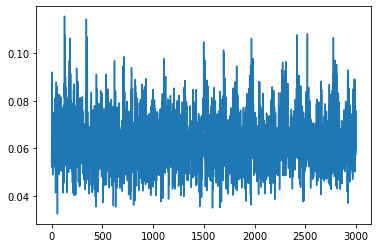

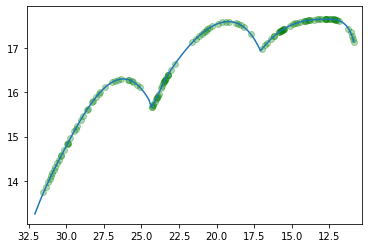

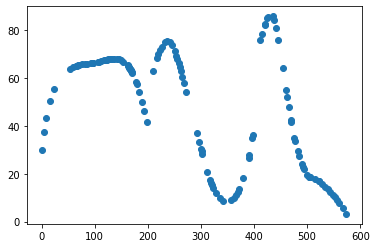

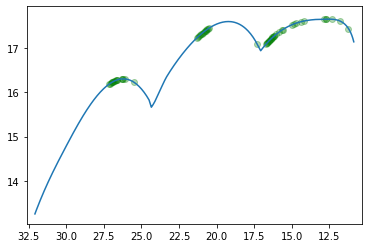

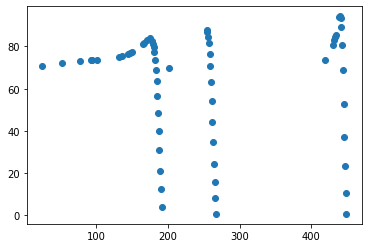

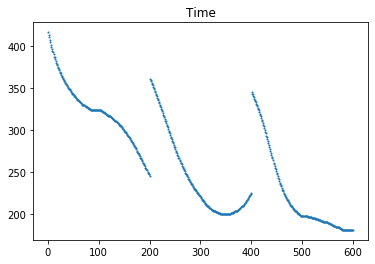

In [91]:
bestFit, finalFit = analyze_fit(opt, alexCurve, 0.05)

In [22]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/alexFits.gz', index=False, encoding='utf-8', compression='gzip')

In [27]:
df.loc[df['loss'] < 0.04]

loss       phase  obliquity
158   0.036766  250.017184   0.902083
161   0.034948  263.338866   0.927289
601   0.038728  229.681869   0.611050
637   0.038045  255.887622   0.670968
638   0.038619  256.890759   0.673261
...        ...         ...        ...
2558  0.037848  290.691308   0.952023
2589  0.038083  291.827207   0.954805
2736  0.039562  298.016461   0.969961
2826  0.039973  303.784587   0.984085
2875  0.038229  306.519365   0.990782

[131 rows x 3 columns]

#### Test with no phase

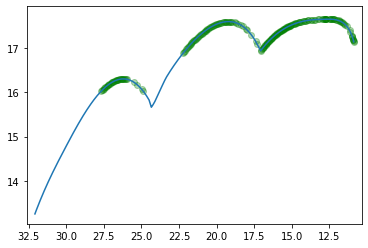

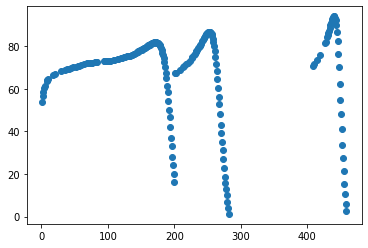

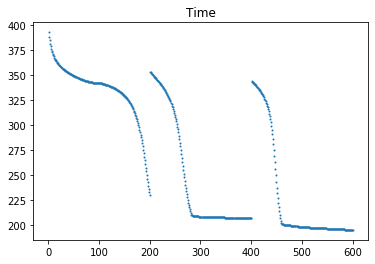

In [102]:
data = direct_fit(alexCurve, 0.25)

### Sidon

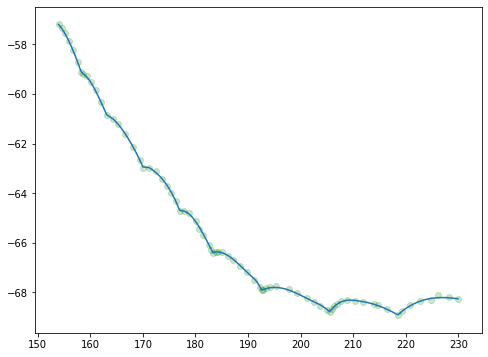

In [74]:
sidon = pd.read_csv("./obsData/SidonLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
sidon = sidon.sort_values(['lon', 'lat'])

sidon_arcs = [
    sidon[0:7],
    sidon[7:13],
    sidon[13:19],
    sidon[19:26],
    sidon[26:34],
    sidon[34:44],
    sidon[44:55],
    sidon[55:66],
    sidon[66:]
]

sidonCurve = createCycloidBezier(sidon_arcs, maxError=0.012) # Smoothing the last arc wiggle
plt.figure(figsize=(8, 6))
plt.plot(sidonCurve['lon'], sidonCurve['lat'])
plt.scatter(sidon['lon'], sidon['lat'], color='green', alpha='0.2')

In [78]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.29055019, 0.18657021]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    sidonCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 0.054414588008654924 -- Moving Avg Loss: 0.054414588008654924
	Parameters used: [0.29055019, 0.18657021]
Iteration 2/3000 -- Loss Output: 0.059160540186837314 -- Moving Avg Loss: 0.056787564097746115
	Parameters used: [0.24055019 0.13657021]
Iteration 3/3000 -- Loss Output: 0.07210172993092358 -- Moving Avg Loss: 0.06189228604213861
	Parameters used: [0.19612901 0.09529881]
Iteration 4/3000 -- Loss Output: 0.06284773081599247 -- Moving Avg Loss: 0.06213114723560208
	Parameters used: [0.15435141 0.05764308]
Iteration 5/3000 -- Loss Output: 0.06736826771426883 -- Moving Avg Loss: 0.06317857133133543
	Parameters used: [0.1133383  0.02125715]
Iteration 6/3000 -- Loss Output: 0.05212545835420809 -- Moving Avg Loss: 0.061336385835147535
	Parameters used: [0.07460219 0.9772293 ]
Iteration 7/3000 -- Loss Output: 0.09194960487962613 -- Moving Avg Loss: 0.06570970284150161
	Parameters used: [0.03412897 0.94419086]
Iteration 8/3000 -- Loss Output: 0.07114412067842

Iteration 62/3000 -- Loss Output: 0.050628213315787506 -- Moving Avg Loss: 0.06287125721516884
	Parameters used: [0.75888626 0.45055546]
Iteration 63/3000 -- Loss Output: 0.05228817080805555 -- Moving Avg Loss: 0.06263441261019924
	Parameters used: [0.74485721 0.4366645 ]
Iteration 64/3000 -- Loss Output: 0.060859320386568244 -- Moving Avg Loss: 0.06277274565444661
	Parameters used: [0.73193241 0.42386656]
Iteration 65/3000 -- Loss Output: 0.06683689616726325 -- Moving Avg Loss: 0.0634333248937654
	Parameters used: [0.71834514 0.41040909]
Iteration 66/3000 -- Loss Output: 0.07089598653074264 -- Moving Avg Loss: 0.06461180236773809
	Parameters used: [0.68643349 0.37869782]
Iteration 67/3000 -- Loss Output: 0.057111148199635434 -- Moving Avg Loss: 0.06499999946556473
	Parameters used: [0.65706255 0.3495125 ]
Iteration 68/3000 -- Loss Output: 0.06699535026917984 -- Moving Avg Loss: 0.06499584387445381
	Parameters used: [0.629647  0.3222723]
Iteration 69/3000 -- Loss Output: 0.054952674620

Iteration 123/3000 -- Loss Output: 0.05588241737689397 -- Moving Avg Loss: 0.06370734000112929
	Parameters used: [0.4309664  0.04489934]
Iteration 124/3000 -- Loss Output: 0.04564533060089624 -- Moving Avg Loss: 0.06263279661423851
	Parameters used: [0.40805005 0.02299598]
Iteration 125/3000 -- Loss Output: 0.06541480899556269 -- Moving Avg Loss: 0.06260983316166616
	Parameters used: [0.38614604 0.00196907]
Iteration 126/3000 -- Loss Output: 0.0873793061702311 -- Moving Avg Loss: 0.06324827413764399
	Parameters used: [0.36602988 0.90796861]
Iteration 127/3000 -- Loss Output: 0.0815050526301524 -- Moving Avg Loss: 0.06386095067530037
	Parameters used: [0.34692291 0.89051602]
Iteration 128/3000 -- Loss Output: 0.10592640591289924 -- Moving Avg Loss: 0.06513887057611592
	Parameters used: [0.3292204  0.87427387]
Iteration 129/3000 -- Loss Output: 0.11533617581506259 -- Moving Avg Loss: 0.06686560124344287
	Parameters used: [0.31250335 0.8588224 ]
Iteration 130/3000 -- Loss Output: 0.082953

Iteration 183/3000 -- Loss Output: 0.05706916969555281 -- Moving Avg Loss: 0.06942666002841137
	Parameters used: [0.22127964 0.78169591]
Iteration 184/3000 -- Loss Output: 0.10610495107578889 -- Moving Avg Loss: 0.07043222449801706
	Parameters used: [0.20006564 0.76067873]
Iteration 185/3000 -- Loss Output: 0.08447151472761152 -- Moving Avg Loss: 0.07149583050282866
	Parameters used: [0.17876412 0.73956225]
Iteration 186/3000 -- Loss Output: 0.05154784963050966 -- Moving Avg Loss: 0.07090982268004448
	Parameters used: [0.15594737 0.71692675]
Iteration 187/3000 -- Loss Output: 0.05681954455702919 -- Moving Avg Loss: 0.06997215867602988
	Parameters used: [0.13444405 0.69559137]
Iteration 188/3000 -- Loss Output: 0.06527362368629057 -- Moving Avg Loss: 0.07040211737761806
	Parameters used: [0.11471773 0.67601822]
Iteration 189/3000 -- Loss Output: 0.09126412670777445 -- Moving Avg Loss: 0.07119240480880439
	Parameters used: [0.09212381 0.65358571]
Iteration 190/3000 -- Loss Output: 0.0734

Iteration 243/3000 -- Loss Output: 0.06686583095097176 -- Moving Avg Loss: 0.05980437148907402
	Parameters used: [0.52656436 0.61276256]
Iteration 244/3000 -- Loss Output: 0.07789281920846079 -- Moving Avg Loss: 0.06003106327943019
	Parameters used: [0.48000967 0.56633474]
Iteration 245/3000 -- Loss Output: 0.05352642533636621 -- Moving Avg Loss: 0.05908248839927234
	Parameters used: [0.43781897 0.52425924]
Iteration 246/3000 -- Loss Output: 0.07045943092551188 -- Moving Avg Loss: 0.0584229833681767
	Parameters used: [0.39831486 0.48486462]
Iteration 247/3000 -- Loss Output: 0.08758807166720259 -- Moving Avg Loss: 0.06030613539283419
	Parameters used: [0.3620978  0.44874853]
Iteration 248/3000 -- Loss Output: 0.09357899888438115 -- Moving Avg Loss: 0.061936235659324324
	Parameters used: [0.3287227  0.41546721]
Iteration 249/3000 -- Loss Output: 0.08885774686798817 -- Moving Avg Loss: 0.06289693853241073
	Parameters used: [0.2960982  0.38293675]
Iteration 250/3000 -- Loss Output: 0.0592

Iteration 303/3000 -- Loss Output: 0.0672983187032664 -- Moving Avg Loss: 0.06365173006265068
	Parameters used: [0.27048873 0.51056502]
Iteration 304/3000 -- Loss Output: 0.07359901489613556 -- Moving Avg Loss: 0.06482078663626675
	Parameters used: [0.25329857 0.49347637]
Iteration 305/3000 -- Loss Output: 0.08164781989975957 -- Moving Avg Loss: 0.06557778927822067
	Parameters used: [0.23097719 0.47129264]
Iteration 306/3000 -- Loss Output: 0.07254393145853585 -- Moving Avg Loss: 0.06627569944146126
	Parameters used: [0.21060018 0.45104138]
Iteration 307/3000 -- Loss Output: 0.061974967049076485 -- Moving Avg Loss: 0.06662981714551401
	Parameters used: [0.19168386 0.43224203]
Iteration 308/3000 -- Loss Output: 0.06538876265932106 -- Moving Avg Loss: 0.0669184530864538
	Parameters used: [0.17368817 0.41435798]
Iteration 309/3000 -- Loss Output: 0.04962172582916728 -- Moving Avg Loss: 0.06615659723452672
	Parameters used: [0.15603394 0.39681375]
Iteration 310/3000 -- Loss Output: 0.06784

Iteration 363/3000 -- Loss Output: 0.05311573910407568 -- Moving Avg Loss: 0.07241476007929389
	Parameters used: [0.81115863 0.45607829]
Iteration 364/3000 -- Loss Output: 0.06072045468080124 -- Moving Avg Loss: 0.07191842304922925
	Parameters used: [0.7967191  0.44163458]
Iteration 365/3000 -- Loss Output: 0.04871565155427164 -- Moving Avg Loss: 0.07204909101022454
	Parameters used: [0.78277002 0.42771109]
Iteration 366/3000 -- Loss Output: 0.06632765578256192 -- Moving Avg Loss: 0.07215669499636032
	Parameters used: [0.76914298 0.41413809]
Iteration 367/3000 -- Loss Output: 0.051838982323799535 -- Moving Avg Loss: 0.07088775373140951
	Parameters used: [0.75617505 0.4012376 ]
Iteration 368/3000 -- Loss Output: 0.052960408657885955 -- Moving Avg Loss: 0.07029438868329174
	Parameters used: [0.73884359 0.38411324]
Iteration 369/3000 -- Loss Output: 0.041143515328211214 -- Moving Avg Loss: 0.06737589033243747
	Parameters used: [0.72314454 0.36860235]
Iteration 370/3000 -- Loss Output: 0.0

Iteration 423/3000 -- Loss Output: 0.042823998378593284 -- Moving Avg Loss: 0.06120813350971628
	Parameters used: [0.48080503 0.14112711]
Iteration 424/3000 -- Loss Output: 0.07791033035476043 -- Moving Avg Loss: 0.06128770009377612
	Parameters used: [0.46446274 0.1249819 ]
Iteration 425/3000 -- Loss Output: 0.04470624025327891 -- Moving Avg Loss: 0.06036835785658612
	Parameters used: [0.4488324  0.10954014]
Iteration 426/3000 -- Loss Output: 0.05049872547050893 -- Moving Avg Loss: 0.06031517045340586
	Parameters used: [0.43356713 0.09445911]
Iteration 427/3000 -- Loss Output: 0.06462550432572242 -- Moving Avg Loss: 0.061235980928200213
	Parameters used: [0.41833868 0.07941453]
Iteration 428/3000 -- Loss Output: 0.0645667694051308 -- Moving Avg Loss: 0.06153284868145244
	Parameters used: [0.40314365 0.06440302]
Iteration 429/3000 -- Loss Output: 0.05584069549102292 -- Moving Avg Loss: 0.06126683652946479
	Parameters used: [0.3887292 0.0501627]
Iteration 430/3000 -- Loss Output: 0.06654

Iteration 483/3000 -- Loss Output: 0.065027112575159 -- Moving Avg Loss: 0.062192012954998634
	Parameters used: [0.60511721 0.71325297]
Iteration 484/3000 -- Loss Output: 0.06422070900981228 -- Moving Avg Loss: 0.061614768305355165
	Parameters used: [0.58854918 0.69688302]
Iteration 485/3000 -- Loss Output: 0.08420266712384279 -- Moving Avg Loss: 0.06331212708665589
	Parameters used: [0.57152264 0.68006024]
Iteration 486/3000 -- Loss Output: 0.06902651021682736 -- Moving Avg Loss: 0.06348422938167976
	Parameters used: [0.55629946 0.66501922]
Iteration 487/3000 -- Loss Output: 0.0657196417319502 -- Moving Avg Loss: 0.06424525933093923
	Parameters used: [0.4925241  0.60179819]
Iteration 488/3000 -- Loss Output: 0.05441541490770095 -- Moving Avg Loss: 0.0636584842495423
	Parameters used: [0.43495789 0.54473265]
Iteration 489/3000 -- Loss Output: 0.07240955717904837 -- Moving Avg Loss: 0.0641088205594635
	Parameters used: [0.38304937 0.49327569]
Iteration 490/3000 -- Loss Output: 0.0690185

Iteration 543/3000 -- Loss Output: 0.0736646931798211 -- Moving Avg Loss: 0.06432054291904998
	Parameters used: [0.38652555 0.47523346]
Iteration 544/3000 -- Loss Output: 0.06306945575016737 -- Moving Avg Loss: 0.06455270288460156
	Parameters used: [0.37294128 0.46178834]
Iteration 545/3000 -- Loss Output: 0.07298789107199329 -- Moving Avg Loss: 0.06479927403035902
	Parameters used: [0.36025897 0.44923594]
Iteration 546/3000 -- Loss Output: 0.0515793508190413 -- Moving Avg Loss: 0.06437100392016396
	Parameters used: [0.34731815 0.43642762]
Iteration 547/3000 -- Loss Output: 0.07749514564214002 -- Moving Avg Loss: 0.06494173217654244
	Parameters used: [0.33302643 0.4222821 ]
Iteration 548/3000 -- Loss Output: 0.05057418364179495 -- Moving Avg Loss: 0.0647568740704996
	Parameters used: [0.3197209  0.40911267]
Iteration 549/3000 -- Loss Output: 0.0651032784368704 -- Moving Avg Loss: 0.06525791943991105
	Parameters used: [0.30443879 0.39398672]
Iteration 550/3000 -- Loss Output: 0.05793815

Iteration 603/3000 -- Loss Output: 0.06447514825337856 -- Moving Avg Loss: 0.06225509714101554
	Parameters used: [0.3527705  0.11681703]
Iteration 604/3000 -- Loss Output: 0.06921467465944736 -- Moving Avg Loss: 0.06275139641634829
	Parameters used: [0.33471469 0.09893786]
Iteration 605/3000 -- Loss Output: 0.06048260540899536 -- Moving Avg Loss: 0.0630023344353438
	Parameters used: [0.31830862 0.08269233]
Iteration 606/3000 -- Loss Output: 0.07017911794722755 -- Moving Avg Loss: 0.06319316040494213
	Parameters used: [0.30234639 0.06688652]
Iteration 607/3000 -- Loss Output: 0.05948745486835891 -- Moving Avg Loss: 0.06355649683222973
	Parameters used: [0.28761529 0.05229984]
Iteration 608/3000 -- Loss Output: 0.0684180244977517 -- Moving Avg Loss: 0.06350007807860696
	Parameters used: [0.27391332 0.03873227]
Iteration 609/3000 -- Loss Output: 0.07750220864901158 -- Moving Avg Loss: 0.06390134725858458
	Parameters used: [0.26029155 0.02524429]
Iteration 610/3000 -- Loss Output: 0.036054

Iteration 663/3000 -- Loss Output: 0.07908757667800578 -- Moving Avg Loss: 0.06058856654981213
	Parameters used: [0.30426655 0.27282345]
Iteration 664/3000 -- Loss Output: 0.06279512775381624 -- Moving Avg Loss: 0.06077682096301036
	Parameters used: [0.25622695 0.22463066]
Iteration 665/3000 -- Loss Output: 0.07477943921492683 -- Moving Avg Loss: 0.061965238733994975
	Parameters used: [0.21230453 0.18058827]
Iteration 666/3000 -- Loss Output: 0.05948954624253326 -- Moving Avg Loss: 0.06217395342559347
	Parameters used: [0.17258108 0.14076096]
Iteration 667/3000 -- Loss Output: 0.058307140079302607 -- Moving Avg Loss: 0.06170045946558098
	Parameters used: [0.13173598 0.09996056]
Iteration 668/3000 -- Loss Output: 0.06065131228648539 -- Moving Avg Loss: 0.06113041844962029
	Parameters used: [0.09469346 0.06296415]
Iteration 669/3000 -- Loss Output: 0.05343145366126145 -- Moving Avg Loss: 0.060738620832128006
	Parameters used: [0.06025971 0.02859712]
Iteration 670/3000 -- Loss Output: 0.0

Iteration 723/3000 -- Loss Output: 0.065440684820635 -- Moving Avg Loss: 0.06736750246939872
	Parameters used: [0.24139182 0.30900567]
Iteration 724/3000 -- Loss Output: 0.0648404614984983 -- Moving Avg Loss: 0.06773387766998294
	Parameters used: [0.2242455 0.2920715]
Iteration 725/3000 -- Loss Output: 0.06176825773715075 -- Moving Avg Loss: 0.06800947797443872
	Parameters used: [0.2075277  0.27556054]
Iteration 726/3000 -- Loss Output: 0.07216109680984721 -- Moving Avg Loss: 0.06840899030306627
	Parameters used: [0.19217262 0.26039544]
Iteration 727/3000 -- Loss Output: 0.06848397045097755 -- Moving Avg Loss: 0.06892993847096725
	Parameters used: [0.17791607 0.24631528]
Iteration 728/3000 -- Loss Output: 0.057869807703278445 -- Moving Avg Loss: 0.06850729674819118
	Parameters used: [0.15683468 0.22549347]
Iteration 729/3000 -- Loss Output: 0.06220549147646817 -- Moving Avg Loss: 0.06803278458951208
	Parameters used: [0.13723849 0.20613862]
Iteration 730/3000 -- Loss Output: 0.06060546

Iteration 783/3000 -- Loss Output: 0.08455628277757549 -- Moving Avg Loss: 0.05896349132380681
	Parameters used: [0.36312946 0.05761129]
Iteration 784/3000 -- Loss Output: 0.058252597079292714 -- Moving Avg Loss: 0.05888825295195296
	Parameters used: [0.34969462 0.04435001]
Iteration 785/3000 -- Loss Output: 0.05913522919534583 -- Moving Avg Loss: 0.05867049518729903
	Parameters used: [0.33710685 0.03192487]
Iteration 786/3000 -- Loss Output: 0.06437882933291847 -- Moving Avg Loss: 0.05962330422685138
	Parameters used: [0.32442546 0.0194073 ]
Iteration 787/3000 -- Loss Output: 0.06721849852396326 -- Moving Avg Loss: 0.05928770878033086
	Parameters used: [0.31044267 0.0056051 ]
Iteration 788/3000 -- Loss Output: 0.08986585628141326 -- Moving Avg Loss: 0.06061583237263343
	Parameters used: [0.29621589 0.54380559]
Iteration 789/3000 -- Loss Output: 0.09383739774317533 -- Moving Avg Loss: 0.061890508549982445
	Parameters used: [0.28079461 0.53122244]
Iteration 790/3000 -- Loss Output: 0.08

Iteration 843/3000 -- Loss Output: 0.06036143107898726 -- Moving Avg Loss: 0.06967876134210575
	Parameters used: [0.91254662 0.3623493 ]
Iteration 844/3000 -- Loss Output: 0.066482628302892 -- Moving Avg Loss: 0.06981405446590105
	Parameters used: [0.89342937 0.3431868 ]
Iteration 845/3000 -- Loss Output: 0.07003219408558971 -- Moving Avg Loss: 0.06991055756772177
	Parameters used: [0.87493762 0.32468859]
Iteration 846/3000 -- Loss Output: 0.05761179989443602 -- Moving Avg Loss: 0.0695782256377592
	Parameters used: [0.85790517 0.30765971]
Iteration 847/3000 -- Loss Output: 0.051966259730148 -- Moving Avg Loss: 0.07012722117001322
	Parameters used: [0.84016023 0.28997672]
Iteration 848/3000 -- Loss Output: 0.06252069508555193 -- Moving Avg Loss: 0.06950894139886776
	Parameters used: [0.82374689 0.27362831]
Iteration 849/3000 -- Loss Output: 0.07904582734693633 -- Moving Avg Loss: 0.06952769218948097
	Parameters used: [0.80455562 0.25458687]
Iteration 850/3000 -- Loss Output: 0.067322313

Iteration 903/3000 -- Loss Output: 0.06050594583372934 -- Moving Avg Loss: 0.06171425627469933
	Parameters used: [0.66975228 0.48705908]
Iteration 904/3000 -- Loss Output: 0.042270301062906405 -- Moving Avg Loss: 0.06075103809558677
	Parameters used: [0.60760248 0.42798473]
Iteration 905/3000 -- Loss Output: 0.05299642521064843 -- Moving Avg Loss: 0.06046203705646291
	Parameters used: [0.55148677 0.37463047]
Iteration 906/3000 -- Loss Output: 0.05168432450359877 -- Moving Avg Loss: 0.0600635775460956
	Parameters used: [0.50092486 0.32655495]
Iteration 907/3000 -- Loss Output: 0.0592927842781344 -- Moving Avg Loss: 0.059449177804579555
	Parameters used: [0.45505547 0.28290398]
Iteration 908/3000 -- Loss Output: 0.07252657334060694 -- Moving Avg Loss: 0.06036525874350136
	Parameters used: [0.41359479 0.24343232]
Iteration 909/3000 -- Loss Output: 0.07484164125038978 -- Moving Avg Loss: 0.061350279558572265
	Parameters used: [0.3755566  0.20714155]
Iteration 910/3000 -- Loss Output: 0.066

Iteration 963/3000 -- Loss Output: 0.04330134259838912 -- Moving Avg Loss: 0.061869245091237667
	Parameters used: [0.84791641 0.43990341]
Iteration 964/3000 -- Loss Output: 0.06284984957562477 -- Moving Avg Loss: 0.06158330399039116
	Parameters used: [0.84389055 0.43592633]
Iteration 965/3000 -- Loss Output: 0.058741490845715005 -- Moving Avg Loss: 0.06163415582083369
	Parameters used: [0.84026288 0.43234261]
Iteration 966/3000 -- Loss Output: 0.06787320956607018 -- Moving Avg Loss: 0.06252087653560259
	Parameters used: [0.83671695 0.42883977]
Iteration 967/3000 -- Loss Output: 0.05529352502976392 -- Moving Avg Loss: 0.061953454387904464
	Parameters used: [0.8319529  0.42413415]
Iteration 968/3000 -- Loss Output: 0.05708991262411767 -- Moving Avg Loss: 0.06177309003243458
	Parameters used: [0.8202969  0.41262152]
Iteration 969/3000 -- Loss Output: 0.060867500893023486 -- Moving Avg Loss: 0.061274170065390675
	Parameters used: [0.80976564 0.40221979]
Iteration 970/3000 -- Loss Output: 0

Iteration 1023/3000 -- Loss Output: 0.06683738806237294 -- Moving Avg Loss: 0.06417261645010201
	Parameters used: [0.88554149 0.37849682]
Iteration 1024/3000 -- Loss Output: 0.07663297569564527 -- Moving Avg Loss: 0.06469409360918787
	Parameters used: [0.879368   0.37238858]
Iteration 1025/3000 -- Loss Output: 0.05182349978263265 -- Moving Avg Loss: 0.063540483666908
	Parameters used: [0.87369034 0.36677092]
Iteration 1026/3000 -- Loss Output: 0.06567511190705208 -- Moving Avg Loss: 0.06341879292381371
	Parameters used: [0.86812668 0.36126604]
Iteration 1027/3000 -- Loss Output: 0.06568253479487171 -- Moving Avg Loss: 0.06265893739342689
	Parameters used: [0.86291659 0.35611099]
Iteration 1028/3000 -- Loss Output: 0.040272743509008564 -- Moving Avg Loss: 0.06251202651838693
	Parameters used: [0.84892209 0.34226339]
Iteration 1029/3000 -- Loss Output: 0.06592966359901394 -- Moving Avg Loss: 0.06224318142525927
	Parameters used: [0.83618016 0.3296552 ]
Iteration 1030/3000 -- Loss Output:

Iteration 1083/3000 -- Loss Output: 0.07687070693396116 -- Moving Avg Loss: 0.05964937487209467
	Parameters used: [0.5125323 0.0094107]
Iteration 1084/3000 -- Loss Output: 0.04654134685405846 -- Moving Avg Loss: 0.058951517473319094
	Parameters used: [0.5076424  0.00457223]
Iteration 1085/3000 -- Loss Output: 0.07048690059950867 -- Moving Avg Loss: 0.05900639366445162
	Parameters used: [0.5029878 0.5145434]
Iteration 1086/3000 -- Loss Output: 0.06610459118807945 -- Moving Avg Loss: 0.05946328412615337
	Parameters used: [0.49863923 0.51039658]
Iteration 1087/3000 -- Loss Output: 0.06985133176547617 -- Moving Avg Loss: 0.0600838988526116
	Parameters used: [0.49423406 0.50616006]
Iteration 1088/3000 -- Loss Output: 0.06836253126247961 -- Moving Avg Loss: 0.06015978811026056
	Parameters used: [0.48902728 0.50108282]
Iteration 1089/3000 -- Loss Output: 0.07487872282396019 -- Moving Avg Loss: 0.0612019350672334
	Parameters used: [0.47875439 0.49090393]
Iteration 1090/3000 -- Loss Output: 0.0

Iteration 1143/3000 -- Loss Output: 0.051513721213619024 -- Moving Avg Loss: 0.06308683194181362
	Parameters used: [0.10109519 0.11713498]
Iteration 1144/3000 -- Loss Output: 0.0677359807116401 -- Moving Avg Loss: 0.06347631224760542
	Parameters used: [0.09432766 0.11043853]
Iteration 1145/3000 -- Loss Output: 0.05114361097725263 -- Moving Avg Loss: 0.063133197099718
	Parameters used: [0.08816828 0.10434385]
Iteration 1146/3000 -- Loss Output: 0.05064117656847088 -- Moving Avg Loss: 0.06317420795667955
	Parameters used: [0.08020744 0.09646661]
Iteration 1147/3000 -- Loss Output: 0.08066486739708548 -- Moving Avg Loss: 0.06423958453707898
	Parameters used: [0.07303251 0.08936702]
Iteration 1148/3000 -- Loss Output: 0.05036337745420217 -- Moving Avg Loss: 0.06335533066608391
	Parameters used: [0.06586731 0.08227706]
Iteration 1149/3000 -- Loss Output: 0.0805656013652494 -- Moving Avg Loss: 0.0642275175381052
	Parameters used: [0.05907161 0.07555273]
Iteration 1150/3000 -- Loss Output: 0.

Iteration 1203/3000 -- Loss Output: 0.06837167065331258 -- Moving Avg Loss: 0.06461916760835638
	Parameters used: [0.65836012 0.63994787]
Iteration 1204/3000 -- Loss Output: 0.06084314354654185 -- Moving Avg Loss: 0.06487498624610355
	Parameters used: [0.65286612 0.63447507]
Iteration 1205/3000 -- Loss Output: 0.0442126411375309 -- Moving Avg Loss: 0.06406500032225891
	Parameters used: [0.64769642 0.62932774]
Iteration 1206/3000 -- Loss Output: 0.06675523870308656 -- Moving Avg Loss: 0.06395786822376516
	Parameters used: [0.64290434 0.62455773]
Iteration 1207/3000 -- Loss Output: 0.08525089661432356 -- Moving Avg Loss: 0.0646090700691207
	Parameters used: [0.63847763 0.62015246]
Iteration 1208/3000 -- Loss Output: 0.07009627237589836 -- Moving Avg Loss: 0.06480096635008636
	Parameters used: [0.6325849  0.61430523]
Iteration 1209/3000 -- Loss Output: 0.05954737697303268 -- Moving Avg Loss: 0.06455066681177551
	Parameters used: [0.62669298 0.60846066]
Iteration 1210/3000 -- Loss Output: 

Iteration 1263/3000 -- Loss Output: 0.05234131760982872 -- Moving Avg Loss: 0.06376362391945097
	Parameters used: [0.31322767 0.29787493]
Iteration 1264/3000 -- Loss Output: 0.07340051941860185 -- Moving Avg Loss: 0.06350276018645502
	Parameters used: [0.30761102 0.29231045]
Iteration 1265/3000 -- Loss Output: 0.06087953939605256 -- Moving Avg Loss: 0.0631489276363851
	Parameters used: [0.30180338 0.28655677]
Iteration 1266/3000 -- Loss Output: 0.07318676328320534 -- Moving Avg Loss: 0.06296253981776162
	Parameters used: [0.29644826 0.2812514 ]
Iteration 1267/3000 -- Loss Output: 0.04855130835783136 -- Moving Avg Loss: 0.062401186979802924
	Parameters used: [0.29118897 0.27604097]
Iteration 1268/3000 -- Loss Output: 0.0547887047290504 -- Moving Avg Loss: 0.06219840363717585
	Parameters used: [0.28493616 0.26984624]
Iteration 1269/3000 -- Loss Output: 0.052567653686156124 -- Moving Avg Loss: 0.06199661645211066
	Parameters used: [0.27924479 0.26420774]
Iteration 1270/3000 -- Loss Output

Iteration 1323/3000 -- Loss Output: 0.049422174658176735 -- Moving Avg Loss: 0.0690761822648792
	Parameters used: [0.89594169 0.76803288]
Iteration 1324/3000 -- Loss Output: 0.05061060193747914 -- Moving Avg Loss: 0.06809923771323201
	Parameters used: [0.89041369 0.76254225]
Iteration 1325/3000 -- Loss Output: 0.05896998449787408 -- Moving Avg Loss: 0.06775857654830605
	Parameters used: [0.88484948 0.75701861]
Iteration 1326/3000 -- Loss Output: 0.07461838126081412 -- Moving Avg Loss: 0.06781820927508514
	Parameters used: [0.87952115 0.75173041]
Iteration 1327/3000 -- Loss Output: 0.06466402360716351 -- Moving Avg Loss: 0.06768090290141832
	Parameters used: [0.87462616 0.74687262]
Iteration 1328/3000 -- Loss Output: 0.06811125465979999 -- Moving Avg Loss: 0.06832791437147295
	Parameters used: [0.86852947 0.74082797]
Iteration 1329/3000 -- Loss Output: 0.0734409859161235 -- Moving Avg Loss: 0.06901791210920181
	Parameters used: [0.86292265 0.73526919]
Iteration 1330/3000 -- Loss Output:

Iteration 1383/3000 -- Loss Output: 0.054274965100386464 -- Moving Avg Loss: 0.06259455868907955
	Parameters used: [0.61741385 0.49202405]
Iteration 1384/3000 -- Loss Output: 0.06696356681783414 -- Moving Avg Loss: 0.06249211144262756
	Parameters used: [0.61151718 0.48618215]
Iteration 1385/3000 -- Loss Output: 0.0701373787004861 -- Moving Avg Loss: 0.0630637786959388
	Parameters used: [0.60623601 0.48095003]
Iteration 1386/3000 -- Loss Output: 0.05935877253246356 -- Moving Avg Loss: 0.06295530715183693
	Parameters used: [0.60147213 0.4762304 ]
Iteration 1387/3000 -- Loss Output: 0.057609469537061836 -- Moving Avg Loss: 0.0627580283288895
	Parameters used: [0.59696491 0.47176505]
Iteration 1388/3000 -- Loss Output: 0.06279412852385424 -- Moving Avg Loss: 0.06277670802699271
	Parameters used: [0.59276092 0.46760011]
Iteration 1389/3000 -- Loss Output: 0.06170452253584777 -- Moving Avg Loss: 0.06213286731396094
	Parameters used: [0.58877722 0.46365341]
Iteration 1390/3000 -- Loss Output:

Iteration 1443/3000 -- Loss Output: 0.06394340900276044 -- Moving Avg Loss: 0.05952951931961748
	Parameters used: [0.66042615 0.35920822]
Iteration 1444/3000 -- Loss Output: 0.05427471080770015 -- Moving Avg Loss: 0.05977119169860498
	Parameters used: [0.64153162 0.34042825]
Iteration 1445/3000 -- Loss Output: 0.06494769403134223 -- Moving Avg Loss: 0.059962281992164336
	Parameters used: [0.62355903 0.32256742]
Iteration 1446/3000 -- Loss Output: 0.06604558605643324 -- Moving Avg Loss: 0.060352767037208065
	Parameters used: [0.60737779 0.30648679]
Iteration 1447/3000 -- Loss Output: 0.07113643046732208 -- Moving Avg Loss: 0.06085857603713477
	Parameters used: [0.59260853 0.29180987]
Iteration 1448/3000 -- Loss Output: 0.057001646571695694 -- Moving Avg Loss: 0.061356878205900675
	Parameters used: [0.57768545 0.2769842 ]
Iteration 1449/3000 -- Loss Output: 0.06291744720399835 -- Moving Avg Loss: 0.06074019665610224
	Parameters used: [0.56415198 0.26353926]
Iteration 1450/3000 -- Loss Ou

Iteration 1503/3000 -- Loss Output: 0.08086363320702221 -- Moving Avg Loss: 0.06972239327131949
	Parameters used: [0.15265264 0.84625742]
Iteration 1504/3000 -- Loss Output: 0.06781096640127356 -- Moving Avg Loss: 0.07084967793831401
	Parameters used: [0.14067376 0.83439608]
Iteration 1505/3000 -- Loss Output: 0.07815063104398959 -- Moving Avg Loss: 0.0711058866097349
	Parameters used: [0.12977915 0.82360789]
Iteration 1506/3000 -- Loss Output: 0.07766119084911575 -- Moving Avg Loss: 0.07198435748389556
	Parameters used: [0.11996288 0.8138875 ]
Iteration 1507/3000 -- Loss Output: 0.07165951207203416 -- Moving Avg Loss: 0.0719963539778286
	Parameters used: [0.11059557 0.8046093 ]
Iteration 1508/3000 -- Loss Output: 0.08833865121364558 -- Moving Avg Loss: 0.07257958104472861
	Parameters used: [0.10173909 0.79583539]
Iteration 1509/3000 -- Loss Output: 0.07607031322901402 -- Moving Avg Loss: 0.07300229014224113
	Parameters used: [0.09369769 0.78786873]
Iteration 1510/3000 -- Loss Output: 

Iteration 1563/3000 -- Loss Output: 0.0625572524454953 -- Moving Avg Loss: 0.062245122590289845
	Parameters used: [0.41572402 0.11449673]
Iteration 1564/3000 -- Loss Output: 0.06785229361337525 -- Moving Avg Loss: 0.06263712090982543
	Parameters used: [0.40159274 0.10045986]
Iteration 1565/3000 -- Loss Output: 0.05818156116617 -- Moving Avg Loss: 0.06242120042727564
	Parameters used: [0.38883697 0.08778933]
Iteration 1566/3000 -- Loss Output: 0.047079757014513064 -- Moving Avg Loss: 0.061531511436073355
	Parameters used: [0.37720677 0.07623696]
Iteration 1567/3000 -- Loss Output: 0.053231510928092536 -- Moving Avg Loss: 0.06168716369445674
	Parameters used: [0.36661555 0.06571672]
Iteration 1568/3000 -- Loss Output: 0.04648309843846754 -- Moving Avg Loss: 0.060108859258440714
	Parameters used: [0.3568433  0.05601012]
Iteration 1569/3000 -- Loss Output: 0.055591617396229295 -- Moving Avg Loss: 0.05940213741272751
	Parameters used: [0.34792252 0.04714936]
Iteration 1570/3000 -- Loss Outp

Iteration 1623/3000 -- Loss Output: 0.06559731603701636 -- Moving Avg Loss: 0.0652024091206418
	Parameters used: [0.70204055 0.19259013]
Iteration 1624/3000 -- Loss Output: 0.045579684413765614 -- Moving Avg Loss: 0.06417665328405485
	Parameters used: [0.6725539  0.16315268]
Iteration 1625/3000 -- Loss Output: 0.05570372084714934 -- Moving Avg Loss: 0.06298515368659881
	Parameters used: [0.64585614 0.13650083]
Iteration 1626/3000 -- Loss Output: 0.06997106105251563 -- Moving Avg Loss: 0.06236560178718964
	Parameters used: [0.62180606 0.11249217]
Iteration 1627/3000 -- Loss Output: 0.05263082350769577 -- Moving Avg Loss: 0.06222281595158795
	Parameters used: [0.60012946 0.09085307]
Iteration 1628/3000 -- Loss Output: 0.07291737802377583 -- Moving Avg Loss: 0.06256774319481671
	Parameters used: [0.58055434 0.07131231]
Iteration 1629/3000 -- Loss Output: 0.06729663106115377 -- Moving Avg Loss: 0.06238086407731392
	Parameters used: [0.56274186 0.05353281]
Iteration 1630/3000 -- Loss Output

Iteration 1683/3000 -- Loss Output: 0.06389269616149094 -- Moving Avg Loss: 0.06063722082605016
	Parameters used: [0.17273525 0.0720987 ]
Iteration 1684/3000 -- Loss Output: 0.04715872617177211 -- Moving Avg Loss: 0.05916557177335305
	Parameters used: [0.16807776 0.06747101]
Iteration 1685/3000 -- Loss Output: 0.07382785220501208 -- Moving Avg Loss: 0.05934828184600456
	Parameters used: [0.16348998 0.0629126 ]
Iteration 1686/3000 -- Loss Output: 0.06643609674275862 -- Moving Avg Loss: 0.06059528625310163
	Parameters used: [0.15932884 0.0587781 ]
Iteration 1687/3000 -- Loss Output: 0.05738233553201918 -- Moving Avg Loss: 0.059599834229479745
	Parameters used: [0.15504766 0.05452431]
Iteration 1688/3000 -- Loss Output: 0.08184214179513917 -- Moving Avg Loss: 0.06041193586286281
	Parameters used: [0.15078285 0.05028681]
Iteration 1689/3000 -- Loss Output: 0.06990413812219835 -- Moving Avg Loss: 0.0613651207961598
	Parameters used: [0.14670811 0.04623814]
Iteration 1690/3000 -- Loss Output

Iteration 1743/3000 -- Loss Output: 0.044075585443860074 -- Moving Avg Loss: 0.05622540842222251
	Parameters used: [0.72924921 0.54394508]
Iteration 1744/3000 -- Loss Output: 0.05509258025606634 -- Moving Avg Loss: 0.0556140820846602
	Parameters used: [0.72415826 0.53888631]
Iteration 1745/3000 -- Loss Output: 0.056603717953015366 -- Moving Avg Loss: 0.05511289566167807
	Parameters used: [0.71954573 0.53430294]
Iteration 1746/3000 -- Loss Output: 0.0629359139857741 -- Moving Avg Loss: 0.0559093501178881
	Parameters used: [0.7153323  0.53011614]
Iteration 1747/3000 -- Loss Output: 0.06179131247105257 -- Moving Avg Loss: 0.05546455847189109
	Parameters used: [0.71003003 0.52484732]
Iteration 1748/3000 -- Loss Output: 0.06633290292987615 -- Moving Avg Loss: 0.05532952568883191
	Parameters used: [0.70501342 0.51986235]
Iteration 1749/3000 -- Loss Output: 0.0516742639773046 -- Moving Avg Loss: 0.055103718156137786
	Parameters used: [0.70045419 0.51533189]
Iteration 1750/3000 -- Loss Output:

Iteration 1803/3000 -- Loss Output: 0.04447324743352188 -- Moving Avg Loss: 0.06558172319728184
	Parameters used: [0.32635764 0.14357781]
Iteration 1804/3000 -- Loss Output: 0.08194993898675923 -- Moving Avg Loss: 0.06616205078441113
	Parameters used: [0.31729511 0.13457169]
Iteration 1805/3000 -- Loss Output: 0.07355951763722861 -- Moving Avg Loss: 0.06637411222121901
	Parameters used: [0.30917952 0.12650662]
Iteration 1806/3000 -- Loss Output: 0.04630181146082599 -- Moving Avg Loss: 0.06570856185740419
	Parameters used: [0.3015824  0.11895681]
Iteration 1807/3000 -- Loss Output: 0.06108181612476723 -- Moving Avg Loss: 0.0656421129260131
	Parameters used: [0.29449135 0.11190993]
Iteration 1808/3000 -- Loss Output: 0.07343718108831913 -- Moving Avg Loss: 0.0657643083130031
	Parameters used: [0.28697874 0.10444417]
Iteration 1809/3000 -- Loss Output: 0.06582277066196196 -- Moving Avg Loss: 0.06547556445615652
	Parameters used: [0.28023609 0.09774356]
Iteration 1810/3000 -- Loss Output: 

Iteration 1863/3000 -- Loss Output: 0.07604435266007951 -- Moving Avg Loss: 0.0601951881927445
	Parameters used: [0.76139846 0.10728722]
Iteration 1864/3000 -- Loss Output: 0.07429381790580325 -- Moving Avg Loss: 0.06085368272269797
	Parameters used: [0.75521671 0.10114444]
Iteration 1865/3000 -- Loss Output: 0.04882316698431731 -- Moving Avg Loss: 0.06017301394458388
	Parameters used: [0.74920408 0.09516959]
Iteration 1866/3000 -- Loss Output: 0.0659382523674703 -- Moving Avg Loss: 0.06087696966463854
	Parameters used: [0.74350471 0.08950596]
Iteration 1867/3000 -- Loss Output: 0.0689041103046677 -- Moving Avg Loss: 0.06103431539617614
	Parameters used: [0.73831228 0.08434608]
Iteration 1868/3000 -- Loss Output: 0.052650871067822264 -- Moving Avg Loss: 0.060774474193701425
	Parameters used: [0.73346123 0.07952539]
Iteration 1869/3000 -- Loss Output: 0.06631414542646553 -- Moving Avg Loss: 0.06095383462024013
	Parameters used: [0.72864413 0.07473837]
Iteration 1870/3000 -- Loss Output:

Iteration 1923/3000 -- Loss Output: 0.048992718219914605 -- Moving Avg Loss: 0.06027906554736982
	Parameters used: [0.49191511 0.21121462]
Iteration 1924/3000 -- Loss Output: 0.05198332006663765 -- Moving Avg Loss: 0.05975390412716974
	Parameters used: [0.48832316 0.20764485]
Iteration 1925/3000 -- Loss Output: 0.056270426184413205 -- Moving Avg Loss: 0.05925075005659872
	Parameters used: [0.48401205 0.20336033]
Iteration 1926/3000 -- Loss Output: 0.08292517488711001 -- Moving Avg Loss: 0.060204280220917256
	Parameters used: [0.47968354 0.19905851]
Iteration 1927/3000 -- Loss Output: 0.059609402474816525 -- Moving Avg Loss: 0.060326079020437066
	Parameters used: [0.47534679 0.1947485 ]
Iteration 1928/3000 -- Loss Output: 0.059485936396315865 -- Moving Avg Loss: 0.060155800310621795
	Parameters used: [0.4712299  0.19065699]
Iteration 1929/3000 -- Loss Output: 0.054147783905318665 -- Moving Avg Loss: 0.06059425389531547
	Parameters used: [0.46709958 0.18655212]
Iteration 1930/3000 -- Los

Iteration 1983/3000 -- Loss Output: 0.0704120646081155 -- Moving Avg Loss: 0.07713774065056087
	Parameters used: [0.04141468 0.6806296 ]
Iteration 1984/3000 -- Loss Output: 0.09760952026872574 -- Moving Avg Loss: 0.0774133975873103
	Parameters used: [0.0323314  0.67160179]
Iteration 1985/3000 -- Loss Output: 0.059848642297098416 -- Moving Avg Loss: 0.07713560138641197
	Parameters used: [0.02417807 0.66349826]
Iteration 1986/3000 -- Loss Output: 0.058306970426143724 -- Moving Avg Loss: 0.07784650823795757
	Parameters used: [0.01308981 0.65247768]
Iteration 1987/3000 -- Loss Output: 0.06791234744375547 -- Moving Avg Loss: 0.07684640023526224
	Parameters used: [0.00288312 0.64233329]
Iteration 1988/3000 -- Loss Output: 0.0556944023176497 -- Moving Avg Loss: 0.07528625278102904
	Parameters used: [0.99340316 0.63291121]
Iteration 1989/3000 -- Loss Output: 0.0609133986257667 -- Moving Avg Loss: 0.0742424770448879
	Parameters used: [0.98488077 0.6229203 ]
Iteration 1990/3000 -- Loss Output: 0

Iteration 2043/3000 -- Loss Output: 0.0812549945803633 -- Moving Avg Loss: 0.05996886531033377
	Parameters used: [0.31666842 0.66992016]
Iteration 2044/3000 -- Loss Output: 0.054631880197006384 -- Moving Avg Loss: 0.059740137240689196
	Parameters used: [0.27674209 0.63017231]
Iteration 2045/3000 -- Loss Output: 0.08794681754381627 -- Moving Avg Loss: 0.06104779830691252
	Parameters used: [0.24075873 0.59434984]
Iteration 2046/3000 -- Loss Output: 0.06940417341365476 -- Moving Avg Loss: 0.06127760967223314
	Parameters used: [0.20832944 0.56206561]
Iteration 2047/3000 -- Loss Output: 0.0706940350735522 -- Moving Avg Loss: 0.06175466968531765
	Parameters used: [0.17903688 0.53290424]
Iteration 2048/3000 -- Loss Output: 0.06803785957297961 -- Moving Avg Loss: 0.06207527363558165
	Parameters used: [0.15241142 0.50639847]
Iteration 2049/3000 -- Loss Output: 0.07070272700419059 -- Moving Avg Loss: 0.06284117773953915
	Parameters used: [0.12795557 0.48205344]
Iteration 2050/3000 -- Loss Output

Iteration 2103/3000 -- Loss Output: 0.07004749904156167 -- Moving Avg Loss: 0.06223074456693649
	Parameters used: [0.72646857 0.08184754]
Iteration 2104/3000 -- Loss Output: 0.07004371692913652 -- Moving Avg Loss: 0.06266427511104754
	Parameters used: [0.72230179 0.07770326]
Iteration 2105/3000 -- Loss Output: 0.06829028601866612 -- Moving Avg Loss: 0.06259423212652188
	Parameters used: [0.7183523  0.07377509]
Iteration 2106/3000 -- Loss Output: 0.04097609479429948 -- Moving Avg Loss: 0.062330460511518464
	Parameters used: [0.71451905 0.06996253]
Iteration 2107/3000 -- Loss Output: 0.0611091510437757 -- Moving Avg Loss: 0.06259391454202684
	Parameters used: [0.71052364 0.0659887 ]
Iteration 2108/3000 -- Loss Output: 0.06291987497646825 -- Moving Avg Loss: 0.061934576422336525
	Parameters used: [0.70685041 0.0623353 ]
Iteration 2109/3000 -- Loss Output: 0.059957366404553195 -- Moving Avg Loss: 0.06101031661094618
	Parameters used: [0.70283085 0.05833744]
Iteration 2110/3000 -- Loss Outp

Iteration 2163/3000 -- Loss Output: 0.041270702101571716 -- Moving Avg Loss: 0.058453238062891974
	Parameters used: [0.37789613 0.03306243]
Iteration 2164/3000 -- Loss Output: 0.059604620013557104 -- Moving Avg Loss: 0.058465865903969336
	Parameters used: [0.3725776  0.02777261]
Iteration 2165/3000 -- Loss Output: 0.05166947492174392 -- Moving Avg Loss: 0.05808878014710394
	Parameters used: [0.36768891 0.02291031]
Iteration 2166/3000 -- Loss Output: 0.06852681740650488 -- Moving Avg Loss: 0.058315932378109225
	Parameters used: [0.36226354 0.01751423]
Iteration 2167/3000 -- Loss Output: 0.04397153470244064 -- Moving Avg Loss: 0.0578802401816248
	Parameters used: [0.35741336 0.01269024]
Iteration 2168/3000 -- Loss Output: 0.07273462959677691 -- Moving Avg Loss: 0.05791717282753913
	Parameters used: [0.35273636 0.00803849]
Iteration 2169/3000 -- Loss Output: 0.0502168793084128 -- Moving Avg Loss: 0.057493798852777694
	Parameters used: [0.34757773 0.00290771]
Iteration 2170/3000 -- Loss Ou

Iteration 2223/3000 -- Loss Output: 0.06366711962045167 -- Moving Avg Loss: 0.05879350188901619
	Parameters used: [0.96998969 0.06297286]
Iteration 2224/3000 -- Loss Output: 0.051485400038354584 -- Moving Avg Loss: 0.0585848154429937
	Parameters used: [0.96460302 0.05758871]
Iteration 2225/3000 -- Loss Output: 0.06118962599925749 -- Moving Avg Loss: 0.05874957460846275
	Parameters used: [0.95897768 0.05197362]
Iteration 2226/3000 -- Loss Output: 0.0688027378294243 -- Moving Avg Loss: 0.059950279377712044
	Parameters used: [0.92444822 0.01770634]
Iteration 2227/3000 -- Loss Output: 0.054926369924039035 -- Moving Avg Loss: 0.05945779055736967
	Parameters used: [0.89330093 0.24360528]
Iteration 2228/3000 -- Loss Output: 0.057498406771263603 -- Moving Avg Loss: 0.05886005648899063
	Parameters used: [0.86514251 0.21578476]
Iteration 2229/3000 -- Loss Output: 0.05269737223150612 -- Moving Avg Loss: 0.05822833174925325
	Parameters used: [0.83972365 0.19067009]
Iteration 2230/3000 -- Loss Outp

Iteration 2283/3000 -- Loss Output: 0.06900149202362162 -- Moving Avg Loss: 0.0673551681021983
	Parameters used: [0.3616885  0.69910686]
Iteration 2284/3000 -- Loss Output: 0.062375630925357875 -- Moving Avg Loss: 0.06748467873281679
	Parameters used: [0.3537585  0.69121835]
Iteration 2285/3000 -- Loss Output: 0.07413593473122244 -- Moving Avg Loss: 0.0678103630006339
	Parameters used: [0.34529076 0.68279495]
Iteration 2286/3000 -- Loss Output: 0.07656521929924208 -- Moving Avg Loss: 0.06867501315356522
	Parameters used: [0.3376191  0.67516345]
Iteration 2287/3000 -- Loss Output: 0.08407768451030814 -- Moving Avg Loss: 0.06943327554027143
	Parameters used: [0.32614417 0.66374864]
Iteration 2288/3000 -- Loss Output: 0.07525022077454979 -- Moving Avg Loss: 0.06910881429496822
	Parameters used: [0.31561885 0.65327846]
Iteration 2289/3000 -- Loss Output: 0.06807168177417282 -- Moving Avg Loss: 0.06887612855788702
	Parameters used: [0.30598222 0.64369232]
Iteration 2290/3000 -- Loss Output:

Iteration 2343/3000 -- Loss Output: 0.05419284614557046 -- Moving Avg Loss: 0.06552544997171723
	Parameters used: [0.91105652 0.25005398]
Iteration 2344/3000 -- Loss Output: 0.06604504979764121 -- Moving Avg Loss: 0.06578590171436254
	Parameters used: [0.90024615 0.23925372]
Iteration 2345/3000 -- Loss Output: 0.062660117185304 -- Moving Avg Loss: 0.06585854013788897
	Parameters used: [0.88990761 0.22893002]
Iteration 2346/3000 -- Loss Output: 0.06361032880958276 -- Moving Avg Loss: 0.06541643225866549
	Parameters used: [0.88060206 0.21963778]
Iteration 2347/3000 -- Loss Output: 0.06827494596015939 -- Moving Avg Loss: 0.06485135642297904
	Parameters used: [0.87208341 0.21113238]
Iteration 2348/3000 -- Loss Output: 0.05796760508188884 -- Moving Avg Loss: 0.06425695736297041
	Parameters used: [0.86443397 0.20349468]
Iteration 2349/3000 -- Loss Output: 0.06600721377875744 -- Moving Avg Loss: 0.06453651694906938
	Parameters used: [0.85742402 0.19649638]
Iteration 2350/3000 -- Loss Output: 

Iteration 2403/3000 -- Loss Output: 0.08050582671007404 -- Moving Avg Loss: 0.06505074920375668
	Parameters used: [0.51904992 0.82269272]
Iteration 2404/3000 -- Loss Output: 0.07595826202333289 -- Moving Avg Loss: 0.06557391487138915
	Parameters used: [0.51376545 0.81742429]
Iteration 2405/3000 -- Loss Output: 0.06626727499889848 -- Moving Avg Loss: 0.0658569369901246
	Parameters used: [0.50865175 0.81232772]
Iteration 2406/3000 -- Loss Output: 0.0646442168102822 -- Moving Avg Loss: 0.0661053379326251
	Parameters used: [0.50127377 0.80498529]
Iteration 2407/3000 -- Loss Output: 0.07379803218940649 -- Moving Avg Loss: 0.067116167077528
	Parameters used: [0.49435467 0.79809978]
Iteration 2408/3000 -- Loss Output: 0.06213240407206891 -- Moving Avg Loss: 0.06667832191814287
	Parameters used: [0.48800339 0.79177946]
Iteration 2409/3000 -- Loss Output: 0.06254307196949752 -- Moving Avg Loss: 0.06638234978423549
	Parameters used: [0.48204165 0.78584698]
Iteration 2410/3000 -- Loss Output: 0.0

Iteration 2463/3000 -- Loss Output: 0.07440742484094287 -- Moving Avg Loss: 0.06594543047916471
	Parameters used: [0.08122691 0.38714707]
Iteration 2464/3000 -- Loss Output: 0.06579931622875035 -- Moving Avg Loss: 0.06588879060455445
	Parameters used: [0.07245428 0.37842077]
Iteration 2465/3000 -- Loss Output: 0.06656949876551166 -- Moving Avg Loss: 0.064930475245328
	Parameters used: [0.06415946 0.37016975]
Iteration 2466/3000 -- Loss Output: 0.060784551578509344 -- Moving Avg Loss: 0.06434016511448959
	Parameters used: [0.05654061 0.36259115]
Iteration 2467/3000 -- Loss Output: 0.07542420719146714 -- Moving Avg Loss: 0.065463120971985
	Parameters used: [0.04956283 0.35565022]
Iteration 2468/3000 -- Loss Output: 0.06215292278833175 -- Moving Avg Loss: 0.06528196616514985
	Parameters used: [0.04313003 0.34925139]
Iteration 2469/3000 -- Loss Output: 0.07685638394693615 -- Moving Avg Loss: 0.0660576254634642
	Parameters used: [0.03706333 0.34321675]
Iteration 2470/3000 -- Loss Output: 0.

Iteration 2523/3000 -- Loss Output: 0.0817489618177074 -- Moving Avg Loss: 0.06699025851789883
	Parameters used: [0.14182112 0.92237714]
Iteration 2524/3000 -- Loss Output: 0.08307109209809062 -- Moving Avg Loss: 0.06783874179889579
	Parameters used: [0.12380921 0.90452482]
Iteration 2525/3000 -- Loss Output: 0.0697940081456981 -- Moving Avg Loss: 0.0682515669524955
	Parameters used: [0.10671746 0.88757708]
Iteration 2526/3000 -- Loss Output: 0.08287642513225266 -- Moving Avg Loss: 0.06915359427320786
	Parameters used: [0.0908862  0.87187584]
Iteration 2527/3000 -- Loss Output: 0.07098681280152674 -- Moving Avg Loss: 0.06983169694261317
	Parameters used: [0.07644079 0.85754771]
Iteration 2528/3000 -- Loss Output: 0.08545666388604546 -- Moving Avg Loss: 0.07115829122294313
	Parameters used: [0.06307801 0.84429092]
Iteration 2529/3000 -- Loss Output: 0.05520867050256284 -- Moving Avg Loss: 0.07090586814949869
	Parameters used: [0.0509155  0.83222402]
Iteration 2530/3000 -- Loss Output: 0

Iteration 2583/3000 -- Loss Output: 0.04813103947821862 -- Moving Avg Loss: 0.05816350474845167
	Parameters used: [0.64423235 0.4272033 ]
Iteration 2584/3000 -- Loss Output: 0.05355394770141087 -- Moving Avg Loss: 0.057709195918042216
	Parameters used: [0.63577971 0.41878944]
Iteration 2585/3000 -- Loss Output: 0.0638557160866377 -- Moving Avg Loss: 0.05751690234715172
	Parameters used: [0.62766061 0.4107076 ]
Iteration 2586/3000 -- Loss Output: 0.057169734931034055 -- Moving Avg Loss: 0.057246221933212604
	Parameters used: [0.62017885 0.40326017]
Iteration 2587/3000 -- Loss Output: 0.062790646972274 -- Moving Avg Loss: 0.057528674056358364
	Parameters used: [0.61308129 0.39619518]
Iteration 2588/3000 -- Loss Output: 0.051810475313419736 -- Moving Avg Loss: 0.05738184685530172
	Parameters used: [0.60659371 0.38973737]
Iteration 2589/3000 -- Loss Output: 0.0669776503146936 -- Moving Avg Loss: 0.05735863192705187
	Parameters used: [0.6006176  0.38378869]
Iteration 2590/3000 -- Loss Outpu

Iteration 2643/3000 -- Loss Output: 0.07755569824876428 -- Moving Avg Loss: 0.06469724198128818
	Parameters used: [0.29089424 0.07548519]
Iteration 2644/3000 -- Loss Output: 0.07412069371027956 -- Moving Avg Loss: 0.06445317309356918
	Parameters used: [0.28689128 0.07150059]
Iteration 2645/3000 -- Loss Output: 0.057822843697075146 -- Moving Avg Loss: 0.0642421323910274
	Parameters used: [0.28293166 0.06755911]
Iteration 2646/3000 -- Loss Output: 0.05451674341629081 -- Moving Avg Loss: 0.06390260851510647
	Parameters used: [0.27879744 0.06344385]
Iteration 2647/3000 -- Loss Output: 0.04792479598067286 -- Moving Avg Loss: 0.06314793563144826
	Parameters used: [0.27172611 0.05640491]
Iteration 2648/3000 -- Loss Output: 0.05352028717215951 -- Moving Avg Loss: 0.06304417387505275
	Parameters used: [0.2650917 0.0498009]
Iteration 2649/3000 -- Loss Output: 0.05167703307497053 -- Moving Avg Loss: 0.0621786988470784
	Parameters used: [0.25875811 0.04349633]
Iteration 2650/3000 -- Loss Output: 0

Iteration 2703/3000 -- Loss Output: 0.0639434271860431 -- Moving Avg Loss: 0.062252636760775554
	Parameters used: [0.72989877 0.61712029]
Iteration 2704/3000 -- Loss Output: 0.05756649653091688 -- Moving Avg Loss: 0.061807522435809566
	Parameters used: [0.72074967 0.60801228]
Iteration 2705/3000 -- Loss Output: 0.061018471160525035 -- Moving Avg Loss: 0.06171919748328349
	Parameters used: [0.71234315 0.59964353]
Iteration 2706/3000 -- Loss Output: 0.04726927503903472 -- Moving Avg Loss: 0.06161217070721667
	Parameters used: [0.70460882 0.59194395]
Iteration 2707/3000 -- Loss Output: 0.061215028410183246 -- Moving Avg Loss: 0.06167774896981546
	Parameters used: [0.69679965 0.58416993]
Iteration 2708/3000 -- Loss Output: 0.05492801221625078 -- Moving Avg Loss: 0.060938664922924754
	Parameters used: [0.68972429 0.57712643]
Iteration 2709/3000 -- Loss Output: 0.07381682614203437 -- Moving Avg Loss: 0.061123135254526215
	Parameters used: [0.68298525 0.57041774]
Iteration 2710/3000 -- Loss O

Iteration 2763/3000 -- Loss Output: 0.08414697905301087 -- Moving Avg Loss: 0.06356314044172513
	Parameters used: [0.58921745 0.13225045]
Iteration 2764/3000 -- Loss Output: 0.05589514471714289 -- Moving Avg Loss: 0.06356499965514843
	Parameters used: [0.56180948 0.10493203]
Iteration 2765/3000 -- Loss Output: 0.05416979026813707 -- Moving Avg Loss: 0.0626114071254504
	Parameters used: [0.53693995 0.08014403]
Iteration 2766/3000 -- Loss Output: 0.05161091776980643 -- Moving Avg Loss: 0.06288976202453515
	Parameters used: [0.51442961 0.05770765]
Iteration 2767/3000 -- Loss Output: 0.04937679177242373 -- Moving Avg Loss: 0.06211637145346049
	Parameters used: [0.49411192 0.03745678]
Iteration 2768/3000 -- Loss Output: 0.061082169354851945 -- Moving Avg Loss: 0.061254221886176824
	Parameters used: [0.47576633 0.01917159]
Iteration 2769/3000 -- Loss Output: 0.04972471361551143 -- Moving Avg Loss: 0.06016773685795984
	Parameters used: [0.45915824 0.00261831]
Iteration 2770/3000 -- Loss Outpu

Iteration 2823/3000 -- Loss Output: 0.07996892962951371 -- Moving Avg Loss: 0.07157632989278356
	Parameters used: [0.03186715 0.40139028]
Iteration 2824/3000 -- Loss Output: 0.06495762115111502 -- Moving Avg Loss: 0.07139354652672007
	Parameters used: [0.02612356 0.39566958]
Iteration 2825/3000 -- Loss Output: 0.07874876358887681 -- Moving Avg Loss: 0.07114577365171498
	Parameters used: [0.02081795 0.39038511]
Iteration 2826/3000 -- Loss Output: 0.05482106037227772 -- Moving Avg Loss: 0.07122065932438033
	Parameters used: [0.01585804 0.38544495]
Iteration 2827/3000 -- Loss Output: 0.08317943645286065 -- Moving Avg Loss: 0.0727706771472955
	Parameters used: [0.0110163 0.3806225]
Iteration 2828/3000 -- Loss Output: 0.0663290384395639 -- Moving Avg Loss: 0.07266833070884751
	Parameters used: [0.00656184 0.3761858 ]
Iteration 2829/3000 -- Loss Output: 0.06979315730548374 -- Moving Avg Loss: 0.07324182270610353
	Parameters used: [0.00220497 0.37184628]
Iteration 2830/3000 -- Loss Output: 0.

Iteration 2883/3000 -- Loss Output: 0.07613287438822941 -- Moving Avg Loss: 0.06207074161030168
	Parameters used: [0.59019685 0.83923747]
Iteration 2884/3000 -- Loss Output: 0.06680317322941959 -- Moving Avg Loss: 0.061875401569066735
	Parameters used: [0.58578145 0.8352423 ]
Iteration 2885/3000 -- Loss Output: 0.06571191892876486 -- Moving Avg Loss: 0.061936307516172066
	Parameters used: [0.58119557 0.83097597]
Iteration 2886/3000 -- Loss Output: 0.05581588724968949 -- Moving Avg Loss: 0.06168627934532583
	Parameters used: [0.57700335 0.82706734]
Iteration 2887/3000 -- Loss Output: 0.05133920669542498 -- Moving Avg Loss: 0.06192742145782069
	Parameters used: [0.57292611 0.82322608]
Iteration 2888/3000 -- Loss Output: 0.0627496184472843 -- Moving Avg Loss: 0.06176050031470598
	Parameters used: [0.56891888 0.81941353]
Iteration 2889/3000 -- Loss Output: 0.061663798579747 -- Moving Avg Loss: 0.062150177804151274
	Parameters used: [0.56317986 0.8137587 ]
Iteration 2890/3000 -- Loss Output

Iteration 2943/3000 -- Loss Output: 0.061906993548434916 -- Moving Avg Loss: 0.070074969977815
	Parameters used: [0.03182941 0.28475408]
Iteration 2944/3000 -- Loss Output: 0.07812732452962871 -- Moving Avg Loss: 0.06964281552939813
	Parameters used: [0.01261766 0.26561626]
Iteration 2945/3000 -- Loss Output: 0.053194889527413074 -- Moving Avg Loss: 0.06870926750081459
	Parameters used: [0.99530303 0.24836827]
Iteration 2946/3000 -- Loss Output: 0.04945229605010313 -- Moving Avg Loss: 0.06697310907494906
	Parameters used: [0.97971295 0.232763  ]
Iteration 2947/3000 -- Loss Output: 0.0691093356026073 -- Moving Avg Loss: 0.06630311681669462
	Parameters used: [0.9655947  0.21863177]
Iteration 2948/3000 -- Loss Output: 0.06773164260826467 -- Moving Avg Loss: 0.06752652979734312
	Parameters used: [0.95211082 0.20514286]
Iteration 2949/3000 -- Loss Output: 0.06345781983835815 -- Moving Avg Loss: 0.06824124746460873
	Parameters used: [0.93990901 0.19293702]
Iteration 2950/3000 -- Loss Output:

{'loss': 0.032622635214811166, 'parameters': array([0.7995663 , 0.49080931])}

{'loss': 0.07565719528529247, 'parameters': array([0.18595226, 0.07198766])}

[287.84386656   0.54172838]
[66.94281382  0.16478889]


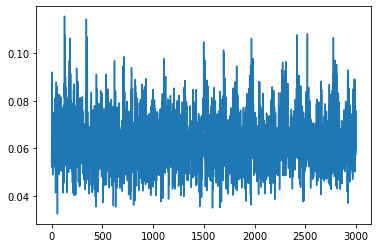

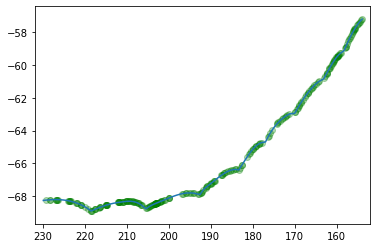

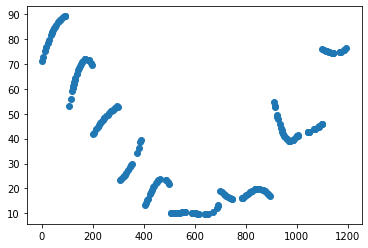

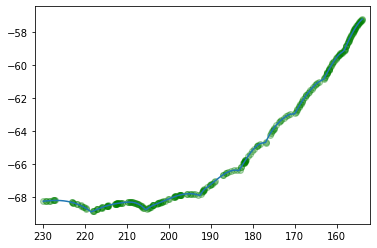

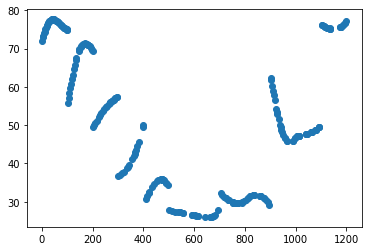

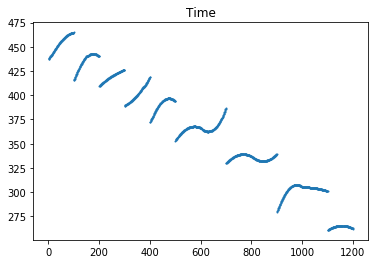

In [90]:
bestFit, finalFit = analyze_fit(opt, sidonCurve, 0.05)

{'loss': 0.039594815665984814, 'parameters': array([0.3149522, 0.6750248])}

{'loss': 0.3719790407296444, 'parameters': array([0.09061902, 0.44637801])}

[113.38279269   0.70752232]
[32.62284749  0.50174021]


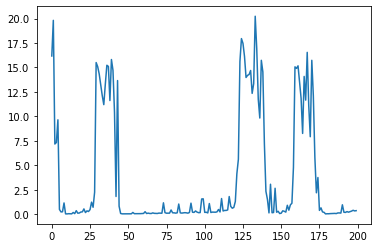

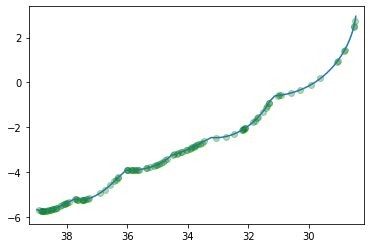

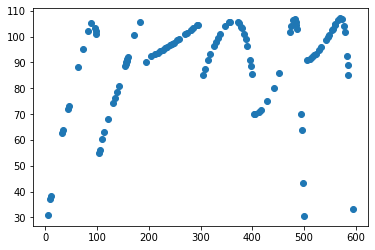

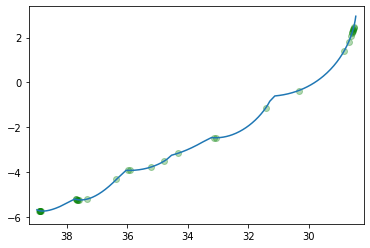

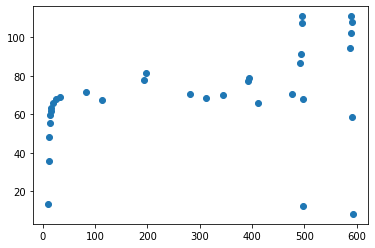

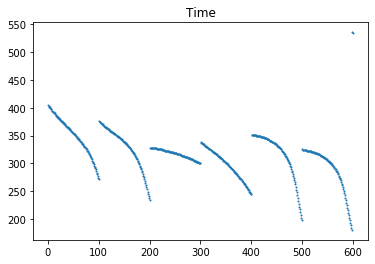

In [171]:
bestFit, finalFit = analyze_fit(opt, sidonCurve, 0.05)

In [86]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/sidonFits.gz', index=False, encoding='utf-8', compression='gzip')
df.to_csv('./output/sidonBestFit.gz', index=False, encoding='utf-8', compression='gzip')

In [85]:
bestFit

pointNumber         lon        lat  time   heading_x   heading_y  \
77                1  153.960000 -57.200000    77  283.799485  283.843981   
437               2  154.007603 -57.211804    77  284.053860  283.892550   
798               3  154.055059 -57.223795    78  284.307477  284.422881   
1158              4  154.102370 -57.235973    78  284.560299  284.471058   
1519              5  154.149539 -57.248335    79  284.812287  284.999190   
...             ...         ...        ...   ...         ...         ...   
430463         1196  229.491713 -68.243761   263  271.602757  271.655007   
430823         1197  229.599320 -68.246821   263  271.654365  271.760416   
431183         1198  229.706952 -68.249977   263  271.704653  271.865847   
431543         1199  229.814609 -68.253227   263  271.753623  271.971298   
431902         1200  229.922292 -68.256569   262  271.801276  271.640942   

           stress  deltaHeading  deltaStress  overallMaxStress  stressPctOfMax  
77      71.346371      0.044495     0.857414         102.15689        0.698400  
437     71.323906      0.161310     0.857380         102.15689        0.698180  
798     72.152590      0.115404     0.851250         102.15689        0.706292  
1158    72.129898      0.089241     0.851225         102.15689        0.706070  
1519    72.951880      0.186904     0.844771         102.15689        0.714116  
...           ...           ...          ...               ...             ...  
430463  76.309536      0.052250    -0.613521         102.15689        0.746984  
430823  76.314748      0.106052    -0.613202         102.15689        0.747035  
431183  76.319774      0.161193    -0.612882         102.15689        0.747084  
431543  76.324615      0.217675    -0.612561         102.15689        0.747131  
431902  76.941509      0.160334    -0.603855         102.15689        0.753170  

[1200 rows x 11 columns]

### Carly

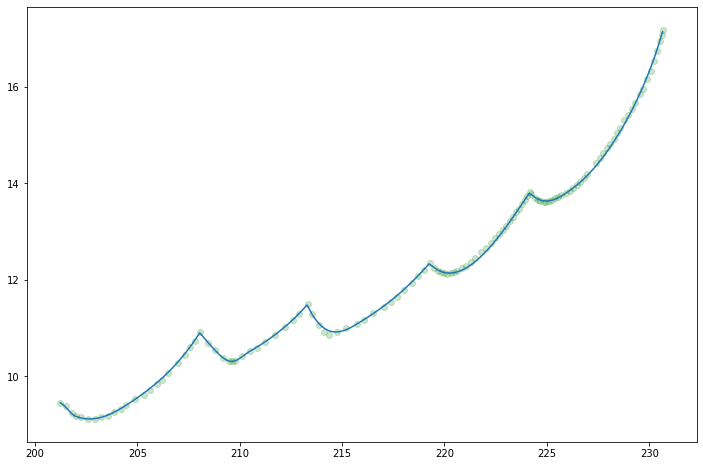

In [138]:
carly = pd.read_csv("./obsData/CarlyLonLatCut.txt", header=None, sep='  ', names=['lon', 'lat'], engine='python')
carly = carly.sort_values(['lon', 'lat'])

carly_arcs = [
    carly[0:23],
    carly[23:38],
    carly[38:55],
    carly[55:82],
    carly[82:]
]


carlyCurve = createCycloidBezier(carly_arcs, maxError=0.0085)
plt.figure(figsize=(12, 8))
plt.plot(carlyCurve['lon'], carlyCurve['lat'])
plt.scatter(carly['lon'], carly['lat'], color='green', alpha='0.2')

#### Test with no phase

(1100, 5)

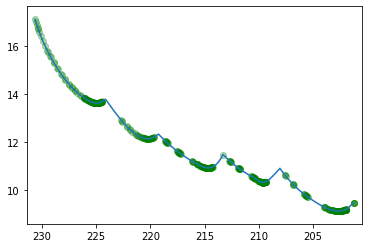

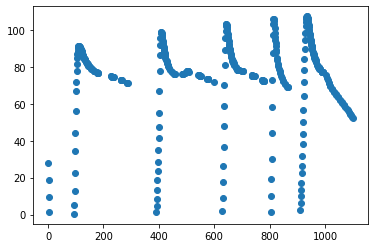

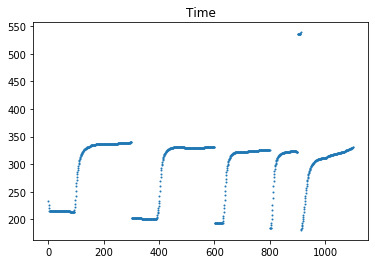

In [140]:
data = direct_fit(carlyCurve, 0.25)

### Dirk

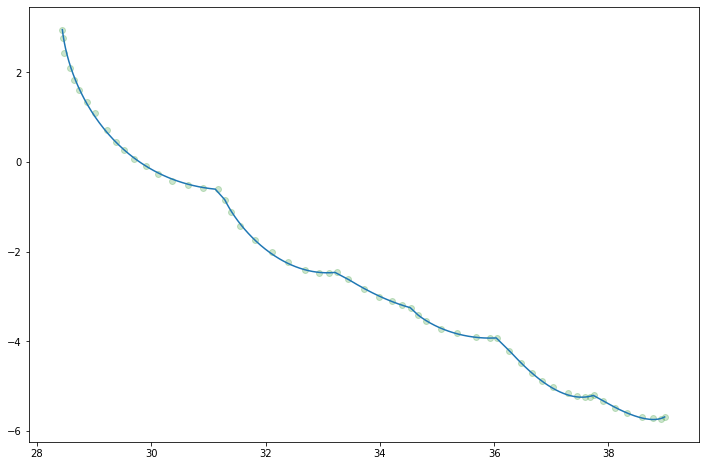

In [167]:
dirk = pd.read_csv("./obsData/DirkLonLat.txt", header=None, sep='\t', names=['lon', 'lat'])
dirk = dirk.sort_values(['lon', 'lat'])

dirk_arcs = [
    dirk[0:18],
    dirk[18:28],
    dirk[28:34],
    dirk[34:41],
    dirk[41:51],
    dirk[51:]
]

dirkCurve = createCycloidBezier(dirk_arcs)
plt.figure(figsize=(12, 8))
plt.plot(dirkCurve['lon'], dirkCurve['lat'])
plt.scatter(dirk['lon'], dirk['lat'], color='green', alpha='0.2')

In [175]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    dirkCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=600,
    verbose=True,
    batch_size=16
)

Iteration 1/600 -- Loss Output: 0.06388306292786698 -- Moving Avg Loss: 0.06388306292786698
	Parameters used: [0.2252998068350126, 0.7293183137223386]
Iteration 2/600 -- Loss Output: 0.13463547845674012 -- Moving Avg Loss: 0.09925927069230356
	Parameters used: [0.17529981 0.67931833]
Iteration 3/600 -- Loss Output: 0.2015100229196462 -- Moving Avg Loss: 0.13334285476808444
	Parameters used: [0.1353574  0.64123427]
Iteration 4/600 -- Loss Output: 1.8246344533693557 -- Moving Avg Loss: 0.5561657544184022
	Parameters used: [0.09747556 0.60389655]
Iteration 5/600 -- Loss Output: 2.907994901199446 -- Moving Avg Loss: 1.026531583774611
	Parameters used: [0.0672541  0.57365686]
Iteration 6/600 -- Loss Output: 14.351564240895506 -- Moving Avg Loss: 3.2473703599614265
	Parameters used: [0.04253536 0.54891018]
Iteration 7/600 -- Loss Output: 16.26057441070535 -- Moving Avg Loss: 5.1063995100677015
	Parameters used: [0.01641676 0.52279137]
Iteration 8/600 -- Loss Output: 15.699278237434822 -- Mov

Iteration 63/600 -- Loss Output: 0.5661858415985159 -- Moving Avg Loss: 1.036404294739063
	Parameters used: [0.45251947 0.32417939]
Iteration 64/600 -- Loss Output: 1.2823896436185944 -- Moving Avg Loss: 1.0750580416775315
	Parameters used: [0.45162044 0.32328037]
Iteration 65/600 -- Loss Output: 2.5199975673921147 -- Moving Avg Loss: 0.790030420490263
	Parameters used: [0.45079954 0.3224595 ]
Iteration 66/600 -- Loss Output: 0.09395062593587553 -- Moving Avg Loss: 0.7642344484820629
	Parameters used: [0.44903032 0.3206902 ]
Iteration 67/600 -- Loss Output: 0.5115205907158102 -- Moving Avg Loss: 0.7763687155431558
	Parameters used: [0.44741577 0.31907558]
Iteration 68/600 -- Loss Output: 0.09756550134813878 -- Moving Avg Loss: 0.6040321842761124
	Parameters used: [0.44595114 0.31761089]
Iteration 69/600 -- Loss Output: 0.12143362664451911 -- Moving Avg Loss: 0.6039840971288758
	Parameters used: [0.44462201 0.3162817 ]
Iteration 70/600 -- Loss Output: 1.660503156184923 -- Moving Avg Los

Iteration 125/600 -- Loss Output: 0.47245051938023575 -- Moving Avg Loss: 0.44760867168583496
	Parameters used: [0.32837571 0.20003169]
Iteration 126/600 -- Loss Output: 0.08312143675373906 -- Moving Avg Loss: 0.4452961224659693
	Parameters used: [0.32221091 0.19386669]
Iteration 127/600 -- Loss Output: 0.18060121282810712 -- Moving Avg Loss: 0.4009556873278688
	Parameters used: [0.31663872 0.18829434]
Iteration 128/600 -- Loss Output: 0.13299917145726953 -- Moving Avg Loss: 0.3646699212602736
	Parameters used: [0.31160247 0.18325794]
Iteration 129/600 -- Loss Output: 0.08660203193190652 -- Moving Avg Loss: 0.3631748805592342
	Parameters used: [0.30705033 0.17870565]
Iteration 130/600 -- Loss Output: 0.15289418914854713 -- Moving Avg Loss: 0.36462315512213406
	Parameters used: [0.30293608 0.17459128]
Iteration 131/600 -- Loss Output: 0.13276799033052838 -- Moving Avg Loss: 0.3660399839772571
	Parameters used: [0.2992179  0.17087298]
Iteration 132/600 -- Loss Output: 0.11532582602907757

Iteration 186/600 -- Loss Output: 0.1418059028813818 -- Moving Avg Loss: 0.4005327298977409
	Parameters used: [0.25120194 0.12285553]
Iteration 187/600 -- Loss Output: 0.18683981561774618 -- Moving Avg Loss: 0.4029468366812889
	Parameters used: [0.25082945 0.12248302]
Iteration 188/600 -- Loss Output: 0.13989737081308742 -- Moving Avg Loss: 0.4013932403221619
	Parameters used: [0.25049255 0.12214611]
Iteration 189/600 -- Loss Output: 0.16278090297310183 -- Moving Avg Loss: 0.4008969755457855
	Parameters used: [0.25014458 0.12179812]
Iteration 190/600 -- Loss Output: 1.5787592723658375 -- Moving Avg Loss: 0.4573705847108368
	Parameters used: [0.24982199 0.12147552]
Iteration 191/600 -- Loss Output: 0.8304382622480287 -- Moving Avg Loss: 0.4851427297692992
	Parameters used: [0.24935805 0.12101157]
Iteration 192/600 -- Loss Output: 0.17667623981704444 -- Moving Avg Loss: 0.45114286024320094
	Parameters used: [0.2488883  0.12054181]
Iteration 193/600 -- Loss Output: 0.1806261046539011 -- M

Iteration 247/600 -- Loss Output: 0.1942540584280938 -- Moving Avg Loss: 0.48352110390979886
	Parameters used: [0.21982736 0.09147993]
Iteration 248/600 -- Loss Output: 0.2163718783049062 -- Moving Avg Loss: 0.4849086933950238
	Parameters used: [0.21946243 0.09111499]
Iteration 249/600 -- Loss Output: 0.21164869473667394 -- Moving Avg Loss: 0.4849416249666279
	Parameters used: [0.21911858 0.09077113]
Iteration 250/600 -- Loss Output: 1.766556435124807 -- Moving Avg Loss: 0.5074929340570615
	Parameters used: [0.21880244 0.09045498]
Iteration 251/600 -- Loss Output: 0.1809686223386387 -- Moving Avg Loss: 0.508663007054177
	Parameters used: [0.21805138 0.0897039 ]
Iteration 252/600 -- Loss Output: 0.21134830853548417 -- Moving Avg Loss: 0.40193576754104543
	Parameters used: [0.21735845 0.08901095]
Iteration 253/600 -- Loss Output: 2.1144515959320493 -- Moving Avg Loss: 0.47851305786593473
	Parameters used: [0.21673148 0.08838396]
Iteration 254/600 -- Loss Output: 0.21595582675418046 -- Mo

Iteration 308/600 -- Loss Output: 0.3895870360147844 -- Moving Avg Loss: 0.7769443996478548
	Parameters used: [0.17948141 0.05113269]
Iteration 309/600 -- Loss Output: 0.27554196122600666 -- Moving Avg Loss: 0.7129695537208791
	Parameters used: [0.17875831 0.05040957]
Iteration 310/600 -- Loss Output: 1.0774802848169625 -- Moving Avg Loss: 0.7095910002918763
	Parameters used: [0.17809553 0.04974677]
Iteration 311/600 -- Loss Output: 0.26814499417402127 -- Moving Avg Loss: 0.7013709662127426
	Parameters used: [0.17733521 0.04898642]
Iteration 312/600 -- Loss Output: 1.2748068041265026 -- Moving Avg Loss: 0.7426061181979934
	Parameters used: [0.1766441  0.04829528]
Iteration 313/600 -- Loss Output: 0.2978397557638192 -- Moving Avg Loss: 0.7434861312306618
	Parameters used: [0.17597998 0.04763115]
Iteration 314/600 -- Loss Output: 2.581789104772578 -- Moving Avg Loss: 0.832054591790138
	Parameters used: [0.17498855 0.04663968]
Iteration 315/600 -- Loss Output: 0.2540731890425875 -- Moving

Iteration 370/600 -- Loss Output: 0.268203321204454 -- Moving Avg Loss: 0.9241081584597183
	Parameters used: [0.11611729 0.09029206]
Iteration 371/600 -- Loss Output: 0.5565954690125796 -- Moving Avg Loss: 0.9030431411079755
	Parameters used: [0.11517072 0.08935996]
Iteration 372/600 -- Loss Output: 0.4448547107636996 -- Moving Avg Loss: 0.9074910567807861
	Parameters used: [0.11431492 0.08851717]
Iteration 373/600 -- Loss Output: 0.3633625737877874 -- Moving Avg Loss: 0.903775210159255
	Parameters used: [0.11351584 0.08772939]
Iteration 374/600 -- Loss Output: 0.43271439667725786 -- Moving Avg Loss: 0.8965287054208505
	Parameters used: [0.11278378 0.08700734]
Iteration 375/600 -- Loss Output: 0.48986530774868986 -- Moving Avg Loss: 0.8939938592795998
	Parameters used: [0.11212146 0.08635402]
Iteration 376/600 -- Loss Output: 0.5544696541957965 -- Moving Avg Loss: 0.8520313727241772
	Parameters used: [0.11129306 0.08553053]
Iteration 377/600 -- Loss Output: 0.5316617454224604 -- Moving

Iteration 432/600 -- Loss Output: 15.209659523205358 -- Moving Avg Loss: 10.832802018468515
	Parameters used: [0.76437441 0.44314597]
Iteration 433/600 -- Loss Output: 15.085797096448525 -- Moving Avg Loss: 11.269339456018898
	Parameters used: [0.74923731 0.42826003]
Iteration 434/600 -- Loss Output: 11.732924016885192 -- Moving Avg Loss: 11.531609112512985
	Parameters used: [0.72987707 0.40904885]
Iteration 435/600 -- Loss Output: 10.015861638803752 -- Moving Avg Loss: 11.76401318608018
	Parameters used: [0.70215331 0.38141419]
Iteration 436/600 -- Loss Output: 12.685316403708448 -- Moving Avg Loss: 12.033758650618374
	Parameters used: [0.67681489 0.35615613]
Iteration 437/600 -- Loss Output: 14.299003111176727 -- Moving Avg Loss: 12.308942997289007
	Parameters used: [0.6531179  0.33253173]
Iteration 438/600 -- Loss Output: 14.169550946606437 -- Moving Avg Loss: 12.487613354033595
	Parameters used: [0.63176143 0.31124067]
Iteration 439/600 -- Loss Output: 11.781347088491174 -- Moving 

Iteration 493/600 -- Loss Output: 0.11215501401658286 -- Moving Avg Loss: 0.2567862504748197
	Parameters used: [0.15260935 0.491174  ]
Iteration 494/600 -- Loss Output: 0.17012643981596093 -- Moving Avg Loss: 0.2600448168768569
	Parameters used: [0.15226643 0.49083163]
Iteration 495/600 -- Loss Output: 0.7723103032435846 -- Moving Avg Loss: 0.2857255197287228
	Parameters used: [0.15195868 0.49052438]
Iteration 496/600 -- Loss Output: 0.18012638019154684 -- Moving Avg Loss: 0.28852164449638534
	Parameters used: [0.15164713 0.49021334]
Iteration 497/600 -- Loss Output: 0.16995505947528994 -- Moving Avg Loss: 0.2840463192120417
	Parameters used: [0.1513491 0.4899158]
Iteration 498/600 -- Loss Output: 0.14719232738897692 -- Moving Avg Loss: 0.27824699441499495
	Parameters used: [0.15107002 0.48963718]
Iteration 499/600 -- Loss Output: 0.15674140395361688 -- Moving Avg Loss: 0.28003977222715076
	Parameters used: [0.15080075 0.48936835]
Iteration 500/600 -- Loss Output: 0.14713988946712556 -

Iteration 554/600 -- Loss Output: 0.22718403063986295 -- Moving Avg Loss: 0.3752846293815212
	Parameters used: [0.12184962 0.46046552]
Iteration 555/600 -- Loss Output: 0.2316852368588233 -- Moving Avg Loss: 0.37724097106580046
	Parameters used: [0.12130388 0.45992069]
Iteration 556/600 -- Loss Output: 0.5999307112971993 -- Moving Avg Loss: 0.39405114045777123
	Parameters used: [0.12073138 0.45934915]
Iteration 557/600 -- Loss Output: 0.17933909125298034 -- Moving Avg Loss: 0.39449245323474147
	Parameters used: [0.12011165 0.45873046]
Iteration 558/600 -- Loss Output: 0.27417678231857256 -- Moving Avg Loss: 0.39892845132249977
	Parameters used: [0.11954673 0.45816647]
Iteration 559/600 -- Loss Output: 0.27165387284539383 -- Moving Avg Loss: 0.35271331880671075
	Parameters used: [0.11901152 0.45763216]
Iteration 560/600 -- Loss Output: 0.2519138161521603 -- Moving Avg Loss: 0.35748499967373554
	Parameters used: [0.11850889 0.45713037]
Iteration 561/600 -- Loss Output: 0.2443861584806256

{'loss': 0.04287612005682687, 'parameters': array([0.30583531, 0.64418576])}

{'loss': 0.7498976723124894, 'parameters': array([0.08446848, 0.42314677])}

[110.10071287   0.67976719]
[30.4086512   0.48083209]


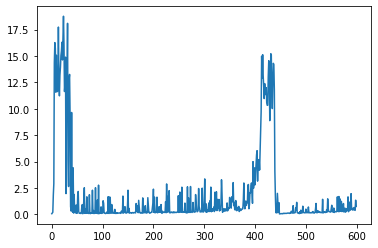

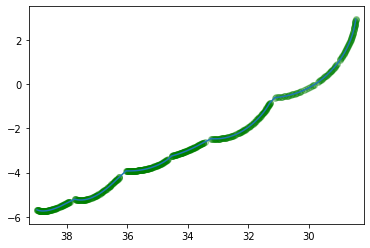

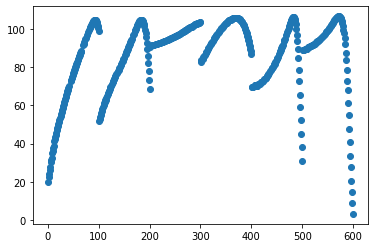

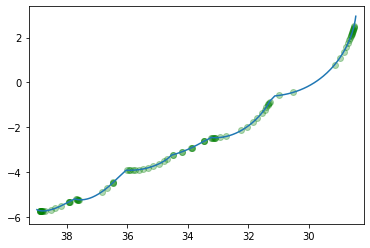

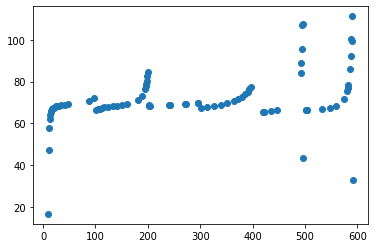

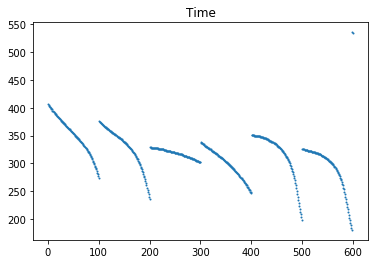

In [178]:
bestFit, finalFit = analyze_fit(opt, dirkCurve, 0.25)

In [177]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/dirkFits.gz', index=False, encoding='utf-8', compression='gzip')
df.to_csv('./output/dirkBestFit.gz', index=False, encoding='utf-8', compression='gzip')

#### Test with no phase

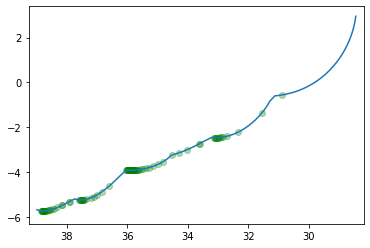

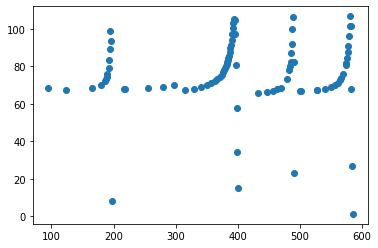

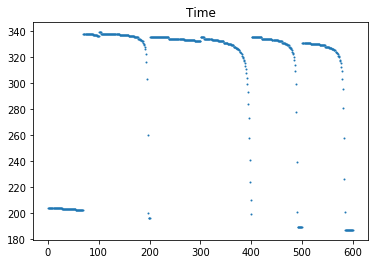

In [168]:
data = direct_fit(dirkCurve, 0.25)

### Yaphet

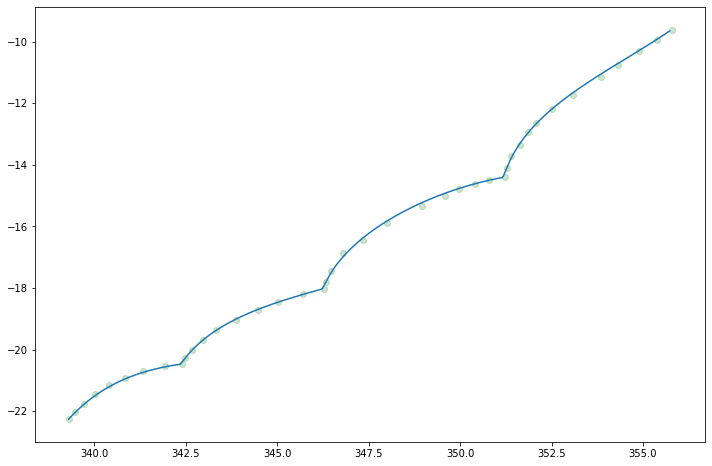

In [193]:
yaphet = pd.read_csv("./obsData/YaphetLonLat.txt", header=None, sep=' ', names=['lon', 'lat'])
yaphet = yaphet.sort_values(['lon', 'lat'])

yaphet_arcs = [
    yaphet[0:9],
    yaphet[9:18],
    yaphet[18:29],
    yaphet[29:]
]

yaphetCurve = createCycloidBezier(yaphet_arcs, maxError=0.12)
plt.figure(figsize=(12, 8))
plt.plot(yaphetCurve['lon'], yaphetCurve['lat'])
plt.scatter(yaphet['lon'], yaphet['lat'], color='green', alpha='0.2')

In [198]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
start_params = [0.29347151, 0.30240127]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    yaphetCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=1200,
    verbose=True,
    batch_size=16
)

Iteration 1/1200 -- Loss Output: 0.847051349240072 -- Moving Avg Loss: 0.847051349240072
	Parameters used: [0.29347151, 0.30240127]
Iteration 2/1200 -- Loss Output: 0.19708026411287566 -- Moving Avg Loss: 0.5220658066764738
	Parameters used: [0.24347151 0.25240127]
Iteration 3/1200 -- Loss Output: 0.0666597889824563 -- Moving Avg Loss: 0.370263800778468
	Parameters used: [0.20184692 0.21089367]
Iteration 4/1200 -- Loss Output: 0.08179445941538022 -- Moving Avg Loss: 0.2981464654376961
	Parameters used: [0.16027111 0.1693724 ]
Iteration 5/1200 -- Loss Output: 0.10305716769008647 -- Moving Avg Loss: 0.25912860588817416
	Parameters used: [0.12542727 0.13457403]
Iteration 6/1200 -- Loss Output: 0.07706396571401755 -- Moving Avg Loss: 0.22878449919248137
	Parameters used: [0.09353701 0.10272442]
Iteration 7/1200 -- Loss Output: 0.07978658928868501 -- Moving Avg Loss: 0.20749908349193905
	Parameters used: [0.05564193 0.06485362]
Iteration 8/1200 -- Loss Output: 0.10179327751983953 -- Moving 

Iteration 63/1200 -- Loss Output: 7.238550896231128 -- Moving Avg Loss: 1.4826962283576952
	Parameters used: [0.68137368 0.1529428 ]
Iteration 64/1200 -- Loss Output: 1.345035923066234 -- Moving Avg Loss: 1.533843260633771
	Parameters used: [0.6586175  0.13009643]
Iteration 65/1200 -- Loss Output: 1.477763341794011 -- Moving Avg Loss: 1.5887746005062116
	Parameters used: [0.62277608 0.09423378]
Iteration 66/1200 -- Loss Output: 0.1909461353969587 -- Moving Avg Loss: 1.5916132282470465
	Parameters used: [0.58992658 0.06136525]
Iteration 67/1200 -- Loss Output: 1.4752537086572277 -- Moving Avg Loss: 1.6450605756819445
	Parameters used: [0.56002964 0.03145112]
Iteration 68/1200 -- Loss Output: 0.15871266406383688 -- Moving Avg Loss: 1.6438596025131145
	Parameters used: [0.53284309 0.00424904]
Iteration 69/1200 -- Loss Output: 2.938170972491898 -- Moving Avg Loss: 1.7562209086912752
	Parameters used: [0.50815311 0.52574936]
Iteration 70/1200 -- Loss Output: 2.168008756017093 -- Moving Avg 

Iteration 124/1200 -- Loss Output: 0.38102718121459767 -- Moving Avg Loss: 0.1982426251536833
	Parameters used: [0.04538198 0.06351192]
Iteration 125/1200 -- Loss Output: 0.7321597075273567 -- Moving Avg Loss: 0.22238580726877774
	Parameters used: [0.04506108 0.06319298]
Iteration 126/1200 -- Loss Output: 0.731853722963156 -- Moving Avg Loss: 0.2470601954547408
	Parameters used: [0.04475169 0.06288559]
Iteration 127/1200 -- Loss Output: 0.619136783499517 -- Moving Avg Loss: 0.2671938759151748
	Parameters used: [0.04441193 0.06254834]
Iteration 128/1200 -- Loss Output: 0.1206576204707861 -- Moving Avg Loss: 0.2660534055322612
	Parameters used: [0.04400786 0.06214759]
Iteration 129/1200 -- Loss Output: 0.5040836669237992 -- Moving Avg Loss: 0.2821499063938925
	Parameters used: [0.04363534 0.06177813]
Iteration 130/1200 -- Loss Output: 0.12828157151684283 -- Moving Avg Loss: 0.2824454594167544
	Parameters used: [0.04320889 0.06135535]
Iteration 131/1200 -- Loss Output: 0.10828914966962214

Iteration 185/1200 -- Loss Output: 0.1283627135960037 -- Moving Avg Loss: 0.18472854803104685
	Parameters used: [0.00593995 0.02442355]
Iteration 186/1200 -- Loss Output: 0.09699618632233878 -- Moving Avg Loss: 0.18341773947539383
	Parameters used: [0.00559743 0.02408414]
Iteration 187/1200 -- Loss Output: 0.10876844272501968 -- Moving Avg Loss: 0.18315123869959915
	Parameters used: [0.00528004 0.02376962]
Iteration 188/1200 -- Loss Output: 0.6073423950461259 -- Moving Avg Loss: 0.2026986468649128
	Parameters used: [0.00498311 0.02347539]
Iteration 189/1200 -- Loss Output: 0.12833257837199075 -- Moving Avg Loss: 0.20267267967420588
	Parameters used: [0.0047004  0.02319525]
Iteration 190/1200 -- Loss Output: 0.12881824859383195 -- Moving Avg Loss: 0.20255372658766294
	Parameters used: [0.00441943 0.02291683]
Iteration 191/1200 -- Loss Output: 0.1434855266984528 -- Moving Avg Loss: 0.2038739615682903
	Parameters used: [0.00413747 0.02263743]
Iteration 192/1200 -- Loss Output: 0.129387118

Iteration 245/1200 -- Loss Output: 0.18209604031793314 -- Moving Avg Loss: 0.19438021131315444
	Parameters used: [0.97340028 0.42309908]
Iteration 246/1200 -- Loss Output: 0.18950543453443644 -- Moving Avg Loss: 0.19762503660954844
	Parameters used: [0.97291986 0.4226237 ]
Iteration 247/1200 -- Loss Output: 0.24515036569744425 -- Moving Avg Loss: 0.194135862766746
	Parameters used: [0.97247742 0.42218587]
Iteration 248/1200 -- Loss Output: 0.13376851208734158 -- Moving Avg Loss: 0.19444963105039761
	Parameters used: [0.97206773 0.42178043]
Iteration 249/1200 -- Loss Output: 0.26638009533580115 -- Moving Avg Loss: 0.18268913934155762
	Parameters used: [0.9716619 0.4213787]
Iteration 250/1200 -- Loss Output: 0.17214859762761026 -- Moving Avg Loss: 0.18474324749933368
	Parameters used: [0.97126521 0.42098597]
Iteration 251/1200 -- Loss Output: 0.24049322908533355 -- Moving Avg Loss: 0.18128886025462787
	Parameters used: [0.97084822 0.42057303]
Iteration 252/1200 -- Loss Output: 0.17751610

Iteration 306/1200 -- Loss Output: 0.4241475068098858 -- Moving Avg Loss: 0.3376457188641848
	Parameters used: [0.94339114 0.39336629]
Iteration 307/1200 -- Loss Output: 0.08848024542925192 -- Moving Avg Loss: 0.3348227964294634
	Parameters used: [0.94257671 0.39255925]
Iteration 308/1200 -- Loss Output: 0.45045962627885516 -- Moving Avg Loss: 0.3407980931618596
	Parameters used: [0.94146873 0.39146134]
Iteration 309/1200 -- Loss Output: 0.6897673228646146 -- Moving Avg Loss: 0.35370941628826796
	Parameters used: [0.9404776 0.3904792]
Iteration 310/1200 -- Loss Output: 1.0476530450949997 -- Moving Avg Loss: 0.38478966861185687
	Parameters used: [0.93941299 0.38942425]
Iteration 311/1200 -- Loss Output: 3.7577666908174736 -- Moving Avg Loss: 0.5176270031996785
	Parameters used: [0.9367191 0.3867548]
Iteration 312/1200 -- Loss Output: 2.0508796236936653 -- Moving Avg Loss: 0.5906097792790631
	Parameters used: [0.93182381 0.38190389]
Iteration 313/1200 -- Loss Output: 4.229879530608227 --

Iteration 368/1200 -- Loss Output: 1.9086881471181365 -- Moving Avg Loss: 0.725070353726155
	Parameters used: [0.56661771 0.01997448]
Iteration 369/1200 -- Loss Output: 1.5859652502017691 -- Moving Avg Loss: 0.7610466396915707
	Parameters used: [0.56390845 0.01728953]
Iteration 370/1200 -- Loss Output: 1.1997976148446514 -- Moving Avg Loss: 0.7787512916242321
	Parameters used: [0.56130548 0.0147099 ]
Iteration 371/1200 -- Loss Output: 0.10906673337785815 -- Moving Avg Loss: 0.7724026954570951
	Parameters used: [0.55893071 0.01235644]
Iteration 372/1200 -- Loss Output: 0.18801308980061945 -- Moving Avg Loss: 0.7457601756701112
	Parameters used: [0.55676628 0.01021142]
Iteration 373/1200 -- Loss Output: 0.15362032120910557 -- Moving Avg Loss: 0.7381981772910373
	Parameters used: [0.55480433 0.00826707]
Iteration 374/1200 -- Loss Output: 0.13153908849065088 -- Moving Avg Loss: 0.7339275610279735
	Parameters used: [0.55302487 0.00650357]
Iteration 375/1200 -- Loss Output: 0.375341269072660

Iteration 429/1200 -- Loss Output: 0.16045435968352897 -- Moving Avg Loss: 0.21513992645191146
	Parameters used: [0.18690794 0.01293671]
Iteration 430/1200 -- Loss Output: 1.2045050498004741 -- Moving Avg Loss: 0.2595487752427996
	Parameters used: [0.18602907 0.01221474]
Iteration 431/1200 -- Loss Output: 0.10866280637127185 -- Moving Avg Loss: 0.260182717946544
	Parameters used: [0.18513669 0.01149311]
Iteration 432/1200 -- Loss Output: 0.14301692451343279 -- Moving Avg Loss: 0.2616069615092655
	Parameters used: [0.18427257 0.01079973]
Iteration 433/1200 -- Loss Output: 0.07378808192518992 -- Moving Avg Loss: 0.2604078474436083
	Parameters used: [0.18348561 0.01016891]
Iteration 434/1200 -- Loss Output: 0.15941504435108556 -- Moving Avg Loss: 0.2630312450879312
	Parameters used: [0.18276384 0.00959131]
Iteration 435/1200 -- Loss Output: 0.5174099156738747 -- Moving Avg Loss: 0.27984305178213115
	Parameters used: [0.18210671 0.00906592]
Iteration 436/1200 -- Loss Output: 0.094137013843

Iteration 490/1200 -- Loss Output: 0.06572326851045629 -- Moving Avg Loss: 0.05881819405737471
	Parameters used: [0.15849082 0.54953862]
Iteration 491/1200 -- Loss Output: 0.05917575570704489 -- Moving Avg Loss: 0.058716841395644266
	Parameters used: [0.15835593 0.54943582]
Iteration 492/1200 -- Loss Output: 0.05834785491307929 -- Moving Avg Loss: 0.05862561154487162
	Parameters used: [0.15821522 0.54932857]
Iteration 493/1200 -- Loss Output: 0.06414335001907186 -- Moving Avg Loss: 0.05878268541276555
	Parameters used: [0.15807058 0.54921833]
Iteration 494/1200 -- Loss Output: 0.059193103895119614 -- Moving Avg Loss: 0.058545914656965514
	Parameters used: [0.15791455 0.5490994 ]
Iteration 495/1200 -- Loss Output: 0.06697451252881471 -- Moving Avg Loss: 0.05873694094284674
	Parameters used: [0.15773294 0.54896098]
Iteration 496/1200 -- Loss Output: 0.04604631108232085 -- Moving Avg Loss: 0.058731473078853715
	Parameters used: [0.15756888 0.54883593]
Iteration 497/1200 -- Loss Output: 0.

Iteration 550/1200 -- Loss Output: 0.06379620613472066 -- Moving Avg Loss: 0.06080041899896131
	Parameters used: [0.14522286 0.53942545]
Iteration 551/1200 -- Loss Output: 0.058144524317006306 -- Moving Avg Loss: 0.06049374145515004
	Parameters used: [0.14501799 0.53926929]
Iteration 552/1200 -- Loss Output: 0.06915729438535717 -- Moving Avg Loss: 0.060707453465538956
	Parameters used: [0.14475661 0.53907006]
Iteration 553/1200 -- Loss Output: 0.06989740305273982 -- Moving Avg Loss: 0.06081369303217388
	Parameters used: [0.14451228 0.53888382]
Iteration 554/1200 -- Loss Output: 0.0633168324877489 -- Moving Avg Loss: 0.06038437330284454
	Parameters used: [0.14428734 0.53871237]
Iteration 555/1200 -- Loss Output: 0.0791605650893927 -- Moving Avg Loss: 0.0609727703735449
	Parameters used: [0.14407566 0.53855102]
Iteration 556/1200 -- Loss Output: 0.07327915316583997 -- Moving Avg Loss: 0.062137934586538754
	Parameters used: [0.14388586 0.53840635]
Iteration 557/1200 -- Loss Output: 0.0569

Iteration 610/1200 -- Loss Output: 0.07715172262893345 -- Moving Avg Loss: 0.06741299553578144
	Parameters used: [0.12127227 0.52116948]
Iteration 611/1200 -- Loss Output: 0.0656526339768214 -- Moving Avg Loss: 0.06743548380885592
	Parameters used: [0.1209352  0.52091255]
Iteration 612/1200 -- Loss Output: 0.07270911699606641 -- Moving Avg Loss: 0.06840228097820704
	Parameters used: [0.12062718 0.52067776]
Iteration 613/1200 -- Loss Output: 0.07262238592894897 -- Moving Avg Loss: 0.06838305647961708
	Parameters used: [0.12034399 0.5204619 ]
Iteration 614/1200 -- Loss Output: 0.07412046528061528 -- Moving Avg Loss: 0.06833180070833506
	Parameters used: [0.12007616 0.52025776]
Iteration 615/1200 -- Loss Output: 0.07082528233704324 -- Moving Avg Loss: 0.06828687618812941
	Parameters used: [0.11978265 0.52003403]
Iteration 616/1200 -- Loss Output: 0.07828256826197898 -- Moving Avg Loss: 0.06855219350900416
	Parameters used: [0.11948959 0.51981065]
Iteration 617/1200 -- Loss Output: 0.07161

Iteration 670/1200 -- Loss Output: 0.08228166459860436 -- Moving Avg Loss: 0.0718307005318918
	Parameters used: [0.10612039 0.50962016]
Iteration 671/1200 -- Loss Output: 0.0864560195855006 -- Moving Avg Loss: 0.07237688661231377
	Parameters used: [0.10589862 0.50945112]
Iteration 672/1200 -- Loss Output: 0.07720716507886821 -- Moving Avg Loss: 0.07269911511177914
	Parameters used: [0.10567646 0.50928179]
Iteration 673/1200 -- Loss Output: 0.07334563106290222 -- Moving Avg Loss: 0.07263242968879552
	Parameters used: [0.10543169 0.50909521]
Iteration 674/1200 -- Loss Output: 0.06044750080088462 -- Moving Avg Loss: 0.07189929398738798
	Parameters used: [0.1052038  0.50892151]
Iteration 675/1200 -- Loss Output: 0.06873046167437416 -- Moving Avg Loss: 0.07194839145211268
	Parameters used: [0.10498719 0.5087564 ]
Iteration 676/1200 -- Loss Output: 0.07325854896584985 -- Moving Avg Loss: 0.07192014819601503
	Parameters used: [0.10475068 0.50857612]
Iteration 677/1200 -- Loss Output: 0.049092

Iteration 730/1200 -- Loss Output: 0.10684538145174241 -- Moving Avg Loss: 0.07886006758017443
	Parameters used: [0.0466068  0.46420961]
Iteration 731/1200 -- Loss Output: 0.11261321171398493 -- Moving Avg Loss: 0.08078235592243621
	Parameters used: [0.04067729 0.45968311]
Iteration 732/1200 -- Loss Output: 0.10108590300255331 -- Moving Avg Loss: 0.0816507484463819
	Parameters used: [0.03533417 0.45560425]
Iteration 733/1200 -- Loss Output: 0.13111846318071657 -- Moving Avg Loss: 0.08395426669192935
	Parameters used: [0.03049816 0.45191253]
Iteration 734/1200 -- Loss Output: 0.10592272237718423 -- Moving Avg Loss: 0.0848209218074318
	Parameters used: [0.02614074 0.44858617]
Iteration 735/1200 -- Loss Output: 0.09241771494610748 -- Moving Avg Loss: 0.08503072395075069
	Parameters used: [0.02221244 0.44558739]
Iteration 736/1200 -- Loss Output: 0.13372104027698697 -- Moving Avg Loss: 0.08667087817739358
	Parameters used: [0.01865167 0.4428692 ]
Iteration 737/1200 -- Loss Output: 0.112131

Iteration 791/1200 -- Loss Output: 0.11877150464177523 -- Moving Avg Loss: 0.16518908854880895
	Parameters used: [0.97419554 0.40871941]
Iteration 792/1200 -- Loss Output: 0.22062387189316582 -- Moving Avg Loss: 0.16912856778295565
	Parameters used: [0.97355464 0.40823052]
Iteration 793/1200 -- Loss Output: 0.1347444792246769 -- Moving Avg Loss: 0.1695865146792127
	Parameters used: [0.97296269 0.40777897]
Iteration 794/1200 -- Loss Output: 0.216855881156392 -- Moving Avg Loss: 0.17341392501919695
	Parameters used: [0.97241327 0.40735987]
Iteration 795/1200 -- Loss Output: 0.2214065096763525 -- Moving Avg Loss: 0.17717507803146218
	Parameters used: [0.9718918  0.40696208]
Iteration 796/1200 -- Loss Output: 0.2375828452081402 -- Moving Avg Loss: 0.1786623874781903
	Parameters used: [0.97131273 0.40652036]
Iteration 797/1200 -- Loss Output: 0.28040032993685776 -- Moving Avg Loss: 0.18266115277511022
	Parameters used: [0.9705704 0.4059541]
Iteration 798/1200 -- Loss Output: 0.2760366445544

Iteration 852/1200 -- Loss Output: 4.219371243063688 -- Moving Avg Loss: 5.575612879638535
	Parameters used: [0.34960504 0.81419388]
Iteration 853/1200 -- Loss Output: 2.2205838470490886 -- Moving Avg Loss: 5.336818081780155
	Parameters used: [0.33932975 0.80616296]
Iteration 854/1200 -- Loss Output: 3.2742301059079812 -- Moving Avg Loss: 4.926880004547283
	Parameters used: [0.32906489 0.79815642]
Iteration 855/1200 -- Loss Output: 1.4602209582924315 -- Moving Avg Loss: 4.592928886819605
	Parameters used: [0.31669511 0.78854752]
Iteration 856/1200 -- Loss Output: 1.6016993733275493 -- Moving Avg Loss: 4.322451426113989
	Parameters used: [0.30546029 0.77982088]
Iteration 857/1200 -- Loss Output: 0.04944338746271878 -- Moving Avg Loss: 3.8724752686418067
	Parameters used: [0.29524523 0.77188695]
Iteration 858/1200 -- Loss Output: 0.07766664538013757 -- Moving Avg Loss: 3.4712806287028366
	Parameters used: [0.28602996 0.76472963]
Iteration 859/1200 -- Loss Output: 1.5506595881231628 -- Mo

Iteration 913/1200 -- Loss Output: 0.04683545240514282 -- Moving Avg Loss: 0.05864252235889657
	Parameters used: [0.18606867 0.68715953]
Iteration 914/1200 -- Loss Output: 0.0543748665528883 -- Moving Avg Loss: 0.058683661792271274
	Parameters used: [0.18565008 0.6868358 ]
Iteration 915/1200 -- Loss Output: 0.0533226488366372 -- Moving Avg Loss: 0.05825262057589572
	Parameters used: [0.18527237 0.6865437 ]
Iteration 916/1200 -- Loss Output: 0.0531929250726068 -- Moving Avg Loss: 0.05819752142695928
	Parameters used: [0.18492374 0.68627408]
Iteration 917/1200 -- Loss Output: 0.05693700905314475 -- Moving Avg Loss: 0.05860610415351118
	Parameters used: [0.18459967 0.68602345]
Iteration 918/1200 -- Loss Output: 0.05034859277157861 -- Moving Avg Loss: 0.058504317268783336
	Parameters used: [0.18430577 0.68579616]
Iteration 919/1200 -- Loss Output: 0.04401902020650043 -- Moving Avg Loss: 0.05863085895352525
	Parameters used: [0.18402364 0.68557796]
Iteration 920/1200 -- Loss Output: 0.05160

Iteration 973/1200 -- Loss Output: 0.04727547643872105 -- Moving Avg Loss: 0.05411777400609119
	Parameters used: [0.17108836 0.67557253]
Iteration 974/1200 -- Loss Output: 0.0577571756379965 -- Moving Avg Loss: 0.0544523949970532
	Parameters used: [0.17088865 0.67541805]
Iteration 975/1200 -- Loss Output: 0.06126544353815924 -- Moving Avg Loss: 0.0546404837057265
	Parameters used: [0.17071087 0.67528054]
Iteration 976/1200 -- Loss Output: 0.04295383904134045 -- Moving Avg Loss: 0.054186204315401935
	Parameters used: [0.1705316  0.67514187]
Iteration 977/1200 -- Loss Output: 0.0519230985495073 -- Moving Avg Loss: 0.053346435231863915
	Parameters used: [0.17029382 0.67495795]
Iteration 978/1200 -- Loss Output: 0.05412875920691284 -- Moving Avg Loss: 0.053419202752944504
	Parameters used: [0.17007084 0.67478547]
Iteration 979/1200 -- Loss Output: 0.0676397359015447 -- Moving Avg Loss: 0.05412708539532666
	Parameters used: [0.16986052 0.67462279]
Iteration 980/1200 -- Loss Output: 0.065342

Iteration 1033/1200 -- Loss Output: 0.07124287634283685 -- Moving Avg Loss: 0.05629721707987474
	Parameters used: [0.15446377 0.66271332]
Iteration 1034/1200 -- Loss Output: 0.0647922355622595 -- Moving Avg Loss: 0.056748936471715083
	Parameters used: [0.15420242 0.66251117]
Iteration 1035/1200 -- Loss Output: 0.06963242332949932 -- Moving Avg Loss: 0.05719111574739541
	Parameters used: [0.15396244 0.66232554]
Iteration 1036/1200 -- Loss Output: 0.06722279554351976 -- Moving Avg Loss: 0.05728909435589689
	Parameters used: [0.1537431  0.66215588]
Iteration 1037/1200 -- Loss Output: 0.05883493240795495 -- Moving Avg Loss: 0.057731390402898076
	Parameters used: [0.15351884 0.66198241]
Iteration 1038/1200 -- Loss Output: 0.06592619196093057 -- Moving Avg Loss: 0.05810093584379609
	Parameters used: [0.15330826 0.66181953]
Iteration 1039/1200 -- Loss Output: 0.0687377798859601 -- Moving Avg Loss: 0.058134662898800926
	Parameters used: [0.15309529 0.6616548 ]
Iteration 1040/1200 -- Loss Outpu

Iteration 1093/1200 -- Loss Output: 0.07416369465253281 -- Moving Avg Loss: 0.05967403412138241
	Parameters used: [0.13843888 0.65031797]
Iteration 1094/1200 -- Loss Output: 0.06312135768169778 -- Moving Avg Loss: 0.05983766377995534
	Parameters used: [0.13801292 0.64998849]
Iteration 1095/1200 -- Loss Output: 0.05630470701550599 -- Moving Avg Loss: 0.0598880119783678
	Parameters used: [0.1375588  0.64963723]
Iteration 1096/1200 -- Loss Output: 0.07797260687060414 -- Moving Avg Loss: 0.060257035410813925
	Parameters used: [0.13714108 0.64931412]
Iteration 1097/1200 -- Loss Output: 0.05410578774307145 -- Moving Avg Loss: 0.060095956292264475
	Parameters used: [0.13676769 0.6490253 ]
Iteration 1098/1200 -- Loss Output: 0.049105847880307786 -- Moving Avg Loss: 0.059716292293331384
	Parameters used: [0.13638317 0.64872787]
Iteration 1099/1200 -- Loss Output: 0.05939419970102958 -- Moving Avg Loss: 0.059758545615700494
	Parameters used: [0.13593362 0.64838014]
Iteration 1100/1200 -- Loss Ou

Iteration 1153/1200 -- Loss Output: 0.0823900266466852 -- Moving Avg Loss: 0.07965947440227915
	Parameters used: [0.07715683 0.60290695]
Iteration 1154/1200 -- Loss Output: 0.06755622524134769 -- Moving Avg Loss: 0.07912838091529609
	Parameters used: [0.07675039 0.60259252]
Iteration 1155/1200 -- Loss Output: 0.09496430205407518 -- Moving Avg Loss: 0.07984373355211051
	Parameters used: [0.07633596 0.60227192]
Iteration 1156/1200 -- Loss Output: 0.09108985159739356 -- Moving Avg Loss: 0.08029207233158157
	Parameters used: [0.07595602 0.60197799]
Iteration 1157/1200 -- Loss Output: 0.08227084640142517 -- Moving Avg Loss: 0.0805924639713831
	Parameters used: [0.07560771 0.60170854]
Iteration 1158/1200 -- Loss Output: 0.09501149096637458 -- Moving Avg Loss: 0.08132124725393065
	Parameters used: [0.07527532 0.6014514 ]
Iteration 1159/1200 -- Loss Output: 0.08523375112772479 -- Moving Avg Loss: 0.08134517628817528
	Parameters used: [0.07497504 0.6012191 ]
Iteration 1160/1200 -- Loss Output: 

{'loss': 0.03204536853037128, 'parameters': array([0.20554111, 0.70222685])}

{'loss': 0.10467791150842697, 'parameters': array([0.06292179, 0.59189469])}

[73.99479805  0.73200417]
[22.65184505  0.63270522]


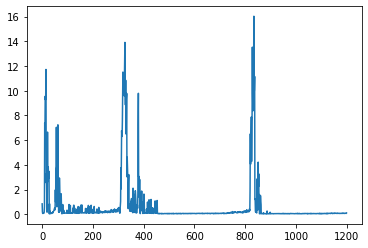

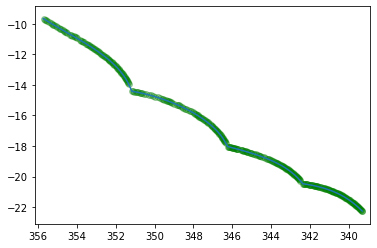

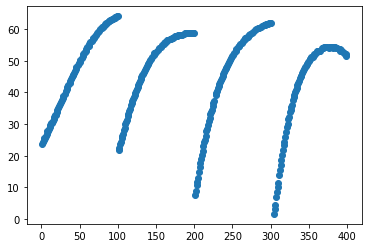

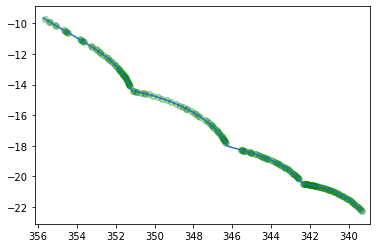

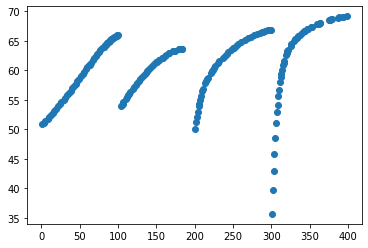

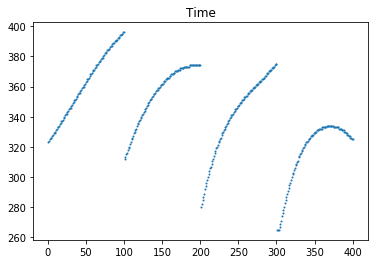

In [199]:
bestFit, finalFit = analyze_fit(opt, yaphetCurve, 0.25)

In [200]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/yahpetFits.gz', index=False, encoding='utf-8', compression='gzip')
bestFit.to_csv('./output/yaphetBestFit.gz', index=False, encoding='utf-8', compression='gzip')

#### Test with no phase

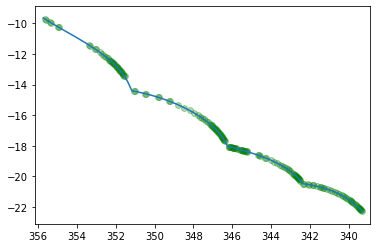

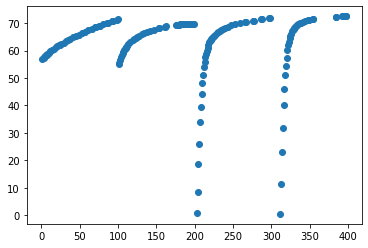

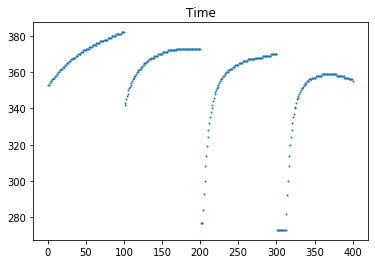

In [194]:
data = direct_fit(yaphetCurve, 0.25)

### Odessa

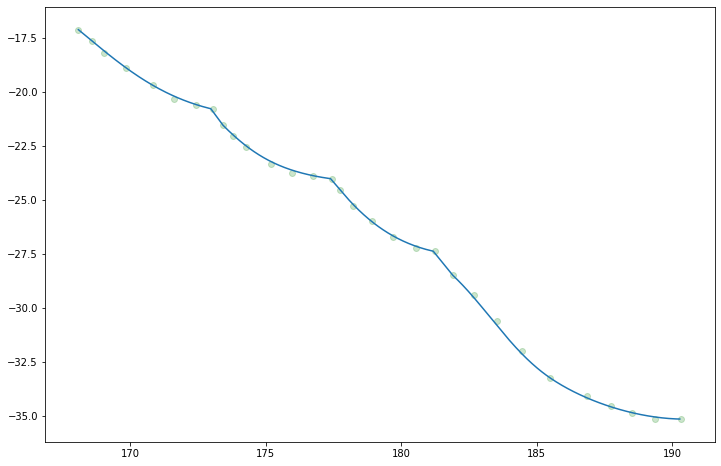

In [214]:
odessa = pd.read_csv("./obsData/OdessaLonLatP180.txt", header=None, sep='\t', names=['lon', 'lat'])
odessa = odessa.sort_values(['lon', 'lat'])

odessa_arcs = [
    odessa[0:8],
    odessa[8:15],
    odessa[15:21],
    odessa[21:]
]


odessaCurve = createCycloidBezier(odessa_arcs)
plt.figure(figsize=(12, 8))
plt.plot(odessaCurve['lon'], odessaCurve['lat'])
plt.scatter(odessa['lon'], odessa['lat'], color='green', alpha='0.2')

In [219]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    yaphetCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 1.1117451160583556 -- Moving Avg Loss: 1.1117451160583556
	Parameters used: [0.4392973856026646, 0.9208180260122879]
Iteration 2/3000 -- Loss Output: 2.6703904499549402 -- Moving Avg Loss: 1.891067783006648
	Parameters used: [0.38929739 0.87081803]
Iteration 3/3000 -- Loss Output: 1.205450522830738 -- Moving Avg Loss: 1.6625286962813446
	Parameters used: [0.35190561 0.83352281]
Iteration 4/3000 -- Loss Output: 0.7410822230796833 -- Moving Avg Loss: 1.4321670779809292
	Parameters used: [0.31668673 0.79836291]
Iteration 5/3000 -- Loss Output: 1.0021573061444693 -- Moving Avg Loss: 1.3461651236136372
	Parameters used: [0.28432336 0.76604242]
Iteration 6/3000 -- Loss Output: 0.35972568682025075 -- Moving Avg Loss: 1.1817585508147395
	Parameters used: [0.25366727 0.73541869]
Iteration 7/3000 -- Loss Output: 0.06322326318159084 -- Moving Avg Loss: 1.0219677954385753
	Parameters used: [0.22674039 0.70851925]
Iteration 8/3000 -- Loss Output: 0.05217446838166485

Iteration 63/3000 -- Loss Output: 0.10352551195329784 -- Moving Avg Loss: 0.3671226751843004
	Parameters used: [0.15090295 0.03373286]
Iteration 64/3000 -- Loss Output: 0.11631281277300758 -- Moving Avg Loss: 0.32610347579789606
	Parameters used: [0.14396925 0.02679984]
Iteration 65/3000 -- Loss Output: 0.7403047343019071 -- Moving Avg Loss: 0.35194319872870944
	Parameters used: [0.13754727 0.02037836]
Iteration 66/3000 -- Loss Output: 0.11093131200661406 -- Moving Avg Loss: 0.3529747401335374
	Parameters used: [0.13117731 0.01400842]
Iteration 67/3000 -- Loss Output: 0.1300767125189981 -- Moving Avg Loss: 0.35472860737410417
	Parameters used: [0.1243791  0.00720948]
Iteration 68/3000 -- Loss Output: 0.7528566150607692 -- Moving Avg Loss: 0.3670653517160499
	Parameters used: [0.11820985 0.00103957]
Iteration 69/3000 -- Loss Output: 0.10951913664250792 -- Moving Avg Loss: 0.3274946446142475
	Parameters used: [0.11250275 0.062043  ]
Iteration 70/3000 -- Loss Output: 0.8320584914176948 --

Iteration 124/3000 -- Loss Output: 0.09338951462120908 -- Moving Avg Loss: 3.361046397562887
	Parameters used: [0.08845974 0.27792389]
Iteration 125/3000 -- Loss Output: 0.09774480227725373 -- Moving Avg Loss: 3.072839087964318
	Parameters used: [0.07418845 0.26372694]
Iteration 126/3000 -- Loss Output: 0.09966438564997984 -- Moving Avg Loss: 2.9479417520474995
	Parameters used: [0.06127075 0.25087639]
Iteration 127/3000 -- Loss Output: 0.09926494702824394 -- Moving Avg Loss: 2.4623095335240777
	Parameters used: [0.04956836 0.23923462]
Iteration 128/3000 -- Loss Output: 0.11171938681893376 -- Moving Avg Loss: 2.0296518372945425
	Parameters used: [0.03898456 0.2287056 ]
Iteration 129/3000 -- Loss Output: 0.09062863300485256 -- Moving Avg Loss: 1.6356006092368005
	Parameters used: [0.02940966 0.21918017]
Iteration 130/3000 -- Loss Output: 0.08844497687601197 -- Moving Avg Loss: 1.45306721227941
	Parameters used: [0.02072495 0.21054009]
Iteration 131/3000 -- Loss Output: 0.155047861429899

Iteration 185/3000 -- Loss Output: 1.4774012999256732 -- Moving Avg Loss: 4.977755291193455
	Parameters used: [0.41710756 0.31007546]
Iteration 186/3000 -- Loss Output: 2.324402107507854 -- Moving Avg Loss: 5.058460692173336
	Parameters used: [0.3846617  0.27671493]
Iteration 187/3000 -- Loss Output: 1.6183409903187587 -- Moving Avg Loss: 5.103156039213306
	Parameters used: [0.35523547 0.24638919]
Iteration 188/3000 -- Loss Output: 1.3093391463673552 -- Moving Avg Loss: 5.115373516053123
	Parameters used: [0.32860822 0.2189152 ]
Iteration 189/3000 -- Loss Output: 0.900835116316454 -- Moving Avg Loss: 5.143341368521838
	Parameters used: [0.30440031 0.19385159]
Iteration 190/3000 -- Loss Output: 0.5527389701342706 -- Moving Avg Loss: 5.1222339622761615
	Parameters used: [0.28251468 0.17117529]
Iteration 191/3000 -- Loss Output: 1.2088485593386735 -- Moving Avg Loss: 5.161524261720458
	Parameters used: [0.26272531 0.15065391]
Iteration 192/3000 -- Loss Output: 1.2950879760710197 -- Moving

Iteration 246/3000 -- Loss Output: 0.07085960296201109 -- Moving Avg Loss: 0.07924514746325756
	Parameters used: [0.07317569 0.69654774]
Iteration 247/3000 -- Loss Output: 0.096052072343241 -- Moving Avg Loss: 0.08001350045965838
	Parameters used: [0.07287666 0.69617417]
Iteration 248/3000 -- Loss Output: 0.07259538861581499 -- Moving Avg Loss: 0.08063336088165801
	Parameters used: [0.07260432 0.69583392]
Iteration 249/3000 -- Loss Output: 0.05757443196638421 -- Moving Avg Loss: 0.08009337877131616
	Parameters used: [0.07221472 0.69534535]
Iteration 250/3000 -- Loss Output: 0.10638102491319079 -- Moving Avg Loss: 0.08083505142760428
	Parameters used: [0.07185347 0.69489229]
Iteration 251/3000 -- Loss Output: 0.11374690069690974 -- Moving Avg Loss: 0.0828435274565429
	Parameters used: [0.071539   0.69449795]
Iteration 252/3000 -- Loss Output: 0.062071844960868115 -- Moving Avg Loss: 0.08248141263532792
	Parameters used: [0.07122119 0.6940993 ]
Iteration 253/3000 -- Loss Output: 0.089398

Iteration 306/3000 -- Loss Output: 0.10912071793802278 -- Moving Avg Loss: 0.1085231683660574
	Parameters used: [0.02040923 0.63030506]
Iteration 307/3000 -- Loss Output: 0.10076568248375568 -- Moving Avg Loss: 0.10895971805806078
	Parameters used: [0.01982837 0.62957578]
Iteration 308/3000 -- Loss Output: 0.13173932783664422 -- Moving Avg Loss: 0.11054647804709955
	Parameters used: [0.01922035 0.62881241]
Iteration 309/3000 -- Loss Output: 0.1103670996273208 -- Moving Avg Loss: 0.11144389293348007
	Parameters used: [0.01865195 0.62809877]
Iteration 310/3000 -- Loss Output: 0.1451807381502627 -- Moving Avg Loss: 0.11252142152100934
	Parameters used: [0.01812184 0.6274332 ]
Iteration 311/3000 -- Loss Output: 0.1405595493640495 -- Moving Avg Loss: 0.114365516575563
	Parameters used: [0.01760862 0.62678885]
Iteration 312/3000 -- Loss Output: 0.13532221608269138 -- Moving Avg Loss: 0.11684527736968744
	Parameters used: [0.01709631 0.62614564]
Iteration 313/3000 -- Loss Output: 0.0955300193

Iteration 367/3000 -- Loss Output: 0.2657952214914917 -- Moving Avg Loss: 0.26810083959958714
	Parameters used: [0.95723507 0.5495678 ]
Iteration 368/3000 -- Loss Output: 0.2527584454247452 -- Moving Avg Loss: 0.2725257614783194
	Parameters used: [0.95569544 0.54763515]
Iteration 369/3000 -- Loss Output: 0.36333159730076836 -- Moving Avg Loss: 0.2812225144079488
	Parameters used: [0.95428095 0.54585957]
Iteration 370/3000 -- Loss Output: 0.27604022705292147 -- Moving Avg Loss: 0.2830033830087101
	Parameters used: [0.95300196 0.54425409]
Iteration 371/3000 -- Loss Output: 0.6690801922926426 -- Moving Avg Loss: 0.30445543084842097
	Parameters used: [0.95182557 0.54277739]
Iteration 372/3000 -- Loss Output: 5.588237337980415 -- Moving Avg Loss: 0.5191697502193825
	Parameters used: [0.94666089 0.53629754]
Iteration 373/3000 -- Loss Output: 7.614183981871084 -- Moving Avg Loss: 0.8182445207394786
	Parameters used: [0.94132697 0.529605  ]
Iteration 374/3000 -- Loss Output: 4.230625215871123 

Iteration 428/3000 -- Loss Output: 0.0815231780449863 -- Moving Avg Loss: 0.19344512461578095
	Parameters used: [0.14214378 0.48721402]
Iteration 429/3000 -- Loss Output: 0.07359291563537682 -- Moving Avg Loss: 0.12006071055144606
	Parameters used: [0.14038522 0.48505918]
Iteration 430/3000 -- Loss Output: 0.06901890941729195 -- Moving Avg Loss: 0.0794721212031395
	Parameters used: [0.13879633 0.4831122 ]
Iteration 431/3000 -- Loss Output: 0.060503343694224575 -- Moving Avg Loss: 0.07954453834730968
	Parameters used: [0.13735347 0.48134414]
Iteration 432/3000 -- Loss Output: 0.06427374104943209 -- Moving Avg Loss: 0.07995324886009493
	Parameters used: [0.13601326 0.47970168]
Iteration 433/3000 -- Loss Output: 0.06981508154735629 -- Moving Avg Loss: 0.08036540400902974
	Parameters used: [0.13479224 0.47820526]
Iteration 434/3000 -- Loss Output: 0.051680283565412696 -- Moving Avg Loss: 0.08022503903136935
	Parameters used: [0.13368637 0.47684992]
Iteration 435/3000 -- Loss Output: 0.0668

Iteration 488/3000 -- Loss Output: 0.059385777242689106 -- Moving Avg Loss: 0.074570759512965
	Parameters used: [0.10230289 0.43834137]
Iteration 489/3000 -- Loss Output: 0.07078306856021767 -- Moving Avg Loss: 0.074926495327729
	Parameters used: [0.10129394 0.43710296]
Iteration 490/3000 -- Loss Output: 0.0894352052571265 -- Moving Avg Loss: 0.07599304349158989
	Parameters used: [0.10038364 0.43598563]
Iteration 491/3000 -- Loss Output: 0.07337865092176624 -- Moving Avg Loss: 0.07624081820485162
	Parameters used: [0.09956261 0.43497788]
Iteration 492/3000 -- Loss Output: 0.0743818312922907 -- Moving Avg Loss: 0.07660497956311284
	Parameters used: [0.09878316 0.43402117]
Iteration 493/3000 -- Loss Output: 0.08979029884071592 -- Moving Avg Loss: 0.0772925383177001
	Parameters used: [0.09806457 0.43313914]
Iteration 494/3000 -- Loss Output: 0.07495788488964725 -- Moving Avg Loss: 0.07689933003446639
	Parameters used: [0.09550165 0.42999364]
Iteration 495/3000 -- Loss Output: 0.0790391579

Iteration 549/3000 -- Loss Output: 0.4528591983831619 -- Moving Avg Loss: 0.16276173523511633
	Parameters used: [0.91672076 0.21101061]
Iteration 550/3000 -- Loss Output: 0.2860743786282049 -- Moving Avg Loss: 0.16966630951283207
	Parameters used: [0.91120251 0.20426109]
Iteration 551/3000 -- Loss Output: 0.510276728014903 -- Moving Avg Loss: 0.18487157497578352
	Parameters used: [0.90621815 0.19816457]
Iteration 552/3000 -- Loss Output: 0.20852894538246872 -- Moving Avg Loss: 0.18763385646716096
	Parameters used: [0.90171794 0.19266018]
Iteration 553/3000 -- Loss Output: 0.4600763575018012 -- Moving Avg Loss: 0.20210565920736262
	Parameters used: [0.89764507 0.18767845]
Iteration 554/3000 -- Loss Output: 0.4261462497243963 -- Moving Avg Loss: 0.2137066541494777
	Parameters used: [0.89396826 0.18318114]
Iteration 555/3000 -- Loss Output: 3.351436526154989 -- Moving Avg Loss: 0.3435584250945686
	Parameters used: [0.89061331 0.17907738]
Iteration 556/3000 -- Loss Output: 3.41749929107291

Iteration 610/3000 -- Loss Output: 0.4204467880326244 -- Moving Avg Loss: 0.18007485483270222
	Parameters used: [0.95007776 0.02980286]
Iteration 611/3000 -- Loss Output: 0.17558188636753783 -- Moving Avg Loss: 0.18403060110326305
	Parameters used: [0.94823478 0.02773228]
Iteration 612/3000 -- Loss Output: 0.15042266954265907 -- Moving Avg Loss: 0.18646151961842503
	Parameters used: [0.94648376 0.02575557]
Iteration 613/3000 -- Loss Output: 0.15325954226359823 -- Moving Avg Loss: 0.18864591771903733
	Parameters used: [0.94484517 0.02390009]
Iteration 614/3000 -- Loss Output: 0.12414038720865372 -- Moving Avg Loss: 0.1891339377598758
	Parameters used: [0.94301476 0.02179699]
Iteration 615/3000 -- Loss Output: 0.4300002913494134 -- Moving Avg Loss: 0.2025178987293797
	Parameters used: [0.94136174 0.0198975 ]
Iteration 616/3000 -- Loss Output: 0.13273968067651853 -- Moving Avg Loss: 0.20359745002580582
	Parameters used: [0.93965074 0.01791998]
Iteration 617/3000 -- Loss Output: 0.78887502

Iteration 671/3000 -- Loss Output: 0.9504746208026479 -- Moving Avg Loss: 0.3331125504338401
	Parameters used: [0.19121059 0.04780096]
Iteration 672/3000 -- Loss Output: 0.09852661626715734 -- Moving Avg Loss: 0.3334797144254733
	Parameters used: [0.18963181 0.0459667 ]
Iteration 673/3000 -- Loss Output: 0.07778014248599435 -- Moving Avg Loss: 0.3338760874062487
	Parameters used: [0.18799083 0.04405642]
Iteration 674/3000 -- Loss Output: 0.09257014549571024 -- Moving Avg Loss: 0.3347809947894891
	Parameters used: [0.18650013 0.04232093]
Iteration 675/3000 -- Loss Output: 0.1105095362904972 -- Moving Avg Loss: 0.3372367311523302
	Parameters used: [0.18512619 0.04072099]
Iteration 676/3000 -- Loss Output: 0.0793321273387343 -- Moving Avg Loss: 0.3378458947576195
	Parameters used: [0.18388769 0.03927876]
Iteration 677/3000 -- Loss Output: 0.09048073727352228 -- Moving Avg Loss: 0.3381111941668021
	Parameters used: [0.18270573 0.03790159]
Iteration 678/3000 -- Loss Output: 0.09856006374548

Iteration 732/3000 -- Loss Output: 0.30717991244555376 -- Moving Avg Loss: 0.14796663592265488
	Parameters used: [0.12688413 0.24077007]
Iteration 733/3000 -- Loss Output: 0.09343482363673006 -- Moving Avg Loss: 0.11499307101042676
	Parameters used: [0.12603686 0.23978198]
Iteration 734/3000 -- Loss Output: 0.05623606942855506 -- Moving Avg Loss: 0.11381258423852499
	Parameters used: [0.12526403 0.23888064]
Iteration 735/3000 -- Loss Output: 0.09013894167031508 -- Moving Avg Loss: 0.11401233695216825
	Parameters used: [0.12454602 0.23804304]
Iteration 736/3000 -- Loss Output: 0.07249877879567772 -- Moving Avg Loss: 0.1134133897702947
	Parameters used: [0.12389169 0.23727967]
Iteration 737/3000 -- Loss Output: 0.06781622633186048 -- Moving Avg Loss: 0.11296611053588862
	Parameters used: [0.12306015 0.23630775]
Iteration 738/3000 -- Loss Output: 0.07734276926032661 -- Moving Avg Loss: 0.11284922171752094
	Parameters used: [0.12230767 0.23542824]
Iteration 739/3000 -- Loss Output: 0.06870

Iteration 792/3000 -- Loss Output: 0.42586880551411044 -- Moving Avg Loss: 0.13404370767944326
	Parameters used: [0.07409715 0.17901266]
Iteration 793/3000 -- Loss Output: 0.09510076847715843 -- Moving Avg Loss: 0.1350022349400636
	Parameters used: [0.07293352 0.17765093]
Iteration 794/3000 -- Loss Output: 0.07431853899863226 -- Moving Avg Loss: 0.13474228152147558
	Parameters used: [0.07185704 0.17639118]
Iteration 795/3000 -- Loss Output: 0.10085032121816093 -- Moving Avg Loss: 0.1354377584402165
	Parameters used: [0.07082513 0.17518358]
Iteration 796/3000 -- Loss Output: 0.09822603702054158 -- Moving Avg Loss: 0.1357433475502279
	Parameters used: [0.06989455 0.17409457]
Iteration 797/3000 -- Loss Output: 0.12483073074766785 -- Moving Avg Loss: 0.13770376099498727
	Parameters used: [0.06898082 0.17302527]
Iteration 798/3000 -- Loss Output: 0.3154563409388265 -- Moving Avg Loss: 0.14598615371320903
	Parameters used: [0.06815576 0.17205974]
Iteration 799/3000 -- Loss Output: 0.21617684

Iteration 852/3000 -- Loss Output: 0.10036185577603117 -- Moving Avg Loss: 0.12476753550471811
	Parameters used: [0.02320014 0.11944862]
Iteration 853/3000 -- Loss Output: 0.4333720924153722 -- Moving Avg Loss: 0.13804065070038646
	Parameters used: [0.02237976 0.11848854]
Iteration 854/3000 -- Loss Output: 0.1158664493998656 -- Moving Avg Loss: 0.1386922011907109
	Parameters used: [0.02152801 0.11749174]
Iteration 855/3000 -- Loss Output: 0.09921674849800569 -- Moving Avg Loss: 0.138084119167862
	Parameters used: [0.02071943 0.11654548]
Iteration 856/3000 -- Loss Output: 0.12713206262351423 -- Moving Avg Loss: 0.1378100878428694
	Parameters used: [0.01998128 0.11568163]
Iteration 857/3000 -- Loss Output: 0.12352916723863364 -- Moving Avg Loss: 0.13614027169659082
	Parameters used: [0.01919027 0.11475592]
Iteration 858/3000 -- Loss Output: 0.12002142216306266 -- Moving Avg Loss: 0.13694584746918906
	Parameters used: [0.01835845 0.11378244]
Iteration 859/3000 -- Loss Output: 0.1161698246

Iteration 913/3000 -- Loss Output: 0.38614243739707615 -- Moving Avg Loss: 0.22876573945777579
	Parameters used: [0.95279457 0.03684945]
Iteration 914/3000 -- Loss Output: 0.15163374391994985 -- Moving Avg Loss: 0.22307718325618894
	Parameters used: [0.95106529 0.03482574]
Iteration 915/3000 -- Loss Output: 0.15295388574206237 -- Moving Avg Loss: 0.2241167384804856
	Parameters used: [0.94942302 0.03290384]
Iteration 916/3000 -- Loss Output: 0.5030641966838394 -- Moving Avg Loss: 0.238208459444199
	Parameters used: [0.94792109 0.03114619]
Iteration 917/3000 -- Loss Output: 0.1046275064300631 -- Moving Avg Loss: 0.23606385564050136
	Parameters used: [0.94654815 0.02953948]
Iteration 918/3000 -- Loss Output: 0.12237176464441535 -- Moving Avg Loss: 0.23591972531656766
	Parameters used: [0.9452597  0.02803166]
Iteration 919/3000 -- Loss Output: 0.17012512264540983 -- Moving Avg Loss: 0.2378612076289553
	Parameters used: [0.94408184 0.02665325]
Iteration 920/3000 -- Loss Output: 0.1380639010

Iteration 974/3000 -- Loss Output: 1.622413227027891 -- Moving Avg Loss: 7.286081722472088
	Parameters used: [0.49573584 0.21474404]
Iteration 975/3000 -- Loss Output: 0.1851082288998299 -- Moving Avg Loss: 7.142868949174187
	Parameters used: [0.48460865 0.19218363]
Iteration 976/3000 -- Loss Output: 0.3538662014936494 -- Moving Avg Loss: 6.93378249499911
	Parameters used: [0.47458278 0.17185602]
Iteration 977/3000 -- Loss Output: 1.8515850845504818 -- Moving Avg Loss: 6.838397749768653
	Parameters used: [0.46555138 0.15354466]
Iteration 978/3000 -- Loss Output: 1.5592528606244225 -- Moving Avg Loss: 6.595483052671336
	Parameters used: [0.45740844 0.13703434]
Iteration 979/3000 -- Loss Output: 1.7922537012101902 -- Moving Avg Loss: 6.376341826637051
	Parameters used: [0.44500836 0.1117392 ]
Iteration 980/3000 -- Loss Output: 1.220833288621991 -- Moving Avg Loss: 6.109209290969899
	Parameters used: [0.43378776 0.08884943]
Iteration 981/3000 -- Loss Output: 1.291419756015547 -- Moving Av

Iteration 1035/3000 -- Loss Output: 0.11363666703047733 -- Moving Avg Loss: 0.20582006916320314
	Parameters used: [0.05829552 0.11410179]
Iteration 1036/3000 -- Loss Output: 0.11210371131216486 -- Moving Avg Loss: 0.20815414096881796
	Parameters used: [0.05569303 0.10905778]
Iteration 1037/3000 -- Loss Output: 0.11388286455052535 -- Moving Avg Loss: 0.15099045949459777
	Parameters used: [0.05334815 0.10451296]
Iteration 1038/3000 -- Loss Output: 0.11603787563921311 -- Moving Avg Loss: 0.10464970347882815
	Parameters used: [0.05123278 0.10041261]
Iteration 1039/3000 -- Loss Output: 0.13393456898582892 -- Moving Avg Loss: 0.10768094487760095
	Parameters used: [0.04932673 0.09671792]
Iteration 1040/3000 -- Loss Output: 0.6615667143169678 -- Moving Avg Loss: 0.13145645723794402
	Parameters used: [0.04760836 0.09338687]
Iteration 1041/3000 -- Loss Output: 0.10088807510994023 -- Moving Avg Loss: 0.13243803840256732
	Parameters used: [0.0450721  0.08836627]
Iteration 1042/3000 -- Loss Output:

Iteration 1095/3000 -- Loss Output: 0.14222576796156156 -- Moving Avg Loss: 0.20054207190932313
	Parameters used: [0.0091589  0.01710085]
Iteration 1096/3000 -- Loss Output: 0.5165720007355831 -- Moving Avg Loss: 0.21573939826059832
	Parameters used: [0.00871923 0.01622566]
Iteration 1097/3000 -- Loss Output: 0.514045050792265 -- Moving Avg Loss: 0.2269988174239858
	Parameters used: [0.00811427 0.01502145]
Iteration 1098/3000 -- Loss Output: 0.12438323034957889 -- Moving Avg Loss: 0.22736500244661687
	Parameters used: [0.0075127 0.013824 ]
Iteration 1099/3000 -- Loss Output: 0.16446675631614444 -- Moving Avg Loss: 0.22861722920083075
	Parameters used: [0.00695733 0.01271851]
Iteration 1100/3000 -- Loss Output: 0.14137330952453853 -- Moving Avg Loss: 0.2306366320508697
	Parameters used: [0.00644818 0.01170502]
Iteration 1101/3000 -- Loss Output: 0.0934844685528839 -- Moving Avg Loss: 0.2284588167524435
	Parameters used: [0.00590821 0.01063018]
Iteration 1102/3000 -- Loss Output: 0.11613

Iteration 1155/3000 -- Loss Output: 17.5749996113788 -- Moving Avg Loss: 10.192148314326332
	Parameters used: [0.85736294 0.66733427]
Iteration 1156/3000 -- Loss Output: 16.762109236718782 -- Moving Avg Loss: 10.856345670106391
	Parameters used: [0.85524064 0.66313404]
Iteration 1157/3000 -- Loss Output: 14.70801033719088 -- Moving Avg Loss: 11.433917474375697
	Parameters used: [0.85329418 0.65928168]
Iteration 1158/3000 -- Loss Output: 16.976196926263015 -- Moving Avg Loss: 12.101169045001154
	Parameters used: [0.85141651 0.65556498]
Iteration 1159/3000 -- Loss Output: 16.139587407135412 -- Moving Avg Loss: 12.72134395493577
	Parameters used: [0.84959747 0.65196392]
Iteration 1160/3000 -- Loss Output: 14.952830316332614 -- Moving Avg Loss: 13.250946343403955
	Parameters used: [0.8479428  0.64868821]
Iteration 1161/3000 -- Loss Output: 15.679655872821447 -- Moving Avg Loss: 13.687370297774855
	Parameters used: [0.84626152 0.64535929]
Iteration 1162/3000 -- Loss Output: 15.7643854285208

Iteration 1216/3000 -- Loss Output: 0.061519078830549835 -- Moving Avg Loss: 0.09797709895929377
	Parameters used: [0.17495796 0.69903552]
Iteration 1217/3000 -- Loss Output: 0.05784345087664707 -- Moving Avg Loss: 0.0967048645809538
	Parameters used: [0.17443004 0.69819815]
Iteration 1218/3000 -- Loss Output: 0.04195618339395638 -- Moving Avg Loss: 0.09468551885654782
	Parameters used: [0.17394819 0.6974317 ]
Iteration 1219/3000 -- Loss Output: 0.060393651682765 -- Moving Avg Loss: 0.09386339534897103
	Parameters used: [0.1735095  0.69673235]
Iteration 1220/3000 -- Loss Output: 0.04316079962741052 -- Moving Avg Loss: 0.054081932693458006
	Parameters used: [0.17311443 0.69610254]
Iteration 1221/3000 -- Loss Output: 0.04644276686353378 -- Moving Avg Loss: 0.05175281090811548
	Parameters used: [0.17275485 0.69552809]
Iteration 1222/3000 -- Loss Output: 0.05456342388080723 -- Moving Avg Loss: 0.051829226785116624
	Parameters used: [0.17236502 0.69488466]
Iteration 1223/3000 -- Loss Output

Iteration 1276/3000 -- Loss Output: 0.05830464406597303 -- Moving Avg Loss: 0.0592597733398856
	Parameters used: [0.15988282 0.67327666]
Iteration 1277/3000 -- Loss Output: 0.06254806629757721 -- Moving Avg Loss: 0.05951805983812836
	Parameters used: [0.15970721 0.67296985]
Iteration 1278/3000 -- Loss Output: 0.061560325026677104 -- Moving Avg Loss: 0.0598888252799033
	Parameters used: [0.15954689 0.67268975]
Iteration 1279/3000 -- Loss Output: 0.07457764900006694 -- Moving Avg Loss: 0.06051095559082134
	Parameters used: [0.15939532 0.67242494]
Iteration 1280/3000 -- Loss Output: 0.06425327513932061 -- Moving Avg Loss: 0.060861764803392365
	Parameters used: [0.1592476  0.67216684]
Iteration 1281/3000 -- Loss Output: 0.05185575740564195 -- Moving Avg Loss: 0.060528348449669395
	Parameters used: [0.1591093  0.67192522]
Iteration 1282/3000 -- Loss Output: 0.07396948390965263 -- Moving Avg Loss: 0.06119058664459367
	Parameters used: [0.15893823 0.67162634]
Iteration 1283/3000 -- Loss Outpu

Iteration 1336/3000 -- Loss Output: 0.05964337100536232 -- Moving Avg Loss: 0.05850687491717776
	Parameters used: [0.14725713 0.65121812]
Iteration 1337/3000 -- Loss Output: 0.06470720307834059 -- Moving Avg Loss: 0.058969421644604586
	Parameters used: [0.14654154 0.64996793]
Iteration 1338/3000 -- Loss Output: 0.0548477649826851 -- Moving Avg Loss: 0.058777985502435154
	Parameters used: [0.1458936  0.64883592]
Iteration 1339/3000 -- Loss Output: 0.06403402777681735 -- Moving Avg Loss: 0.05934491440501009
	Parameters used: [0.14527771 0.64775993]
Iteration 1340/3000 -- Loss Output: 0.048133059116114166 -- Moving Avg Loss: 0.05947414451414991
	Parameters used: [0.14472264 0.64679017]
Iteration 1341/3000 -- Loss Output: 0.056560823606620146 -- Moving Avg Loss: 0.059340395714812685
	Parameters used: [0.14421613 0.64590527]
Iteration 1342/3000 -- Loss Output: 0.058467051599344455 -- Moving Avg Loss: 0.0593777643612933
	Parameters used: [0.14375036 0.64509153]
Iteration 1343/3000 -- Loss Ou

Iteration 1396/3000 -- Loss Output: 0.04960546984920586 -- Moving Avg Loss: 0.06338343890138708
	Parameters used: [0.11811652 0.60030832]
Iteration 1397/3000 -- Loss Output: 0.05595049619006995 -- Moving Avg Loss: 0.0628408141156836
	Parameters used: [0.11784314 0.59983073]
Iteration 1398/3000 -- Loss Output: 0.06854500302386247 -- Moving Avg Loss: 0.06262156733786549
	Parameters used: [0.11758893 0.59938661]
Iteration 1399/3000 -- Loss Output: 0.07404976290432728 -- Moving Avg Loss: 0.06337593816092107
	Parameters used: [0.11735377 0.59897579]
Iteration 1400/3000 -- Loss Output: 0.05386982141653026 -- Moving Avg Loss: 0.06347803844535663
	Parameters used: [0.11712065 0.59856851]
Iteration 1401/3000 -- Loss Output: 0.05583199973290308 -- Moving Avg Loss: 0.06305334709199321
	Parameters used: [0.11689526 0.59817475]
Iteration 1402/3000 -- Loss Output: 0.07613851395052292 -- Moving Avg Loss: 0.06352802770037619
	Parameters used: [0.11668697 0.59781087]
Iteration 1403/3000 -- Loss Output:

Iteration 1456/3000 -- Loss Output: 0.05380645286458812 -- Moving Avg Loss: 0.06897169552973198
	Parameters used: [0.09802116 0.56520424]
Iteration 1457/3000 -- Loss Output: 0.08091717515587271 -- Moving Avg Loss: 0.06934918649380586
	Parameters used: [0.09652594 0.56259261]
Iteration 1458/3000 -- Loss Output: 0.08164976724292851 -- Moving Avg Loss: 0.06998535512014048
	Parameters used: [0.09517872 0.56023951]
Iteration 1459/3000 -- Loss Output: 0.06194631819495317 -- Moving Avg Loss: 0.06945038348375898
	Parameters used: [0.09396397 0.55811778]
Iteration 1460/3000 -- Loss Output: 0.06798451810134833 -- Moving Avg Loss: 0.06921324415987905
	Parameters used: [0.09286539 0.55619897]
Iteration 1461/3000 -- Loss Output: 0.08224174886221418 -- Moving Avg Loss: 0.07002629452832462
	Parameters used: [0.09187194 0.55446376]
Iteration 1462/3000 -- Loss Output: 0.06266281325059309 -- Moving Avg Loss: 0.06942533688847184
	Parameters used: [0.09097687 0.5529004 ]
Iteration 1463/3000 -- Loss Output

Iteration 1516/3000 -- Loss Output: 0.0667565611389757 -- Moving Avg Loss: 0.08427466419337941
	Parameters used: [0.06585499 0.50901844]
Iteration 1517/3000 -- Loss Output: 0.08110226778349172 -- Moving Avg Loss: 0.08415095969659603
	Parameters used: [0.06554845 0.50848299]
Iteration 1518/3000 -- Loss Output: 0.06211321863983329 -- Moving Avg Loss: 0.08334134678056516
	Parameters used: [0.06526467 0.50798728]
Iteration 1519/3000 -- Loss Output: 0.08393492505035262 -- Moving Avg Loss: 0.08291760935688354
	Parameters used: [0.06496413 0.5074623 ]
Iteration 1520/3000 -- Loss Output: 0.08444651437299439 -- Moving Avg Loss: 0.08297212102435723
	Parameters used: [0.06469457 0.50699143]
Iteration 1521/3000 -- Loss Output: 0.07960919511441354 -- Moving Avg Loss: 0.08246426077622576
	Parameters used: [0.06441436 0.50650195]
Iteration 1522/3000 -- Loss Output: 0.06220456739559368 -- Moving Avg Loss: 0.0813380491946322
	Parameters used: [0.06414944 0.50603919]
Iteration 1523/3000 -- Loss Output: 

Iteration 1576/3000 -- Loss Output: 0.11548364585763825 -- Moving Avg Loss: 0.09597727401971179
	Parameters used: [0.04727479 0.47656275]
Iteration 1577/3000 -- Loss Output: 0.09469927207257386 -- Moving Avg Loss: 0.09605097022071359
	Parameters used: [0.04671155 0.47557889]
Iteration 1578/3000 -- Loss Output: 0.09193401023451134 -- Moving Avg Loss: 0.09626059374098411
	Parameters used: [0.04619663 0.47467944]
Iteration 1579/3000 -- Loss Output: 0.11467137495349865 -- Moving Avg Loss: 0.09760625282821231
	Parameters used: [0.04573169 0.47386729]
Iteration 1580/3000 -- Loss Output: 0.0892268457613977 -- Moving Avg Loss: 0.09663559002914301
	Parameters used: [0.04518883 0.47291904]
Iteration 1581/3000 -- Loss Output: 0.08439848450686366 -- Moving Avg Loss: 0.09586792981774575
	Parameters used: [0.04469604 0.47205823]
Iteration 1582/3000 -- Loss Output: 0.07481214794294609 -- Moving Avg Loss: 0.0950621972627877
	Parameters used: [0.04422194 0.47123009]
Iteration 1583/3000 -- Loss Output: 

Iteration 1636/3000 -- Loss Output: 0.12444682254809664 -- Moving Avg Loss: 0.11299772579291636
	Parameters used: [0.01698623 0.42365876]
Iteration 1637/3000 -- Loss Output: 0.08932036582377405 -- Moving Avg Loss: 0.1135176478058883
	Parameters used: [0.0166597  0.42308842]
Iteration 1638/3000 -- Loss Output: 0.11784225291225368 -- Moving Avg Loss: 0.11380379080329868
	Parameters used: [0.01635237 0.42255161]
Iteration 1639/3000 -- Loss Output: 0.0947473532352104 -- Moving Avg Loss: 0.11308627112239693
	Parameters used: [0.01605972 0.42204045]
Iteration 1640/3000 -- Loss Output: 0.10364222245811434 -- Moving Avg Loss: 0.1137140019716618
	Parameters used: [0.01578383 0.42155854]
Iteration 1641/3000 -- Loss Output: 0.10646583088312685 -- Moving Avg Loss: 0.1137252059542559
	Parameters used: [0.01550195 0.42106619]
Iteration 1642/3000 -- Loss Output: 0.1301921632445384 -- Moving Avg Loss: 0.11584991328293065
	Parameters used: [0.01523523 0.42060032]
Iteration 1643/3000 -- Loss Output: 0.1

Iteration 1696/3000 -- Loss Output: 0.17635195973260612 -- Moving Avg Loss: 0.17765179962902652
	Parameters used: [0.96309053 0.32955296]
Iteration 1697/3000 -- Loss Output: 0.14851222371287195 -- Moving Avg Loss: 0.17745915255965994
	Parameters used: [0.96241712 0.3283772 ]
Iteration 1698/3000 -- Loss Output: 0.1791265215101617 -- Moving Avg Loss: 0.17855203119306057
	Parameters used: [0.96179796 0.32729613]
Iteration 1699/3000 -- Loss Output: 0.09866078021290867 -- Moving Avg Loss: 0.1765857801301748
	Parameters used: [0.9612101  0.32626972]
Iteration 1700/3000 -- Loss Output: 0.13917178939888752 -- Moving Avg Loss: 0.17724508157359203
	Parameters used: [0.96065671 0.32530349]
Iteration 1701/3000 -- Loss Output: 0.1645262669552745 -- Moving Avg Loss: 0.1778295316981084
	Parameters used: [0.96014115 0.32440331]
Iteration 1702/3000 -- Loss Output: 0.27612906223054967 -- Moving Avg Loss: 0.1819153539893468
	Parameters used: [0.9596782  0.32359497]
Iteration 1703/3000 -- Loss Output: 0.2

Iteration 1757/3000 -- Loss Output: 0.487609705407939 -- Moving Avg Loss: 2.471768546854105
	Parameters used: [0.80193794 0.04835274]
Iteration 1758/3000 -- Loss Output: 0.5549563023625269 -- Moving Avg Loss: 2.485868309377174
	Parameters used: [0.79832791 0.04205541]
Iteration 1759/3000 -- Loss Output: 0.33023128747663916 -- Moving Avg Loss: 2.4632658781362604
	Parameters used: [0.79507167 0.03637522]
Iteration 1760/3000 -- Loss Output: 0.2545137228120131 -- Moving Avg Loss: 2.3820384207871417
	Parameters used: [0.7921325  0.03124813]
Iteration 1761/3000 -- Loss Output: 0.30980181016936675 -- Moving Avg Loss: 2.271187441016041
	Parameters used: [0.78947334 0.02660947]
Iteration 1762/3000 -- Loss Output: 0.20655457191613433 -- Moving Avg Loss: 2.2623870742732466
	Parameters used: [0.78705389 0.02238896]
Iteration 1763/3000 -- Loss Output: 0.32299258082341414 -- Moving Avg Loss: 2.135418738491928
	Parameters used: [0.78486496 0.01857056]
Iteration 1764/3000 -- Loss Output: 0.30713253428

Iteration 1818/3000 -- Loss Output: 6.124311981030634 -- Moving Avg Loss: 2.5451976700366536
	Parameters used: [0.88106262 0.34068904]
Iteration 1819/3000 -- Loss Output: 9.662888657741446 -- Moving Avg Loss: 2.9266823378873403
	Parameters used: [0.87385674 0.32884375]
Iteration 1820/3000 -- Loss Output: 9.935349704435982 -- Moving Avg Loss: 3.3184914856459677
	Parameters used: [0.86703431 0.31762839]
Iteration 1821/3000 -- Loss Output: 8.847828130837806 -- Moving Avg Loss: 3.666822353911578
	Parameters used: [0.85872002 0.30396059]
Iteration 1822/3000 -- Loss Output: 8.009221894847643 -- Moving Avg Loss: 3.9815504114919364
	Parameters used: [0.85108288 0.29140583]
Iteration 1823/3000 -- Loss Output: 8.707783808799496 -- Moving Avg Loss: 4.320411067208811
	Parameters used: [0.82836837 0.25442896]
Iteration 1824/3000 -- Loss Output: 9.694195659099512 -- Moving Avg Loss: 4.701999210922606
	Parameters used: [0.80780212 0.22094742]
Iteration 1825/3000 -- Loss Output: 11.837819047014252 -- 

Iteration 1879/3000 -- Loss Output: 2.179102094301646 -- Moving Avg Loss: 1.6120414886874823
	Parameters used: [0.35081854 0.43747106]
Iteration 1880/3000 -- Loss Output: 0.08293231154494665 -- Moving Avg Loss: 1.5391957927905104
	Parameters used: [0.34752702 0.43209696]
Iteration 1881/3000 -- Loss Output: 1.1679012867103957 -- Moving Avg Loss: 1.4394870761458267
	Parameters used: [0.34454957 0.42723562]
Iteration 1882/3000 -- Loss Output: 0.06075261996531937 -- Moving Avg Loss: 1.3938138106219011
	Parameters used: [0.34181586 0.42277224]
Iteration 1883/3000 -- Loss Output: 0.4822989022836198 -- Moving Avg Loss: 1.3113114272823148
	Parameters used: [0.33934544 0.41873874]
Iteration 1884/3000 -- Loss Output: 0.7690248641548751 -- Moving Avg Loss: 1.275687398675621
	Parameters used: [0.33709828 0.41506976]
Iteration 1885/3000 -- Loss Output: 0.11090681806217029 -- Moving Avg Loss: 1.2753018930559359
	Parameters used: [0.33505469 0.41173315]
Iteration 1886/3000 -- Loss Output: 2.694818561

Iteration 1940/3000 -- Loss Output: 15.290810098961671 -- Moving Avg Loss: 1.4726490645206405
	Parameters used: [0.81001044 0.55332067]
Iteration 1941/3000 -- Loss Output: 17.49637421724099 -- Moving Avg Loss: 2.170042710834072
	Parameters used: [0.79416925 0.53054241]
Iteration 1942/3000 -- Loss Output: 14.165041063665052 -- Moving Avg Loss: 2.734201008096718
	Parameters used: [0.77989954 0.51002298]
Iteration 1943/3000 -- Loss Output: 15.864677186738787 -- Moving Avg Loss: 3.3592677320359194
	Parameters used: [0.76702698 0.49150833]
Iteration 1944/3000 -- Loss Output: 14.77528400678148 -- Moving Avg Loss: 3.947758785795051
	Parameters used: [0.75543042 0.4748281 ]
Iteration 1945/3000 -- Loss Output: 14.63015289911178 -- Moving Avg Loss: 4.530464251950489
	Parameters used: [0.74496989 0.45977857]
Iteration 1946/3000 -- Loss Output: 15.220152003141816 -- Moving Avg Loss: 5.130912332505111
	Parameters used: [0.7355364  0.44620406]
Iteration 1947/3000 -- Loss Output: 13.952655326475899 -

Iteration 2001/3000 -- Loss Output: 0.8630827233394079 -- Moving Avg Loss: 0.8856999225089948
	Parameters used: [0.40107651 0.14604615]
Iteration 2002/3000 -- Loss Output: 0.07189269498104212 -- Moving Avg Loss: 0.8825183032242372
	Parameters used: [0.39562802 0.13774222]
Iteration 2003/3000 -- Loss Output: 1.5213238955864608 -- Moving Avg Loss: 0.9287059458587322
	Parameters used: [0.39071805 0.13025903]
Iteration 2004/3000 -- Loss Output: 0.0916004957717732 -- Moving Avg Loss: 0.8875555342044217
	Parameters used: [0.38629549 0.12351868]
Iteration 2005/3000 -- Loss Output: 0.09569282897758609 -- Moving Avg Loss: 0.8747098996375776
	Parameters used: [0.38229163 0.11741628]
Iteration 2006/3000 -- Loss Output: 0.4213605780832247 -- Moving Avg Loss: 0.8865095481976248
	Parameters used: [0.37868396 0.1119177 ]
Iteration 2007/3000 -- Loss Output: 0.11624903684393162 -- Moving Avg Loss: 0.8851050017421965
	Parameters used: [0.37543116 0.10695996]
Iteration 2008/3000 -- Loss Output: 1.7388486

Iteration 2061/3000 -- Loss Output: 0.10362574366702014 -- Moving Avg Loss: 0.46560339463095973
	Parameters used: [0.31084435 0.00834426]
Iteration 2062/3000 -- Loss Output: 0.11169351947389279 -- Moving Avg Loss: 0.4661356908251927
	Parameters used: [0.30985078 0.00682579]
Iteration 2063/3000 -- Loss Output: 0.46917225127136036 -- Moving Avg Loss: 0.48079168159658314
	Parameters used: [0.30895445 0.00545592]
Iteration 2064/3000 -- Loss Output: 0.11201342891893298 -- Moving Avg Loss: 0.44405281039425953
	Parameters used: [0.30795899 0.00393457]
Iteration 2065/3000 -- Loss Output: 0.5714222415588601 -- Moving Avg Loss: 0.46316908319928113
	Parameters used: [0.307036   0.00252397]
Iteration 2066/3000 -- Loss Output: 0.09509267889336515 -- Moving Avg Loss: 0.42484939850998543
	Parameters used: [0.30620072 0.0012474 ]
Iteration 2067/3000 -- Loss Output: 0.942636881908021 -- Moving Avg Loss: 0.4439191763260627
	Parameters used: [3.05403816e-01 2.94924229e-05]
Iteration 2068/3000 -- Loss Out

Iteration 2121/3000 -- Loss Output: 0.06692016119102394 -- Moving Avg Loss: 0.4084558162408436
	Parameters used: [0.23733603 0.48728142]
Iteration 2122/3000 -- Loss Output: 0.04872627124395888 -- Moving Avg Loss: 0.37069683353236565
	Parameters used: [0.23657069 0.48611182]
Iteration 2123/3000 -- Loss Output: 0.38691886734076686 -- Moving Avg Loss: 0.38416705372522986
	Parameters used: [0.23586988 0.48504082]
Iteration 2124/3000 -- Loss Output: 0.04855158128707678 -- Moving Avg Loss: 0.33044825228440744
	Parameters used: [0.23523456 0.48406992]
Iteration 2125/3000 -- Loss Output: 0.4553721752843983 -- Moving Avg Loss: 0.2927690546877204
	Parameters used: [0.23462426 0.48313725]
Iteration 2126/3000 -- Loss Output: 0.052300686710245174 -- Moving Avg Loss: 0.29231953735397076
	Parameters used: [0.23399472 0.48217517]
Iteration 2127/3000 -- Loss Output: 0.31809481188136357 -- Moving Avg Loss: 0.30256145109904337
	Parameters used: [0.23328505 0.48109063]
Iteration 2128/3000 -- Loss Output: 

Iteration 2181/3000 -- Loss Output: 0.06281894296937353 -- Moving Avg Loss: 0.12378217222450189
	Parameters used: [0.21215713 0.44880255]
Iteration 2182/3000 -- Loss Output: 0.06259807348619924 -- Moving Avg Loss: 0.12414549942397081
	Parameters used: [0.21183681 0.44831304]
Iteration 2183/3000 -- Loss Output: 0.05946853578353063 -- Moving Avg Loss: 0.12405023267380662
	Parameters used: [0.21154363 0.447865  ]
Iteration 2184/3000 -- Loss Output: 0.673761083908636 -- Moving Avg Loss: 0.14888471243094423
	Parameters used: [0.21024334 0.44587793]
Iteration 2185/3000 -- Loss Output: 0.0724577335704343 -- Moving Avg Loss: 0.1491180978633805
	Parameters used: [0.20904769 0.44405079]
Iteration 2186/3000 -- Loss Output: 0.06837773053156469 -- Moving Avg Loss: 0.14985690271772412
	Parameters used: [0.20795596 0.44238244]
Iteration 2187/3000 -- Loss Output: 0.06448238143589191 -- Moving Avg Loss: 0.1503415646479659
	Parameters used: [0.20697015 0.44087595]
Iteration 2188/3000 -- Loss Output: 0.0

Iteration 2241/3000 -- Loss Output: 0.060115294010104355 -- Moving Avg Loss: 0.09017133452124872
	Parameters used: [0.16316201 0.37393766]
Iteration 2242/3000 -- Loss Output: 0.06720380918368776 -- Moving Avg Loss: 0.09045095389119781
	Parameters used: [0.16266779 0.37318255]
Iteration 2243/3000 -- Loss Output: 0.066311708739185 -- Moving Avg Loss: 0.08115865636012394
	Parameters used: [0.16216149 0.37240896]
Iteration 2244/3000 -- Loss Output: 0.0703055733890993 -- Moving Avg Loss: 0.08124572972461784
	Parameters used: [0.16169974 0.37170343]
Iteration 2245/3000 -- Loss Output: 0.06292378467943255 -- Moving Avg Loss: 0.08169624758135673
	Parameters used: [0.16127754 0.37105833]
Iteration 2246/3000 -- Loss Output: 0.06300119194196559 -- Moving Avg Loss: 0.08156719030134019
	Parameters used: [0.16088705 0.37046169]
Iteration 2247/3000 -- Loss Output: 0.06988992296678881 -- Moving Avg Loss: 0.08200563157697363
	Parameters used: [0.16053446 0.36992295]
Iteration 2248/3000 -- Loss Output: 

Iteration 2301/3000 -- Loss Output: 0.31495498340345984 -- Moving Avg Loss: 0.09111500036660676
	Parameters used: [0.14482168 0.34591371]
Iteration 2302/3000 -- Loss Output: 0.054895997253745644 -- Moving Avg Loss: 0.09000515426177852
	Parameters used: [0.14445504 0.34535347]
Iteration 2303/3000 -- Loss Output: 0.06009581180163354 -- Moving Avg Loss: 0.08970390554821435
	Parameters used: [0.14407315 0.34476994]
Iteration 2304/3000 -- Loss Output: 0.07228949259587795 -- Moving Avg Loss: 0.09003958417077865
	Parameters used: [0.14372404 0.3442365 ]
Iteration 2305/3000 -- Loss Output: 0.04445813892970276 -- Moving Avg Loss: 0.0892770497365385
	Parameters used: [0.14340143 0.34374354]
Iteration 2306/3000 -- Loss Output: 0.08013132744810303 -- Moving Avg Loss: 0.08521706792058081
	Parameters used: [0.14308659 0.34326247]
Iteration 2307/3000 -- Loss Output: 0.07533991883475678 -- Moving Avg Loss: 0.08481446270274282
	Parameters used: [0.14280094 0.34282598]
Iteration 2308/3000 -- Loss Output

Iteration 2361/3000 -- Loss Output: 0.08444893198713718 -- Moving Avg Loss: 0.07561887730074728
	Parameters used: [0.11588813 0.30170391]
Iteration 2362/3000 -- Loss Output: 0.06772612705279227 -- Moving Avg Loss: 0.07551618089264639
	Parameters used: [0.11461688 0.29976154]
Iteration 2363/3000 -- Loss Output: 0.07324408161419832 -- Moving Avg Loss: 0.07592982846483619
	Parameters used: [0.11346943 0.29800833]
Iteration 2364/3000 -- Loss Output: 0.06660452630291888 -- Moving Avg Loss: 0.07573312078257978
	Parameters used: [0.11243561 0.29642873]
Iteration 2365/3000 -- Loss Output: 0.09080091252287253 -- Moving Avg Loss: 0.07661716890419062
	Parameters used: [0.11149924 0.29499804]
Iteration 2366/3000 -- Loss Output: 0.07791655051540765 -- Moving Avg Loss: 0.0753601128830533
	Parameters used: [0.1106522  0.29370383]
Iteration 2367/3000 -- Loss Output: 0.08176933546541162 -- Moving Avg Loss: 0.07567442803566243
	Parameters used: [0.10987648 0.29251859]
Iteration 2368/3000 -- Loss Output:

Iteration 2421/3000 -- Loss Output: 0.24776865111087118 -- Moving Avg Loss: 0.10753540532805803
	Parameters used: [0.07682484 0.24201831]
Iteration 2422/3000 -- Loss Output: 0.09659528302564002 -- Moving Avg Loss: 0.10779358734159715
	Parameters used: [0.07642001 0.24139977]
Iteration 2423/3000 -- Loss Output: 0.07549902954894705 -- Moving Avg Loss: 0.10745616232754934
	Parameters used: [0.07603625 0.24081341]
Iteration 2424/3000 -- Loss Output: 0.09516574358960457 -- Moving Avg Loss: 0.10765548303383456
	Parameters used: [0.07567403 0.24025998]
Iteration 2425/3000 -- Loss Output: 0.08143580612846758 -- Moving Avg Loss: 0.10654686775219976
	Parameters used: [0.07534845 0.23976251]
Iteration 2426/3000 -- Loss Output: 0.0830491456513767 -- Moving Avg Loss: 0.10514518960573989
	Parameters used: [0.07498506 0.23920729]
Iteration 2427/3000 -- Loss Output: 0.10356104295252401 -- Moving Avg Loss: 0.10049967127225218
	Parameters used: [0.07464791 0.23869215]
Iteration 2428/3000 -- Loss Output:

Iteration 2481/3000 -- Loss Output: 0.09031410961012358 -- Moving Avg Loss: 0.10247637003292803
	Parameters used: [0.05657083 0.2110719 ]
Iteration 2482/3000 -- Loss Output: 0.10963330085506416 -- Moving Avg Loss: 0.10322213203273042
	Parameters used: [0.05592255 0.21008138]
Iteration 2483/3000 -- Loss Output: 0.10354603076477631 -- Moving Avg Loss: 0.10277029648990162
	Parameters used: [0.05533986 0.20919108]
Iteration 2484/3000 -- Loss Output: 0.3073492408127691 -- Moving Avg Loss: 0.1113630994287297
	Parameters used: [0.05479253 0.2083548 ]
Iteration 2485/3000 -- Loss Output: 0.09394044962401768 -- Moving Avg Loss: 0.11179833489774546
	Parameters used: [0.05424232 0.20751414]
Iteration 2486/3000 -- Loss Output: 0.07037916791213408 -- Moving Avg Loss: 0.11162518900652732
	Parameters used: [0.05373859 0.20674448]
Iteration 2487/3000 -- Loss Output: 0.20734788668189372 -- Moving Avg Loss: 0.11524293504917311
	Parameters used: [0.05326236 0.20601684]
Iteration 2488/3000 -- Loss Output: 

Iteration 2541/3000 -- Loss Output: 0.12521335924799223 -- Moving Avg Loss: 0.11096564633303861
	Parameters used: [0.02805888 0.16750825]
Iteration 2542/3000 -- Loss Output: 0.4117924142343161 -- Moving Avg Loss: 0.12287787008715469
	Parameters used: [0.02771572 0.16698393]
Iteration 2543/3000 -- Loss Output: 0.1348012211786246 -- Moving Avg Loss: 0.12395551983014101
	Parameters used: [0.02732613 0.16638868]
Iteration 2544/3000 -- Loss Output: 0.4216203109434395 -- Moving Avg Loss: 0.1369280823183685
	Parameters used: [0.02695078 0.16581517]
Iteration 2545/3000 -- Loss Output: 0.10364038293954604 -- Moving Avg Loss: 0.13738985714672816
	Parameters used: [0.02645162 0.16505251]
Iteration 2546/3000 -- Loss Output: 0.1394430219215054 -- Moving Avg Loss: 0.13884262957532556
	Parameters used: [0.02598296 0.16433644]
Iteration 2547/3000 -- Loss Output: 0.1147933784280111 -- Moving Avg Loss: 0.1399150140329145
	Parameters used: [0.02554876 0.16367302]
Iteration 2548/3000 -- Loss Output: 0.087

Iteration 2601/3000 -- Loss Output: 0.13320628974556675 -- Moving Avg Loss: 0.14510825297726526
	Parameters used: [0.99890424 0.12284858]
Iteration 2602/3000 -- Loss Output: 0.14391822078363065 -- Moving Avg Loss: 0.14489865503558405
	Parameters used: [0.99853893 0.12224555]
Iteration 2603/3000 -- Loss Output: 0.12972082945554936 -- Moving Avg Loss: 0.14589658150510426
	Parameters used: [0.99811042 0.12156174]
Iteration 2604/3000 -- Loss Output: 0.13198496431942022 -- Moving Avg Loss: 0.14499682366799013
	Parameters used: [0.99770912 0.12092341]
Iteration 2605/3000 -- Loss Output: 0.14149522997622213 -- Moving Avg Loss: 0.1305971396189712
	Parameters used: [0.9973307  0.12032357]
Iteration 2606/3000 -- Loss Output: 0.13845209722583032 -- Moving Avg Loss: 0.1314290339625907
	Parameters used: [0.99697696 0.11976432]
Iteration 2607/3000 -- Loss Output: 0.12327318014208258 -- Moving Avg Loss: 0.13094646352267042
	Parameters used: [0.99661627 0.11919846]
Iteration 2608/3000 -- Loss Output: 

Iteration 2661/3000 -- Loss Output: 0.16454986852172937 -- Moving Avg Loss: 0.2308412962704595
	Parameters used: [0.93113256 0.01913075]
Iteration 2662/3000 -- Loss Output: 0.10368101940934732 -- Moving Avg Loss: 0.22869924942861364
	Parameters used: [0.92987285 0.01720704]
Iteration 2663/3000 -- Loss Output: 0.1893703366049859 -- Moving Avg Loss: 0.23150222384804273
	Parameters used: [0.92872122 0.01544839]
Iteration 2664/3000 -- Loss Output: 0.5576266566486506 -- Moving Avg Loss: 0.24763260757149363
	Parameters used: [0.92760556 0.01374462]
Iteration 2665/3000 -- Loss Output: 0.46376709803406413 -- Moving Avg Loss: 0.25388440081462943
	Parameters used: [0.92655429 0.01213917]
Iteration 2666/3000 -- Loss Output: 0.2881665809648768 -- Moving Avg Loss: 0.2597430758170379
	Parameters used: [0.92521545 0.01009439]
Iteration 2667/3000 -- Loss Output: 0.1916394609138265 -- Moving Avg Loss: 0.2618992490180754
	Parameters used: [0.92399371 0.00822848]
Iteration 2668/3000 -- Loss Output: 0.119

Iteration 2722/3000 -- Loss Output: 1.4329370873342813 -- Moving Avg Loss: 1.5604310403659896
	Parameters used: [0.29396107 0.63848886]
Iteration 2723/3000 -- Loss Output: 0.6693021445475694 -- Moving Avg Loss: 1.4677482199456762
	Parameters used: [0.29156281 0.63486803]
Iteration 2724/3000 -- Loss Output: 0.46612772273771036 -- Moving Avg Loss: 1.3636455248770918
	Parameters used: [0.28789167 0.62931832]
Iteration 2725/3000 -- Loss Output: 1.357611153749512 -- Moving Avg Loss: 1.2775443804996431
	Parameters used: [0.28455788 0.62427854]
Iteration 2726/3000 -- Loss Output: 1.3264367486989879 -- Moving Avg Loss: 1.2579198763073678
	Parameters used: [0.28138406 0.61948045]
Iteration 2727/3000 -- Loss Output: 1.3716769314779356 -- Moving Avg Loss: 1.2448248745500292
	Parameters used: [0.27836405 0.61491473]
Iteration 2728/3000 -- Loss Output: 0.06595799895398916 -- Moving Avg Loss: 1.0775270881269785
	Parameters used: [0.27524881 0.61020478]
Iteration 2729/3000 -- Loss Output: 0.679584857

Iteration 2782/3000 -- Loss Output: 0.054419640168347085 -- Moving Avg Loss: 0.23917063270794767
	Parameters used: [0.20250763 0.5002263 ]
Iteration 2783/3000 -- Loss Output: 0.05517590771558961 -- Moving Avg Loss: 0.2388348712200396
	Parameters used: [0.19910844 0.49508878]
Iteration 2784/3000 -- Loss Output: 0.059643592211018046 -- Moving Avg Loss: 0.19668144829886916
	Parameters used: [0.19604652 0.49046102]
Iteration 2785/3000 -- Loss Output: 0.07353297276167348 -- Moving Avg Loss: 0.19731393609950093
	Parameters used: [0.19328793 0.4862917 ]
Iteration 2786/3000 -- Loss Output: 0.05575664753962635 -- Moving Avg Loss: 0.19736345072152617
	Parameters used: [0.19080088 0.4825328 ]
Iteration 2787/3000 -- Loss Output: 0.06874009357607198 -- Moving Avg Loss: 0.19313579171950881
	Parameters used: [0.1885582  0.47914321]
Iteration 2788/3000 -- Loss Output: 0.051648465281532496 -- Moving Avg Loss: 0.19297863473863144
	Parameters used: [0.18653775 0.47608952]
Iteration 2789/3000 -- Loss Outp

Iteration 2842/3000 -- Loss Output: 0.0756515212825429 -- Moving Avg Loss: 0.07014168639275135
	Parameters used: [0.15353155 0.42619707]
Iteration 2843/3000 -- Loss Output: 0.06705102203983643 -- Moving Avg Loss: 0.06999658710483142
	Parameters used: [0.15199558 0.42387514]
Iteration 2844/3000 -- Loss Output: 0.062444468524145424 -- Moving Avg Loss: 0.06964043146612983
	Parameters used: [0.15061021 0.42178087]
Iteration 2845/3000 -- Loss Output: 0.08120797067258337 -- Moving Avg Loss: 0.07067809979051191
	Parameters used: [0.14936133 0.41989293]
Iteration 2846/3000 -- Loss Output: 0.07023626921498682 -- Moving Avg Loss: 0.07061431025615525
	Parameters used: [0.14822831 0.41818016]
Iteration 2847/3000 -- Loss Output: 0.07456260003555085 -- Moving Avg Loss: 0.06636771490240267
	Parameters used: [0.14720599 0.4166347 ]
Iteration 2848/3000 -- Loss Output: 0.0797194901684256 -- Moving Avg Loss: 0.06709672333702082
	Parameters used: [0.1462834  0.41524003]
Iteration 2849/3000 -- Loss Output:

Iteration 2902/3000 -- Loss Output: 0.06090600306914754 -- Moving Avg Loss: 0.07282662362188633
	Parameters used: [0.12322978 0.38038937]
Iteration 2903/3000 -- Loss Output: 0.06829403852305234 -- Moving Avg Loss: 0.07256259778515986
	Parameters used: [0.12280917 0.37975352]
Iteration 2904/3000 -- Loss Output: 0.07231371115292494 -- Moving Avg Loss: 0.07165765615396082
	Parameters used: [0.12241664 0.37916012]
Iteration 2905/3000 -- Loss Output: 0.086690456107258 -- Moving Avg Loss: 0.07166064201357804
	Parameters used: [0.12200209 0.37853344]
Iteration 2906/3000 -- Loss Output: 0.06892459209632668 -- Moving Avg Loss: 0.07171493908554162
	Parameters used: [0.12162103 0.37795738]
Iteration 2907/3000 -- Loss Output: 0.06853954350680344 -- Moving Avg Loss: 0.0717320813073921
	Parameters used: [0.1212547 0.3774036]
Iteration 2908/3000 -- Loss Output: 0.08687667649517261 -- Moving Avg Loss: 0.07247619781448549
	Parameters used: [0.12091794 0.3768945 ]
Iteration 2909/3000 -- Loss Output: 0.0

Iteration 2962/3000 -- Loss Output: 0.0879946851944916 -- Moving Avg Loss: 0.0824133401991679
	Parameters used: [0.08469523 0.32213994]
Iteration 2963/3000 -- Loss Output: 0.08180276869908852 -- Moving Avg Loss: 0.08284707509657735
	Parameters used: [0.0822872  0.31850048]
Iteration 2964/3000 -- Loss Output: 0.07717552550305053 -- Moving Avg Loss: 0.08263904322498933
	Parameters used: [0.08011613 0.31521914]
Iteration 2965/3000 -- Loss Output: 0.10237797405210389 -- Moving Avg Loss: 0.08304909886118407
	Parameters used: [0.07815991 0.31226254]
Iteration 2966/3000 -- Loss Output: 0.08908125048792702 -- Moving Avg Loss: 0.08291272684540753
	Parameters used: [0.07639836 0.30960015]
Iteration 2967/3000 -- Loss Output: 0.10642877193103888 -- Moving Avg Loss: 0.08413478895351384
	Parameters used: [0.07480659 0.30719438]
Iteration 2968/3000 -- Loss Output: 0.09764596056086211 -- Moving Avg Loss: 0.08468679728267124
	Parameters used: [0.0733694  0.30502222]
Iteration 2969/3000 -- Loss Output: 

{'loss': 0.03948618072921812, 'parameters': array([0.2760106, 0.5463784])}

{'loss': 0.15567389962000688, 'parameters': array([0.0424643, 0.25831  ])}

[99.3638146   0.59174056]
[15.28714741  0.332479  ]


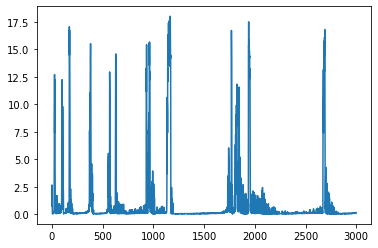

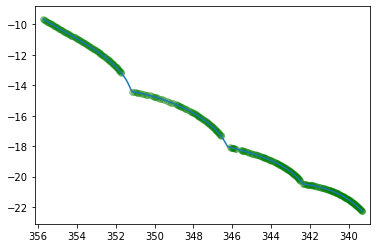

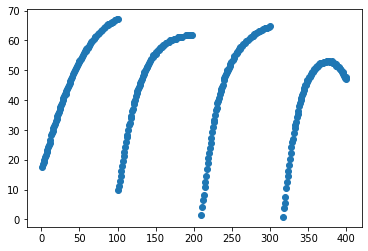

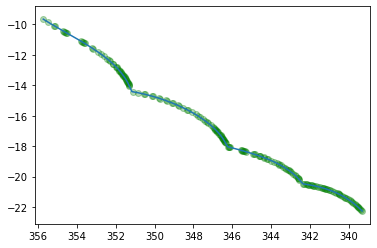

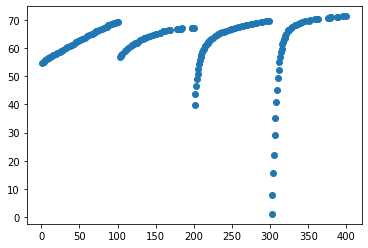

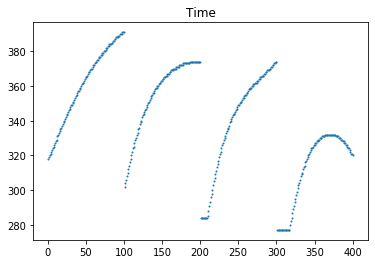

In [222]:
bestFit, finalFit = analyze_fit(opt, yaphetCurve, 0.25)

In [223]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/odessaFits.gz', index=False, encoding='utf-8', compression='gzip')
bestFit.to_csv('./output/odessaBestFit.gz', index=False, encoding='utf-8', compression='gzip')

#### Test with no phase

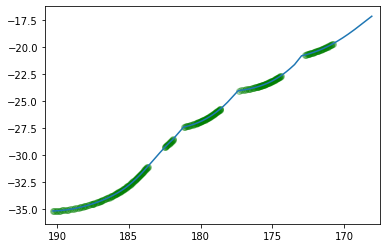

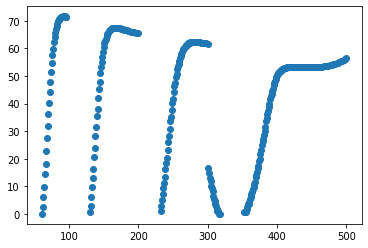

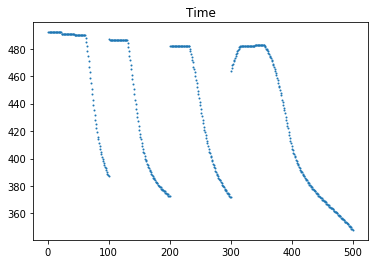

In [215]:
data = direct_fit(odessaCurve, 0.25)

### Mira

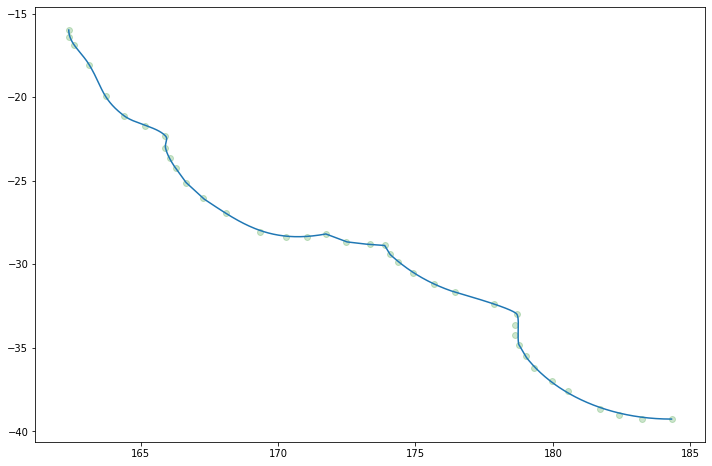

In [268]:
mira = pd.read_csv("./obsData/MiraLonLatP180.txt", header=None, sep='\t', names=['lon', 'lat'])
# mira = mira.sort_values(['lon', 'lat'])

mira_arcs = [
    mira[0:8],
    mira[8:18],
    mira[18:21],
    mira[21:27],
    mira[27:]
]

miraCurve = createCycloidBezier(mira_arcs)
plt.figure(figsize=(12, 8))
plt.plot(miraCurve['lon'], miraCurve['lat'])
plt.scatter(mira['lon'], mira['lat'], color='green', alpha='0.2')

In [272]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    miraCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 2.863046174050771 -- Moving Avg Loss: 2.863046174050771
	Parameters used: [0.3381428057158903, 0.9924653705135204]
Iteration 2/3000 -- Loss Output: 4.881383071823166 -- Moving Avg Loss: 3.8722146229369683
	Parameters used: [0.28814281 0.94246537]
Iteration 3/3000 -- Loss Output: 4.503485594415763 -- Moving Avg Loss: 4.082638280096567
	Parameters used: [0.25083432 0.90522386]
Iteration 4/3000 -- Loss Output: 5.268886459352683 -- Moving Avg Loss: 4.379200324910595
	Parameters used: [0.21587129 0.87027162]
Iteration 5/3000 -- Loss Output: 4.59309094913072 -- Moving Avg Loss: 4.42197844975462
	Parameters used: [0.18126099 0.83567707]
Iteration 6/3000 -- Loss Output: 3.6095216930881646 -- Moving Avg Loss: 4.286568990310211
	Parameters used: [0.1491292  0.80354243]
Iteration 7/3000 -- Loss Output: 10.765129117304806 -- Moving Avg Loss: 5.212077579880868
	Parameters used: [0.11159142 0.76600139]
Iteration 8/3000 -- Loss Output: 4.558017145261033 -- Moving Avg 

Iteration 63/3000 -- Loss Output: 7.243578391243176 -- Moving Avg Loss: 8.828997628183485
	Parameters used: [0.25247378 0.90755829]
Iteration 64/3000 -- Loss Output: 7.556169017867655 -- Moving Avg Loss: 8.74116577725812
	Parameters used: [0.2182218  0.87580269]
Iteration 65/3000 -- Loss Output: 7.48803048764878 -- Moving Avg Loss: 8.940541362919433
	Parameters used: [0.18540285 0.84519006]
Iteration 66/3000 -- Loss Output: 6.188242572776016 -- Moving Avg Loss: 8.806512336130691
	Parameters used: [0.15525828 0.81703698]
Iteration 67/3000 -- Loss Output: 9.721559282734416 -- Moving Avg Loss: 8.937347566861401
	Parameters used: [0.12679306 0.79034936]
Iteration 68/3000 -- Loss Output: 11.338174812014062 -- Moving Avg Loss: 9.018715026743054
	Parameters used: [0.09987534 0.76502005]
Iteration 69/3000 -- Loss Output: 0.4899036965396027 -- Moving Avg Loss: 8.69641879250869
	Parameters used: [0.07511159 0.74169053]
Iteration 70/3000 -- Loss Output: 5.591919649152581 -- Moving Avg Loss: 8.659

Iteration 125/3000 -- Loss Output: 10.993616069589866 -- Moving Avg Loss: 11.656706177482695
	Parameters used: [0.9976926  0.06668195]
Iteration 126/3000 -- Loss Output: 7.579783763562787 -- Moving Avg Loss: 11.597122924138048
	Parameters used: [0.97281549 0.0401006 ]
Iteration 127/3000 -- Loss Output: 12.789711916973756 -- Moving Avg Loss: 11.721054111100173
	Parameters used: [0.94954453 0.01521868]
Iteration 128/3000 -- Loss Output: 10.249280316474383 -- Moving Avg Loss: 11.848035504589756
	Parameters used: [0.92839313 0.13384582]
Iteration 129/3000 -- Loss Output: 12.15282683952856 -- Moving Avg Loss: 11.883464579565077
	Parameters used: [0.90744219 0.11378851]
Iteration 130/3000 -- Loss Output: 12.74123513308301 -- Moving Avg Loss: 12.135439114938386
	Parameters used: [0.88802895 0.09507878]
Iteration 131/3000 -- Loss Output: 12.839616526753874 -- Moving Avg Loss: 12.107862779676154
	Parameters used: [0.86846555 0.07573129]
Iteration 132/3000 -- Loss Output: 11.824503431195767 -- M

Iteration 187/3000 -- Loss Output: 4.254010243317021 -- Moving Avg Loss: 6.662201479700245
	Parameters used: [0.64516537 0.70649658]
Iteration 188/3000 -- Loss Output: 4.341281108856188 -- Moving Avg Loss: 6.400839222912307
	Parameters used: [0.63649718 0.69752486]
Iteration 189/3000 -- Loss Output: 9.020746765855627 -- Moving Avg Loss: 6.345394505979219
	Parameters used: [0.62372645 0.6840639 ]
Iteration 190/3000 -- Loss Output: 18.850928762045715 -- Moving Avg Loss: 6.632994734337762
	Parameters used: [0.56521256 0.62423085]
Iteration 191/3000 -- Loss Output: 11.789848646375855 -- Moving Avg Loss: 6.75495966644196
	Parameters used: [0.51239709 0.57022466]
Iteration 192/3000 -- Loss Output: 20.6981914254688 -- Moving Avg Loss: 7.213819697437691
	Parameters used: [0.46440488 0.52113999]
Iteration 193/3000 -- Loss Output: 14.706625122357945 -- Moving Avg Loss: 7.338705196769951
	Parameters used: [0.42108723 0.47683625]
Iteration 194/3000 -- Loss Output: 17.203110960523524 -- Moving Avg 

Iteration 249/3000 -- Loss Output: 14.182446880425756 -- Moving Avg Loss: 7.208895187064217
	Parameters used: [0.60259297 0.2848739 ]
Iteration 250/3000 -- Loss Output: 8.33140517892101 -- Moving Avg Loss: 7.273919297162175
	Parameters used: [0.59017985 0.27198109]
Iteration 251/3000 -- Loss Output: 12.628372859527062 -- Moving Avg Loss: 7.566213043421121
	Parameters used: [0.57789908 0.25922566]
Iteration 252/3000 -- Loss Output: 13.13337377308685 -- Moving Avg Loss: 7.926038658957453
	Parameters used: [0.56585354 0.24671449]
Iteration 253/3000 -- Loss Output: 17.670524883666296 -- Moving Avg Loss: 8.449953652410604
	Parameters used: [0.55339307 0.23377237]
Iteration 254/3000 -- Loss Output: 10.051702614020682 -- Moving Avg Loss: 8.565147161629364
	Parameters used: [0.54119123 0.22109885]
Iteration 255/3000 -- Loss Output: 12.303025361619344 -- Moving Avg Loss: 8.816921046102305
	Parameters used: [0.52866944 0.20809306]
Iteration 256/3000 -- Loss Output: 15.161101141993912 -- Moving A

Iteration 311/3000 -- Loss Output: 12.761212829488716 -- Moving Avg Loss: 10.84091766899833
	Parameters used: [0.55387622 0.43195322]
Iteration 312/3000 -- Loss Output: 11.745471603508197 -- Moving Avg Loss: 10.902709905906
	Parameters used: [0.52327324 0.39996318]
Iteration 313/3000 -- Loss Output: 14.906761897956434 -- Moving Avg Loss: 11.159752866999327
	Parameters used: [0.49536027 0.37079284]
Iteration 314/3000 -- Loss Output: 14.572204923760996 -- Moving Avg Loss: 11.37134497401566
	Parameters used: [0.4699972  0.34429189]
Iteration 315/3000 -- Loss Output: 15.255328465159185 -- Moving Avg Loss: 11.53129286390448
	Parameters used: [0.44631194 0.31956324]
Iteration 316/3000 -- Loss Output: 13.202032775826888 -- Moving Avg Loss: 11.712767342282705
	Parameters used: [0.42095621 0.29317981]
Iteration 317/3000 -- Loss Output: 18.084437501176765 -- Moving Avg Loss: 12.061010936690431
	Parameters used: [0.3979464  0.26923959]
Iteration 318/3000 -- Loss Output: 14.705042087845229 -- Movi

Iteration 373/3000 -- Loss Output: 10.013512462866315 -- Moving Avg Loss: 12.72108670237261
	Parameters used: [0.97818739 0.41411891]
Iteration 374/3000 -- Loss Output: 7.899650047875107 -- Moving Avg Loss: 12.532463915301571
	Parameters used: [0.94249892 0.37742044]
Iteration 375/3000 -- Loss Output: 6.605647349618173 -- Moving Avg Loss: 12.214630564089957
	Parameters used: [0.91002287 0.34403056]
Iteration 376/3000 -- Loss Output: 8.729010294967203 -- Moving Avg Loss: 11.959364824684581
	Parameters used: [0.88062493 0.31380747]
Iteration 377/3000 -- Loss Output: 9.260564947987781 -- Moving Avg Loss: 11.886241134385266
	Parameters used: [0.85362326 0.28605632]
Iteration 378/3000 -- Loss Output: 10.504668363022576 -- Moving Avg Loss: 11.821769614148826
	Parameters used: [0.82884091 0.26059324]
Iteration 379/3000 -- Loss Output: 6.8301024712043965 -- Moving Avg Loss: 11.497474107416583
	Parameters used: [0.80616146 0.23729611]
Iteration 380/3000 -- Loss Output: 7.020085137857869 -- Movi

Iteration 435/3000 -- Loss Output: 0.20031377119852378 -- Moving Avg Loss: 9.288419041500376
	Parameters used: [0.72779749 0.54635477]
Iteration 436/3000 -- Loss Output: 2.138609525687876 -- Moving Avg Loss: 9.07679250112954
	Parameters used: [0.71195958 0.53053216]
Iteration 437/3000 -- Loss Output: 6.290413438273634 -- Moving Avg Loss: 8.890259813693747
	Parameters used: [0.69768323 0.51626953]
Iteration 438/3000 -- Loss Output: 9.098453216010522 -- Moving Avg Loss: 8.952100746944327
	Parameters used: [0.68481133 0.50340977]
Iteration 439/3000 -- Loss Output: 6.530829191373425 -- Moving Avg Loss: 8.905258663323474
	Parameters used: [0.67299947 0.49159992]
Iteration 440/3000 -- Loss Output: 10.160001438941775 -- Moving Avg Loss: 8.883668243879885
	Parameters used: [0.66061447 0.4791444 ]
Iteration 441/3000 -- Loss Output: 11.62662893656214 -- Moving Avg Loss: 8.86921197088643
	Parameters used: [0.64936641 0.46782975]
Iteration 442/3000 -- Loss Output: 7.6636810992635835 -- Moving Avg 

Iteration 497/3000 -- Loss Output: 5.955645401441896 -- Moving Avg Loss: 8.097421346735223
	Parameters used: [0.80755196 0.35896553]
Iteration 498/3000 -- Loss Output: 8.505316275859963 -- Moving Avg Loss: 8.28408258851499
	Parameters used: [0.79777989 0.34894023]
Iteration 499/3000 -- Loss Output: 5.315416921994453 -- Moving Avg Loss: 8.194699500177036
	Parameters used: [0.7887222  0.33965071]
Iteration 500/3000 -- Loss Output: 6.119445281654537 -- Moving Avg Loss: 8.1789050534673
	Parameters used: [0.78016429 0.33087801]
Iteration 501/3000 -- Loss Output: 8.652420962533517 -- Moving Avg Loss: 7.907428730756261
	Parameters used: [0.77222553 0.32274224]
Iteration 502/3000 -- Loss Output: 6.8774439206589255 -- Moving Avg Loss: 7.889812347182244
	Parameters used: [0.76414519 0.31446996]
Iteration 503/3000 -- Loss Output: 5.44441085364763 -- Moving Avg Loss: 7.699129303502345
	Parameters used: [0.75625677 0.30639847]
Iteration 504/3000 -- Loss Output: 7.238680471212054 -- Moving Avg Loss:

Iteration 559/3000 -- Loss Output: 0.7020757932616629 -- Moving Avg Loss: 6.894424921593561
	Parameters used: [0.18314976 0.38278264]
Iteration 560/3000 -- Loss Output: 5.888282733744937 -- Moving Avg Loss: 6.974323299988592
	Parameters used: [0.17888055 0.37842862]
Iteration 561/3000 -- Loss Output: 8.561129942980399 -- Moving Avg Loss: 6.924536463992264
	Parameters used: [0.17498433 0.37445499]
Iteration 562/3000 -- Loss Output: 3.3672525881831055 -- Moving Avg Loss: 6.72693467604976
	Parameters used: [0.17048152 0.36986261]
Iteration 563/3000 -- Loss Output: 6.337505908287304 -- Moving Avg Loss: 6.647907752175619
	Parameters used: [0.16565001 0.36493496]
Iteration 564/3000 -- Loss Output: 4.223509319383418 -- Moving Avg Loss: 6.411372706487223
	Parameters used: [0.16123495 0.36043205]
Iteration 565/3000 -- Loss Output: 5.930046169030358 -- Moving Avg Loss: 6.303685786747466
	Parameters used: [0.15584563 0.35493543]
Iteration 566/3000 -- Loss Output: 10.246107241648494 -- Moving Avg 

Iteration 621/3000 -- Loss Output: 17.25199010486371 -- Moving Avg Loss: 10.953623553435884
	Parameters used: [0.41863648 0.31011274]
Iteration 622/3000 -- Loss Output: 8.867197109864152 -- Moving Avg Loss: 11.147651526451627
	Parameters used: [0.40026058 0.29156447]
Iteration 623/3000 -- Loss Output: 17.497129405208092 -- Moving Avg Loss: 11.713874308334962
	Parameters used: [0.38212525 0.27325907]
Iteration 624/3000 -- Loss Output: 16.646778821693708 -- Moving Avg Loss: 12.217933730259997
	Parameters used: [0.3653295  0.25630582]
Iteration 625/3000 -- Loss Output: 13.518735419891689 -- Moving Avg Loss: 12.570625796982387
	Parameters used: [0.34951    0.24033798]
Iteration 626/3000 -- Loss Output: 9.994169509907605 -- Moving Avg Loss: 12.78885320735033
	Parameters used: [0.33465724 0.22534594]
Iteration 627/3000 -- Loss Output: 11.808151987618828 -- Moving Avg Loss: 13.059961840363746
	Parameters used: [0.32049316 0.21104907]
Iteration 628/3000 -- Loss Output: 14.255965500796217 -- Mo

Iteration 683/3000 -- Loss Output: 12.597420357932334 -- Moving Avg Loss: 9.26447198712393
	Parameters used: [0.48763559 0.04135904]
Iteration 684/3000 -- Loss Output: 11.733693960177856 -- Moving Avg Loss: 9.430204579191011
	Parameters used: [0.46818208 0.02172163]
Iteration 685/3000 -- Loss Output: 21.22097001971524 -- Moving Avg Loss: 10.023885668341915
	Parameters used: [0.43922759 0.81483302]
Iteration 686/3000 -- Loss Output: 17.58854206466808 -- Moving Avg Loss: 10.516146729084937
	Parameters used: [0.41314603 0.78850251]
Iteration 687/3000 -- Loss Output: 7.536309316506072 -- Moving Avg Loss: 10.452181084017687
	Parameters used: [0.38857476 0.76369691]
Iteration 688/3000 -- Loss Output: 6.659127856489373 -- Moving Avg Loss: 10.597561519289519
	Parameters used: [0.36555729 0.74046008]
Iteration 689/3000 -- Loss Output: 4.040801054423262 -- Moving Avg Loss: 10.519090487836639
	Parameters used: [0.34479707 0.71950202]
Iteration 690/3000 -- Loss Output: 4.791625597386409 -- Moving 

Iteration 745/3000 -- Loss Output: 16.0039893673005 -- Moving Avg Loss: 10.837299349131486
	Parameters used: [0.63614659 0.19929992]
Iteration 746/3000 -- Loss Output: 11.576337255258352 -- Moving Avg Loss: 10.840973078900161
	Parameters used: [0.61747306 0.18125691]
Iteration 747/3000 -- Loss Output: 10.758647473112319 -- Moving Avg Loss: 10.646146744547782
	Parameters used: [0.59390472 0.15789547]
Iteration 748/3000 -- Loss Output: 9.392439531574285 -- Moving Avg Loss: 10.615779825906833
	Parameters used: [0.5722697  0.13643594]
Iteration 749/3000 -- Loss Output: 15.472966798963416 -- Moving Avg Loss: 10.8857812343451
	Parameters used: [0.55229576 0.11660733]
Iteration 750/3000 -- Loss Output: 14.275715163630062 -- Moving Avg Loss: 11.132874312559423
	Parameters used: [0.53429407 0.09873636]
Iteration 751/3000 -- Loss Output: 13.878647961701038 -- Moving Avg Loss: 11.273428347864218
	Parameters used: [0.51709335 0.08162834]
Iteration 752/3000 -- Loss Output: 7.571803048380364 -- Movi

Iteration 807/3000 -- Loss Output: 2.9089773850242233 -- Moving Avg Loss: 10.139922997227798
	Parameters used: [0.26456588 0.63514525]
Iteration 808/3000 -- Loss Output: 3.3263561898472385 -- Moving Avg Loss: 10.019761813750542
	Parameters used: [0.2494137 0.6199436]
Iteration 809/3000 -- Loss Output: 5.43585240944369 -- Moving Avg Loss: 9.906974178022356
	Parameters used: [0.2357204  0.60620521]
Iteration 810/3000 -- Loss Output: 1.3831651793039903 -- Moving Avg Loss: 9.689153890485798
	Parameters used: [0.22336796 0.59381194]
Iteration 811/3000 -- Loss Output: 3.4533661209214057 -- Moving Avg Loss: 9.509156610054596
	Parameters used: [0.21220566 0.58261244]
Iteration 812/3000 -- Loss Output: 6.738920808395982 -- Moving Avg Loss: 9.404801763108882
	Parameters used: [0.20185908 0.57222889]
Iteration 813/3000 -- Loss Output: 6.567832703917296 -- Moving Avg Loss: 9.315495117942525
	Parameters used: [0.19230059 0.56263433]
Iteration 814/3000 -- Loss Output: 6.229982401196032 -- Moving Avg

Iteration 869/3000 -- Loss Output: 9.337687818335924 -- Moving Avg Loss: 12.319812694287746
	Parameters used: [0.36030583 0.54115927]
Iteration 870/3000 -- Loss Output: 2.4319246155465 -- Moving Avg Loss: 11.938274567397471
	Parameters used: [0.34269172 0.52966811]
Iteration 871/3000 -- Loss Output: 11.113904273459818 -- Moving Avg Loss: 12.002039479926257
	Parameters used: [0.32680184 0.51928038]
Iteration 872/3000 -- Loss Output: 7.374943295640377 -- Moving Avg Loss: 11.800772088405006
	Parameters used: [0.31247433 0.50990105]
Iteration 873/3000 -- Loss Output: 10.185246672161743 -- Moving Avg Loss: 11.804299603997178
	Parameters used: [0.29903536 0.50062181]
Iteration 874/3000 -- Loss Output: 7.974672200884461 -- Moving Avg Loss: 11.722698694423034
	Parameters used: [0.28615064 0.49111231]
Iteration 875/3000 -- Loss Output: 7.792846627623518 -- Moving Avg Loss: 11.774061652010392
	Parameters used: [0.27431019 0.4822227 ]
Iteration 876/3000 -- Loss Output: 5.737687062143402 -- Moving

Iteration 931/3000 -- Loss Output: 12.900857438619719 -- Moving Avg Loss: 12.797541500193208
	Parameters used: [0.2737045  0.23791841]
Iteration 932/3000 -- Loss Output: 15.587561478536086 -- Moving Avg Loss: 13.072842429761621
	Parameters used: [0.25643547 0.22052505]
Iteration 933/3000 -- Loss Output: 14.753278921677177 -- Moving Avg Loss: 13.216705773728345
	Parameters used: [0.23992417 0.20389124]
Iteration 934/3000 -- Loss Output: 12.18447246336136 -- Moving Avg Loss: 13.430997895203939
	Parameters used: [0.224955   0.18881066]
Iteration 935/3000 -- Loss Output: 18.94184879835831 -- Moving Avg Loss: 13.677525393426633
	Parameters used: [0.21099755 0.17474776]
Iteration 936/3000 -- Loss Output: 14.718988986768496 -- Moving Avg Loss: 13.945394254294714
	Parameters used: [0.19842168 0.16207687]
Iteration 937/3000 -- Loss Output: 12.540235353039964 -- Moving Avg Loss: 14.13632886537561
	Parameters used: [0.17941269 0.14290108]
Iteration 938/3000 -- Loss Output: 14.412342642882926 -- M

Iteration 993/3000 -- Loss Output: 10.824385025845704 -- Moving Avg Loss: 5.336352039723308
	Parameters used: [0.64697659 0.55076744]
Iteration 994/3000 -- Loss Output: 11.56775230532974 -- Moving Avg Loss: 5.629875422333953
	Parameters used: [0.63895368 0.54267187]
Iteration 995/3000 -- Loss Output: 12.061016592378516 -- Moving Avg Loss: 6.0311025866332395
	Parameters used: [0.62900444 0.53263254]
Iteration 996/3000 -- Loss Output: 8.556659621686192 -- Moving Avg Loss: 6.174619136850874
	Parameters used: [0.61909595 0.52263434]
Iteration 997/3000 -- Loss Output: 6.213131565962587 -- Moving Avg Loss: 6.256979469208396
	Parameters used: [0.60851647 0.51195907]
Iteration 998/3000 -- Loss Output: 14.51852233707097 -- Moving Avg Loss: 6.591473175519736
	Parameters used: [0.59850689 0.50185887]
Iteration 999/3000 -- Loss Output: 8.852313206068665 -- Moving Avg Loss: 6.747126487302031
	Parameters used: [0.58911679 0.49238376]
Iteration 1000/3000 -- Loss Output: 14.788524646798367 -- Moving A

Iteration 1054/3000 -- Loss Output: 22.16866747673934 -- Moving Avg Loss: 11.544632714054176
	Parameters used: [0.44449357 0.71170912]
Iteration 1055/3000 -- Loss Output: 19.217001367479085 -- Moving Avg Loss: 11.774014352626212
	Parameters used: [0.42736044 0.69607062]
Iteration 1056/3000 -- Loss Output: 20.100399299425384 -- Moving Avg Loss: 12.110047821346372
	Parameters used: [0.40893776 0.67871523]
Iteration 1057/3000 -- Loss Output: 8.194490517541682 -- Moving Avg Loss: 11.944843489074943
	Parameters used: [0.28675361 0.55605915]
Iteration 1058/3000 -- Loss Output: 2.0148285662853227 -- Moving Avg Loss: 11.62459393451951
	Parameters used: [0.17666332 0.44554588]
Iteration 1059/3000 -- Loss Output: 10.893098773619483 -- Moving Avg Loss: 11.606163900929268
	Parameters used: [0.07750336 0.34600507]
Iteration 1060/3000 -- Loss Output: 11.064090643194772 -- Moving Avg Loss: 11.743218150521264
	Parameters used: [0.988187   0.25634592]
Iteration 1061/3000 -- Loss Output: 11.679270976322

Iteration 1115/3000 -- Loss Output: 13.742188794177531 -- Moving Avg Loss: 11.397021109606149
	Parameters used: [0.33046951 0.25026375]
Iteration 1116/3000 -- Loss Output: 16.963618385091472 -- Moving Avg Loss: 11.609926342210917
	Parameters used: [0.31148805 0.23160407]
Iteration 1117/3000 -- Loss Output: 14.22494066015362 -- Moving Avg Loss: 11.625406466797372
	Parameters used: [0.29418213 0.21459376]
Iteration 1118/3000 -- Loss Output: 15.892541321521424 -- Moving Avg Loss: 11.8709711232579
	Parameters used: [0.27386779 0.1946753 ]
Iteration 1119/3000 -- Loss Output: 13.933133854870123 -- Moving Avg Loss: 12.038288869723619
	Parameters used: [0.25491709 0.17609758]
Iteration 1120/3000 -- Loss Output: 12.701255433799153 -- Moving Avg Loss: 12.266073810108429
	Parameters used: [0.23767204 0.15919286]
Iteration 1121/3000 -- Loss Output: 13.554620968405507 -- Moving Avg Loss: 12.498521020254712
	Parameters used: [0.22187699 0.14371088]
Iteration 1122/3000 -- Loss Output: 11.017536378786

Iteration 1176/3000 -- Loss Output: 8.937248032172992 -- Moving Avg Loss: 11.425174429009582
	Parameters used: [0.46267823 0.03708191]
Iteration 1177/3000 -- Loss Output: 14.050286726439243 -- Moving Avg Loss: 11.567325540961107
	Parameters used: [0.42629545 0.0014718 ]
Iteration 1178/3000 -- Loss Output: 10.014891991383378 -- Moving Avg Loss: 11.471597832980798
	Parameters used: [0.39330057 0.76812862]
Iteration 1179/3000 -- Loss Output: 7.438259401308593 -- Moving Avg Loss: 11.266895585111381
	Parameters used: [0.36309023 0.73906331]
Iteration 1180/3000 -- Loss Output: 4.536773113916933 -- Moving Avg Loss: 11.16495126952746
	Parameters used: [0.33584971 0.7128542 ]
Iteration 1181/3000 -- Loss Output: 3.160225601787321 -- Moving Avg Loss: 10.847934257538874
	Parameters used: [0.31131074 0.6892442 ]
Iteration 1182/3000 -- Loss Output: 4.312590703151965 -- Moving Avg Loss: 10.579626184727015
	Parameters used: [0.28916861 0.66793893]
Iteration 1183/3000 -- Loss Output: 4.252452578540864 

Iteration 1238/3000 -- Loss Output: 11.020874179117142 -- Moving Avg Loss: 7.732859821104132
	Parameters used: [0.0696885  0.43266149]
Iteration 1239/3000 -- Loss Output: 12.41217239328121 -- Moving Avg Loss: 7.876299802820572
	Parameters used: [0.06170532 0.42478797]
Iteration 1240/3000 -- Loss Output: 11.547310854672782 -- Moving Avg Loss: 8.000481962832994
	Parameters used: [0.05288364 0.41609723]
Iteration 1241/3000 -- Loss Output: 12.637991295567048 -- Moving Avg Loss: 8.154470555792571
	Parameters used: [0.03451748 0.39804111]
Iteration 1242/3000 -- Loss Output: 10.80103422382892 -- Moving Avg Loss: 8.488244899734052
	Parameters used: [0.01775847 0.38156493]
Iteration 1243/3000 -- Loss Output: 11.448450007824666 -- Moving Avg Loss: 8.631368982553557
	Parameters used: [0.00179403 0.36586955]
Iteration 1244/3000 -- Loss Output: 6.604830837565838 -- Moving Avg Loss: 8.277256045901913
	Parameters used: [0.97998809 0.34442743]
Iteration 1245/3000 -- Loss Output: 10.603013162843165 -- 

Iteration 1300/3000 -- Loss Output: 11.909886994607032 -- Moving Avg Loss: 9.504016759024818
	Parameters used: [0.01183753 0.21477001]
Iteration 1301/3000 -- Loss Output: 12.148429579208049 -- Moving Avg Loss: 9.562521399893988
	Parameters used: [0.99823745 0.20137565]
Iteration 1302/3000 -- Loss Output: 9.866080461700047 -- Moving Avg Loss: 9.581942359789368
	Parameters used: [0.98600077 0.18847206]
Iteration 1303/3000 -- Loss Output: 7.154411325394374 -- Moving Avg Loss: 9.759704270335002
	Parameters used: [0.97451048 0.17641959]
Iteration 1304/3000 -- Loss Output: 10.814552236692965 -- Moving Avg Loss: 10.014263330472504
	Parameters used: [0.96380941 0.16523934]
Iteration 1305/3000 -- Loss Output: 11.838375134544698 -- Moving Avg Loss: 10.35779023452267
	Parameters used: [0.95408691 0.15509152]
Iteration 1306/3000 -- Loss Output: 10.194621677511423 -- Moving Avg Loss: 10.429451898395076
	Parameters used: [0.94526127 0.14588784]
Iteration 1307/3000 -- Loss Output: 7.602227757796922 -

Iteration 1361/3000 -- Loss Output: 14.362216842994107 -- Moving Avg Loss: 10.215047694536462
	Parameters used: [0.53409583 0.34156659]
Iteration 1362/3000 -- Loss Output: 14.495532910612845 -- Moving Avg Loss: 10.41872249942595
	Parameters used: [0.52576209 0.33336615]
Iteration 1363/3000 -- Loss Output: 20.108262517746216 -- Moving Avg Loss: 11.012251496413805
	Parameters used: [0.51671736 0.32446606]
Iteration 1364/3000 -- Loss Output: 14.752482288048373 -- Moving Avg Loss: 11.41847452984062
	Parameters used: [0.50799041 0.31587868]
Iteration 1365/3000 -- Loss Output: 17.501158857788635 -- Moving Avg Loss: 11.801993967376553
	Parameters used: [0.49893421 0.3069673 ]
Iteration 1366/3000 -- Loss Output: 13.565285221580258 -- Moving Avg Loss: 12.188283978977813
	Parameters used: [0.49057939 0.29874609]
Iteration 1367/3000 -- Loss Output: 13.022238976342388 -- Moving Avg Loss: 12.648538527116274
	Parameters used: [0.4807031 0.2890277]
Iteration 1368/3000 -- Loss Output: 17.1257557404812

Iteration 1422/3000 -- Loss Output: 8.60060092191353 -- Moving Avg Loss: 7.320798828526562
	Parameters used: [0.81882197 0.4994721 ]
Iteration 1423/3000 -- Loss Output: 7.376983778749619 -- Moving Avg Loss: 7.230172128614131
	Parameters used: [0.81304002 0.49377894]
Iteration 1424/3000 -- Loss Output: 7.017616442556488 -- Moving Avg Loss: 7.087062228212903
	Parameters used: [0.80733499 0.48816199]
Iteration 1425/3000 -- Loss Output: 5.485561544620094 -- Moving Avg Loss: 6.942253360923591
	Parameters used: [0.80073395 0.48166399]
Iteration 1426/3000 -- Loss Output: 6.038613277640573 -- Moving Avg Loss: 6.879968562952353
	Parameters used: [0.79348859 0.47453228]
Iteration 1427/3000 -- Loss Output: 4.6996843110505795 -- Moving Avg Loss: 6.592796088918044
	Parameters used: [0.78693803 0.46808448]
Iteration 1428/3000 -- Loss Output: 7.248576727576977 -- Moving Avg Loss: 6.620258789512401
	Parameters used: [0.78065683 0.46190193]
Iteration 1429/3000 -- Loss Output: 5.989946095400929 -- Movin

Iteration 1483/3000 -- Loss Output: 7.91460361375629 -- Moving Avg Loss: 13.196528450514192
	Parameters used: [0.27451657 0.52868444]
Iteration 1484/3000 -- Loss Output: 12.147444539084336 -- Moving Avg Loss: 13.099701785493325
	Parameters used: [0.26493357 0.51928448]
Iteration 1485/3000 -- Loss Output: 9.324989606789732 -- Moving Avg Loss: 12.932124085092038
	Parameters used: [0.25626627 0.51078247]
Iteration 1486/3000 -- Loss Output: 3.226850198807916 -- Moving Avg Loss: 12.506871747926553
	Parameters used: [0.24716022 0.50184137]
Iteration 1487/3000 -- Loss Output: 6.067259493177119 -- Moving Avg Loss: 12.20770429235143
	Parameters used: [0.23888358 0.49371429]
Iteration 1488/3000 -- Loss Output: 9.875224883082206 -- Moving Avg Loss: 12.219911085034141
	Parameters used: [0.23136803 0.48633426]
Iteration 1489/3000 -- Loss Output: 10.216930961129359 -- Moving Avg Loss: 12.004465082473212
	Parameters used: [0.22454376 0.47963278]
Iteration 1490/3000 -- Loss Output: 9.27810488881187 --

Iteration 1544/3000 -- Loss Output: 6.290903938769083 -- Moving Avg Loss: 9.624186117966717
	Parameters used: [0.6868222  0.47566571]
Iteration 1545/3000 -- Loss Output: 7.74720014470453 -- Moving Avg Loss: 9.555028621350107
	Parameters used: [0.66671415 0.45596483]
Iteration 1546/3000 -- Loss Output: 10.064116714874888 -- Moving Avg Loss: 9.474829904983983
	Parameters used: [0.64850741 0.43812582]
Iteration 1547/3000 -- Loss Output: 12.510524801729066 -- Moving Avg Loss: 9.496714621161201
	Parameters used: [0.63190893 0.42186067]
Iteration 1548/3000 -- Loss Output: 10.65620578354057 -- Moving Avg Loss: 9.612732649952475
	Parameters used: [0.61678898 0.40704278]
Iteration 1549/3000 -- Loss Output: 13.607163348420318 -- Moving Avg Loss: 9.613165583494544
	Parameters used: [0.60118488 0.39173241]
Iteration 1550/3000 -- Loss Output: 11.514711899083554 -- Moving Avg Loss: 9.59696469299394
	Parameters used: [0.58703504 0.37784827]
Iteration 1551/3000 -- Loss Output: 8.599639724805218 -- Mov

Iteration 1605/3000 -- Loss Output: 10.163791295976889 -- Moving Avg Loss: 11.92331776554837
	Parameters used: [0.95691272 0.20092141]
Iteration 1606/3000 -- Loss Output: 11.746633241864883 -- Moving Avg Loss: 11.96321694547373
	Parameters used: [0.94522045 0.18283525]
Iteration 1607/3000 -- Loss Output: 12.152260435643715 -- Moving Avg Loss: 12.042440449637475
	Parameters used: [0.93439687 0.16636377]
Iteration 1608/3000 -- Loss Output: 8.574848390244009 -- Moving Avg Loss: 11.83176627198358
	Parameters used: [0.92090065 0.14914746]
Iteration 1609/3000 -- Loss Output: 9.113915785239737 -- Moving Avg Loss: 11.541715463932592
	Parameters used: [0.90820358 0.13323148]
Iteration 1610/3000 -- Loss Output: 9.925057690966053 -- Moving Avg Loss: 11.481943419045088
	Parameters used: [0.89583177 0.11817491]
Iteration 1611/3000 -- Loss Output: 9.97097198914915 -- Moving Avg Loss: 11.48211439767487
	Parameters used: [0.88425532 0.10426993]
Iteration 1612/3000 -- Loss Output: 14.211950147459492 --

Iteration 1666/3000 -- Loss Output: 9.36246581680972 -- Moving Avg Loss: 9.644629127817351
	Parameters used: [0.17625961 0.58328584]
Iteration 1667/3000 -- Loss Output: 7.620439031542851 -- Moving Avg Loss: 9.424357488086521
	Parameters used: [0.16939323 0.57667132]
Iteration 1668/3000 -- Loss Output: 8.24401938522819 -- Moving Avg Loss: 9.199657888698805
	Parameters used: [0.16305171 0.57055588]
Iteration 1669/3000 -- Loss Output: 12.329576219256174 -- Moving Avg Loss: 9.198353746277453
	Parameters used: [0.1572501  0.56495754]
Iteration 1670/3000 -- Loss Output: 6.142786484785043 -- Moving Avg Loss: 8.963254851225523
	Parameters used: [0.15194488 0.55983513]
Iteration 1671/3000 -- Loss Output: 13.090922545709832 -- Moving Avg Loss: 8.871700007764627
	Parameters used: [0.1468142  0.55486825]
Iteration 1672/3000 -- Loss Output: 6.341306072064439 -- Moving Avg Loss: 8.679713379614167
	Parameters used: [0.14207069 0.55027229]
Iteration 1673/3000 -- Loss Output: 5.803089559609753 -- Movin

Iteration 1728/3000 -- Loss Output: 10.219407181101726 -- Moving Avg Loss: 9.182026487502052
	Parameters used: [0.07548748 0.41659064]
Iteration 1729/3000 -- Loss Output: 9.552840330777071 -- Moving Avg Loss: 9.159262498733927
	Parameters used: [0.00652596 0.34763799]
Iteration 1730/3000 -- Loss Output: 10.46100154419201 -- Moving Avg Loss: 9.198390668315556
	Parameters used: [0.94441851 0.2855386 ]
Iteration 1731/3000 -- Loss Output: 7.082985053686699 -- Moving Avg Loss: 8.935942598355181
	Parameters used: [0.88848831 0.22960786]
Iteration 1732/3000 -- Loss Output: 9.562700414492372 -- Moving Avg Loss: 8.885023244788918
	Parameters used: [0.83810966 0.17922891]
Iteration 1733/3000 -- Loss Output: 10.877583814631457 -- Moving Avg Loss: 8.843422932665163
	Parameters used: [0.79273911 0.13385811]
Iteration 1734/3000 -- Loss Output: 8.833797610596525 -- Moving Avg Loss: 8.825045376538968
	Parameters used: [0.75187439 0.09299328]
Iteration 1735/3000 -- Loss Output: 12.468293529067195 -- Mo

Iteration 1789/3000 -- Loss Output: 15.695768199407143 -- Moving Avg Loss: 13.657504744780683
	Parameters used: [0.13827783 0.12585905]
Iteration 1790/3000 -- Loss Output: 13.171015655738113 -- Moving Avg Loss: 13.622491173136616
	Parameters used: [0.13417864 0.12179362]
Iteration 1791/3000 -- Loss Output: 10.057783947140067 -- Moving Avg Loss: 13.438697741152467
	Parameters used: [0.13033601 0.11798263]
Iteration 1792/3000 -- Loss Output: 15.990219687196646 -- Moving Avg Loss: 13.526381290892067
	Parameters used: [0.12663841 0.11431545]
Iteration 1793/3000 -- Loss Output: 14.848958253431984 -- Moving Avg Loss: 13.558667530226234
	Parameters used: [0.12330479 0.11100925]
Iteration 1794/3000 -- Loss Output: 10.638344820522486 -- Moving Avg Loss: 13.41787809367834
	Parameters used: [0.12004795 0.10777919]
Iteration 1795/3000 -- Loss Output: 15.001638172046096 -- Moving Avg Loss: 13.432147658650033
	Parameters used: [0.11464672 0.10242219]
Iteration 1796/3000 -- Loss Output: 12.2803245791

Iteration 1850/3000 -- Loss Output: 6.993117431800057 -- Moving Avg Loss: 8.11956531690487
	Parameters used: [0.77836757 0.26901242]
Iteration 1851/3000 -- Loss Output: 5.255920127703813 -- Moving Avg Loss: 7.860739214200071
	Parameters used: [0.77609999 0.26676835]
Iteration 1852/3000 -- Loss Output: 12.04367557012329 -- Moving Avg Loss: 8.003876698184031
	Parameters used: [0.77400038 0.26469025]
Iteration 1853/3000 -- Loss Output: 9.60596995913224 -- Moving Avg Loss: 7.892338700432819
	Parameters used: [0.77209556 0.26280488]
Iteration 1854/3000 -- Loss Output: 6.030266007347164 -- Moving Avg Loss: 7.6933731275551285
	Parameters used: [0.76912511 0.25985959]
Iteration 1855/3000 -- Loss Output: 8.730256322245497 -- Moving Avg Loss: 7.568792916132844
	Parameters used: [0.76638433 0.25714197]
Iteration 1856/3000 -- Loss Output: 4.447985952719582 -- Moving Avg Loss: 7.168136048774454
	Parameters used: [0.76355666 0.25433797]
Iteration 1857/3000 -- Loss Output: 8.625504692794264 -- Moving

Iteration 1912/3000 -- Loss Output: 8.8886945102347 -- Moving Avg Loss: 10.362507848812475
	Parameters used: [0.59793107 0.0900643 ]
Iteration 1913/3000 -- Loss Output: 10.249563900397705 -- Moving Avg Loss: 10.39972021639587
	Parameters used: [0.5942563  0.08641944]
Iteration 1914/3000 -- Loss Output: 11.427347178679591 -- Moving Avg Loss: 10.624683381460297
	Parameters used: [0.59087938 0.08307   ]
Iteration 1915/3000 -- Loss Output: 12.104539937223448 -- Moving Avg Loss: 10.607798026278246
	Parameters used: [0.58775237 0.07996845]
Iteration 1916/3000 -- Loss Output: 12.080620526855023 -- Moving Avg Loss: 10.746343086138626
	Parameters used: [0.58493361 0.07717264]
Iteration 1917/3000 -- Loss Output: 14.296990858893468 -- Moving Avg Loss: 10.927389529753357
	Parameters used: [0.58230716 0.07456757]
Iteration 1918/3000 -- Loss Output: 12.059695983455951 -- Moving Avg Loss: 10.933150742079322
	Parameters used: [0.57992681 0.07220659]
Iteration 1919/3000 -- Loss Output: 13.2489864432060

Iteration 1973/3000 -- Loss Output: 18.104056860840835 -- Moving Avg Loss: 13.547091198637666
	Parameters used: [0.23211883 0.09770557]
Iteration 1974/3000 -- Loss Output: 16.20160996554507 -- Moving Avg Loss: 13.5130195248714
	Parameters used: [0.22947098 0.09518483]
Iteration 1975/3000 -- Loss Output: 13.182093218955423 -- Moving Avg Loss: 13.39867981653602
	Parameters used: [0.22662615 0.09243902]
Iteration 1976/3000 -- Loss Output: 9.698036716513641 -- Moving Avg Loss: 13.428838659002203
	Parameters used: [0.22330177 0.08918901]
Iteration 1977/3000 -- Loss Output: 15.960322322097351 -- Moving Avg Loss: 13.683415772403821
	Parameters used: [0.21980865 0.08575963]
Iteration 1978/3000 -- Loss Output: 17.188311864007378 -- Moving Avg Loss: 13.734249123831157
	Parameters used: [0.21662721 0.08263552]
Iteration 1979/3000 -- Loss Output: 11.874654513579198 -- Moving Avg Loss: 13.841656799996935
	Parameters used: [0.2133075  0.07936653]
Iteration 1980/3000 -- Loss Output: 13.73401412037011

Iteration 2034/3000 -- Loss Output: 8.116693276882536 -- Moving Avg Loss: 8.840489572546396
	Parameters used: [0.96589281 0.78072328]
Iteration 2035/3000 -- Loss Output: 8.945421434934072 -- Moving Avg Loss: 8.84812469158764
	Parameters used: [0.96081572 0.77562104]
Iteration 2036/3000 -- Loss Output: 10.003116110818054 -- Moving Avg Loss: 8.930092297545349
	Parameters used: [0.95591556 0.77070508]
Iteration 2037/3000 -- Loss Output: 11.522462289752117 -- Moving Avg Loss: 9.075956250040713
	Parameters used: [0.95144002 0.76621651]
Iteration 2038/3000 -- Loss Output: 7.206260981068034 -- Moving Avg Loss: 8.883691839953809
	Parameters used: [0.94737641 0.7621418 ]
Iteration 2039/3000 -- Loss Output: 8.34075531847517 -- Moving Avg Loss: 8.78736039889707
	Parameters used: [0.94367722 0.75843336]
Iteration 2040/3000 -- Loss Output: 6.037265497186602 -- Moving Avg Loss: 8.524304860804541
	Parameters used: [0.9403177  0.75506603]
Iteration 2041/3000 -- Loss Output: 6.396485944137995 -- Moving

Iteration 2096/3000 -- Loss Output: 6.755982106921348 -- Moving Avg Loss: 6.007042524564616
	Parameters used: [0.82061296 0.63616177]
Iteration 2097/3000 -- Loss Output: 4.780011404836152 -- Moving Avg Loss: 5.970722490061778
	Parameters used: [0.81889037 0.63445303]
Iteration 2098/3000 -- Loss Output: 5.140596788866373 -- Moving Avg Loss: 5.92967121655213
	Parameters used: [0.81715211 0.63272875]
Iteration 2099/3000 -- Loss Output: 3.102231599712702 -- Moving Avg Loss: 5.7501013103839025
	Parameters used: [0.81551507 0.63110487]
Iteration 2100/3000 -- Loss Output: 0.8295632767183649 -- Moving Avg Loss: 5.554686245558398
	Parameters used: [0.81316907 0.62877773]
Iteration 2101/3000 -- Loss Output: 3.664642894367248 -- Moving Avg Loss: 5.516551429052745
	Parameters used: [0.81082035 0.6264479 ]
Iteration 2102/3000 -- Loss Output: 6.094671807995074 -- Moving Avg Loss: 5.296556901778931
	Parameters used: [0.80867729 0.62432208]
Iteration 2103/3000 -- Loss Output: 3.6555299016888263 -- Mov

Iteration 2158/3000 -- Loss Output: 7.828693798757571 -- Moving Avg Loss: 8.429592214293038
	Parameters used: [0.6163566  0.43354175]
Iteration 2159/3000 -- Loss Output: 5.712332622075435 -- Moving Avg Loss: 8.50860883536422
	Parameters used: [0.61407055 0.43127403]
Iteration 2160/3000 -- Loss Output: 10.76221893283238 -- Moving Avg Loss: 8.581842903696177
	Parameters used: [0.6119134  0.42913417]
Iteration 2161/3000 -- Loss Output: 8.863858926518319 -- Moving Avg Loss: 8.712888093889987
	Parameters used: [0.60873663 0.42598288]
Iteration 2162/3000 -- Loss Output: 11.264460966349308 -- Moving Avg Loss: 8.916029965134635
	Parameters used: [0.60571184 0.42298234]
Iteration 2163/3000 -- Loss Output: 12.275798303189614 -- Moving Avg Loss: 9.054056899066644
	Parameters used: [0.60249642 0.41979271]
Iteration 2164/3000 -- Loss Output: 15.160137224812892 -- Moving Avg Loss: 9.201512139807377
	Parameters used: [0.59933339 0.41665504]
Iteration 2165/3000 -- Loss Output: 13.055217440609166 -- Mo

Iteration 2219/3000 -- Loss Output: 15.520998090890854 -- Moving Avg Loss: 16.0394597093904
	Parameters used: [0.39296164 0.21193769]
Iteration 2220/3000 -- Loss Output: 16.000756206844006 -- Moving Avg Loss: 15.985649518448108
	Parameters used: [0.38939256 0.20839722]
Iteration 2221/3000 -- Loss Output: 16.474605833855833 -- Moving Avg Loss: 15.925295348659166
	Parameters used: [0.38606772 0.20509902]
Iteration 2222/3000 -- Loss Output: 16.21608794407094 -- Moving Avg Loss: 15.858958948003636
	Parameters used: [0.38302325 0.20207895]
Iteration 2223/3000 -- Loss Output: 18.74980603754565 -- Moving Avg Loss: 15.967485732711628
	Parameters used: [0.37988842 0.19896925]
Iteration 2224/3000 -- Loss Output: 16.36494999659016 -- Moving Avg Loss: 15.86564627229198
	Parameters used: [0.37705867 0.19616218]
Iteration 2225/3000 -- Loss Output: 17.2755780427135 -- Moving Avg Loss: 15.783204430622487
	Parameters used: [0.37423901 0.19336512]
Iteration 2226/3000 -- Loss Output: 15.370593802146603 -

Iteration 2280/3000 -- Loss Output: 13.770814415529285 -- Moving Avg Loss: 10.235584035099562
	Parameters used: [0.13606175 0.26886954]
Iteration 2281/3000 -- Loss Output: 10.272177694281774 -- Moving Avg Loss: 10.257007367735604
	Parameters used: [0.13459992 0.26742016]
Iteration 2282/3000 -- Loss Output: 15.259495316087758 -- Moving Avg Loss: 10.443723526393546
	Parameters used: [0.13318154 0.26601375]
Iteration 2283/3000 -- Loss Output: 8.267703133941103 -- Moving Avg Loss: 10.294862128592772
	Parameters used: [0.13173619 0.26458045]
Iteration 2284/3000 -- Loss Output: 11.14612553000175 -- Moving Avg Loss: 10.092193609732634
	Parameters used: [0.12703939 0.25992048]
Iteration 2285/3000 -- Loss Output: 11.436478091118683 -- Moving Avg Loss: 10.218686061723496
	Parameters used: [0.12279663 0.255711  ]
Iteration 2286/3000 -- Loss Output: 12.520171188018049 -- Moving Avg Loss: 10.16186794554868
	Parameters used: [0.11891676 0.25186157]
Iteration 2287/3000 -- Loss Output: 10.475090470595

Iteration 2341/3000 -- Loss Output: 11.714214452534899 -- Moving Avg Loss: 11.034192254267147
	Parameters used: [0.90604967 0.03999757]
Iteration 2342/3000 -- Loss Output: 12.869615426147263 -- Moving Avg Loss: 11.234965685551082
	Parameters used: [0.90304798 0.03701962]
Iteration 2343/3000 -- Loss Output: 12.28749239728867 -- Moving Avg Loss: 11.272951608012528
	Parameters used: [0.90023079 0.03422471]
Iteration 2344/3000 -- Loss Output: 10.42106956374212 -- Moving Avg Loss: 11.139012933266004
	Parameters used: [0.89718819 0.03120626]
Iteration 2345/3000 -- Loss Output: 12.18414734386848 -- Moving Avg Loss: 11.179994026746256
	Parameters used: [0.89429272 0.02833378]
Iteration 2346/3000 -- Loss Output: 11.23075991866791 -- Moving Avg Loss: 11.18801139131882
	Parameters used: [0.89146219 0.02552576]
Iteration 2347/3000 -- Loss Output: 9.881298243051534 -- Moving Avg Loss: 11.172904730870583
	Parameters used: [0.88862747 0.0227136 ]
Iteration 2348/3000 -- Loss Output: 13.388058497468858

Iteration 2403/3000 -- Loss Output: 7.926289468934997 -- Moving Avg Loss: 5.629896596032221
	Parameters used: [0.77711493 0.55869979]
Iteration 2404/3000 -- Loss Output: 2.555495556702343 -- Moving Avg Loss: 5.492859914918778
	Parameters used: [0.77564969 0.55724625]
Iteration 2405/3000 -- Loss Output: 7.327929878510358 -- Moving Avg Loss: 5.554008761834893
	Parameters used: [0.77414732 0.55575589]
Iteration 2406/3000 -- Loss Output: 5.929253581634306 -- Moving Avg Loss: 5.599606068860132
	Parameters used: [0.77275683 0.55437651]
Iteration 2407/3000 -- Loss Output: 4.492198908266577 -- Moving Avg Loss: 5.599056955307831
	Parameters used: [0.77086387 0.55249867]
Iteration 2408/3000 -- Loss Output: 3.805521672247606 -- Moving Avg Loss: 5.533076321287256
	Parameters used: [0.76901643 0.55066598]
Iteration 2409/3000 -- Loss Output: 7.536247619115082 -- Moving Avg Loss: 5.594563655997665
	Parameters used: [0.76732556 0.54898862]
Iteration 2410/3000 -- Loss Output: 5.395667350157024 -- Movin

Iteration 2465/3000 -- Loss Output: 7.835310905364465 -- Moving Avg Loss: 6.648591053039296
	Parameters used: [0.66766567 0.4501245 ]
Iteration 2466/3000 -- Loss Output: 10.232532070619007 -- Moving Avg Loss: 6.881747781899562
	Parameters used: [0.66514624 0.44762518]
Iteration 2467/3000 -- Loss Output: 7.678040406065901 -- Moving Avg Loss: 6.831691279140554
	Parameters used: [0.66285111 0.44534837]
Iteration 2468/3000 -- Loss Output: 9.177419583770707 -- Moving Avg Loss: 6.979877815917036
	Parameters used: [0.66061752 0.44313262]
Iteration 2469/3000 -- Loss Output: 9.074183768390542 -- Moving Avg Loss: 7.056601148370777
	Parameters used: [0.65845583 0.44098818]
Iteration 2470/3000 -- Loss Output: 9.233124983188759 -- Moving Avg Loss: 7.1029024282005535
	Parameters used: [0.65587926 0.43843219]
Iteration 2471/3000 -- Loss Output: 8.755642792412255 -- Moving Avg Loss: 7.308439259434334
	Parameters used: [0.65304464 0.43562019]
Iteration 2472/3000 -- Loss Output: 9.895949385656674 -- Mov

Iteration 2526/3000 -- Loss Output: 21.11034039874469 -- Moving Avg Loss: 14.99402043209891
	Parameters used: [0.41115856 0.19566267]
Iteration 2527/3000 -- Loss Output: 11.451580414575107 -- Moving Avg Loss: 15.056731005985007
	Parameters used: [0.40739942 0.19193349]
Iteration 2528/3000 -- Loss Output: 10.56183956037805 -- Moving Avg Loss: 14.782678718295243
	Parameters used: [0.40379239 0.18835522]
Iteration 2529/3000 -- Loss Output: 11.897495372567615 -- Moving Avg Loss: 14.681690216126455
	Parameters used: [0.39679931 0.18141784]
Iteration 2530/3000 -- Loss Output: 15.698095616319476 -- Moving Avg Loss: 14.809972241356336
	Parameters used: [0.37156541 0.15638194]
Iteration 2531/3000 -- Loss Output: 15.248379476449706 -- Moving Avg Loss: 14.683972475362182
	Parameters used: [0.34882768 0.13382263]
Iteration 2532/3000 -- Loss Output: 15.245535105338458 -- Moving Avg Loss: 14.593940356868336
	Parameters used: [0.32821522 0.11337193]
Iteration 2533/3000 -- Loss Output: 13.012887401673

Iteration 2587/3000 -- Loss Output: 7.975113940604157 -- Moving Avg Loss: 4.636729463509763
	Parameters used: [0.09576971 0.49349504]
Iteration 2588/3000 -- Loss Output: 4.7432467561792775 -- Moving Avg Loss: 4.785627903449575
	Parameters used: [0.09447224 0.49220779]
Iteration 2589/3000 -- Loss Output: 6.815484837084454 -- Moving Avg Loss: 4.895913690924775
	Parameters used: [0.09318682 0.4909325 ]
Iteration 2590/3000 -- Loss Output: 7.030472543875556 -- Moving Avg Loss: 5.157516451810101
	Parameters used: [0.09101768 0.4887805 ]
Iteration 2591/3000 -- Loss Output: 1.595081479154976 -- Moving Avg Loss: 5.050773967523802
	Parameters used: [0.08853804 0.48632047]
Iteration 2592/3000 -- Loss Output: 10.475307908129382 -- Moving Avg Loss: 5.1083487305845905
	Parameters used: [0.08630155 0.48410166]
Iteration 2593/3000 -- Loss Output: 11.514243231621386 -- Moving Avg Loss: 5.26968181714238
	Parameters used: [0.08428667 0.48210271]
Iteration 2594/3000 -- Loss Output: 9.507396172303924 -- Mo

Iteration 2649/3000 -- Loss Output: 10.261918389868958 -- Moving Avg Loss: 9.472198572058828
	Parameters used: [0.8582322  0.24749119]
Iteration 2650/3000 -- Loss Output: 12.302728341211479 -- Moving Avg Loss: 9.508979961715665
	Parameters used: [0.85615536 0.24543039]
Iteration 2651/3000 -- Loss Output: 9.955611961456775 -- Moving Avg Loss: 9.50417595079679
	Parameters used: [0.85414504 0.24343564]
Iteration 2652/3000 -- Loss Output: 4.7407667127956765 -- Moving Avg Loss: 9.35427944264221
	Parameters used: [0.851995   0.24130237]
Iteration 2653/3000 -- Loss Output: 7.5611387590696255 -- Moving Avg Loss: 9.23478623016571
	Parameters used: [0.84996753 0.23929073]
Iteration 2654/3000 -- Loss Output: 4.7113343445151346 -- Moving Avg Loss: 9.159851431314387
	Parameters used: [0.84791194 0.23725124]
Iteration 2655/3000 -- Loss Output: 8.00568221245685 -- Moving Avg Loss: 9.071972194125873
	Parameters used: [0.84595959 0.2353142 ]
Iteration 2656/3000 -- Loss Output: 9.389999558657518 -- Movi

Iteration 2711/3000 -- Loss Output: 12.595963225440507 -- Moving Avg Loss: 9.150958353381155
	Parameters used: [0.68171701 0.0723699 ]
Iteration 2712/3000 -- Loss Output: 11.787356658530332 -- Moving Avg Loss: 9.265174257192689
	Parameters used: [0.67786616 0.0685495 ]
Iteration 2713/3000 -- Loss Output: 10.571984257012522 -- Moving Avg Loss: 9.443007096111598
	Parameters used: [0.67431222 0.06502366]
Iteration 2714/3000 -- Loss Output: 4.280977553184995 -- Moving Avg Loss: 9.440465968145453
	Parameters used: [0.67042478 0.06116695]
Iteration 2715/3000 -- Loss Output: 11.747429011591986 -- Moving Avg Loss: 9.56044603572551
	Parameters used: [0.66685578 0.05762616]
Iteration 2716/3000 -- Loss Output: 13.557522272848209 -- Moving Avg Loss: 9.780658247084004
	Parameters used: [0.66352824 0.05432493]
Iteration 2717/3000 -- Loss Output: 9.620736568001563 -- Moving Avg Loss: 9.881947565077944
	Parameters used: [0.66044572 0.05126678]
Iteration 2718/3000 -- Loss Output: 10.408106612842134 -- 

Iteration 2772/3000 -- Loss Output: 11.394525581633086 -- Moving Avg Loss: 12.925037742222742
	Parameters used: [0.42069501 0.01865559]
Iteration 2773/3000 -- Loss Output: 13.773377806685213 -- Moving Avg Loss: 12.94051416044193
	Parameters used: [0.41690797 0.01489855]
Iteration 2774/3000 -- Loss Output: 12.28975098656441 -- Moving Avg Loss: 13.022000582980072
	Parameters used: [0.41326912 0.01128851]
Iteration 2775/3000 -- Loss Output: 11.357411490492872 -- Moving Avg Loss: 13.026424028494711
	Parameters used: [0.4094231  0.00747291]
Iteration 2776/3000 -- Loss Output: 6.292172617069875 -- Moving Avg Loss: 12.647061594647669
	Parameters used: [0.40567372 0.00375318]
Iteration 2777/3000 -- Loss Output: 15.145285438961691 -- Moving Avg Loss: 12.632149938023066
	Parameters used: [4.02148159e-01 2.55484024e-04]
Iteration 2778/3000 -- Loss Output: 17.78683328065035 -- Moving Avg Loss: 12.866787887856525
	Parameters used: [0.39894481 0.45234462]
Iteration 2779/3000 -- Loss Output: 19.85284

Iteration 2833/3000 -- Loss Output: 12.48861004650041 -- Moving Avg Loss: 11.021089261868228
	Parameters used: [0.10587026 0.16876936]
Iteration 2834/3000 -- Loss Output: 14.399523549811807 -- Moving Avg Loss: 11.12700710933112
	Parameters used: [0.09988462 0.16283164]
Iteration 2835/3000 -- Loss Output: 12.184158090927028 -- Moving Avg Loss: 11.287002327864673
	Parameters used: [0.09428693 0.15727876]
Iteration 2836/3000 -- Loss Output: 11.75859609549247 -- Moving Avg Loss: 11.379952927899774
	Parameters used: [0.08853224 0.15157013]
Iteration 2837/3000 -- Loss Output: 14.660730423331582 -- Moving Avg Loss: 11.581426913229777
	Parameters used: [0.08328946 0.14636931]
Iteration 2838/3000 -- Loss Output: 12.607934465002785 -- Moving Avg Loss: 11.503334474886888
	Parameters used: [0.07765224 0.14077721]
Iteration 2839/3000 -- Loss Output: 10.509460084642622 -- Moving Avg Loss: 11.505052728924387
	Parameters used: [0.0723213  0.13548894]
Iteration 2840/3000 -- Loss Output: 12.678849458892

Iteration 2894/3000 -- Loss Output: 6.201368985460627 -- Moving Avg Loss: 7.84885064113064
	Parameters used: [0.71258982 0.30715499]
Iteration 2895/3000 -- Loss Output: 9.174999252049934 -- Moving Avg Loss: 7.847883255461049
	Parameters used: [0.70936918 0.30399274]
Iteration 2896/3000 -- Loss Output: 7.542530132238684 -- Moving Avg Loss: 7.80428909853693
	Parameters used: [0.70635395 0.30102972]
Iteration 2897/3000 -- Loss Output: 6.928823657625772 -- Moving Avg Loss: 7.756405510929677
	Parameters used: [0.70358789 0.29831057]
Iteration 2898/3000 -- Loss Output: 11.178517481918044 -- Moving Avg Loss: 7.8325752412914
	Parameters used: [0.70096533 0.29573001]
Iteration 2899/3000 -- Loss Output: 10.22755497910614 -- Moving Avg Loss: 7.808207808745485
	Parameters used: [0.69851421 0.29331661]
Iteration 2900/3000 -- Loss Output: 7.050847008253689 -- Moving Avg Loss: 7.65172981630393
	Parameters used: [0.69595448 0.29079075]
Iteration 2901/3000 -- Loss Output: 2.58771459715245 -- Moving Avg

Iteration 2955/3000 -- Loss Output: 13.861363787486585 -- Moving Avg Loss: 14.366125739880713
	Parameters used: [0.32796294 0.30282963]
Iteration 2956/3000 -- Loss Output: 10.774510985307181 -- Moving Avg Loss: 14.435434349873578
	Parameters used: [0.32293735 0.29786617]
Iteration 2957/3000 -- Loss Output: 15.771949203728127 -- Moving Avg Loss: 14.392693427879982
	Parameters used: [0.3183754  0.29336026]
Iteration 2958/3000 -- Loss Output: 19.872609806372274 -- Moving Avg Loss: 14.834634017207152
	Parameters used: [0.31420996 0.28924544]
Iteration 2959/3000 -- Loss Output: 12.03203337272927 -- Moving Avg Loss: 14.781210021078243
	Parameters used: [0.31034965 0.28543104]
Iteration 2960/3000 -- Loss Output: 12.079404866908192 -- Moving Avg Loss: 14.54792491599304
	Parameters used: [0.30633239 0.28145683]
Iteration 2961/3000 -- Loss Output: 16.53900387686518 -- Moving Avg Loss: 14.650823664085898
	Parameters used: [0.30268668 0.27785001]
Iteration 2962/3000 -- Loss Output: 12.184237069792

{'loss': 0.05077642408608913, 'parameters': array([0.80017128, 0.61588448])}

{'loss': 11.706900292783468, 'parameters': array([0.18112485, 0.15725582])}

[288.06166113   0.65429603]
[65.20494428  0.24153024]


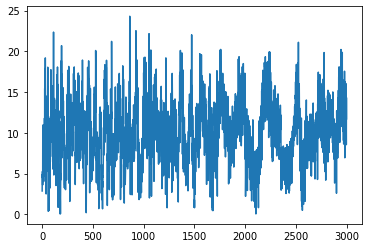

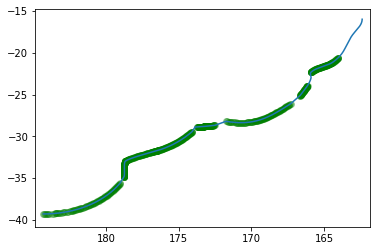

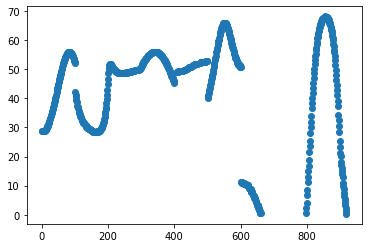

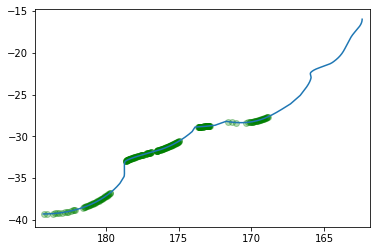

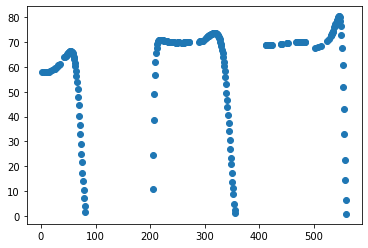

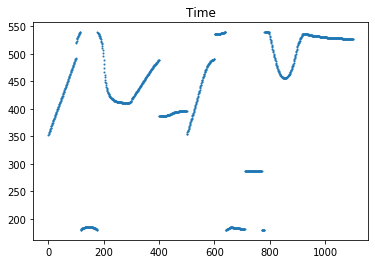

In [273]:
bestFit, finalFit = analyze_fit(opt, miraCurve, 0.25)

In [274]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/miraFits.gz', index=False, encoding='utf-8', compression='gzip')
bestFit.to_csv('./output/miraBestFit.gz', index=False, encoding='utf-8', compression='gzip')

#### Test with no phase

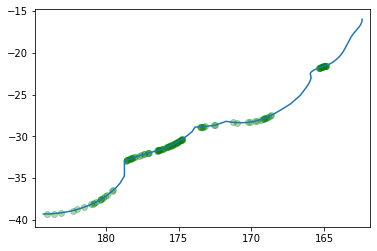

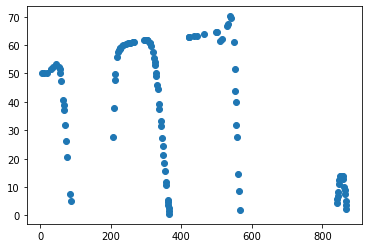

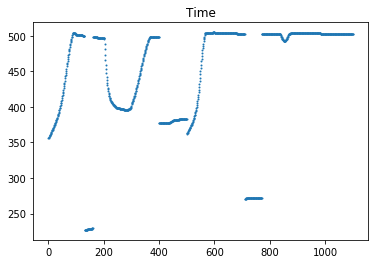

In [271]:
data = direct_fit(miraCurve, 0.05)